In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import math
import time
from keras import backend as K
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
import sklearn.metrics as m
from collections import Counter
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

Using TensorFlow backend.


In [2]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''

def plot_test(y_test,y_pred,start,end,string):
    #Plot of testing.
    plt.figure(figsize=(20,10))
    plt.plot(y_test[start:end],'r',linestyle="--")
    plt.plot(y_pred[start:end],'b')
    plt.xticks(np.arange(0,end-start,1))
    plt.legend()
    plt.title(string)
    plt.show()

def nn_model(localdf,localdict,times,metric,num_cols,hour_day,act = 'relu'):
    for counter in range(times):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                print(localdf.columns[i])
                ndf = localdf
                x = ndf[ndf.columns[:-1]]
                print ("\n Columns of  x : ",x.columns)
                y = ndf[ndf.columns[-1:]]
                print("\n Columns of  y : ",y.columns)
                
                #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
                
                train_size = int(70*x.shape[0]/100)
                X_train = x.values[:train_size]
                y_train = y.values[:train_size]
                    
                X_test = x.values[train_size:]
                y_test = y.values[train_size:]
                
                model = Sequential()
                
                #Hidden Layers.
                model.add(Dense(24,input_dim=x.shape[1],kernel_initializer='normal', activation=act))
                model.add(Dense(7,kernel_initializer='normal', activation=act))
                
                #Output Layer.
                model.add(Dense(1,kernel_initializer='normal',activation='linear'))
                
                #Compile model.
                model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
                
                #Fit the model.
                history = model.fit(X_train,y_train,epochs=750,batch_size=X_train.shape[0],verbose=1)
                
                #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = model.evaluate(X_test,y_test,verbose=1,batch_size=X_test.shape[0])
                y_pred = model.predict(X_test,batch_size=X_test.shape[0])
                y_pred[y_pred<0]=0
                
                r2 = r2_score(y_test,y_pred)
                rmse = np.sqrt(mean_squared_error(y_test,y_pred))
                mae = mean_absolute_error(y_test,y_pred)
                
                print ("R2 Score : ",r2)
                print ("RMSE : ",rmse)
                print ("MAE : ",mae)
                #print ("Metric : %.5f" % (scores[1]))
                localdict.setdefault(counter,[]).append(([r2,rmse,mae]))
                model.summary()
                weights1 = model.layers[0].get_weights()[0]
                biases1 = model.layers[0].get_weights()[1]
                weights2 = model.layers[1].get_weights()[0]
                biases2 = model.layers[1].get_weights()[1]
                print ("Activation used : ",act)
                plot_test(y_test,y_pred,0,100,"ANN")
                del model
                
    return localdict,history,y_test,y_pred,scores,weights1, weights2, biases1, biases2 

In [30]:

def nn_model_24(x,y,localdict,times,metric,num_cols,hour_day,act = 'relu'):
    for counter in range(times):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                #print(localdf.columns[i])
                #ndf = localdf
                #x = ndf[ndf.columns[:-1]]
                print ("\n Shape of  x : ",x.shape)
                #y = ndf[ndf.columns[-1:]]
                print("\n Shape of  y : ",y.shape)
                
                #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
                
                train_size = int(70*x.shape[0]/100)
                X_train = x.values[:train_size]
                y_train = y.values[:train_size]
                    
                X_test = x.values[train_size:]
                y_test = y.values[train_size:]
                
                print ("Split done , the shapes : ",X_train.shape,y_train.shape,X_test.shape,y_test.shape)
                model = Sequential()
                
                #Hidden Layers.
                model.add(Dense(output_dim = 24,input_dim=x.shape[1],kernel_initializer='normal', activation=act))
                model.add(Dense(input_dim=24,output_dim = 7,kernel_initializer='normal', activation=act))
                
                #Output Layer.
                model.add(Dense(input_dim=7,output_dim=24,kernel_initializer='normal',activation='linear'))
                
                #Compile model.
                model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
                
                #Fit the model.
                history = model.fit(X_train,y_train,epochs=750,batch_size=X_train.shape[0],verbose=1,validation_split=0.12)
                
                #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = model.evaluate(X_test,y_test,verbose=1,batch_size=X_test.shape[0])
                y_pred = model.predict(X_test,batch_size=X_test.shape[0])
                
                
                newy_pred = np.empty([y_pred.shape[0]],dtype=float)
                newy_test = np.empty([y_test.shape[0]],dtype=float)
                
                y_pred[y_pred<0]=0
                '''
                The following part is run, only when the NN has 24 output nodes, and the metrics have to be evaluated
                on the sum total, of all the output nodes.
                '''
                
                #Now, let us convert the 24 hour predictions into a single prediction, denoting the total load.
                for i in range(y_pred.shape[0]):
                    newy_pred[i] = sum(y_pred[i])
                    newy_test[i] = sum(y_test[i])
                    
                print ("\nShape of y_pred : ",y_pred.shape)
                print ("\nShape of newy_pred : ",newy_pred.shape)
                
                print ("\nShape of y_test : ",y_test.shape)
                print ("\nShape of newy_test : ",newy_test.shape)
                
                newy_pred[newy_pred<0] = 0
                '''
                r2 = r2_score(newy_test,newy_pred)
                rmse = np.sqrt(mean_squared_error(newy_test,newy_pred))
                mae = mean_absolute_error(newy_test,newy_pred)
                print ("R2 Score : ",r2)
                print ("RMSE : ",rmse)
                print ("MAE : ",mae)
                localdict.setdefault(str(counter)+" - after summation ",[]).append(([r2,rmse,mae]))
                '''
                
                '''
                Now, the metric : RMSE will be calculated as the Root of the sum of MSE of all the output nodes.
                '''
                
                y_test = pd.DataFrame(y_test)
                y_pred = pd.DataFrame(y_pred)
                
                summand = 0
                for i in range(y_test.shape[1]):
                    summand += mean_squared_error(y_test[y_test.columns[i]] , y_pred[y_pred.columns[i]])
                rmse = np.sqrt(summand)    
                    
                r2 = r2_score(y_test,y_pred)
                #rmse = np.sqrt(mean_squared_error(y_test,y_pred))
                #mae = mean_absolute_error(y_test,y_pred)
                
                print ("\n The metrics with 24 O/P nodes : ")
                print ("R2 Score : ",r2)
                print ("RMSE : ",rmse)
                
                y_test = y_test.values
                y_pred = y_pred.values
                
                #print ("MAE : ",mae)
                #print ("Metric : %.5f" % (scores[1]))
                localdict.setdefault(str(counter)+" - before summation",[]).append(([rmse]))
                model.summary()
                weights1 = model.layers[0].get_weights()[0]
                biases1 = model.layers[0].get_weights()[1]
                weights2 = model.layers[1].get_weights()[0]
                biases2 = model.layers[1].get_weights()[1]
                print ("Activation used : ",act)
                plot_test(newy_test,newy_pred,0,100,"ANN")
                del model
                
    return localdict,history,y_test,y_pred,scores,weights1, weights2, biases1, biases2 

In [4]:
'''
Testing the models on house '115'.
'''
df_115 = pd.read_pickle('../DataSets/New_Pecan_Street/load_data_115.pkl')
df_115.head()

dataid               localhour       use  air1  air2  air3  airwindowunit1  \
0     115  2014-01-24 19:00:00-06  1.022517   0.0   NaN   NaN             NaN   
1     115  2014-01-24 20:00:00-06  1.771083   0.0   NaN   NaN             NaN   
2     115  2014-01-24 21:00:00-06  0.893550   0.0   NaN   NaN             NaN   
3     115  2014-01-24 22:00:00-06  0.194233   0.0   NaN   NaN             NaN   
4     115  2014-01-24 23:00:00-06  0.403667   0.0   NaN   NaN             NaN   

   aquarium1  bathroom1  bathroom2     ...       refrigerator1  refrigerator2  \
0        NaN        NaN        NaN     ...                 0.0            NaN   
1        NaN        NaN        NaN     ...                 0.0            NaN   
2        NaN        NaN        NaN     ...                 0.0            NaN   
3        NaN        NaN        NaN     ...                 0.0            NaN   
4        NaN        NaN        NaN     ...                 0.0            NaN   

   security1  shed1  sprinkler1  utilityroom1  venthood1  waterheater1  \
0        NaN    NaN         NaN           NaN        NaN      0.000000   
1        NaN    NaN         NaN           NaN        NaN      0.000000   
2        NaN    NaN         NaN           NaN        NaN      0.000000   
3        NaN    NaN         NaN           NaN        NaN      0.000000   
4        NaN    NaN         NaN           NaN        NaN      0.222317   

   waterheater2  winecooler1  
0           NaN          NaN  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           NaN          NaN  

[5 rows x 69 columns]

In [5]:
df_115 = df_115[["localhour","air1","furnace1","waterheater1"]]
df_115["total"] = df_115["air1"] + df_115["furnace1"] + df_115["waterheater1"]
df_115.iloc[:,[1,2,3,4]] = df_115.iloc[:,[1,2,3,4]].mul(1000)
df_115.head()

localhour  air1     furnace1  waterheater1        total
0  2014-01-24 19:00:00-06   0.0   805.133333      0.000000   805.133333
1  2014-01-24 20:00:00-06   0.0  1572.700000      0.000000  1572.700000
2  2014-01-24 21:00:00-06   0.0   631.100000      0.000000   631.100000
3  2014-01-24 22:00:00-06   0.0     0.000000      0.000000     0.000000
4  2014-01-24 23:00:00-06   0.0     0.000000    222.316667   222.316667

In [8]:
# changing the shape of the given data from every row being an hour to every row being a day
# that is, every row will now have all hours thermal load data as columns (0,1..23) in x and that day's total load in y
# shapes being x = (1700,24), y = (1700,1)
nhrs = int(df_115["total"].values.shape[0]/24)
y_115 = np.ndarray(shape=(nhrs,))
x_115 = np.ndarray(shape=(nhrs,24))
val = []
for i in range(nhrs):
    #val = df_tot_ther.values[i:i+24]
    #Take only the loads correspondin to one whole day, starting from the hour the datframe starts from.
    val = df_115["total"].values[24*i:24*(i+1)]
    y_115[i] = np.sum(val)
    x_115[i]=val.T

In [10]:
x_115

array([[  805.13333333,  1572.7       ,   631.1       , ...,
          211.38333333,     0.        ,     0.        ],
       [    0.        ,  1385.08333333,     0.        , ...,
            0.        ,     0.        ,   201.2       ],
       [    0.        ,     0.        ,     0.        , ...,
         1890.45      ,  1801.38333333,  1112.66666667],
       ..., 
       [  202.5       ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,   206.31666667,     0.        , ...,
            0.        ,   203.53333333,     0.        ],
       [    0.        ,   956.16666667,   706.7       , ...,
            0.        ,   746.55      ,  1011.61666667]])

In [14]:
'''
Don't run this part, when the NN model has 24 output nodes.
'''
# creating the desired shape for the ANN model - 168 columns for hour-wise data of 7 days as input
#  and next day total load as output
temp = x.values.tolist()
x = np.ndarray(shape=(nhrs,168))
for i in range(7,len(temp),1):
    dlist = []
    for j in range(1,8):
        dlist = dlist + temp[i-j]
    x[i] = dlist
x = pd.DataFrame(x)
x.tail(10)

x = x.iloc[7:,:]
y = y.iloc[7:,:]
print(x.shape)
print(y.shape)

d_115 = pd.concat([x,y],axis=1)
print(d_115.shape)
d_115.head(10)

(1148, 168)
(1148, 1)
(1148, 169)


0            1            2           3           4           5  \
7     71.916667     0.000000   521.000000   37.366667  201.383333    0.000000   
8      0.000000     0.000000   199.500000    0.000000    0.000000    0.000000   
9      0.000000   197.750000     0.000000    0.000000    0.000000  198.783333   
10     0.000000     0.000000  3546.683333  227.350000  890.433333  721.533333   
11  1300.583333  1443.900000   892.400000    0.000000    0.000000  193.316667   
12   188.916667   652.550000     0.000000  189.350000    0.000000    0.000000   
13  1493.816667  2078.733333  2327.650000   36.616667    0.000000  726.300000   
14  1976.750000  1815.683333  2366.583333  237.133333    0.000000  271.283333   
15  1255.650000   959.716667   829.150000  190.250000    0.000000    0.000000   
16     0.000000   190.666667     0.000000  193.583333    0.000000    0.000000   

              6            7            8            9      ...       \
7      0.000000     0.000000     0.000000   199.800000      ...        
8      0.000000   202.716667     0.000000     0.000000      ...        
9      0.000000     0.000000     0.000000     0.000000      ...        
10   893.616667  1446.533333  1445.016667   997.316667      ...        
11     0.000000     0.000000     0.000000   189.733333      ...        
12     0.000000   179.083333    14.500000     0.000000      ...        
13  1935.616667  1530.616667  2102.366667  2260.450000      ...        
14   643.250000  1016.733333   893.216667  1870.800000      ...        
15     0.000000   192.516667   686.533333     0.000000      ...        
16     0.000000     0.000000   190.566667     0.000000      ...        

            159          160          161          162          163  \
7   4076.616667  2346.050000  1367.383333   630.066667     0.000000   
8     38.533333   496.150000  1463.466667    71.550000   129.800000   
9   4075.783333  2288.766667  1471.166667  2294.450000  1489.233333   
10  4170.400000  3989.066667  2629.616667  2703.416667  3241.050000   
11  3349.950000  1334.150000  1306.316667   786.233333   691.683333   
12  3818.133333   310.200000  1253.583333  1016.516667   247.283333   
13     0.000000     0.000000   200.450000   210.783333     0.000000   
14     0.000000   614.200000   459.566667     0.000000   225.850000   
15  1964.716667   918.733333  1026.066667  1022.583333   409.633333   
16   896.550000     0.000000     0.000000     0.000000     0.000000   

            164          165          166          167      day_load  
7   1428.566667   211.383333     0.000000     0.000000   2096.650000  
8      0.000000     0.000000     0.000000   201.200000   8224.100000  
9   2025.933333  1890.450000  1801.383333  1112.666667  25377.300000  
10  1903.650000  1376.750000  2286.633333  2279.100000  10153.350000  
11  1436.216667     0.000000  1331.700000  1575.350000  27558.350000  
12   203.183333     0.000000     0.000000   122.616667  55408.383333  
13     0.000000   200.866667     0.000000     0.000000  36597.300000  
14     0.000000   194.933333     0.000000     0.000000  14402.533333  
15     0.000000     0.000000     0.000000   190.050000   5966.233333  
16   193.333333  1595.083333  4041.600000  1830.733333  20851.466667  

[10 rows x 169 columns]

In [15]:
df_115_t = pd.concat([x,y],axis=1)
df_115_t.head()

0        1            2           3           4           5  \
7     71.916667     0.00   521.000000   37.366667  201.383333    0.000000   
8      0.000000     0.00   199.500000    0.000000    0.000000    0.000000   
9      0.000000   197.75     0.000000    0.000000    0.000000  198.783333   
10     0.000000     0.00  3546.683333  227.350000  890.433333  721.533333   
11  1300.583333  1443.90   892.400000    0.000000    0.000000  193.316667   

             6            7            8           9    ...             159  \
7     0.000000     0.000000     0.000000  199.800000    ...     4076.616667   
8     0.000000   202.716667     0.000000    0.000000    ...       38.533333   
9     0.000000     0.000000     0.000000    0.000000    ...     4075.783333   
10  893.616667  1446.533333  1445.016667  997.316667    ...     4170.400000   
11    0.000000     0.000000     0.000000  189.733333    ...     3349.950000   

            160          161          162          163          164  \
7   2346.050000  1367.383333   630.066667     0.000000  1428.566667   
8    496.150000  1463.466667    71.550000   129.800000     0.000000   
9   2288.766667  1471.166667  2294.450000  1489.233333  2025.933333   
10  3989.066667  2629.616667  2703.416667  3241.050000  1903.650000   
11  1334.150000  1306.316667   786.233333   691.683333  1436.216667   

            165          166          167  day_load  
7    211.383333     0.000000     0.000000   2096.65  
8      0.000000     0.000000   201.200000   8224.10  
9   1890.450000  1801.383333  1112.666667  25377.30  
10  1376.750000  2286.633333  2279.100000  10153.35  
11     0.000000  1331.700000  1575.350000  27558.35  

[5 rows x 169 columns]

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
803/803 [==============================] - 0s - loss: 71995808.0000 - mean_squared_error: 71995808.0000
Epoch 2/750
803/803 [==============================] - 0s - loss: 71968096.0000 - mean_squared_error: 71968096.0000
Epoch 3/750
803/803 [==============================] - 0s - loss: 71942632.0000 - mean_squared_error: 71942632.0000
Epoch 4/750
803/803 [==============================] - 0s - loss: 71917248.0000 - mean_squared_error: 71917248.0000
Epoch 5/750
803/803 [==============================] - 0s - loss: 71890960.0000 - mean_squared_error: 71890960.0000
Epoch 6/750
803/803 [==============================] - 0s - loss: 71862664.0000 - mean_squared_error: 71862664.0000
Epoch 7/750
803/803 [==============================] - 

803/803 [==============================] - 0s - loss: 43075052.0000 - mean_squared_error: 43075052.0000
Epoch 69/750
803/803 [==============================] - 0s - loss: 41920632.0000 - mean_squared_error: 41920632.0000
Epoch 70/750
803/803 [==============================] - 0s - loss: 40762840.0000 - mean_squared_error: 40762840.0000
Epoch 71/750
803/803 [==============================] - 0s - loss: 39605976.0000 - mean_squared_error: 39605976.0000
Epoch 72/750
803/803 [==============================] - 0s - loss: 38454568.0000 - mean_squared_error: 38454568.0000
Epoch 73/750
803/803 [==============================] - 0s - loss: 37313720.0000 - mean_squared_error: 37313720.0000
Epoch 74/750
803/803 [==============================] - 0s - loss: 36187868.0000 - mean_squared_error: 36187868.0000
Epoch 75/750
803/803 [==============================] - 0s - loss: 35081816.0000 - mean_squared_error: 35081816.0000
Epoch 76/750
803/803 [==============================] - 0s - loss: 34001448.0

803/803 [==============================] - 0s - loss: 21938080.0000 - mean_squared_error: 21938080.0000
Epoch 138/750
803/803 [==============================] - 0s - loss: 21893750.0000 - mean_squared_error: 21893750.0000
Epoch 139/750
803/803 [==============================] - 0s - loss: 21849324.0000 - mean_squared_error: 21849324.0000
Epoch 140/750
803/803 [==============================] - 0s - loss: 21804906.0000 - mean_squared_error: 21804906.0000
Epoch 141/750
803/803 [==============================] - 0s - loss: 21760576.0000 - mean_squared_error: 21760576.0000
Epoch 142/750
803/803 [==============================] - 0s - loss: 21716396.0000 - mean_squared_error: 21716396.0000
Epoch 143/750
803/803 [==============================] - 0s - loss: 21672406.0000 - mean_squared_error: 21672406.0000
Epoch 144/750
803/803 [==============================] - 0s - loss: 21628620.0000 - mean_squared_error: 21628620.0000
Epoch 145/750
803/803 [==============================] - 0s - loss: 21

803/803 [==============================] - 0s - loss: 18912480.0000 - mean_squared_error: 18912480.0000
Epoch 207/750
803/803 [==============================] - 0s - loss: 18867884.0000 - mean_squared_error: 18867884.0000
Epoch 208/750
803/803 [==============================] - 0s - loss: 18823294.0000 - mean_squared_error: 18823294.0000
Epoch 209/750
803/803 [==============================] - 0s - loss: 18778686.0000 - mean_squared_error: 18778686.0000
Epoch 210/750
803/803 [==============================] - 0s - loss: 18734058.0000 - mean_squared_error: 18734058.0000
Epoch 211/750
803/803 [==============================] - 0s - loss: 18689414.0000 - mean_squared_error: 18689414.0000
Epoch 212/750
803/803 [==============================] - 0s - loss: 18644770.0000 - mean_squared_error: 18644770.0000
Epoch 213/750
803/803 [==============================] - 0s - loss: 18600120.0000 - mean_squared_error: 18600120.0000
Epoch 214/750
803/803 [==============================] - 0s - loss: 18

803/803 [==============================] - 0s - loss: 15767899.0000 - mean_squared_error: 15767899.0000
Epoch 276/750
803/803 [==============================] - 0s - loss: 15718929.0000 - mean_squared_error: 15718929.0000
Epoch 277/750
803/803 [==============================] - 0s - loss: 15669916.0000 - mean_squared_error: 15669916.0000
Epoch 278/750
803/803 [==============================] - 0s - loss: 15620890.0000 - mean_squared_error: 15620890.0000
Epoch 279/750
803/803 [==============================] - 0s - loss: 15571875.0000 - mean_squared_error: 15571875.0000
Epoch 280/750
803/803 [==============================] - 0s - loss: 15522885.0000 - mean_squared_error: 15522885.0000
Epoch 281/750
803/803 [==============================] - 0s - loss: 15473937.0000 - mean_squared_error: 15473937.0000
Epoch 282/750
803/803 [==============================] - 0s - loss: 15425068.0000 - mean_squared_error: 15425068.0000
Epoch 283/750
803/803 [==============================] - 0s - loss: 15

803/803 [==============================] - 0s - loss: 12874002.0000 - mean_squared_error: 12874002.0000
Epoch 345/750
803/803 [==============================] - 0s - loss: 12843058.0000 - mean_squared_error: 12843058.0000
Epoch 346/750
803/803 [==============================] - 0s - loss: 12812743.0000 - mean_squared_error: 12812743.0000
Epoch 347/750
803/803 [==============================] - 0s - loss: 12782723.0000 - mean_squared_error: 12782723.0000
Epoch 348/750
803/803 [==============================] - 0s - loss: 12752960.0000 - mean_squared_error: 12752960.0000
Epoch 349/750
803/803 [==============================] - 0s - loss: 12723416.0000 - mean_squared_error: 12723416.0000
Epoch 350/750
803/803 [==============================] - 0s - loss: 12694180.0000 - mean_squared_error: 12694180.0000
Epoch 351/750
803/803 [==============================] - 0s - loss: 12665217.0000 - mean_squared_error: 12665217.0000
Epoch 352/750
803/803 [==============================] - 0s - loss: 12

803/803 [==============================] - 0s - loss: 11361123.0000 - mean_squared_error: 11361123.0000
Epoch 414/750
803/803 [==============================] - 0s - loss: 11345512.0000 - mean_squared_error: 11345512.0000
Epoch 415/750
803/803 [==============================] - 0s - loss: 11330003.0000 - mean_squared_error: 11330003.0000
Epoch 416/750
803/803 [==============================] - 0s - loss: 11314539.0000 - mean_squared_error: 11314539.0000
Epoch 417/750
803/803 [==============================] - 0s - loss: 11299097.0000 - mean_squared_error: 11299097.0000
Epoch 418/750
803/803 [==============================] - 0s - loss: 11284054.0000 - mean_squared_error: 11284054.0000
Epoch 419/750
803/803 [==============================] - 0s - loss: 11268801.0000 - mean_squared_error: 11268801.0000
Epoch 420/750
803/803 [==============================] - 0s - loss: 11253491.0000 - mean_squared_error: 11253491.0000
Epoch 421/750
803/803 [==============================] - 0s - loss: 11

803/803 [==============================] - 0s - loss: 10335573.0000 - mean_squared_error: 10335573.0000
Epoch 483/750
803/803 [==============================] - 0s - loss: 10316030.0000 - mean_squared_error: 10316030.0000
Epoch 484/750
803/803 [==============================] - 0s - loss: 10295582.0000 - mean_squared_error: 10295582.0000
Epoch 485/750
803/803 [==============================] - 0s - loss: 10274738.0000 - mean_squared_error: 10274738.0000
Epoch 486/750
803/803 [==============================] - 0s - loss: 10253869.0000 - mean_squared_error: 10253869.0000
Epoch 487/750
803/803 [==============================] - 0s - loss: 10233657.0000 - mean_squared_error: 10233657.0000
Epoch 488/750
803/803 [==============================] - 0s - loss: 10214319.0000 - mean_squared_error: 10214319.0000
Epoch 489/750
803/803 [==============================] - 0s - loss: 10194692.0000 - mean_squared_error: 10194692.0000
Epoch 490/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 8880660.0000 - mean_squared_error: 8880660.0000
Epoch 553/750
803/803 [==============================] - 0s - loss: 8862081.0000 - mean_squared_error: 8862081.0000
Epoch 554/750
803/803 [==============================] - 0s - loss: 8843097.0000 - mean_squared_error: 8843097.0000
Epoch 555/750
803/803 [==============================] - 0s - loss: 8824286.0000 - mean_squared_error: 8824286.0000
Epoch 556/750
803/803 [==============================] - 0s - loss: 8805843.0000 - mean_squared_error: 8805843.0000
Epoch 557/750
803/803 [==============================] - 0s - loss: 8787555.0000 - mean_squared_error: 8787555.0000
Epoch 558/750
803/803 [==============================] - 0s - loss: 8769232.0000 - mean_squared_error: 8769232.0000
Epoch 559/750
803/803 [==============================] - 0s - loss: 8751154.0000 - mean_squared_error: 8751154.0000
Epoch 560/750
803/803 [==============================] - 0s - loss: 8732741.0000 - mea

803/803 [==============================] - 0s - loss: 7683540.0000 - mean_squared_error: 7683540.0000
Epoch 623/750
803/803 [==============================] - 0s - loss: 7667858.0000 - mean_squared_error: 7667858.0000
Epoch 624/750
803/803 [==============================] - 0s - loss: 7652477.0000 - mean_squared_error: 7652477.0000
Epoch 625/750
803/803 [==============================] - 0s - loss: 7636872.0000 - mean_squared_error: 7636872.0000
Epoch 626/750
803/803 [==============================] - 0s - loss: 7621513.5000 - mean_squared_error: 7621513.5000
Epoch 627/750
803/803 [==============================] - 0s - loss: 7606270.0000 - mean_squared_error: 7606270.0000
Epoch 628/750
803/803 [==============================] - 0s - loss: 7590858.5000 - mean_squared_error: 7590858.5000
Epoch 629/750
803/803 [==============================] - 0s - loss: 7575519.0000 - mean_squared_error: 7575519.0000
Epoch 630/750
803/803 [==============================] - 0s - loss: 7560175.5000 - mea

803/803 [==============================] - 0s - loss: 6688349.5000 - mean_squared_error: 6688349.5000
Epoch 693/750
803/803 [==============================] - 0s - loss: 6675277.0000 - mean_squared_error: 6675277.0000
Epoch 694/750
803/803 [==============================] - 0s - loss: 6662343.5000 - mean_squared_error: 6662343.5000
Epoch 695/750
803/803 [==============================] - 0s - loss: 6649652.0000 - mean_squared_error: 6649652.0000
Epoch 696/750
803/803 [==============================] - 0s - loss: 6636961.0000 - mean_squared_error: 6636961.0000
Epoch 697/750
803/803 [==============================] - 0s - loss: 6624251.5000 - mean_squared_error: 6624251.5000
Epoch 698/750
803/803 [==============================] - 0s - loss: 6611840.0000 - mean_squared_error: 6611840.0000
Epoch 699/750
803/803 [==============================] - 0s - loss: 6599221.0000 - mean_squared_error: 6599221.0000
Epoch 700/750
803/803 [==============================] - 0s - loss: 6586506.5000 - mea

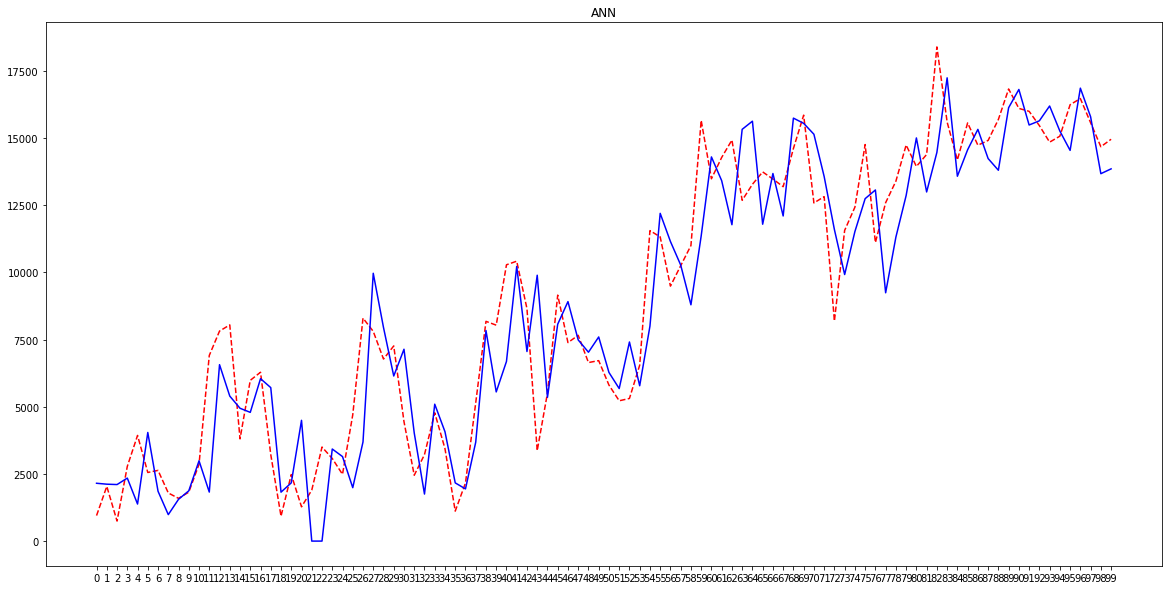

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
803/803 [==============================] - 0s - loss: 71996304.0000 - mean_squared_error: 71996304.0000
Epoch 2/750
803/803 [==============================] - 0s - loss: 71954184.0000 - mean_squared_error: 71954184.0000
Epoch 3/750
803/803 [==============================] - 0s - loss: 71918000.0000 - mean_squared_error: 71918000.0000
Epoch 4/750
803/803 [==============================] - 0s - loss: 71891336.0000 - mean_squared_error: 71891336.0000
Epoch 5/750
803/803 [==============================] - 0s - loss: 71864864.0000 - mean_squared_error: 71864864.0000
Epoch 6/750
803/803 [==============================] - 0s - loss: 71837144.0000 - mean_squared_error: 71837144.0000
Epoch 7/750
803/803 [==============================] - 

803/803 [==============================] - 0s - loss: 43563404.0000 - mean_squared_error: 43563404.0000
Epoch 69/750
803/803 [==============================] - 0s - loss: 42455516.0000 - mean_squared_error: 42455516.0000
Epoch 70/750
803/803 [==============================] - 0s - loss: 41345572.0000 - mean_squared_error: 41345572.0000
Epoch 71/750
803/803 [==============================] - 0s - loss: 40237060.0000 - mean_squared_error: 40237060.0000
Epoch 72/750
803/803 [==============================] - 0s - loss: 39133596.0000 - mean_squared_error: 39133596.0000
Epoch 73/750
803/803 [==============================] - 0s - loss: 38039344.0000 - mean_squared_error: 38039344.0000
Epoch 74/750
803/803 [==============================] - 0s - loss: 36957684.0000 - mean_squared_error: 36957684.0000
Epoch 75/750
803/803 [==============================] - 0s - loss: 35893144.0000 - mean_squared_error: 35893144.0000
Epoch 76/750
803/803 [==============================] - 0s - loss: 34849960.0

803/803 [==============================] - 0s - loss: 21714848.0000 - mean_squared_error: 21714848.0000
Epoch 138/750
803/803 [==============================] - 0s - loss: 21658506.0000 - mean_squared_error: 21658506.0000
Epoch 139/750
803/803 [==============================] - 0s - loss: 21601792.0000 - mean_squared_error: 21601792.0000
Epoch 140/750
803/803 [==============================] - 0s - loss: 21544748.0000 - mean_squared_error: 21544748.0000
Epoch 141/750
803/803 [==============================] - 0s - loss: 21487452.0000 - mean_squared_error: 21487452.0000
Epoch 142/750
803/803 [==============================] - 0s - loss: 21429914.0000 - mean_squared_error: 21429914.0000
Epoch 143/750
803/803 [==============================] - 0s - loss: 21372120.0000 - mean_squared_error: 21372120.0000
Epoch 144/750
803/803 [==============================] - 0s - loss: 21314256.0000 - mean_squared_error: 21314256.0000
Epoch 145/750
803/803 [==============================] - 0s - loss: 21

803/803 [==============================] - 0s - loss: 17297776.0000 - mean_squared_error: 17297776.0000
Epoch 207/750
803/803 [==============================] - 0s - loss: 17227652.0000 - mean_squared_error: 17227652.0000
Epoch 208/750
803/803 [==============================] - 0s - loss: 17157450.0000 - mean_squared_error: 17157450.0000
Epoch 209/750
803/803 [==============================] - 0s - loss: 17087122.0000 - mean_squared_error: 17087122.0000
Epoch 210/750
803/803 [==============================] - 0s - loss: 17016392.0000 - mean_squared_error: 17016392.0000
Epoch 211/750
803/803 [==============================] - 0s - loss: 16945334.0000 - mean_squared_error: 16945334.0000
Epoch 212/750
803/803 [==============================] - 0s - loss: 16873800.0000 - mean_squared_error: 16873800.0000
Epoch 213/750
803/803 [==============================] - 0s - loss: 16801882.0000 - mean_squared_error: 16801882.0000
Epoch 214/750
803/803 [==============================] - 0s - loss: 16

803/803 [==============================] - 0s - loss: 13004949.0000 - mean_squared_error: 13004949.0000
Epoch 276/750
803/803 [==============================] - 0s - loss: 12962367.0000 - mean_squared_error: 12962367.0000
Epoch 277/750
803/803 [==============================] - 0s - loss: 12920296.0000 - mean_squared_error: 12920296.0000
Epoch 278/750
803/803 [==============================] - 0s - loss: 12878632.0000 - mean_squared_error: 12878632.0000
Epoch 279/750
803/803 [==============================] - 0s - loss: 12837749.0000 - mean_squared_error: 12837749.0000
Epoch 280/750
803/803 [==============================] - 0s - loss: 12797665.0000 - mean_squared_error: 12797665.0000
Epoch 281/750
803/803 [==============================] - 0s - loss: 12758395.0000 - mean_squared_error: 12758395.0000
Epoch 282/750
803/803 [==============================] - 0s - loss: 12719569.0000 - mean_squared_error: 12719569.0000
Epoch 283/750
803/803 [==============================] - 0s - loss: 12

803/803 [==============================] - 0s - loss: 11126125.0000 - mean_squared_error: 11126125.0000
Epoch 345/750
803/803 [==============================] - 0s - loss: 11107246.0000 - mean_squared_error: 11107246.0000
Epoch 346/750
803/803 [==============================] - 0s - loss: 11088567.0000 - mean_squared_error: 11088567.0000
Epoch 347/750
803/803 [==============================] - 0s - loss: 11069982.0000 - mean_squared_error: 11069982.0000
Epoch 348/750
803/803 [==============================] - 0s - loss: 11051444.0000 - mean_squared_error: 11051444.0000
Epoch 349/750
803/803 [==============================] - 0s - loss: 11032892.0000 - mean_squared_error: 11032892.0000
Epoch 350/750
803/803 [==============================] - 0s - loss: 11014184.0000 - mean_squared_error: 11014184.0000
Epoch 351/750
803/803 [==============================] - 0s - loss: 10995271.0000 - mean_squared_error: 10995271.0000
Epoch 352/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 9711022.0000 - mean_squared_error: 9711022.0000
Epoch 414/750
803/803 [==============================] - 0s - loss: 9692307.0000 - mean_squared_error: 9692307.0000
Epoch 415/750
803/803 [==============================] - 0s - loss: 9673851.0000 - mean_squared_error: 9673851.0000
Epoch 416/750
803/803 [==============================] - 0s - loss: 9655565.0000 - mean_squared_error: 9655565.0000
Epoch 417/750
803/803 [==============================] - 0s - loss: 9637628.0000 - mean_squared_error: 9637628.0000
Epoch 418/750
803/803 [==============================] - 0s - loss: 9619716.0000 - mean_squared_error: 9619716.0000
Epoch 419/750
803/803 [==============================] - 0s - loss: 9602023.0000 - mean_squared_error: 9602023.0000
Epoch 420/750
803/803 [==============================] - 0s - loss: 9584355.0000 - mean_squared_error: 9584355.0000
Epoch 421/750
803/803 [==============================] - 0s - loss: 9566724.0000 - mea

803/803 [==============================] - 0s - loss: 8507418.0000 - mean_squared_error: 8507418.0000
Epoch 484/750
803/803 [==============================] - 0s - loss: 8488730.0000 - mean_squared_error: 8488730.0000
Epoch 485/750
803/803 [==============================] - 0s - loss: 8469887.0000 - mean_squared_error: 8469887.0000
Epoch 486/750
803/803 [==============================] - 0s - loss: 8450802.0000 - mean_squared_error: 8450802.0000
Epoch 487/750
803/803 [==============================] - 0s - loss: 8431513.0000 - mean_squared_error: 8431513.0000
Epoch 488/750
803/803 [==============================] - 0s - loss: 8412245.0000 - mean_squared_error: 8412245.0000
Epoch 489/750
803/803 [==============================] - 0s - loss: 8392944.0000 - mean_squared_error: 8392944.0000
Epoch 490/750
803/803 [==============================] - 0s - loss: 8373647.0000 - mean_squared_error: 8373647.0000
Epoch 491/750
803/803 [==============================] - 0s - loss: 8354190.5000 - mea

803/803 [==============================] - 0s - loss: 7076818.5000 - mean_squared_error: 7076818.5000
Epoch 554/750
803/803 [==============================] - 0s - loss: 7055292.0000 - mean_squared_error: 7055292.0000
Epoch 555/750
803/803 [==============================] - 0s - loss: 7034556.5000 - mean_squared_error: 7034556.5000
Epoch 556/750
803/803 [==============================] - 0s - loss: 7013166.0000 - mean_squared_error: 7013166.0000
Epoch 557/750
803/803 [==============================] - 0s - loss: 6992329.0000 - mean_squared_error: 6992329.0000
Epoch 558/750
803/803 [==============================] - 0s - loss: 6971591.0000 - mean_squared_error: 6971591.0000
Epoch 559/750
803/803 [==============================] - 0s - loss: 6949827.5000 - mean_squared_error: 6949827.5000
Epoch 560/750
803/803 [==============================] - 0s - loss: 6928605.5000 - mean_squared_error: 6928605.5000
Epoch 561/750
803/803 [==============================] - 0s - loss: 6907501.0000 - mea

803/803 [==============================] - 0s - loss: 5633285.0000 - mean_squared_error: 5633285.0000
Epoch 624/750
803/803 [==============================] - 0s - loss: 5614365.5000 - mean_squared_error: 5614365.5000
Epoch 625/750
803/803 [==============================] - 0s - loss: 5597414.0000 - mean_squared_error: 5597414.0000
Epoch 626/750
803/803 [==============================] - 0s - loss: 5579140.5000 - mean_squared_error: 5579140.5000
Epoch 627/750
803/803 [==============================] - 0s - loss: 5561815.0000 - mean_squared_error: 5561815.0000
Epoch 628/750
803/803 [==============================] - 0s - loss: 5544497.0000 - mean_squared_error: 5544497.0000
Epoch 629/750
803/803 [==============================] - 0s - loss: 5526606.5000 - mean_squared_error: 5526606.5000
Epoch 630/750
803/803 [==============================] - 0s - loss: 5508910.0000 - mean_squared_error: 5508910.0000
Epoch 631/750
803/803 [==============================] - 0s - loss: 5491663.5000 - mea

803/803 [==============================] - 0s - loss: 4453721.5000 - mean_squared_error: 4453721.5000
Epoch 694/750
803/803 [==============================] - 0s - loss: 4439176.0000 - mean_squared_error: 4439176.0000
Epoch 695/750
803/803 [==============================] - 0s - loss: 4424339.5000 - mean_squared_error: 4424339.5000
Epoch 696/750
803/803 [==============================] - 0s - loss: 4409523.0000 - mean_squared_error: 4409523.0000
Epoch 697/750
803/803 [==============================] - 0s - loss: 4395355.5000 - mean_squared_error: 4395355.5000
Epoch 698/750
803/803 [==============================] - 0s - loss: 4380583.5000 - mean_squared_error: 4380583.5000
Epoch 699/750
803/803 [==============================] - 0s - loss: 4366775.0000 - mean_squared_error: 4366775.0000
Epoch 700/750
803/803 [==============================] - 0s - loss: 4352293.5000 - mean_squared_error: 4352293.5000
Epoch 701/750
803/803 [==============================] - 0s - loss: 4337825.5000 - mea

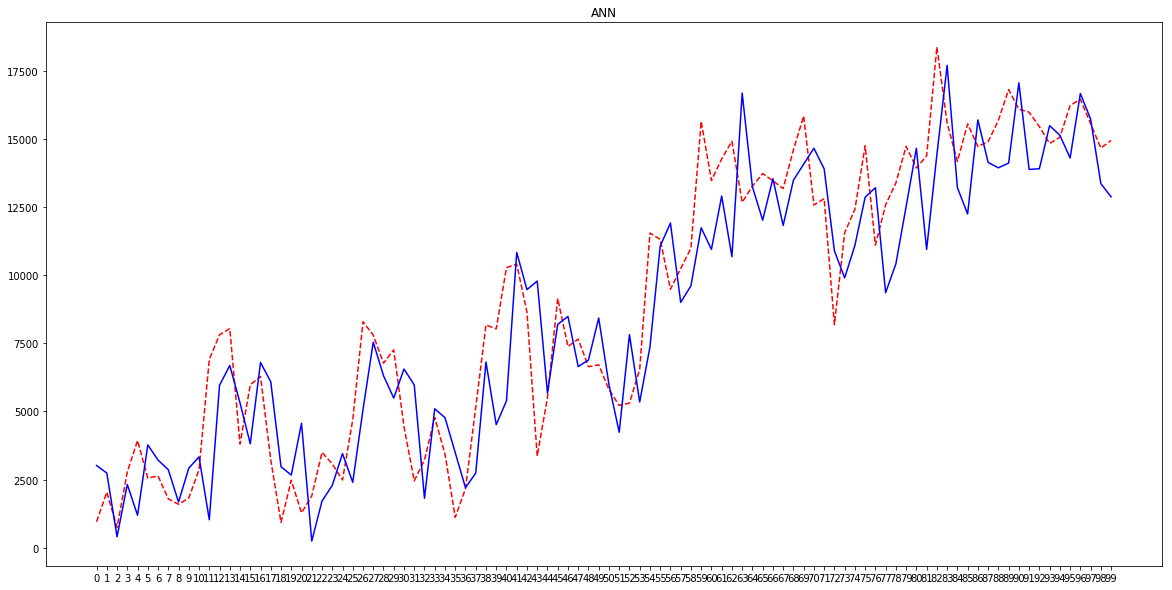

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
803/803 [==============================] - 0s - loss: 71977656.0000 - mean_squared_error: 71977656.0000
Epoch 2/750
803/803 [==============================] - 0s - loss: 71927272.0000 - mean_squared_error: 71927272.0000
Epoch 3/750
803/803 [==============================] - 0s - loss: 71877336.0000 - mean_squared_error: 71877336.0000
Epoch 4/750
803/803 [==============================] - 0s - loss: 71826816.0000 - mean_squared_error: 71826816.0000
Epoch 5/750
803/803 [==============================] - 0s - loss: 71774144.0000 - mean_squared_error: 71774144.0000
Epoch 6/750
803/803 [==============================] - 0s - loss: 71718264.0000 - mean_squared_error: 71718264.0000
Epoch 7/750
803/803 [==============================] - 

803/803 [==============================] - 0s - loss: 41459256.0000 - mean_squared_error: 41459256.0000
Epoch 69/750
803/803 [==============================] - 0s - loss: 40385360.0000 - mean_squared_error: 40385360.0000
Epoch 70/750
803/803 [==============================] - 0s - loss: 39313320.0000 - mean_squared_error: 39313320.0000
Epoch 71/750
803/803 [==============================] - 0s - loss: 38246648.0000 - mean_squared_error: 38246648.0000
Epoch 72/750
803/803 [==============================] - 0s - loss: 37189616.0000 - mean_squared_error: 37189616.0000
Epoch 73/750
803/803 [==============================] - 0s - loss: 36145712.0000 - mean_squared_error: 36145712.0000
Epoch 74/750
803/803 [==============================] - 0s - loss: 35117896.0000 - mean_squared_error: 35117896.0000
Epoch 75/750
803/803 [==============================] - 0s - loss: 34109988.0000 - mean_squared_error: 34109988.0000
Epoch 76/750
803/803 [==============================] - 0s - loss: 33126512.0

803/803 [==============================] - 0s - loss: 21676470.0000 - mean_squared_error: 21676470.0000
Epoch 138/750
803/803 [==============================] - 0s - loss: 21628606.0000 - mean_squared_error: 21628606.0000
Epoch 139/750
803/803 [==============================] - 0s - loss: 21580734.0000 - mean_squared_error: 21580734.0000
Epoch 140/750
803/803 [==============================] - 0s - loss: 21532734.0000 - mean_squared_error: 21532734.0000
Epoch 141/750
803/803 [==============================] - 0s - loss: 21484612.0000 - mean_squared_error: 21484612.0000
Epoch 142/750
803/803 [==============================] - 0s - loss: 21436276.0000 - mean_squared_error: 21436276.0000
Epoch 143/750
803/803 [==============================] - 0s - loss: 21387818.0000 - mean_squared_error: 21387818.0000
Epoch 144/750
803/803 [==============================] - 0s - loss: 21338784.0000 - mean_squared_error: 21338784.0000
Epoch 145/750
803/803 [==============================] - 0s - loss: 21

803/803 [==============================] - 0s - loss: 16968290.0000 - mean_squared_error: 16968290.0000
Epoch 207/750
803/803 [==============================] - 0s - loss: 16888904.0000 - mean_squared_error: 16888904.0000
Epoch 208/750
803/803 [==============================] - 0s - loss: 16809792.0000 - mean_squared_error: 16809792.0000
Epoch 209/750
803/803 [==============================] - 0s - loss: 16730924.0000 - mean_squared_error: 16730924.0000
Epoch 210/750
803/803 [==============================] - 0s - loss: 16652271.0000 - mean_squared_error: 16652271.0000
Epoch 211/750
803/803 [==============================] - 0s - loss: 16573898.0000 - mean_squared_error: 16573898.0000
Epoch 212/750
803/803 [==============================] - 0s - loss: 16495884.0000 - mean_squared_error: 16495884.0000
Epoch 213/750
803/803 [==============================] - 0s - loss: 16418181.0000 - mean_squared_error: 16418181.0000
Epoch 214/750
803/803 [==============================] - 0s - loss: 16

803/803 [==============================] - 0s - loss: 12705305.0000 - mean_squared_error: 12705305.0000
Epoch 276/750
803/803 [==============================] - 0s - loss: 12662727.0000 - mean_squared_error: 12662727.0000
Epoch 277/750
803/803 [==============================] - 0s - loss: 12620496.0000 - mean_squared_error: 12620496.0000
Epoch 278/750
803/803 [==============================] - 0s - loss: 12578606.0000 - mean_squared_error: 12578606.0000
Epoch 279/750
803/803 [==============================] - 0s - loss: 12536712.0000 - mean_squared_error: 12536712.0000
Epoch 280/750
803/803 [==============================] - 0s - loss: 12495641.0000 - mean_squared_error: 12495641.0000
Epoch 281/750
803/803 [==============================] - 0s - loss: 12454934.0000 - mean_squared_error: 12454934.0000
Epoch 282/750
803/803 [==============================] - 0s - loss: 12414639.0000 - mean_squared_error: 12414639.0000
Epoch 283/750
803/803 [==============================] - 0s - loss: 12

803/803 [==============================] - 0s - loss: 10701853.0000 - mean_squared_error: 10701853.0000
Epoch 345/750
803/803 [==============================] - 0s - loss: 10681413.0000 - mean_squared_error: 10681413.0000
Epoch 346/750
803/803 [==============================] - 0s - loss: 10661457.0000 - mean_squared_error: 10661457.0000
Epoch 347/750
803/803 [==============================] - 0s - loss: 10641524.0000 - mean_squared_error: 10641524.0000
Epoch 348/750
803/803 [==============================] - 0s - loss: 10621685.0000 - mean_squared_error: 10621685.0000
Epoch 349/750
803/803 [==============================] - 0s - loss: 10601684.0000 - mean_squared_error: 10601684.0000
Epoch 350/750
803/803 [==============================] - 0s - loss: 10581806.0000 - mean_squared_error: 10581806.0000
Epoch 351/750
803/803 [==============================] - 0s - loss: 10561629.0000 - mean_squared_error: 10561629.0000
Epoch 352/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 9268640.0000 - mean_squared_error: 9268640.0000
Epoch 415/750
803/803 [==============================] - 0s - loss: 9247543.0000 - mean_squared_error: 9247543.0000
Epoch 416/750
803/803 [==============================] - 0s - loss: 9226980.0000 - mean_squared_error: 9226980.0000
Epoch 417/750
803/803 [==============================] - 0s - loss: 9205705.0000 - mean_squared_error: 9205705.0000
Epoch 418/750
803/803 [==============================] - 0s - loss: 9183671.0000 - mean_squared_error: 9183671.0000
Epoch 419/750
803/803 [==============================] - 0s - loss: 9163307.0000 - mean_squared_error: 9163307.0000
Epoch 420/750
803/803 [==============================] - 0s - loss: 9143202.0000 - mean_squared_error: 9143202.0000
Epoch 421/750
803/803 [==============================] - 0s - loss: 9121984.0000 - mean_squared_error: 9121984.0000
Epoch 422/750
803/803 [==============================] - 0s - loss: 9100748.0000 - mea

803/803 [==============================] - 0s - loss: 7758255.5000 - mean_squared_error: 7758255.5000
Epoch 485/750
803/803 [==============================] - 0s - loss: 7740197.5000 - mean_squared_error: 7740197.5000
Epoch 486/750
803/803 [==============================] - 0s - loss: 7722398.0000 - mean_squared_error: 7722398.0000
Epoch 487/750
803/803 [==============================] - 0s - loss: 7705142.0000 - mean_squared_error: 7705142.0000
Epoch 488/750
803/803 [==============================] - 0s - loss: 7687471.5000 - mean_squared_error: 7687471.5000
Epoch 489/750
803/803 [==============================] - 0s - loss: 7669825.5000 - mean_squared_error: 7669825.5000
Epoch 490/750
803/803 [==============================] - 0s - loss: 7652338.0000 - mean_squared_error: 7652338.0000
Epoch 491/750
803/803 [==============================] - 0s - loss: 7635225.0000 - mean_squared_error: 7635225.0000
Epoch 492/750
803/803 [==============================] - 0s - loss: 7618023.0000 - mea

803/803 [==============================] - 0s - loss: 6673350.0000 - mean_squared_error: 6673350.0000
Epoch 555/750
803/803 [==============================] - 0s - loss: 6659730.0000 - mean_squared_error: 6659730.0000
Epoch 556/750
803/803 [==============================] - 0s - loss: 6646577.5000 - mean_squared_error: 6646577.5000
Epoch 557/750
803/803 [==============================] - 0s - loss: 6632760.5000 - mean_squared_error: 6632760.5000
Epoch 558/750
803/803 [==============================] - 0s - loss: 6618957.5000 - mean_squared_error: 6618957.5000
Epoch 559/750
803/803 [==============================] - 0s - loss: 6605184.0000 - mean_squared_error: 6605184.0000
Epoch 560/750
803/803 [==============================] - 0s - loss: 6591828.5000 - mean_squared_error: 6591828.5000
Epoch 561/750
803/803 [==============================] - 0s - loss: 6578126.5000 - mean_squared_error: 6578126.5000
Epoch 562/750
803/803 [==============================] - 0s - loss: 6564435.0000 - mea

803/803 [==============================] - 0s - loss: 5788101.5000 - mean_squared_error: 5788101.5000
Epoch 625/750
803/803 [==============================] - 0s - loss: 5776502.5000 - mean_squared_error: 5776502.5000
Epoch 626/750
803/803 [==============================] - 0s - loss: 5765060.5000 - mean_squared_error: 5765060.5000
Epoch 627/750
803/803 [==============================] - 0s - loss: 5753166.0000 - mean_squared_error: 5753166.0000
Epoch 628/750
803/803 [==============================] - 0s - loss: 5741587.0000 - mean_squared_error: 5741587.0000
Epoch 629/750
803/803 [==============================] - 0s - loss: 5730389.0000 - mean_squared_error: 5730389.0000
Epoch 630/750
803/803 [==============================] - 0s - loss: 5718564.5000 - mean_squared_error: 5718564.5000
Epoch 631/750
803/803 [==============================] - 0s - loss: 5706914.0000 - mean_squared_error: 5706914.0000
Epoch 632/750
803/803 [==============================] - 0s - loss: 5695699.5000 - mea

803/803 [==============================] - 0s - loss: 4957443.5000 - mean_squared_error: 4957443.5000
Epoch 695/750
803/803 [==============================] - 0s - loss: 4941935.5000 - mean_squared_error: 4941935.5000
Epoch 696/750
803/803 [==============================] - 0s - loss: 4928222.0000 - mean_squared_error: 4928222.0000
Epoch 697/750
803/803 [==============================] - 0s - loss: 4915494.5000 - mean_squared_error: 4915494.5000
Epoch 698/750
803/803 [==============================] - 0s - loss: 4903743.5000 - mean_squared_error: 4903743.5000
Epoch 699/750
803/803 [==============================] - 0s - loss: 4891738.0000 - mean_squared_error: 4891738.0000
Epoch 700/750
803/803 [==============================] - 0s - loss: 4879792.5000 - mean_squared_error: 4879792.5000
Epoch 701/750
803/803 [==============================] - 0s - loss: 4868245.0000 - mean_squared_error: 4868245.0000
Epoch 702/750
803/803 [==============================] - 0s - loss: 4857139.5000 - mea

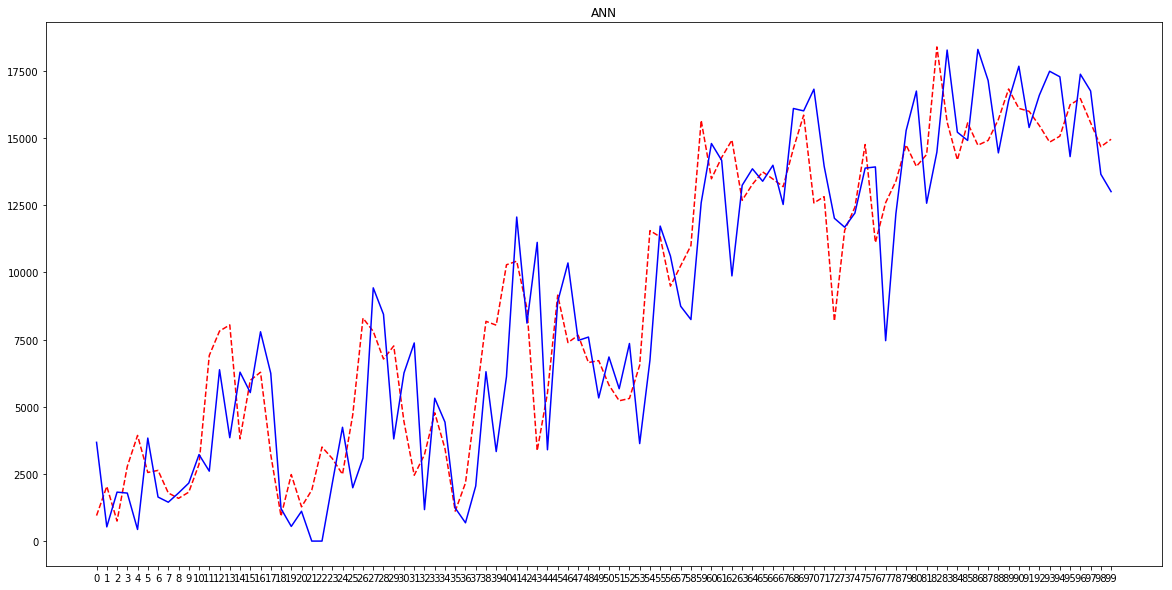

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
803/803 [==============================] - 0s - loss: 72157736.0000 - mean_squared_error: 72157736.0000
Epoch 2/750
803/803 [==============================] - 0s - loss: 72098520.0000 - mean_squared_error: 72098520.0000
Epoch 3/750
803/803 [==============================] - 0s - loss: 72052752.0000 - mean_squared_error: 72052752.0000
Epoch 4/750
803/803 [==============================] - 0s - loss: 72020144.0000 - mean_squared_error: 72020144.0000
Epoch 5/750
803/803 [==============================] - 0s - loss: 71991760.0000 - mean_squared_error: 71991760.0000
Epoch 6/750
803/803 [==============================] - 0s - loss: 71959904.0000 - mean_squared_error: 71959904.0000
Epoch 7/750
803/803 [==============================] - 

803/803 [==============================] - 0s - loss: 38828344.0000 - mean_squared_error: 38828344.0000
Epoch 69/750
803/803 [==============================] - 0s - loss: 37688996.0000 - mean_squared_error: 37688996.0000
Epoch 70/750
803/803 [==============================] - 0s - loss: 36564392.0000 - mean_squared_error: 36564392.0000
Epoch 71/750
803/803 [==============================] - 0s - loss: 35459316.0000 - mean_squared_error: 35459316.0000
Epoch 72/750
803/803 [==============================] - 0s - loss: 34379804.0000 - mean_squared_error: 34379804.0000
Epoch 73/750
803/803 [==============================] - 0s - loss: 33329986.0000 - mean_squared_error: 33329986.0000
Epoch 74/750
803/803 [==============================] - 0s - loss: 32315382.0000 - mean_squared_error: 32315382.0000
Epoch 75/750
803/803 [==============================] - 0s - loss: 31340186.0000 - mean_squared_error: 31340186.0000
Epoch 76/750
803/803 [==============================] - 0s - loss: 30408854.0

803/803 [==============================] - 0s - loss: 21451654.0000 - mean_squared_error: 21451654.0000
Epoch 138/750
803/803 [==============================] - 0s - loss: 21397442.0000 - mean_squared_error: 21397442.0000
Epoch 139/750
803/803 [==============================] - 0s - loss: 21343210.0000 - mean_squared_error: 21343210.0000
Epoch 140/750
803/803 [==============================] - 0s - loss: 21288902.0000 - mean_squared_error: 21288902.0000
Epoch 141/750
803/803 [==============================] - 0s - loss: 21234628.0000 - mean_squared_error: 21234628.0000
Epoch 142/750
803/803 [==============================] - 0s - loss: 21180298.0000 - mean_squared_error: 21180298.0000
Epoch 143/750
803/803 [==============================] - 0s - loss: 21125994.0000 - mean_squared_error: 21125994.0000
Epoch 144/750
803/803 [==============================] - 0s - loss: 21071646.0000 - mean_squared_error: 21071646.0000
Epoch 145/750
803/803 [==============================] - 0s - loss: 21

803/803 [==============================] - 0s - loss: 16934778.0000 - mean_squared_error: 16934778.0000
Epoch 207/750
803/803 [==============================] - 0s - loss: 16844682.0000 - mean_squared_error: 16844682.0000
Epoch 208/750
803/803 [==============================] - 0s - loss: 16754679.0000 - mean_squared_error: 16754679.0000
Epoch 209/750
803/803 [==============================] - 0s - loss: 16664457.0000 - mean_squared_error: 16664457.0000
Epoch 210/750
803/803 [==============================] - 0s - loss: 16573770.0000 - mean_squared_error: 16573770.0000
Epoch 211/750
803/803 [==============================] - 0s - loss: 16482287.0000 - mean_squared_error: 16482287.0000
Epoch 212/750
803/803 [==============================] - 0s - loss: 16390439.0000 - mean_squared_error: 16390439.0000
Epoch 213/750
803/803 [==============================] - 0s - loss: 16298420.0000 - mean_squared_error: 16298420.0000
Epoch 214/750
803/803 [==============================] - 0s - loss: 16

803/803 [==============================] - 0s - loss: 12001379.0000 - mean_squared_error: 12001379.0000
Epoch 276/750
803/803 [==============================] - 0s - loss: 11957956.0000 - mean_squared_error: 11957956.0000
Epoch 277/750
803/803 [==============================] - 0s - loss: 11915023.0000 - mean_squared_error: 11915023.0000
Epoch 278/750
803/803 [==============================] - 0s - loss: 11872793.0000 - mean_squared_error: 11872793.0000
Epoch 279/750
803/803 [==============================] - 0s - loss: 11831114.0000 - mean_squared_error: 11831114.0000
Epoch 280/750
803/803 [==============================] - 0s - loss: 11790095.0000 - mean_squared_error: 11790095.0000
Epoch 281/750
803/803 [==============================] - 0s - loss: 11749523.0000 - mean_squared_error: 11749523.0000
Epoch 282/750
803/803 [==============================] - 0s - loss: 11709416.0000 - mean_squared_error: 11709416.0000
Epoch 283/750
803/803 [==============================] - 0s - loss: 11

803/803 [==============================] - 0s - loss: 9911278.0000 - mean_squared_error: 9911278.0000
Epoch 345/750
803/803 [==============================] - 0s - loss: 9888328.0000 - mean_squared_error: 9888328.0000
Epoch 346/750
803/803 [==============================] - 0s - loss: 9863969.0000 - mean_squared_error: 9863969.0000
Epoch 347/750
803/803 [==============================] - 0s - loss: 9840140.0000 - mean_squared_error: 9840140.0000
Epoch 348/750
803/803 [==============================] - 0s - loss: 9816006.0000 - mean_squared_error: 9816006.0000
Epoch 349/750
803/803 [==============================] - 0s - loss: 9792261.0000 - mean_squared_error: 9792261.0000
Epoch 350/750
803/803 [==============================] - 0s - loss: 9768669.0000 - mean_squared_error: 9768669.0000
Epoch 351/750
803/803 [==============================] - 0s - loss: 9745249.0000 - mean_squared_error: 9745249.0000
Epoch 352/750
803/803 [==============================] - 0s - loss: 9720986.0000 - mea

803/803 [==============================] - 0s - loss: 8301984.5000 - mean_squared_error: 8301984.5000
Epoch 415/750
803/803 [==============================] - 0s - loss: 8283121.5000 - mean_squared_error: 8283121.5000
Epoch 416/750
803/803 [==============================] - 0s - loss: 8264329.5000 - mean_squared_error: 8264329.5000
Epoch 417/750
803/803 [==============================] - 0s - loss: 8245620.5000 - mean_squared_error: 8245620.5000
Epoch 418/750
803/803 [==============================] - 0s - loss: 8226677.0000 - mean_squared_error: 8226677.0000
Epoch 419/750
803/803 [==============================] - 0s - loss: 8207687.0000 - mean_squared_error: 8207687.0000
Epoch 420/750
803/803 [==============================] - 0s - loss: 8188812.0000 - mean_squared_error: 8188812.0000
Epoch 421/750
803/803 [==============================] - 0s - loss: 8170062.0000 - mean_squared_error: 8170062.0000
Epoch 422/750
803/803 [==============================] - 0s - loss: 8151227.0000 - mea

803/803 [==============================] - 0s - loss: 6890107.5000 - mean_squared_error: 6890107.5000
Epoch 485/750
803/803 [==============================] - 0s - loss: 6872086.5000 - mean_squared_error: 6872086.5000
Epoch 486/750
803/803 [==============================] - 0s - loss: 6854262.0000 - mean_squared_error: 6854262.0000
Epoch 487/750
803/803 [==============================] - 0s - loss: 6836430.0000 - mean_squared_error: 6836430.0000
Epoch 488/750
803/803 [==============================] - 0s - loss: 6818612.0000 - mean_squared_error: 6818612.0000
Epoch 489/750
803/803 [==============================] - 0s - loss: 6800923.5000 - mean_squared_error: 6800923.5000
Epoch 490/750
803/803 [==============================] - 0s - loss: 6783254.5000 - mean_squared_error: 6783254.5000
Epoch 491/750
803/803 [==============================] - 0s - loss: 6765667.5000 - mean_squared_error: 6765667.5000
Epoch 492/750
803/803 [==============================] - 0s - loss: 6748133.0000 - mea

803/803 [==============================] - 0s - loss: 5750043.0000 - mean_squared_error: 5750043.0000
Epoch 555/750
803/803 [==============================] - 0s - loss: 5734851.5000 - mean_squared_error: 5734851.5000
Epoch 556/750
803/803 [==============================] - 0s - loss: 5719864.5000 - mean_squared_error: 5719864.5000
Epoch 557/750
803/803 [==============================] - 0s - loss: 5704827.0000 - mean_squared_error: 5704827.0000
Epoch 558/750
803/803 [==============================] - 0s - loss: 5689829.0000 - mean_squared_error: 5689829.0000
Epoch 559/750
803/803 [==============================] - 0s - loss: 5674862.5000 - mean_squared_error: 5674862.5000
Epoch 560/750
803/803 [==============================] - 0s - loss: 5659828.5000 - mean_squared_error: 5659828.5000
Epoch 561/750
803/803 [==============================] - 0s - loss: 5644824.0000 - mean_squared_error: 5644824.0000
Epoch 562/750
803/803 [==============================] - 0s - loss: 5629724.5000 - mea

803/803 [==============================] - 0s - loss: 4702432.5000 - mean_squared_error: 4702432.5000
Epoch 625/750
803/803 [==============================] - 0s - loss: 4687786.0000 - mean_squared_error: 4687786.0000
Epoch 626/750
803/803 [==============================] - 0s - loss: 4673153.5000 - mean_squared_error: 4673153.5000
Epoch 627/750
803/803 [==============================] - 0s - loss: 4658666.5000 - mean_squared_error: 4658666.5000
Epoch 628/750
803/803 [==============================] - 0s - loss: 4644110.5000 - mean_squared_error: 4644110.5000
Epoch 629/750
803/803 [==============================] - 0s - loss: 4629662.0000 - mean_squared_error: 4629662.0000
Epoch 630/750
803/803 [==============================] - 0s - loss: 4615251.5000 - mean_squared_error: 4615251.5000
Epoch 631/750
803/803 [==============================] - 0s - loss: 4600824.5000 - mean_squared_error: 4600824.5000
Epoch 632/750
803/803 [==============================] - 0s - loss: 4586485.0000 - mea

803/803 [==============================] - 0s - loss: 3778310.7500 - mean_squared_error: 3778310.7500
Epoch 695/750
803/803 [==============================] - 0s - loss: 3766424.0000 - mean_squared_error: 3766424.0000
Epoch 696/750
803/803 [==============================] - 0s - loss: 3755568.2500 - mean_squared_error: 3755568.2500
Epoch 697/750
803/803 [==============================] - 0s - loss: 3743735.5000 - mean_squared_error: 3743735.5000
Epoch 698/750
803/803 [==============================] - 0s - loss: 3732609.0000 - mean_squared_error: 3732609.0000
Epoch 699/750
803/803 [==============================] - 0s - loss: 3721064.0000 - mean_squared_error: 3721064.0000
Epoch 700/750
803/803 [==============================] - 0s - loss: 3710146.5000 - mean_squared_error: 3710146.5000
Epoch 701/750
803/803 [==============================] - 0s - loss: 3698969.5000 - mean_squared_error: 3698969.5000
Epoch 702/750
803/803 [==============================] - 0s - loss: 3687905.5000 - mea

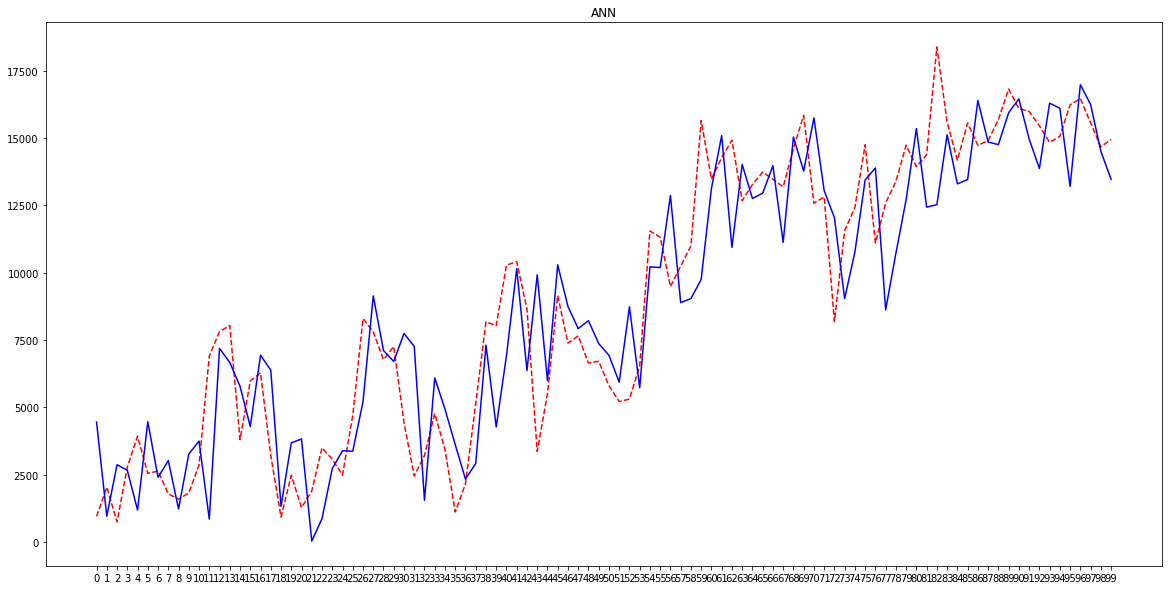

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
803/803 [==============================] - 0s - loss: 71974000.0000 - mean_squared_error: 71974000.0000
Epoch 2/750
803/803 [==============================] - 0s - loss: 71872024.0000 - mean_squared_error: 71872024.0000
Epoch 3/750
803/803 [==============================] - 0s - loss: 71769784.0000 - mean_squared_error: 71769784.0000
Epoch 4/750
803/803 [==============================] - 0s - loss: 71664112.0000 - mean_squared_error: 71664112.0000
Epoch 5/750
803/803 [==============================] - 0s - loss: 71551688.0000 - mean_squared_error: 71551688.0000
Epoch 6/750
803/803 [==============================] - 0s - loss: 71429872.0000 - mean_squared_error: 71429872.0000
Epoch 7/750
803/803 [==============================] - 

803/803 [==============================] - 0s - loss: 23737236.0000 - mean_squared_error: 23737236.0000
Epoch 69/750
803/803 [==============================] - 0s - loss: 23805856.0000 - mean_squared_error: 23805856.0000
Epoch 70/750
803/803 [==============================] - 0s - loss: 23892932.0000 - mean_squared_error: 23892932.0000
Epoch 71/750
803/803 [==============================] - 0s - loss: 23981254.0000 - mean_squared_error: 23981254.0000
Epoch 72/750
803/803 [==============================] - 0s - loss: 24056104.0000 - mean_squared_error: 24056104.0000
Epoch 73/750
803/803 [==============================] - 0s - loss: 24106358.0000 - mean_squared_error: 24106358.0000
Epoch 74/750
803/803 [==============================] - 0s - loss: 24124950.0000 - mean_squared_error: 24124950.0000
Epoch 75/750
803/803 [==============================] - 0s - loss: 24108744.0000 - mean_squared_error: 24108744.0000
Epoch 76/750
803/803 [==============================] - 0s - loss: 24058332.0

803/803 [==============================] - 0s - loss: 20380490.0000 - mean_squared_error: 20380490.0000
Epoch 138/750
803/803 [==============================] - 0s - loss: 20334382.0000 - mean_squared_error: 20334382.0000
Epoch 139/750
803/803 [==============================] - 0s - loss: 20288310.0000 - mean_squared_error: 20288310.0000
Epoch 140/750
803/803 [==============================] - 0s - loss: 20242288.0000 - mean_squared_error: 20242288.0000
Epoch 141/750
803/803 [==============================] - 0s - loss: 20196258.0000 - mean_squared_error: 20196258.0000
Epoch 142/750
803/803 [==============================] - 0s - loss: 20150068.0000 - mean_squared_error: 20150068.0000
Epoch 143/750
803/803 [==============================] - 0s - loss: 20104014.0000 - mean_squared_error: 20104014.0000
Epoch 144/750
803/803 [==============================] - 0s - loss: 20057938.0000 - mean_squared_error: 20057938.0000
Epoch 145/750
803/803 [==============================] - 0s - loss: 20

803/803 [==============================] - 0s - loss: 17194330.0000 - mean_squared_error: 17194330.0000
Epoch 207/750
803/803 [==============================] - 0s - loss: 17148516.0000 - mean_squared_error: 17148516.0000
Epoch 208/750
803/803 [==============================] - 0s - loss: 17102756.0000 - mean_squared_error: 17102756.0000
Epoch 209/750
803/803 [==============================] - 0s - loss: 17057050.0000 - mean_squared_error: 17057050.0000
Epoch 210/750
803/803 [==============================] - 0s - loss: 17011390.0000 - mean_squared_error: 17011390.0000
Epoch 211/750
803/803 [==============================] - 0s - loss: 16965774.0000 - mean_squared_error: 16965774.0000
Epoch 212/750
803/803 [==============================] - 0s - loss: 16920206.0000 - mean_squared_error: 16920206.0000
Epoch 213/750
803/803 [==============================] - 0s - loss: 16874704.0000 - mean_squared_error: 16874704.0000
Epoch 214/750
803/803 [==============================] - 0s - loss: 16

803/803 [==============================] - 0s - loss: 14301323.0000 - mean_squared_error: 14301323.0000
Epoch 276/750
803/803 [==============================] - 0s - loss: 14265850.0000 - mean_squared_error: 14265850.0000
Epoch 277/750
803/803 [==============================] - 0s - loss: 14230612.0000 - mean_squared_error: 14230612.0000
Epoch 278/750
803/803 [==============================] - 0s - loss: 14195615.0000 - mean_squared_error: 14195615.0000
Epoch 279/750
803/803 [==============================] - 0s - loss: 14160862.0000 - mean_squared_error: 14160862.0000
Epoch 280/750
803/803 [==============================] - 0s - loss: 14126345.0000 - mean_squared_error: 14126345.0000
Epoch 281/750
803/803 [==============================] - 0s - loss: 14092084.0000 - mean_squared_error: 14092084.0000
Epoch 282/750
803/803 [==============================] - 0s - loss: 14058059.0000 - mean_squared_error: 14058059.0000
Epoch 283/750
803/803 [==============================] - 0s - loss: 14

803/803 [==============================] - 0s - loss: 12417285.0000 - mean_squared_error: 12417285.0000
Epoch 345/750
803/803 [==============================] - 0s - loss: 12397923.0000 - mean_squared_error: 12397923.0000
Epoch 346/750
803/803 [==============================] - 0s - loss: 12378760.0000 - mean_squared_error: 12378760.0000
Epoch 347/750
803/803 [==============================] - 0s - loss: 12359799.0000 - mean_squared_error: 12359799.0000
Epoch 348/750
803/803 [==============================] - 0s - loss: 12341032.0000 - mean_squared_error: 12341032.0000
Epoch 349/750
803/803 [==============================] - 0s - loss: 12322467.0000 - mean_squared_error: 12322467.0000
Epoch 350/750
803/803 [==============================] - 0s - loss: 12304091.0000 - mean_squared_error: 12304091.0000
Epoch 351/750
803/803 [==============================] - 0s - loss: 12285912.0000 - mean_squared_error: 12285912.0000
Epoch 352/750
803/803 [==============================] - 0s - loss: 12

803/803 [==============================] - 0s - loss: 11462419.0000 - mean_squared_error: 11462419.0000
Epoch 414/750
803/803 [==============================] - 0s - loss: 11452926.0000 - mean_squared_error: 11452926.0000
Epoch 415/750
803/803 [==============================] - 0s - loss: 11443520.0000 - mean_squared_error: 11443520.0000
Epoch 416/750
803/803 [==============================] - 0s - loss: 11434206.0000 - mean_squared_error: 11434206.0000
Epoch 417/750
803/803 [==============================] - 0s - loss: 11424977.0000 - mean_squared_error: 11424977.0000
Epoch 418/750
803/803 [==============================] - 0s - loss: 11415831.0000 - mean_squared_error: 11415831.0000
Epoch 419/750
803/803 [==============================] - 0s - loss: 11406773.0000 - mean_squared_error: 11406773.0000
Epoch 420/750
803/803 [==============================] - 0s - loss: 11397801.0000 - mean_squared_error: 11397801.0000
Epoch 421/750
803/803 [==============================] - 0s - loss: 11

803/803 [==============================] - 0s - loss: 10966027.0000 - mean_squared_error: 10966027.0000
Epoch 483/750
803/803 [==============================] - 0s - loss: 10960590.0000 - mean_squared_error: 10960590.0000
Epoch 484/750
803/803 [==============================] - 0s - loss: 10955193.0000 - mean_squared_error: 10955193.0000
Epoch 485/750
803/803 [==============================] - 0s - loss: 10949827.0000 - mean_squared_error: 10949827.0000
Epoch 486/750
803/803 [==============================] - 0s - loss: 10944502.0000 - mean_squared_error: 10944502.0000
Epoch 487/750
803/803 [==============================] - 0s - loss: 10939213.0000 - mean_squared_error: 10939213.0000
Epoch 488/750
803/803 [==============================] - 0s - loss: 10933958.0000 - mean_squared_error: 10933958.0000
Epoch 489/750
803/803 [==============================] - 0s - loss: 10928738.0000 - mean_squared_error: 10928738.0000
Epoch 490/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 10661558.0000 - mean_squared_error: 10661558.0000
Epoch 552/750
803/803 [==============================] - 0s - loss: 10658013.0000 - mean_squared_error: 10658013.0000
Epoch 553/750
803/803 [==============================] - 0s - loss: 10654483.0000 - mean_squared_error: 10654483.0000
Epoch 554/750
803/803 [==============================] - 0s - loss: 10650974.0000 - mean_squared_error: 10650974.0000
Epoch 555/750
803/803 [==============================] - 0s - loss: 10647490.0000 - mean_squared_error: 10647490.0000
Epoch 556/750
803/803 [==============================] - 0s - loss: 10644020.0000 - mean_squared_error: 10644020.0000
Epoch 557/750
803/803 [==============================] - 0s - loss: 10640572.0000 - mean_squared_error: 10640572.0000
Epoch 558/750
803/803 [==============================] - 0s - loss: 10637144.0000 - mean_squared_error: 10637144.0000
Epoch 559/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 10458764.0000 - mean_squared_error: 10458764.0000
Epoch 621/750
803/803 [==============================] - 0s - loss: 10456377.0000 - mean_squared_error: 10456377.0000
Epoch 622/750
803/803 [==============================] - 0s - loss: 10453999.0000 - mean_squared_error: 10453999.0000
Epoch 623/750
803/803 [==============================] - 0s - loss: 10451635.0000 - mean_squared_error: 10451635.0000
Epoch 624/750
803/803 [==============================] - 0s - loss: 10449287.0000 - mean_squared_error: 10449287.0000
Epoch 625/750
803/803 [==============================] - 0s - loss: 10446956.0000 - mean_squared_error: 10446956.0000
Epoch 626/750
803/803 [==============================] - 0s - loss: 10444632.0000 - mean_squared_error: 10444632.0000
Epoch 627/750
803/803 [==============================] - 0s - loss: 10442321.0000 - mean_squared_error: 10442321.0000
Epoch 628/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 10322575.0000 - mean_squared_error: 10322575.0000
Epoch 690/750
803/803 [==============================] - 0s - loss: 10320983.0000 - mean_squared_error: 10320983.0000
Epoch 691/750
803/803 [==============================] - 0s - loss: 10319400.0000 - mean_squared_error: 10319400.0000
Epoch 692/750
803/803 [==============================] - 0s - loss: 10317824.0000 - mean_squared_error: 10317824.0000
Epoch 693/750
803/803 [==============================] - 0s - loss: 10316258.0000 - mean_squared_error: 10316258.0000
Epoch 694/750
803/803 [==============================] - 0s - loss: 10314704.0000 - mean_squared_error: 10314704.0000
Epoch 695/750
803/803 [==============================] - 0s - loss: 10313158.0000 - mean_squared_error: 10313158.0000
Epoch 696/750
803/803 [==============================] - 0s - loss: 10311619.0000 - mean_squared_error: 10311619.0000
Epoch 697/750
803/803 [==============================] - 0s - loss: 10

('Activation used : ', 'linear')


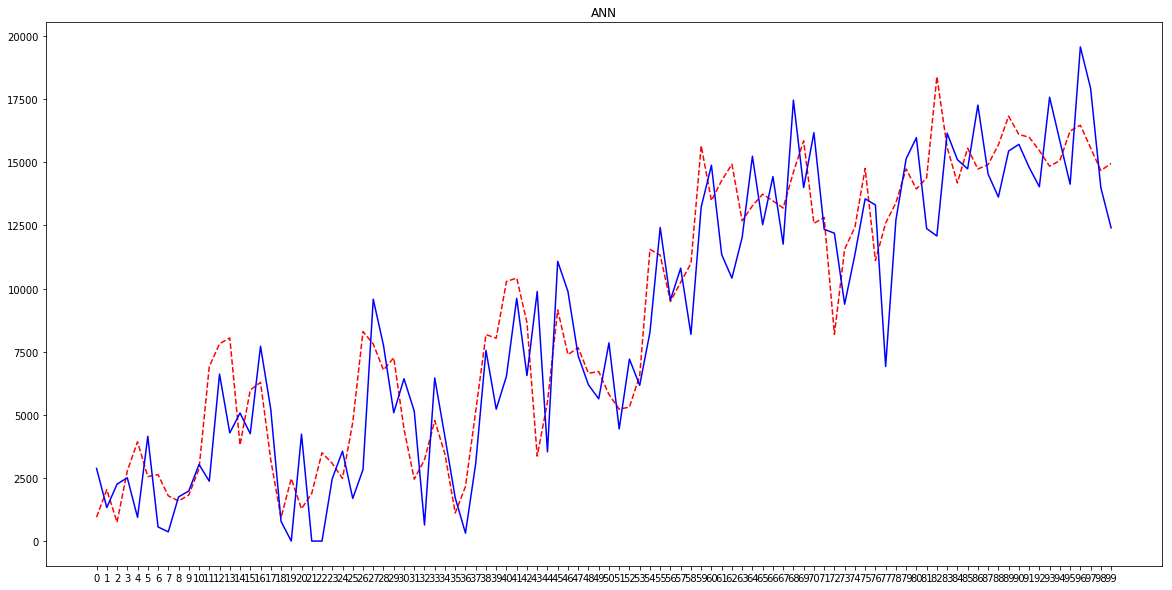

(' Total Time Taken : ', 40.161653995513916)


In [16]:
master_dict= {}
ti = time.time()
activations = ["relu","elu","selu","softplus","linear"]
for i in activations:
    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(d_115,thermal_dict1,1,"mean_squared_error",1,0,i)
    master_dict[i] = thermal_dict1
tf = time.time()
print (" Total Time Taken : ",tf-ti)

In [17]:
print ("Master Dict : \n")
for key,val in master_dict.iteritems():
    print (key," - ",val,"\n\n")

Master Dict : 

('softplus', ' - ', {0: [[0.62024489807174898, 3881.2809173892751, 2752.0558380524117]]}, '\n\n')
('selu', ' - ', {0: [[0.66232802310256367, 3659.9131410539317, 2723.7868670447897]]}, '\n\n')
('linear', ' - ', {0: [[0.65339178339705695, 3708.0253563953383, 2782.6257576615335]]}, '\n\n')
('relu', ' - ', {0: [[0.70235946775094216, 3436.1277720367571, 2440.9856583623377]]}, '\n\n')
('elu', ' - ', {0: [[0.6659511445729962, 3640.2252890584296, 2604.2136256976291]]}, '\n\n')


('\n\n House : ', 1037)
(443, 168)
(443, 1)
(443, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
310/310 [==============================] - 1s - loss: 121755120.0000 - mean_squared_error: 121755120.0000
Epoch 2/750
310/310 [==============================] - 0s - loss: 121681072.0000 - mean_squared_error: 121681072.0000
Epoch 3/750
310/310 [==============================] - 0s - loss: 121613408.0000 - mean_squared_error: 121613408.0000
Epoch 4/750
310/310 [==============================] - 0s - loss: 121548088.0000 - mean_squared_error: 121548088.0000
Epoch 5/750
310/310 [==============================] - 0s - loss: 121482112.0000 - mean_squared_error: 121482112.0000
Epoch 6/750
310/310 [==============================] - 0s - loss: 121415296.0000 - mean_squared_error: 121

310/310 [==============================] - 0s - loss: 47118924.0000 - mean_squared_error: 47118924.0000
Epoch 68/750
310/310 [==============================] - 0s - loss: 44715920.0000 - mean_squared_error: 44715920.0000
Epoch 69/750
310/310 [==============================] - 0s - loss: 42376836.0000 - mean_squared_error: 42376836.0000
Epoch 70/750
310/310 [==============================] - 0s - loss: 40115456.0000 - mean_squared_error: 40115456.0000
Epoch 71/750
310/310 [==============================] - 0s - loss: 37942624.0000 - mean_squared_error: 37942624.0000
Epoch 72/750
310/310 [==============================] - 0s - loss: 35870404.0000 - mean_squared_error: 35870404.0000
Epoch 73/750
310/310 [==============================] - 0s - loss: 33911036.0000 - mean_squared_error: 33911036.0000
Epoch 74/750
310/310 [==============================] - 0s - loss: 32075376.0000 - mean_squared_error: 32075376.0000
Epoch 75/750
310/310 [==============================] - 0s - loss: 30374506.0

310/310 [==============================] - 0s - loss: 18002220.0000 - mean_squared_error: 18002220.0000
Epoch 137/750
310/310 [==============================] - 0s - loss: 17949858.0000 - mean_squared_error: 17949858.0000
Epoch 138/750
310/310 [==============================] - 0s - loss: 17897330.0000 - mean_squared_error: 17897330.0000
Epoch 139/750
310/310 [==============================] - 0s - loss: 17844536.0000 - mean_squared_error: 17844536.0000
Epoch 140/750
310/310 [==============================] - 0s - loss: 17791422.0000 - mean_squared_error: 17791422.0000
Epoch 141/750
310/310 [==============================] - 0s - loss: 17737922.0000 - mean_squared_error: 17737922.0000
Epoch 142/750
310/310 [==============================] - 0s - loss: 17684058.0000 - mean_squared_error: 17684058.0000
Epoch 143/750
310/310 [==============================] - 0s - loss: 17629902.0000 - mean_squared_error: 17629902.0000
Epoch 144/750
310/310 [==============================] - 0s - loss: 17

310/310 [==============================] - 0s - loss: 14217688.0000 - mean_squared_error: 14217688.0000
Epoch 206/750
310/310 [==============================] - 0s - loss: 14157248.0000 - mean_squared_error: 14157248.0000
Epoch 207/750
310/310 [==============================] - 0s - loss: 14097228.0000 - mean_squared_error: 14097228.0000
Epoch 208/750
310/310 [==============================] - 0s - loss: 14037246.0000 - mean_squared_error: 14037246.0000
Epoch 209/750
310/310 [==============================] - 0s - loss: 13977248.0000 - mean_squared_error: 13977248.0000
Epoch 210/750
310/310 [==============================] - 0s - loss: 13917295.0000 - mean_squared_error: 13917295.0000
Epoch 211/750
310/310 [==============================] - 0s - loss: 13857569.0000 - mean_squared_error: 13857569.0000
Epoch 212/750
310/310 [==============================] - 0s - loss: 13797931.0000 - mean_squared_error: 13797931.0000
Epoch 213/750
310/310 [==============================] - 0s - loss: 13

310/310 [==============================] - 0s - loss: 10635427.0000 - mean_squared_error: 10635427.0000
Epoch 275/750
310/310 [==============================] - 0s - loss: 10593466.0000 - mean_squared_error: 10593466.0000
Epoch 276/750
310/310 [==============================] - 0s - loss: 10551628.0000 - mean_squared_error: 10551628.0000
Epoch 277/750
310/310 [==============================] - 0s - loss: 10510499.0000 - mean_squared_error: 10510499.0000
Epoch 278/750
310/310 [==============================] - 0s - loss: 10469564.0000 - mean_squared_error: 10469564.0000
Epoch 279/750
310/310 [==============================] - 0s - loss: 10428706.0000 - mean_squared_error: 10428706.0000
Epoch 280/750
310/310 [==============================] - 0s - loss: 10388129.0000 - mean_squared_error: 10388129.0000
Epoch 281/750
310/310 [==============================] - 0s - loss: 10347512.0000 - mean_squared_error: 10347512.0000
Epoch 282/750
310/310 [==============================] - 0s - loss: 10

310/310 [==============================] - 0s - loss: 8214053.0000 - mean_squared_error: 8214053.0000
Epoch 345/750
310/310 [==============================] - 0s - loss: 8185393.5000 - mean_squared_error: 8185393.5000
Epoch 346/750
310/310 [==============================] - 0s - loss: 8156523.5000 - mean_squared_error: 8156523.5000
Epoch 347/750
310/310 [==============================] - 0s - loss: 8128259.5000 - mean_squared_error: 8128259.5000
Epoch 348/750
310/310 [==============================] - 0s - loss: 8100142.0000 - mean_squared_error: 8100142.0000
Epoch 349/750
310/310 [==============================] - 0s - loss: 8071989.5000 - mean_squared_error: 8071989.5000
Epoch 350/750
310/310 [==============================] - 0s - loss: 8043945.5000 - mean_squared_error: 8043945.5000
Epoch 351/750
310/310 [==============================] - 0s - loss: 8015792.5000 - mean_squared_error: 8015792.5000
Epoch 352/750
310/310 [==============================] - 0s - loss: 7987962.0000 - mea

310/310 [==============================] - 0s - loss: 6415565.0000 - mean_squared_error: 6415565.0000
Epoch 415/750
310/310 [==============================] - 0s - loss: 6391425.0000 - mean_squared_error: 6391425.0000
Epoch 416/750
310/310 [==============================] - 0s - loss: 6367456.0000 - mean_squared_error: 6367456.0000
Epoch 417/750
310/310 [==============================] - 0s - loss: 6343723.0000 - mean_squared_error: 6343723.0000
Epoch 418/750
310/310 [==============================] - 0s - loss: 6319695.5000 - mean_squared_error: 6319695.5000
Epoch 419/750
310/310 [==============================] - 0s - loss: 6296085.5000 - mean_squared_error: 6296085.5000
Epoch 420/750
310/310 [==============================] - 0s - loss: 6272617.0000 - mean_squared_error: 6272617.0000
Epoch 421/750
310/310 [==============================] - 0s - loss: 6248809.5000 - mean_squared_error: 6248809.5000
Epoch 422/750
310/310 [==============================] - 0s - loss: 6224876.5000 - mea

310/310 [==============================] - 0s - loss: 4877564.0000 - mean_squared_error: 4877564.0000
Epoch 485/750
310/310 [==============================] - 0s - loss: 4858660.0000 - mean_squared_error: 4858660.0000
Epoch 486/750
310/310 [==============================] - 0s - loss: 4839103.0000 - mean_squared_error: 4839103.0000
Epoch 487/750
310/310 [==============================] - 0s - loss: 4820116.0000 - mean_squared_error: 4820116.0000
Epoch 488/750
310/310 [==============================] - 0s - loss: 4800952.5000 - mean_squared_error: 4800952.5000
Epoch 489/750
310/310 [==============================] - 0s - loss: 4781916.5000 - mean_squared_error: 4781916.5000
Epoch 490/750
310/310 [==============================] - 0s - loss: 4763072.0000 - mean_squared_error: 4763072.0000
Epoch 491/750
310/310 [==============================] - 0s - loss: 4744310.5000 - mean_squared_error: 4744310.5000
Epoch 492/750
310/310 [==============================] - 0s - loss: 4725491.5000 - mea

310/310 [==============================] - 0s - loss: 3735055.7500 - mean_squared_error: 3735055.7500
Epoch 555/750
310/310 [==============================] - 0s - loss: 3721173.0000 - mean_squared_error: 3721173.0000
Epoch 556/750
310/310 [==============================] - 0s - loss: 3707653.0000 - mean_squared_error: 3707653.0000
Epoch 557/750
310/310 [==============================] - 0s - loss: 3693998.7500 - mean_squared_error: 3693998.7500
Epoch 558/750
310/310 [==============================] - 0s - loss: 3680514.0000 - mean_squared_error: 3680514.0000
Epoch 559/750
310/310 [==============================] - 0s - loss: 3666610.0000 - mean_squared_error: 3666610.0000
Epoch 560/750
310/310 [==============================] - 0s - loss: 3653044.7500 - mean_squared_error: 3653044.7500
Epoch 561/750
310/310 [==============================] - 0s - loss: 3639484.2500 - mean_squared_error: 3639484.2500
Epoch 562/750
310/310 [==============================] - 0s - loss: 3625881.2500 - mea

310/310 [==============================] - 0s - loss: 2903392.0000 - mean_squared_error: 2903392.0000
Epoch 625/750
310/310 [==============================] - 0s - loss: 2893669.5000 - mean_squared_error: 2893669.5000
Epoch 626/750
310/310 [==============================] - 0s - loss: 2883299.7500 - mean_squared_error: 2883299.7500
Epoch 627/750
310/310 [==============================] - 0s - loss: 2875106.0000 - mean_squared_error: 2875106.0000
Epoch 628/750
310/310 [==============================] - 0s - loss: 2863736.2500 - mean_squared_error: 2863736.2500
Epoch 629/750
310/310 [==============================] - 0s - loss: 2854710.5000 - mean_squared_error: 2854710.5000
Epoch 630/750
310/310 [==============================] - 0s - loss: 2844229.7500 - mean_squared_error: 2844229.7500
Epoch 631/750
310/310 [==============================] - 0s - loss: 2835438.5000 - mean_squared_error: 2835438.5000
Epoch 632/750
310/310 [==============================] - 0s - loss: 2824733.0000 - mea

310/310 [==============================] - 0s - loss: 2310274.2500 - mean_squared_error: 2310274.2500
Epoch 695/750
310/310 [==============================] - 0s - loss: 2303060.2500 - mean_squared_error: 2303060.2500
Epoch 696/750
310/310 [==============================] - 0s - loss: 2295641.2500 - mean_squared_error: 2295641.2500
Epoch 697/750
310/310 [==============================] - 0s - loss: 2288192.5000 - mean_squared_error: 2288192.5000
Epoch 698/750
310/310 [==============================] - 0s - loss: 2281603.0000 - mean_squared_error: 2281603.0000
Epoch 699/750
310/310 [==============================] - 0s - loss: 2273985.0000 - mean_squared_error: 2273985.0000
Epoch 700/750
310/310 [==============================] - 0s - loss: 2267364.0000 - mean_squared_error: 2267364.0000
Epoch 701/750
310/310 [==============================] - 0s - loss: 2259470.7500 - mean_squared_error: 2259470.7500
Epoch 702/750
310/310 [==============================] - 0s - loss: 2252969.0000 - mea

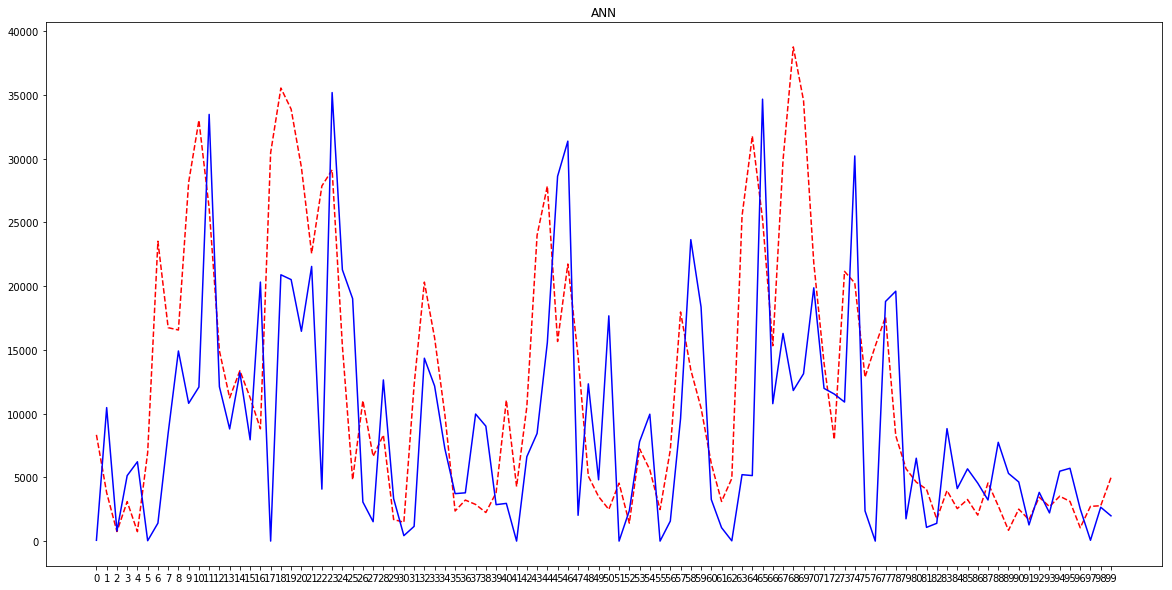

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
310/310 [==============================] - 0s - loss: 121848416.0000 - mean_squared_error: 121848416.0000
Epoch 2/750
310/310 [==============================] - 0s - loss: 121782632.0000 - mean_squared_error: 121782632.0000
Epoch 3/750
310/310 [==============================] - 0s - loss: 121742288.0000 - mean_squared_error: 121742288.0000
Epoch 4/750
310/310 [==============================] - 0s - loss: 121719560.0000 - mean_squared_error: 121719560.0000
Epoch 5/750
310/310 [==============================] - 0s - loss: 121703712.0000 - mean_squared_error: 121703712.0000
Epoch 6/750
310/310 [==============================] - 0s - loss: 121689848.0000 - mean_squared_error: 121689848.0000
Epoch 7/750
310/310 [======================

310/310 [==============================] - 0s - loss: 80919384.0000 - mean_squared_error: 80919384.0000
Epoch 69/750
310/310 [==============================] - 0s - loss: 79018456.0000 - mean_squared_error: 79018456.0000
Epoch 70/750
310/310 [==============================] - 0s - loss: 77080520.0000 - mean_squared_error: 77080520.0000
Epoch 71/750
310/310 [==============================] - 0s - loss: 75108296.0000 - mean_squared_error: 75108296.0000
Epoch 72/750
310/310 [==============================] - 0s - loss: 73104960.0000 - mean_squared_error: 73104960.0000
Epoch 73/750
310/310 [==============================] - 0s - loss: 71073536.0000 - mean_squared_error: 71073536.0000
Epoch 74/750
310/310 [==============================] - 0s - loss: 69015744.0000 - mean_squared_error: 69015744.0000
Epoch 75/750
310/310 [==============================] - 0s - loss: 66932420.0000 - mean_squared_error: 66932420.0000
Epoch 76/750
310/310 [==============================] - 0s - loss: 64823460.0

310/310 [==============================] - 0s - loss: 19558042.0000 - mean_squared_error: 19558042.0000
Epoch 138/750
310/310 [==============================] - 0s - loss: 19512420.0000 - mean_squared_error: 19512420.0000
Epoch 139/750
310/310 [==============================] - 0s - loss: 19469230.0000 - mean_squared_error: 19469230.0000
Epoch 140/750
310/310 [==============================] - 0s - loss: 19427918.0000 - mean_squared_error: 19427918.0000
Epoch 141/750
310/310 [==============================] - 0s - loss: 19388026.0000 - mean_squared_error: 19388026.0000
Epoch 142/750
310/310 [==============================] - 0s - loss: 19349062.0000 - mean_squared_error: 19349062.0000
Epoch 143/750
310/310 [==============================] - 0s - loss: 19310798.0000 - mean_squared_error: 19310798.0000
Epoch 144/750
310/310 [==============================] - 0s - loss: 19273138.0000 - mean_squared_error: 19273138.0000
Epoch 145/750
310/310 [==============================] - 0s - loss: 19

310/310 [==============================] - 0s - loss: 17288952.0000 - mean_squared_error: 17288952.0000
Epoch 207/750
310/310 [==============================] - 0s - loss: 17259762.0000 - mean_squared_error: 17259762.0000
Epoch 208/750
310/310 [==============================] - 0s - loss: 17230570.0000 - mean_squared_error: 17230570.0000
Epoch 209/750
310/310 [==============================] - 0s - loss: 17201374.0000 - mean_squared_error: 17201374.0000
Epoch 210/750
310/310 [==============================] - 0s - loss: 17172182.0000 - mean_squared_error: 17172182.0000
Epoch 211/750
310/310 [==============================] - 0s - loss: 17142988.0000 - mean_squared_error: 17142988.0000
Epoch 212/750
310/310 [==============================] - 0s - loss: 17113784.0000 - mean_squared_error: 17113784.0000
Epoch 213/750
310/310 [==============================] - 0s - loss: 17084580.0000 - mean_squared_error: 17084580.0000
Epoch 214/750
310/310 [==============================] - 0s - loss: 17

310/310 [==============================] - 0s - loss: 15201830.0000 - mean_squared_error: 15201830.0000
Epoch 276/750
310/310 [==============================] - 0s - loss: 15166669.0000 - mean_squared_error: 15166669.0000
Epoch 277/750
310/310 [==============================] - 0s - loss: 15130363.0000 - mean_squared_error: 15130363.0000
Epoch 278/750
310/310 [==============================] - 0s - loss: 15093715.0000 - mean_squared_error: 15093715.0000
Epoch 279/750
310/310 [==============================] - 0s - loss: 15056529.0000 - mean_squared_error: 15056529.0000
Epoch 280/750
310/310 [==============================] - 0s - loss: 15019100.0000 - mean_squared_error: 15019100.0000
Epoch 281/750
310/310 [==============================] - 0s - loss: 14981536.0000 - mean_squared_error: 14981536.0000
Epoch 282/750
310/310 [==============================] - 0s - loss: 14943503.0000 - mean_squared_error: 14943503.0000
Epoch 283/750
310/310 [==============================] - 0s - loss: 14

310/310 [==============================] - 0s - loss: 12469563.0000 - mean_squared_error: 12469563.0000
Epoch 345/750
310/310 [==============================] - 0s - loss: 12432909.0000 - mean_squared_error: 12432909.0000
Epoch 346/750
310/310 [==============================] - 0s - loss: 12396379.0000 - mean_squared_error: 12396379.0000
Epoch 347/750
310/310 [==============================] - 0s - loss: 12359888.0000 - mean_squared_error: 12359888.0000
Epoch 348/750
310/310 [==============================] - 0s - loss: 12323763.0000 - mean_squared_error: 12323763.0000
Epoch 349/750
310/310 [==============================] - 0s - loss: 12287730.0000 - mean_squared_error: 12287730.0000
Epoch 350/750
310/310 [==============================] - 0s - loss: 12251796.0000 - mean_squared_error: 12251796.0000
Epoch 351/750
310/310 [==============================] - 0s - loss: 12216157.0000 - mean_squared_error: 12216157.0000
Epoch 352/750
310/310 [==============================] - 0s - loss: 12

310/310 [==============================] - 0s - loss: 10313068.0000 - mean_squared_error: 10313068.0000
Epoch 414/750
310/310 [==============================] - 0s - loss: 10286135.0000 - mean_squared_error: 10286135.0000
Epoch 415/750
310/310 [==============================] - 0s - loss: 10259303.0000 - mean_squared_error: 10259303.0000
Epoch 416/750
310/310 [==============================] - 0s - loss: 10232536.0000 - mean_squared_error: 10232536.0000
Epoch 417/750
310/310 [==============================] - 0s - loss: 10205813.0000 - mean_squared_error: 10205813.0000
Epoch 418/750
310/310 [==============================] - 0s - loss: 10179185.0000 - mean_squared_error: 10179185.0000
Epoch 419/750
310/310 [==============================] - 0s - loss: 10152626.0000 - mean_squared_error: 10152626.0000
Epoch 420/750
310/310 [==============================] - 0s - loss: 10126172.0000 - mean_squared_error: 10126172.0000
Epoch 421/750
310/310 [==============================] - 0s - loss: 10

310/310 [==============================] - 0s - loss: 8513951.0000 - mean_squared_error: 8513951.0000
Epoch 484/750
310/310 [==============================] - 0s - loss: 8484715.0000 - mean_squared_error: 8484715.0000
Epoch 485/750
310/310 [==============================] - 0s - loss: 8454786.0000 - mean_squared_error: 8454786.0000
Epoch 486/750
310/310 [==============================] - 0s - loss: 8424486.0000 - mean_squared_error: 8424486.0000
Epoch 487/750
310/310 [==============================] - 0s - loss: 8394539.0000 - mean_squared_error: 8394539.0000
Epoch 488/750
310/310 [==============================] - 0s - loss: 8364388.0000 - mean_squared_error: 8364388.0000
Epoch 489/750
310/310 [==============================] - 0s - loss: 8333888.5000 - mean_squared_error: 8333888.5000
Epoch 490/750
310/310 [==============================] - 0s - loss: 8303801.0000 - mean_squared_error: 8303801.0000
Epoch 491/750
310/310 [==============================] - 0s - loss: 8273703.0000 - mea

310/310 [==============================] - 0s - loss: 6317456.5000 - mean_squared_error: 6317456.5000
Epoch 554/750
310/310 [==============================] - 0s - loss: 6288940.5000 - mean_squared_error: 6288940.5000
Epoch 555/750
310/310 [==============================] - 0s - loss: 6260704.0000 - mean_squared_error: 6260704.0000
Epoch 556/750
310/310 [==============================] - 0s - loss: 6232308.0000 - mean_squared_error: 6232308.0000
Epoch 557/750
310/310 [==============================] - 0s - loss: 6204137.5000 - mean_squared_error: 6204137.5000
Epoch 558/750
310/310 [==============================] - 0s - loss: 6176032.0000 - mean_squared_error: 6176032.0000
Epoch 559/750
310/310 [==============================] - 0s - loss: 6148116.0000 - mean_squared_error: 6148116.0000
Epoch 560/750
310/310 [==============================] - 0s - loss: 6120349.5000 - mean_squared_error: 6120349.5000
Epoch 561/750
310/310 [==============================] - 0s - loss: 6092598.5000 - mea

310/310 [==============================] - 0s - loss: 4623239.0000 - mean_squared_error: 4623239.0000
Epoch 624/750
310/310 [==============================] - 0s - loss: 4603106.5000 - mean_squared_error: 4603106.5000
Epoch 625/750
310/310 [==============================] - 0s - loss: 4582835.0000 - mean_squared_error: 4582835.0000
Epoch 626/750
310/310 [==============================] - 0s - loss: 4562685.5000 - mean_squared_error: 4562685.5000
Epoch 627/750
310/310 [==============================] - 0s - loss: 4543460.5000 - mean_squared_error: 4543460.5000
Epoch 628/750
310/310 [==============================] - 0s - loss: 4523134.0000 - mean_squared_error: 4523134.0000
Epoch 629/750
310/310 [==============================] - 0s - loss: 4503875.5000 - mean_squared_error: 4503875.5000
Epoch 630/750
310/310 [==============================] - 0s - loss: 4484177.0000 - mean_squared_error: 4484177.0000
Epoch 631/750
310/310 [==============================] - 0s - loss: 4464573.0000 - mea

310/310 [==============================] - 0s - loss: 3460016.5000 - mean_squared_error: 3460016.5000
Epoch 694/750
310/310 [==============================] - 0s - loss: 3446863.7500 - mean_squared_error: 3446863.7500
Epoch 695/750
310/310 [==============================] - 0s - loss: 3433677.5000 - mean_squared_error: 3433677.5000
Epoch 696/750
310/310 [==============================] - 0s - loss: 3420606.5000 - mean_squared_error: 3420606.5000
Epoch 697/750
310/310 [==============================] - 0s - loss: 3407680.0000 - mean_squared_error: 3407680.0000
Epoch 698/750
310/310 [==============================] - 0s - loss: 3394537.0000 - mean_squared_error: 3394537.0000
Epoch 699/750
310/310 [==============================] - 0s - loss: 3381568.5000 - mean_squared_error: 3381568.5000
Epoch 700/750
310/310 [==============================] - 0s - loss: 3368928.7500 - mean_squared_error: 3368928.7500
Epoch 701/750
310/310 [==============================] - 0s - loss: 3356068.0000 - mea

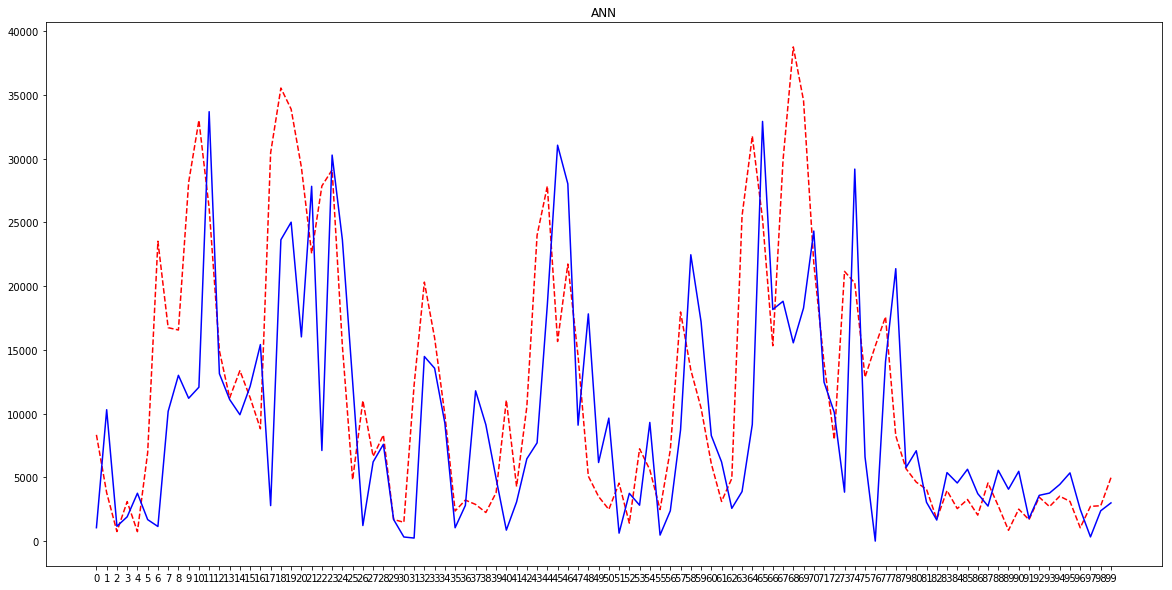

('\n\n House : ', 115)
(1148, 168)
(1148, 1)
(1148, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
803/803 [==============================] - 0s - loss: 72029856.0000 - mean_squared_error: 72029856.0000
Epoch 2/750
803/803 [==============================] - 0s - loss: 72003424.0000 - mean_squared_error: 72003424.0000
Epoch 3/750
803/803 [==============================] - 0s - loss: 71980552.0000 - mean_squared_error: 71980552.0000
Epoch 4/750
803/803 [==============================] - 0s - loss: 71960200.0000 - mean_squared_error: 71960200.0000
Epoch 5/750
803/803 [==============================] - 0s - loss: 71941472.0000 - mean_squared_error: 71941472.0000
Epoch 6/750
803/803 [==============================] - 0s - loss: 71924216.0000 - mean_squared_error: 71924216.000

803/803 [==============================] - 0s - loss: 48198612.0000 - mean_squared_error: 48198612.0000
Epoch 69/750
803/803 [==============================] - 0s - loss: 47136896.0000 - mean_squared_error: 47136896.0000
Epoch 70/750
803/803 [==============================] - 0s - loss: 46053556.0000 - mean_squared_error: 46053556.0000
Epoch 71/750
803/803 [==============================] - 0s - loss: 44964584.0000 - mean_squared_error: 44964584.0000
Epoch 72/750
803/803 [==============================] - 0s - loss: 43865656.0000 - mean_squared_error: 43865656.0000
Epoch 73/750
803/803 [==============================] - 0s - loss: 42759880.0000 - mean_squared_error: 42759880.0000
Epoch 74/750
803/803 [==============================] - 0s - loss: 41650672.0000 - mean_squared_error: 41650672.0000
Epoch 75/750
803/803 [==============================] - 0s - loss: 40541396.0000 - mean_squared_error: 40541396.0000
Epoch 76/750
803/803 [==============================] - 0s - loss: 39435828.0

803/803 [==============================] - 0s - loss: 21738834.0000 - mean_squared_error: 21738834.0000
Epoch 138/750
803/803 [==============================] - 0s - loss: 21679518.0000 - mean_squared_error: 21679518.0000
Epoch 139/750
803/803 [==============================] - 0s - loss: 21619922.0000 - mean_squared_error: 21619922.0000
Epoch 140/750
803/803 [==============================] - 0s - loss: 21559936.0000 - mean_squared_error: 21559936.0000
Epoch 141/750
803/803 [==============================] - 0s - loss: 21499542.0000 - mean_squared_error: 21499542.0000
Epoch 142/750
803/803 [==============================] - 0s - loss: 21439046.0000 - mean_squared_error: 21439046.0000
Epoch 143/750
803/803 [==============================] - 0s - loss: 21378374.0000 - mean_squared_error: 21378374.0000
Epoch 144/750
803/803 [==============================] - 0s - loss: 21317626.0000 - mean_squared_error: 21317626.0000
Epoch 145/750
803/803 [==============================] - 0s - loss: 21

803/803 [==============================] - 0s - loss: 17032462.0000 - mean_squared_error: 17032462.0000
Epoch 207/750
803/803 [==============================] - 0s - loss: 16955182.0000 - mean_squared_error: 16955182.0000
Epoch 208/750
803/803 [==============================] - 0s - loss: 16878066.0000 - mean_squared_error: 16878066.0000
Epoch 209/750
803/803 [==============================] - 0s - loss: 16801072.0000 - mean_squared_error: 16801072.0000
Epoch 210/750
803/803 [==============================] - 0s - loss: 16724166.0000 - mean_squared_error: 16724166.0000
Epoch 211/750
803/803 [==============================] - 0s - loss: 16647548.0000 - mean_squared_error: 16647548.0000
Epoch 212/750
803/803 [==============================] - 0s - loss: 16571298.0000 - mean_squared_error: 16571298.0000
Epoch 213/750
803/803 [==============================] - 0s - loss: 16495218.0000 - mean_squared_error: 16495218.0000
Epoch 214/750
803/803 [==============================] - 0s - loss: 16

803/803 [==============================] - 0s - loss: 12720324.0000 - mean_squared_error: 12720324.0000
Epoch 276/750
803/803 [==============================] - 0s - loss: 12678469.0000 - mean_squared_error: 12678469.0000
Epoch 277/750
803/803 [==============================] - 0s - loss: 12637138.0000 - mean_squared_error: 12637138.0000
Epoch 278/750
803/803 [==============================] - 0s - loss: 12596368.0000 - mean_squared_error: 12596368.0000
Epoch 279/750
803/803 [==============================] - 0s - loss: 12556183.0000 - mean_squared_error: 12556183.0000
Epoch 280/750
803/803 [==============================] - 0s - loss: 12516631.0000 - mean_squared_error: 12516631.0000
Epoch 281/750
803/803 [==============================] - 0s - loss: 12477524.0000 - mean_squared_error: 12477524.0000
Epoch 282/750
803/803 [==============================] - 0s - loss: 12438997.0000 - mean_squared_error: 12438997.0000
Epoch 283/750
803/803 [==============================] - 0s - loss: 12

803/803 [==============================] - 0s - loss: 10739119.0000 - mean_squared_error: 10739119.0000
Epoch 345/750
803/803 [==============================] - 0s - loss: 10719233.0000 - mean_squared_error: 10719233.0000
Epoch 346/750
803/803 [==============================] - 0s - loss: 10699513.0000 - mean_squared_error: 10699513.0000
Epoch 347/750
803/803 [==============================] - 0s - loss: 10679976.0000 - mean_squared_error: 10679976.0000
Epoch 348/750
803/803 [==============================] - 0s - loss: 10660502.0000 - mean_squared_error: 10660502.0000
Epoch 349/750
803/803 [==============================] - 0s - loss: 10641171.0000 - mean_squared_error: 10641171.0000
Epoch 350/750
803/803 [==============================] - 0s - loss: 10621935.0000 - mean_squared_error: 10621935.0000
Epoch 351/750
803/803 [==============================] - 0s - loss: 10602807.0000 - mean_squared_error: 10602807.0000
Epoch 352/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 9503200.0000 - mean_squared_error: 9503200.0000
Epoch 415/750
803/803 [==============================] - 0s - loss: 9487452.0000 - mean_squared_error: 9487452.0000
Epoch 416/750
803/803 [==============================] - 0s - loss: 9471189.0000 - mean_squared_error: 9471189.0000
Epoch 417/750
803/803 [==============================] - 0s - loss: 9455301.0000 - mean_squared_error: 9455301.0000
Epoch 418/750
803/803 [==============================] - 0s - loss: 9439451.0000 - mean_squared_error: 9439451.0000
Epoch 419/750
803/803 [==============================] - 0s - loss: 9423752.0000 - mean_squared_error: 9423752.0000
Epoch 420/750
803/803 [==============================] - 0s - loss: 9408096.0000 - mean_squared_error: 9408096.0000
Epoch 421/750
803/803 [==============================] - 0s - loss: 9392377.0000 - mean_squared_error: 9392377.0000
Epoch 422/750
803/803 [==============================] - 0s - loss: 9376716.0000 - mea

803/803 [==============================] - 0s - loss: 8355944.5000 - mean_squared_error: 8355944.5000
Epoch 485/750
803/803 [==============================] - 0s - loss: 8332160.5000 - mean_squared_error: 8332160.5000
Epoch 486/750
803/803 [==============================] - 0s - loss: 8309352.5000 - mean_squared_error: 8309352.5000
Epoch 487/750
803/803 [==============================] - 0s - loss: 8286276.0000 - mean_squared_error: 8286276.0000
Epoch 488/750
803/803 [==============================] - 0s - loss: 8263215.0000 - mean_squared_error: 8263215.0000
Epoch 489/750
803/803 [==============================] - 0s - loss: 8240017.5000 - mean_squared_error: 8240017.5000
Epoch 490/750
803/803 [==============================] - 0s - loss: 8217942.5000 - mean_squared_error: 8217942.5000
Epoch 491/750
803/803 [==============================] - 0s - loss: 8195406.5000 - mean_squared_error: 8195406.5000
Epoch 492/750
803/803 [==============================] - 0s - loss: 8172277.0000 - mea

803/803 [==============================] - 0s - loss: 6813306.5000 - mean_squared_error: 6813306.5000
Epoch 555/750
803/803 [==============================] - 0s - loss: 6793602.5000 - mean_squared_error: 6793602.5000
Epoch 556/750
803/803 [==============================] - 0s - loss: 6772919.5000 - mean_squared_error: 6772919.5000
Epoch 557/750
803/803 [==============================] - 0s - loss: 6752639.0000 - mean_squared_error: 6752639.0000
Epoch 558/750
803/803 [==============================] - 0s - loss: 6732920.5000 - mean_squared_error: 6732920.5000
Epoch 559/750
803/803 [==============================] - 0s - loss: 6713011.0000 - mean_squared_error: 6713011.0000
Epoch 560/750
803/803 [==============================] - 0s - loss: 6692929.5000 - mean_squared_error: 6692929.5000
Epoch 561/750
803/803 [==============================] - 0s - loss: 6673450.5000 - mean_squared_error: 6673450.5000
Epoch 562/750
803/803 [==============================] - 0s - loss: 6653873.0000 - mea

803/803 [==============================] - 0s - loss: 5544196.0000 - mean_squared_error: 5544196.0000
Epoch 625/750
803/803 [==============================] - 0s - loss: 5527813.0000 - mean_squared_error: 5527813.0000
Epoch 626/750
803/803 [==============================] - 0s - loss: 5511186.0000 - mean_squared_error: 5511186.0000
Epoch 627/750
803/803 [==============================] - 0s - loss: 5496104.0000 - mean_squared_error: 5496104.0000
Epoch 628/750
803/803 [==============================] - 0s - loss: 5479592.5000 - mean_squared_error: 5479592.5000
Epoch 629/750
803/803 [==============================] - 0s - loss: 5463276.0000 - mean_squared_error: 5463276.0000
Epoch 630/750
803/803 [==============================] - 0s - loss: 5448174.0000 - mean_squared_error: 5448174.0000
Epoch 631/750
803/803 [==============================] - 0s - loss: 5432333.5000 - mean_squared_error: 5432333.5000
Epoch 632/750
803/803 [==============================] - 0s - loss: 5416304.0000 - mea

803/803 [==============================] - 0s - loss: 4530043.5000 - mean_squared_error: 4530043.5000
Epoch 695/750
803/803 [==============================] - 0s - loss: 4517597.0000 - mean_squared_error: 4517597.0000
Epoch 696/750
803/803 [==============================] - 0s - loss: 4505378.5000 - mean_squared_error: 4505378.5000
Epoch 697/750
803/803 [==============================] - 0s - loss: 4493115.5000 - mean_squared_error: 4493115.5000
Epoch 698/750
803/803 [==============================] - 0s - loss: 4480940.0000 - mean_squared_error: 4480940.0000
Epoch 699/750
803/803 [==============================] - 0s - loss: 4468657.5000 - mean_squared_error: 4468657.5000
Epoch 700/750
803/803 [==============================] - 0s - loss: 4456304.5000 - mean_squared_error: 4456304.5000
Epoch 701/750
803/803 [==============================] - 0s - loss: 4444350.0000 - mean_squared_error: 4444350.0000
Epoch 702/750
803/803 [==============================] - 0s - loss: 4432181.5000 - mea

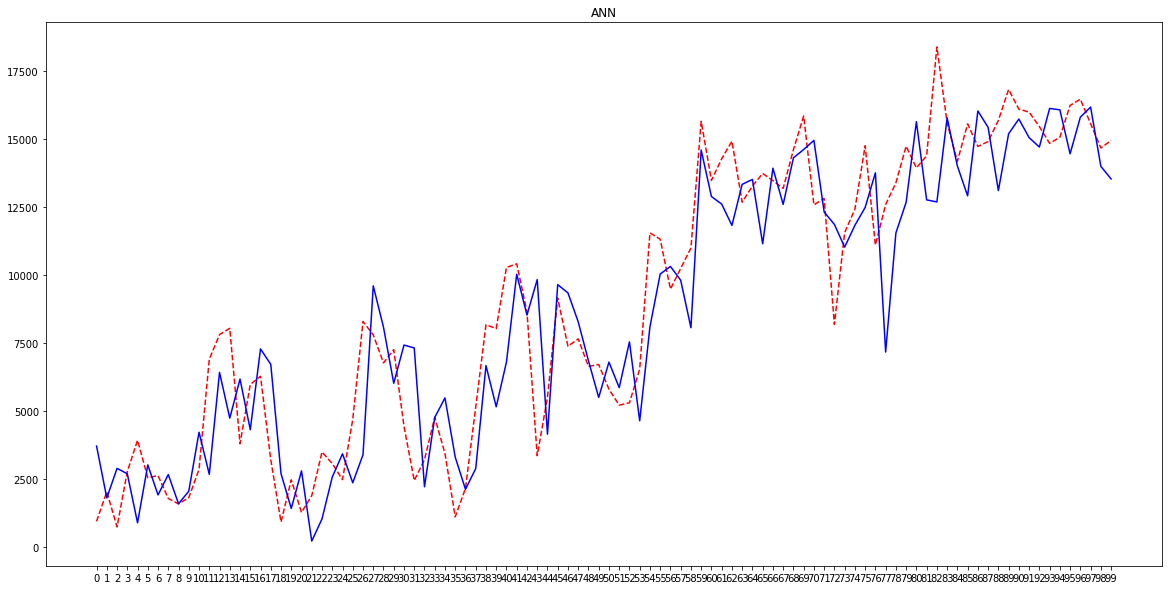

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
803/803 [==============================] - 0s - loss: 72026672.0000 - mean_squared_error: 72026672.0000
Epoch 2/750
803/803 [==============================] - 0s - loss: 72012728.0000 - mean_squared_error: 72012728.0000
Epoch 3/750
803/803 [==============================] - 0s - loss: 72005072.0000 - mean_squared_error: 72005072.0000
Epoch 4/750
803/803 [==============================] - 0s - loss: 72000552.0000 - mean_squared_error: 72000552.0000
Epoch 5/750
803/803 [==============================] - 0s - loss: 71997488.0000 - mean_squared_error: 71997488.0000
Epoch 6/750
803/803 [==============================] - 0s - loss: 71994080.0000 - mean_squared_error: 71994080.0000
Epoch 7/750
803/803 [==============================] - 

803/803 [==============================] - 0s - loss: 61369772.0000 - mean_squared_error: 61369772.0000
Epoch 69/750
803/803 [==============================] - 0s - loss: 60854544.0000 - mean_squared_error: 60854544.0000
Epoch 70/750
803/803 [==============================] - 0s - loss: 60324160.0000 - mean_squared_error: 60324160.0000
Epoch 71/750
803/803 [==============================] - 0s - loss: 59778696.0000 - mean_squared_error: 59778696.0000
Epoch 72/750
803/803 [==============================] - 0s - loss: 59217916.0000 - mean_squared_error: 59217916.0000
Epoch 73/750
803/803 [==============================] - 0s - loss: 58642028.0000 - mean_squared_error: 58642028.0000
Epoch 74/750
803/803 [==============================] - 0s - loss: 58047584.0000 - mean_squared_error: 58047584.0000
Epoch 75/750
803/803 [==============================] - 0s - loss: 57442456.0000 - mean_squared_error: 57442456.0000
Epoch 76/750
803/803 [==============================] - 0s - loss: 56822708.0

803/803 [==============================] - 0s - loss: 23579784.0000 - mean_squared_error: 23579784.0000
Epoch 138/750
803/803 [==============================] - 0s - loss: 23548072.0000 - mean_squared_error: 23548072.0000
Epoch 139/750
803/803 [==============================] - 0s - loss: 23521638.0000 - mean_squared_error: 23521638.0000
Epoch 140/750
803/803 [==============================] - 0s - loss: 23498966.0000 - mean_squared_error: 23498966.0000
Epoch 141/750
803/803 [==============================] - 0s - loss: 23478764.0000 - mean_squared_error: 23478764.0000
Epoch 142/750
803/803 [==============================] - 0s - loss: 23459886.0000 - mean_squared_error: 23459886.0000
Epoch 143/750
803/803 [==============================] - 0s - loss: 23441372.0000 - mean_squared_error: 23441372.0000
Epoch 144/750
803/803 [==============================] - 0s - loss: 23422466.0000 - mean_squared_error: 23422466.0000
Epoch 145/750
803/803 [==============================] - 0s - loss: 23

803/803 [==============================] - 0s - loss: 21505594.0000 - mean_squared_error: 21505594.0000
Epoch 207/750
803/803 [==============================] - 0s - loss: 21473098.0000 - mean_squared_error: 21473098.0000
Epoch 208/750
803/803 [==============================] - 0s - loss: 21440224.0000 - mean_squared_error: 21440224.0000
Epoch 209/750
803/803 [==============================] - 0s - loss: 21406838.0000 - mean_squared_error: 21406838.0000
Epoch 210/750
803/803 [==============================] - 0s - loss: 21372632.0000 - mean_squared_error: 21372632.0000
Epoch 211/750
803/803 [==============================] - 0s - loss: 21337114.0000 - mean_squared_error: 21337114.0000
Epoch 212/750
803/803 [==============================] - 0s - loss: 21302090.0000 - mean_squared_error: 21302090.0000
Epoch 213/750
803/803 [==============================] - 0s - loss: 21267704.0000 - mean_squared_error: 21267704.0000
Epoch 214/750
803/803 [==============================] - 0s - loss: 21

803/803 [==============================] - 0s - loss: 18159100.0000 - mean_squared_error: 18159100.0000
Epoch 276/750
803/803 [==============================] - 0s - loss: 18099372.0000 - mean_squared_error: 18099372.0000
Epoch 277/750
803/803 [==============================] - 0s - loss: 18039690.0000 - mean_squared_error: 18039690.0000
Epoch 278/750
803/803 [==============================] - 0s - loss: 17980048.0000 - mean_squared_error: 17980048.0000
Epoch 279/750
803/803 [==============================] - 0s - loss: 17920382.0000 - mean_squared_error: 17920382.0000
Epoch 280/750
803/803 [==============================] - 0s - loss: 17860780.0000 - mean_squared_error: 17860780.0000
Epoch 281/750
803/803 [==============================] - 0s - loss: 17801218.0000 - mean_squared_error: 17801218.0000
Epoch 282/750
803/803 [==============================] - 0s - loss: 17741732.0000 - mean_squared_error: 17741732.0000
Epoch 283/750
803/803 [==============================] - 0s - loss: 17

803/803 [==============================] - 0s - loss: 14450976.0000 - mean_squared_error: 14450976.0000
Epoch 345/750
803/803 [==============================] - 0s - loss: 14408278.0000 - mean_squared_error: 14408278.0000
Epoch 346/750
803/803 [==============================] - 0s - loss: 14365830.0000 - mean_squared_error: 14365830.0000
Epoch 347/750
803/803 [==============================] - 0s - loss: 14323650.0000 - mean_squared_error: 14323650.0000
Epoch 348/750
803/803 [==============================] - 0s - loss: 14281775.0000 - mean_squared_error: 14281775.0000
Epoch 349/750
803/803 [==============================] - 0s - loss: 14240558.0000 - mean_squared_error: 14240558.0000
Epoch 350/750
803/803 [==============================] - 0s - loss: 14199887.0000 - mean_squared_error: 14199887.0000
Epoch 351/750
803/803 [==============================] - 0s - loss: 14159532.0000 - mean_squared_error: 14159532.0000
Epoch 352/750
803/803 [==============================] - 0s - loss: 14

803/803 [==============================] - 0s - loss: 12321276.0000 - mean_squared_error: 12321276.0000
Epoch 414/750
803/803 [==============================] - 0s - loss: 12300636.0000 - mean_squared_error: 12300636.0000
Epoch 415/750
803/803 [==============================] - 0s - loss: 12280192.0000 - mean_squared_error: 12280192.0000
Epoch 416/750
803/803 [==============================] - 0s - loss: 12259920.0000 - mean_squared_error: 12259920.0000
Epoch 417/750
803/803 [==============================] - 0s - loss: 12239949.0000 - mean_squared_error: 12239949.0000
Epoch 418/750
803/803 [==============================] - 0s - loss: 12220197.0000 - mean_squared_error: 12220197.0000
Epoch 419/750
803/803 [==============================] - 0s - loss: 12200616.0000 - mean_squared_error: 12200616.0000
Epoch 420/750
803/803 [==============================] - 0s - loss: 12181231.0000 - mean_squared_error: 12181231.0000
Epoch 421/750
803/803 [==============================] - 0s - loss: 12

803/803 [==============================] - 0s - loss: 11248779.0000 - mean_squared_error: 11248779.0000
Epoch 483/750
803/803 [==============================] - 0s - loss: 11235946.0000 - mean_squared_error: 11235946.0000
Epoch 484/750
803/803 [==============================] - 0s - loss: 11222856.0000 - mean_squared_error: 11222856.0000
Epoch 485/750
803/803 [==============================] - 0s - loss: 11209504.0000 - mean_squared_error: 11209504.0000
Epoch 486/750
803/803 [==============================] - 0s - loss: 11195996.0000 - mean_squared_error: 11195996.0000
Epoch 487/750
803/803 [==============================] - 0s - loss: 11182496.0000 - mean_squared_error: 11182496.0000
Epoch 488/750
803/803 [==============================] - 0s - loss: 11168999.0000 - mean_squared_error: 11168999.0000
Epoch 489/750
803/803 [==============================] - 0s - loss: 11155219.0000 - mean_squared_error: 11155219.0000
Epoch 490/750
803/803 [==============================] - 0s - loss: 11

803/803 [==============================] - 0s - loss: 10297815.0000 - mean_squared_error: 10297815.0000
Epoch 552/750
803/803 [==============================] - 0s - loss: 10284577.0000 - mean_squared_error: 10284577.0000
Epoch 553/750
803/803 [==============================] - 0s - loss: 10271274.0000 - mean_squared_error: 10271274.0000
Epoch 554/750
803/803 [==============================] - 0s - loss: 10258108.0000 - mean_squared_error: 10258108.0000
Epoch 555/750
803/803 [==============================] - 0s - loss: 10244929.0000 - mean_squared_error: 10244929.0000
Epoch 556/750
803/803 [==============================] - 0s - loss: 10231621.0000 - mean_squared_error: 10231621.0000
Epoch 557/750
803/803 [==============================] - 0s - loss: 10218382.0000 - mean_squared_error: 10218382.0000
Epoch 558/750
803/803 [==============================] - 0s - loss: 10205055.0000 - mean_squared_error: 10205055.0000
Epoch 559/750
803/803 [==============================] - 0s - loss: 10

803/803 [==============================] - 0s - loss: 9371634.0000 - mean_squared_error: 9371634.0000
Epoch 622/750
803/803 [==============================] - 0s - loss: 9358290.0000 - mean_squared_error: 9358290.0000
Epoch 623/750
803/803 [==============================] - 0s - loss: 9344444.0000 - mean_squared_error: 9344444.0000
Epoch 624/750
803/803 [==============================] - 0s - loss: 9331021.0000 - mean_squared_error: 9331021.0000
Epoch 625/750
803/803 [==============================] - 0s - loss: 9317285.0000 - mean_squared_error: 9317285.0000
Epoch 626/750
803/803 [==============================] - 0s - loss: 9303488.0000 - mean_squared_error: 9303488.0000
Epoch 627/750
803/803 [==============================] - 0s - loss: 9289629.0000 - mean_squared_error: 9289629.0000
Epoch 628/750
803/803 [==============================] - 0s - loss: 9276023.0000 - mean_squared_error: 9276023.0000
Epoch 629/750
803/803 [==============================] - 0s - loss: 9262153.0000 - mea

803/803 [==============================] - 0s - loss: 8328899.5000 - mean_squared_error: 8328899.5000
Epoch 692/750
803/803 [==============================] - 0s - loss: 8314523.5000 - mean_squared_error: 8314523.5000
Epoch 693/750
803/803 [==============================] - 0s - loss: 8299691.5000 - mean_squared_error: 8299691.5000
Epoch 694/750
803/803 [==============================] - 0s - loss: 8285160.0000 - mean_squared_error: 8285160.0000
Epoch 695/750
803/803 [==============================] - 0s - loss: 8270802.0000 - mean_squared_error: 8270802.0000
Epoch 696/750
803/803 [==============================] - 0s - loss: 8256517.5000 - mean_squared_error: 8256517.5000
Epoch 697/750
803/803 [==============================] - 0s - loss: 8242336.0000 - mean_squared_error: 8242336.0000
Epoch 698/750
803/803 [==============================] - 0s - loss: 8228224.0000 - mean_squared_error: 8228224.0000
Epoch 699/750
803/803 [==============================] - 0s - loss: 8213949.5000 - mea

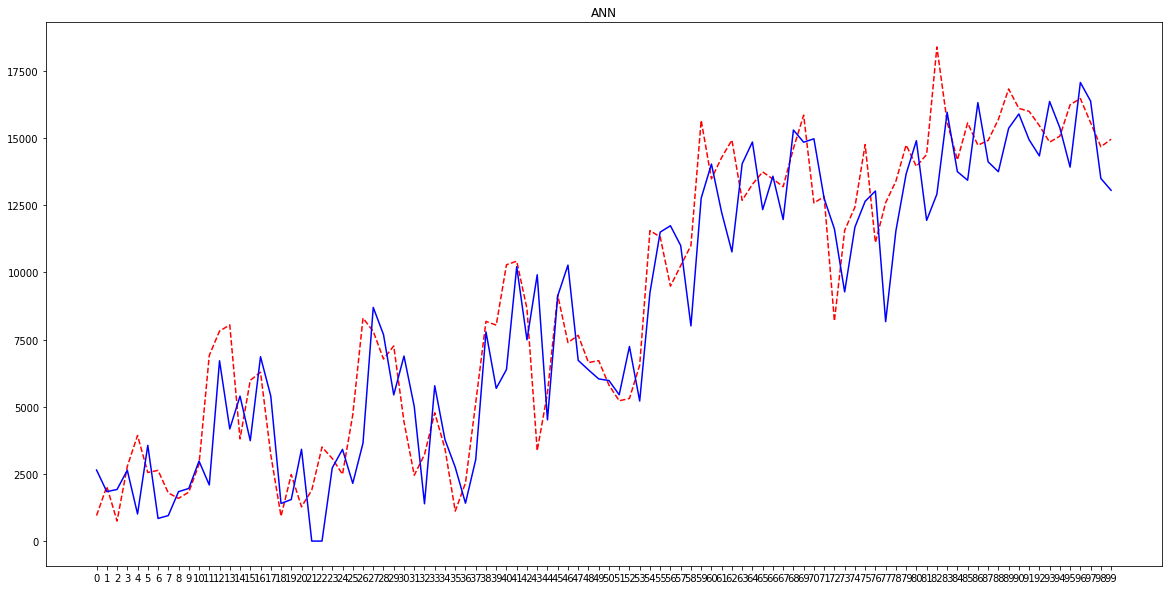

('\n\n House : ', 2401)
(1224, 168)
(1224, 1)
(1224, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
856/856 [==============================] - 0s - loss: 119489472.0000 - mean_squared_error: 119489472.0000
Epoch 2/750
856/856 [==============================] - 0s - loss: 119428944.0000 - mean_squared_error: 119428944.0000
Epoch 3/750
856/856 [==============================] - 0s - loss: 119374080.0000 - mean_squared_error: 119374080.0000
Epoch 4/750
856/856 [==============================] - 0s - loss: 119319320.0000 - mean_squared_error: 119319320.0000
Epoch 5/750
856/856 [==============================] - 0s - loss: 119261424.0000 - mean_squared_error: 119261424.0000
Epoch 6/750
856/856 [==============================] - 0s - loss: 119199872.0000 - mean_squared_error: 

856/856 [==============================] - 0s - loss: 72379392.0000 - mean_squared_error: 72379392.0000
Epoch 68/750
856/856 [==============================] - 0s - loss: 70428728.0000 - mean_squared_error: 70428728.0000
Epoch 69/750
856/856 [==============================] - 0s - loss: 68465392.0000 - mean_squared_error: 68465392.0000
Epoch 70/750
856/856 [==============================] - 0s - loss: 66493796.0000 - mean_squared_error: 66493796.0000
Epoch 71/750
856/856 [==============================] - 0s - loss: 64506760.0000 - mean_squared_error: 64506760.0000
Epoch 72/750
856/856 [==============================] - 0s - loss: 62537884.0000 - mean_squared_error: 62537884.0000
Epoch 73/750
856/856 [==============================] - 0s - loss: 60580744.0000 - mean_squared_error: 60580744.0000
Epoch 74/750
856/856 [==============================] - 0s - loss: 58642484.0000 - mean_squared_error: 58642484.0000
Epoch 75/750
856/856 [==============================] - 0s - loss: 56730432.0

856/856 [==============================] - 0s - loss: 33175886.0000 - mean_squared_error: 33175886.0000
Epoch 137/750
856/856 [==============================] - 0s - loss: 33113136.0000 - mean_squared_error: 33113136.0000
Epoch 138/750
856/856 [==============================] - 0s - loss: 33049352.0000 - mean_squared_error: 33049352.0000
Epoch 139/750
856/856 [==============================] - 0s - loss: 32984892.0000 - mean_squared_error: 32984892.0000
Epoch 140/750
856/856 [==============================] - 0s - loss: 32920190.0000 - mean_squared_error: 32920190.0000
Epoch 141/750
856/856 [==============================] - 0s - loss: 32855410.0000 - mean_squared_error: 32855410.0000
Epoch 142/750
856/856 [==============================] - 0s - loss: 32790398.0000 - mean_squared_error: 32790398.0000
Epoch 143/750
856/856 [==============================] - 0s - loss: 32725562.0000 - mean_squared_error: 32725562.0000
Epoch 144/750
856/856 [==============================] - 0s - loss: 32

856/856 [==============================] - 0s - loss: 28597188.0000 - mean_squared_error: 28597188.0000
Epoch 206/750
856/856 [==============================] - 0s - loss: 28521712.0000 - mean_squared_error: 28521712.0000
Epoch 207/750
856/856 [==============================] - 0s - loss: 28444452.0000 - mean_squared_error: 28444452.0000
Epoch 208/750
856/856 [==============================] - 0s - loss: 28366216.0000 - mean_squared_error: 28366216.0000
Epoch 209/750
856/856 [==============================] - 0s - loss: 28287040.0000 - mean_squared_error: 28287040.0000
Epoch 210/750
856/856 [==============================] - 0s - loss: 28206274.0000 - mean_squared_error: 28206274.0000
Epoch 211/750
856/856 [==============================] - 0s - loss: 28124734.0000 - mean_squared_error: 28124734.0000
Epoch 212/750
856/856 [==============================] - 0s - loss: 28041556.0000 - mean_squared_error: 28041556.0000
Epoch 213/750
856/856 [==============================] - 0s - loss: 27

856/856 [==============================] - 0s - loss: 22563242.0000 - mean_squared_error: 22563242.0000
Epoch 275/750
856/856 [==============================] - 0s - loss: 22487006.0000 - mean_squared_error: 22487006.0000
Epoch 276/750
856/856 [==============================] - 0s - loss: 22411272.0000 - mean_squared_error: 22411272.0000
Epoch 277/750
856/856 [==============================] - 0s - loss: 22336204.0000 - mean_squared_error: 22336204.0000
Epoch 278/750
856/856 [==============================] - 0s - loss: 22261684.0000 - mean_squared_error: 22261684.0000
Epoch 279/750
856/856 [==============================] - 0s - loss: 22187848.0000 - mean_squared_error: 22187848.0000
Epoch 280/750
856/856 [==============================] - 0s - loss: 22114802.0000 - mean_squared_error: 22114802.0000
Epoch 281/750
856/856 [==============================] - 0s - loss: 22042270.0000 - mean_squared_error: 22042270.0000
Epoch 282/750
856/856 [==============================] - 0s - loss: 21

856/856 [==============================] - 0s - loss: 18402788.0000 - mean_squared_error: 18402788.0000
Epoch 344/750
856/856 [==============================] - 0s - loss: 18353936.0000 - mean_squared_error: 18353936.0000
Epoch 345/750
856/856 [==============================] - 0s - loss: 18305500.0000 - mean_squared_error: 18305500.0000
Epoch 346/750
856/856 [==============================] - 0s - loss: 18256764.0000 - mean_squared_error: 18256764.0000
Epoch 347/750
856/856 [==============================] - 0s - loss: 18208758.0000 - mean_squared_error: 18208758.0000
Epoch 348/750
856/856 [==============================] - 0s - loss: 18160968.0000 - mean_squared_error: 18160968.0000
Epoch 349/750
856/856 [==============================] - 0s - loss: 18113064.0000 - mean_squared_error: 18113064.0000
Epoch 350/750
856/856 [==============================] - 0s - loss: 18065942.0000 - mean_squared_error: 18065942.0000
Epoch 351/750
856/856 [==============================] - 0s - loss: 18

856/856 [==============================] - 0s - loss: 15436476.0000 - mean_squared_error: 15436476.0000
Epoch 413/750
856/856 [==============================] - 0s - loss: 15397480.0000 - mean_squared_error: 15397480.0000
Epoch 414/750
856/856 [==============================] - 0s - loss: 15358148.0000 - mean_squared_error: 15358148.0000
Epoch 415/750
856/856 [==============================] - 0s - loss: 15318636.0000 - mean_squared_error: 15318636.0000
Epoch 416/750
856/856 [==============================] - 0s - loss: 15279158.0000 - mean_squared_error: 15279158.0000
Epoch 417/750
856/856 [==============================] - 0s - loss: 15239553.0000 - mean_squared_error: 15239553.0000
Epoch 418/750
856/856 [==============================] - 0s - loss: 15200297.0000 - mean_squared_error: 15200297.0000
Epoch 419/750
856/856 [==============================] - 0s - loss: 15160906.0000 - mean_squared_error: 15160906.0000
Epoch 420/750
856/856 [==============================] - 0s - loss: 15

856/856 [==============================] - 0s - loss: 12742601.0000 - mean_squared_error: 12742601.0000
Epoch 482/750
856/856 [==============================] - 0s - loss: 12703160.0000 - mean_squared_error: 12703160.0000
Epoch 483/750
856/856 [==============================] - 0s - loss: 12663047.0000 - mean_squared_error: 12663047.0000
Epoch 484/750
856/856 [==============================] - 0s - loss: 12624348.0000 - mean_squared_error: 12624348.0000
Epoch 485/750
856/856 [==============================] - 0s - loss: 12585072.0000 - mean_squared_error: 12585072.0000
Epoch 486/750
856/856 [==============================] - 0s - loss: 12545436.0000 - mean_squared_error: 12545436.0000
Epoch 487/750
856/856 [==============================] - 0s - loss: 12506836.0000 - mean_squared_error: 12506836.0000
Epoch 488/750
856/856 [==============================] - 0s - loss: 12466221.0000 - mean_squared_error: 12466221.0000
Epoch 489/750
856/856 [==============================] - 0s - loss: 12

856/856 [==============================] - 0s - loss: 10035188.0000 - mean_squared_error: 10035188.0000
Epoch 551/750
856/856 [==============================] - 0s - loss: 9998155.0000 - mean_squared_error: 9998155.0000
Epoch 552/750
856/856 [==============================] - 0s - loss: 9962388.0000 - mean_squared_error: 9962388.0000
Epoch 553/750
856/856 [==============================] - 0s - loss: 9925508.0000 - mean_squared_error: 9925508.0000
Epoch 554/750
856/856 [==============================] - 0s - loss: 9889145.0000 - mean_squared_error: 9889145.0000
Epoch 555/750
856/856 [==============================] - 0s - loss: 9852873.0000 - mean_squared_error: 9852873.0000
Epoch 556/750
856/856 [==============================] - 0s - loss: 9816008.0000 - mean_squared_error: 9816008.0000
Epoch 557/750
856/856 [==============================] - 0s - loss: 9779815.0000 - mean_squared_error: 9779815.0000
Epoch 558/750
856/856 [==============================] - 0s - loss: 9743718.0000 - m

856/856 [==============================] - 0s - loss: 7725257.5000 - mean_squared_error: 7725257.5000
Epoch 621/750
856/856 [==============================] - 0s - loss: 7697070.5000 - mean_squared_error: 7697070.5000
Epoch 622/750
856/856 [==============================] - 0s - loss: 7667912.0000 - mean_squared_error: 7667912.0000
Epoch 623/750
856/856 [==============================] - 0s - loss: 7640114.0000 - mean_squared_error: 7640114.0000
Epoch 624/750
856/856 [==============================] - 0s - loss: 7610901.5000 - mean_squared_error: 7610901.5000
Epoch 625/750
856/856 [==============================] - 0s - loss: 7582534.0000 - mean_squared_error: 7582534.0000
Epoch 626/750
856/856 [==============================] - 0s - loss: 7554633.0000 - mean_squared_error: 7554633.0000
Epoch 627/750
856/856 [==============================] - 0s - loss: 7526351.5000 - mean_squared_error: 7526351.5000
Epoch 628/750
856/856 [==============================] - 0s - loss: 7498761.5000 - mea

856/856 [==============================] - 0s - loss: 6007951.5000 - mean_squared_error: 6007951.5000
Epoch 691/750
856/856 [==============================] - 0s - loss: 5988348.0000 - mean_squared_error: 5988348.0000
Epoch 692/750
856/856 [==============================] - 0s - loss: 5967890.0000 - mean_squared_error: 5967890.0000
Epoch 693/750
856/856 [==============================] - 0s - loss: 5948316.5000 - mean_squared_error: 5948316.5000
Epoch 694/750
856/856 [==============================] - 0s - loss: 5928537.0000 - mean_squared_error: 5928537.0000
Epoch 695/750
856/856 [==============================] - 0s - loss: 5908909.0000 - mean_squared_error: 5908909.0000
Epoch 696/750
856/856 [==============================] - 0s - loss: 5889652.5000 - mean_squared_error: 5889652.5000
Epoch 697/750
856/856 [==============================] - 0s - loss: 5869612.5000 - mean_squared_error: 5869612.5000
Epoch 698/750
856/856 [==============================] - 0s - loss: 5850212.5000 - mea

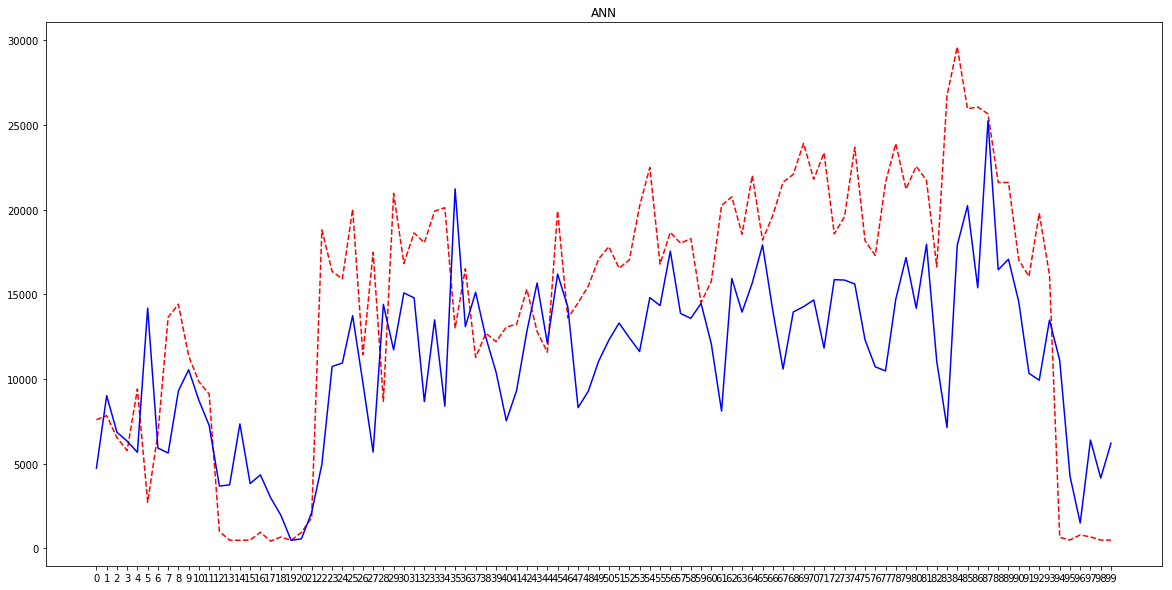

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
856/856 [==============================] - 0s - loss: 119559560.0000 - mean_squared_error: 119559560.0000
Epoch 2/750
856/856 [==============================] - 0s - loss: 119497720.0000 - mean_squared_error: 119497720.0000
Epoch 3/750
856/856 [==============================] - 0s - loss: 119444592.0000 - mean_squared_error: 119444592.0000
Epoch 4/750
856/856 [==============================] - 0s - loss: 119400904.0000 - mean_squared_error: 119400904.0000
Epoch 5/750
856/856 [==============================] - 0s - loss: 119360104.0000 - mean_squared_error: 119360104.0000
Epoch 6/750
856/856 [==============================] - 0s - loss: 119318352.0000 - mean_squared_error: 119318352.0000
Epoch 7/750
856/856 [======================

856/856 [==============================] - 0s - loss: 96233088.0000 - mean_squared_error: 96233088.0000
Epoch 68/750
856/856 [==============================] - 0s - loss: 95256416.0000 - mean_squared_error: 95256416.0000
Epoch 69/750
856/856 [==============================] - 0s - loss: 94256064.0000 - mean_squared_error: 94256064.0000
Epoch 70/750
856/856 [==============================] - 0s - loss: 93232280.0000 - mean_squared_error: 93232280.0000
Epoch 71/750
856/856 [==============================] - 0s - loss: 92185400.0000 - mean_squared_error: 92185400.0000
Epoch 72/750
856/856 [==============================] - 0s - loss: 91115696.0000 - mean_squared_error: 91115696.0000
Epoch 73/750
856/856 [==============================] - 0s - loss: 90023688.0000 - mean_squared_error: 90023688.0000
Epoch 74/750
856/856 [==============================] - 0s - loss: 88910472.0000 - mean_squared_error: 88910472.0000
Epoch 75/750
856/856 [==============================] - 0s - loss: 87776024.0

856/856 [==============================] - 0s - loss: 34691196.0000 - mean_squared_error: 34691196.0000
Epoch 137/750
856/856 [==============================] - 0s - loss: 34668132.0000 - mean_squared_error: 34668132.0000
Epoch 138/750
856/856 [==============================] - 0s - loss: 34648496.0000 - mean_squared_error: 34648496.0000
Epoch 139/750
856/856 [==============================] - 0s - loss: 34630464.0000 - mean_squared_error: 34630464.0000
Epoch 140/750
856/856 [==============================] - 0s - loss: 34612460.0000 - mean_squared_error: 34612460.0000
Epoch 141/750
856/856 [==============================] - 0s - loss: 34593260.0000 - mean_squared_error: 34593260.0000
Epoch 142/750
856/856 [==============================] - 0s - loss: 34571944.0000 - mean_squared_error: 34571944.0000
Epoch 143/750
856/856 [==============================] - 0s - loss: 34547880.0000 - mean_squared_error: 34547880.0000
Epoch 144/750
856/856 [==============================] - 0s - loss: 34

856/856 [==============================] - 0s - loss: 31959404.0000 - mean_squared_error: 31959404.0000
Epoch 206/750
856/856 [==============================] - 0s - loss: 31917368.0000 - mean_squared_error: 31917368.0000
Epoch 207/750
856/856 [==============================] - 0s - loss: 31875292.0000 - mean_squared_error: 31875292.0000
Epoch 208/750
856/856 [==============================] - 0s - loss: 31833178.0000 - mean_squared_error: 31833178.0000
Epoch 209/750
856/856 [==============================] - 0s - loss: 31791014.0000 - mean_squared_error: 31791014.0000
Epoch 210/750
856/856 [==============================] - 0s - loss: 31748816.0000 - mean_squared_error: 31748816.0000
Epoch 211/750
856/856 [==============================] - 0s - loss: 31706574.0000 - mean_squared_error: 31706574.0000
Epoch 212/750
856/856 [==============================] - 0s - loss: 31664288.0000 - mean_squared_error: 31664288.0000
Epoch 213/750
856/856 [==============================] - 0s - loss: 31

856/856 [==============================] - 0s - loss: 28905248.0000 - mean_squared_error: 28905248.0000
Epoch 275/750
856/856 [==============================] - 0s - loss: 28852166.0000 - mean_squared_error: 28852166.0000
Epoch 276/750
856/856 [==============================] - 0s - loss: 28799110.0000 - mean_squared_error: 28799110.0000
Epoch 277/750
856/856 [==============================] - 0s - loss: 28745910.0000 - mean_squared_error: 28745910.0000
Epoch 278/750
856/856 [==============================] - 0s - loss: 28692686.0000 - mean_squared_error: 28692686.0000
Epoch 279/750
856/856 [==============================] - 0s - loss: 28639600.0000 - mean_squared_error: 28639600.0000
Epoch 280/750
856/856 [==============================] - 0s - loss: 28586518.0000 - mean_squared_error: 28586518.0000
Epoch 281/750
856/856 [==============================] - 0s - loss: 28533262.0000 - mean_squared_error: 28533262.0000
Epoch 282/750
856/856 [==============================] - 0s - loss: 28

856/856 [==============================] - 0s - loss: 25079458.0000 - mean_squared_error: 25079458.0000
Epoch 344/750
856/856 [==============================] - 0s - loss: 25025748.0000 - mean_squared_error: 25025748.0000
Epoch 345/750
856/856 [==============================] - 0s - loss: 24972286.0000 - mean_squared_error: 24972286.0000
Epoch 346/750
856/856 [==============================] - 0s - loss: 24919112.0000 - mean_squared_error: 24919112.0000
Epoch 347/750
856/856 [==============================] - 0s - loss: 24866248.0000 - mean_squared_error: 24866248.0000
Epoch 348/750
856/856 [==============================] - 0s - loss: 24813678.0000 - mean_squared_error: 24813678.0000
Epoch 349/750
856/856 [==============================] - 0s - loss: 24761422.0000 - mean_squared_error: 24761422.0000
Epoch 350/750
856/856 [==============================] - 0s - loss: 24709464.0000 - mean_squared_error: 24709464.0000
Epoch 351/750
856/856 [==============================] - 0s - loss: 24

856/856 [==============================] - 0s - loss: 22091140.0000 - mean_squared_error: 22091140.0000
Epoch 413/750
856/856 [==============================] - 0s - loss: 22057656.0000 - mean_squared_error: 22057656.0000
Epoch 414/750
856/856 [==============================] - 0s - loss: 22024392.0000 - mean_squared_error: 22024392.0000
Epoch 415/750
856/856 [==============================] - 0s - loss: 21991404.0000 - mean_squared_error: 21991404.0000
Epoch 416/750
856/856 [==============================] - 0s - loss: 21958652.0000 - mean_squared_error: 21958652.0000
Epoch 417/750
856/856 [==============================] - 0s - loss: 21926084.0000 - mean_squared_error: 21926084.0000
Epoch 418/750
856/856 [==============================] - 0s - loss: 21893722.0000 - mean_squared_error: 21893722.0000
Epoch 419/750
856/856 [==============================] - 0s - loss: 21861606.0000 - mean_squared_error: 21861606.0000
Epoch 420/750
856/856 [==============================] - 0s - loss: 21

856/856 [==============================] - 0s - loss: 20229898.0000 - mean_squared_error: 20229898.0000
Epoch 482/750
856/856 [==============================] - 0s - loss: 20208234.0000 - mean_squared_error: 20208234.0000
Epoch 483/750
856/856 [==============================] - 0s - loss: 20186734.0000 - mean_squared_error: 20186734.0000
Epoch 484/750
856/856 [==============================] - 0s - loss: 20165286.0000 - mean_squared_error: 20165286.0000
Epoch 485/750
856/856 [==============================] - 0s - loss: 20143942.0000 - mean_squared_error: 20143942.0000
Epoch 486/750
856/856 [==============================] - 0s - loss: 20122814.0000 - mean_squared_error: 20122814.0000
Epoch 487/750
856/856 [==============================] - 0s - loss: 20101754.0000 - mean_squared_error: 20101754.0000
Epoch 488/750
856/856 [==============================] - 0s - loss: 20080770.0000 - mean_squared_error: 20080770.0000
Epoch 489/750
856/856 [==============================] - 0s - loss: 20

856/856 [==============================] - 0s - loss: 18978046.0000 - mean_squared_error: 18978046.0000
Epoch 551/750
856/856 [==============================] - 0s - loss: 18962540.0000 - mean_squared_error: 18962540.0000
Epoch 552/750
856/856 [==============================] - 0s - loss: 18947080.0000 - mean_squared_error: 18947080.0000
Epoch 553/750
856/856 [==============================] - 0s - loss: 18931514.0000 - mean_squared_error: 18931514.0000
Epoch 554/750
856/856 [==============================] - 0s - loss: 18916014.0000 - mean_squared_error: 18916014.0000
Epoch 555/750
856/856 [==============================] - 0s - loss: 18900490.0000 - mean_squared_error: 18900490.0000
Epoch 556/750
856/856 [==============================] - 0s - loss: 18884858.0000 - mean_squared_error: 18884858.0000
Epoch 557/750
856/856 [==============================] - 0s - loss: 18869122.0000 - mean_squared_error: 18869122.0000
Epoch 558/750
856/856 [==============================] - 0s - loss: 18

856/856 [==============================] - 0s - loss: 17874064.0000 - mean_squared_error: 17874064.0000
Epoch 620/750
856/856 [==============================] - 0s - loss: 17858342.0000 - mean_squared_error: 17858342.0000
Epoch 621/750
856/856 [==============================] - 0s - loss: 17842748.0000 - mean_squared_error: 17842748.0000
Epoch 622/750
856/856 [==============================] - 0s - loss: 17827108.0000 - mean_squared_error: 17827108.0000
Epoch 623/750
856/856 [==============================] - 0s - loss: 17811338.0000 - mean_squared_error: 17811338.0000
Epoch 624/750
856/856 [==============================] - 0s - loss: 17795618.0000 - mean_squared_error: 17795618.0000
Epoch 625/750
856/856 [==============================] - 0s - loss: 17779868.0000 - mean_squared_error: 17779868.0000
Epoch 626/750
856/856 [==============================] - 0s - loss: 17764186.0000 - mean_squared_error: 17764186.0000
Epoch 627/750
856/856 [==============================] - 0s - loss: 17

856/856 [==============================] - 0s - loss: 16768567.0000 - mean_squared_error: 16768567.0000
Epoch 689/750
856/856 [==============================] - 0s - loss: 16751580.0000 - mean_squared_error: 16751580.0000
Epoch 690/750
856/856 [==============================] - 0s - loss: 16735371.0000 - mean_squared_error: 16735371.0000
Epoch 691/750
856/856 [==============================] - 0s - loss: 16719019.0000 - mean_squared_error: 16719019.0000
Epoch 692/750
856/856 [==============================] - 0s - loss: 16702203.0000 - mean_squared_error: 16702203.0000
Epoch 693/750
856/856 [==============================] - 0s - loss: 16685807.0000 - mean_squared_error: 16685807.0000
Epoch 694/750
856/856 [==============================] - 0s - loss: 16669006.0000 - mean_squared_error: 16669006.0000
Epoch 695/750
856/856 [==============================] - 0s - loss: 16652354.0000 - mean_squared_error: 16652354.0000
Epoch 696/750
856/856 [==============================] - 0s - loss: 16

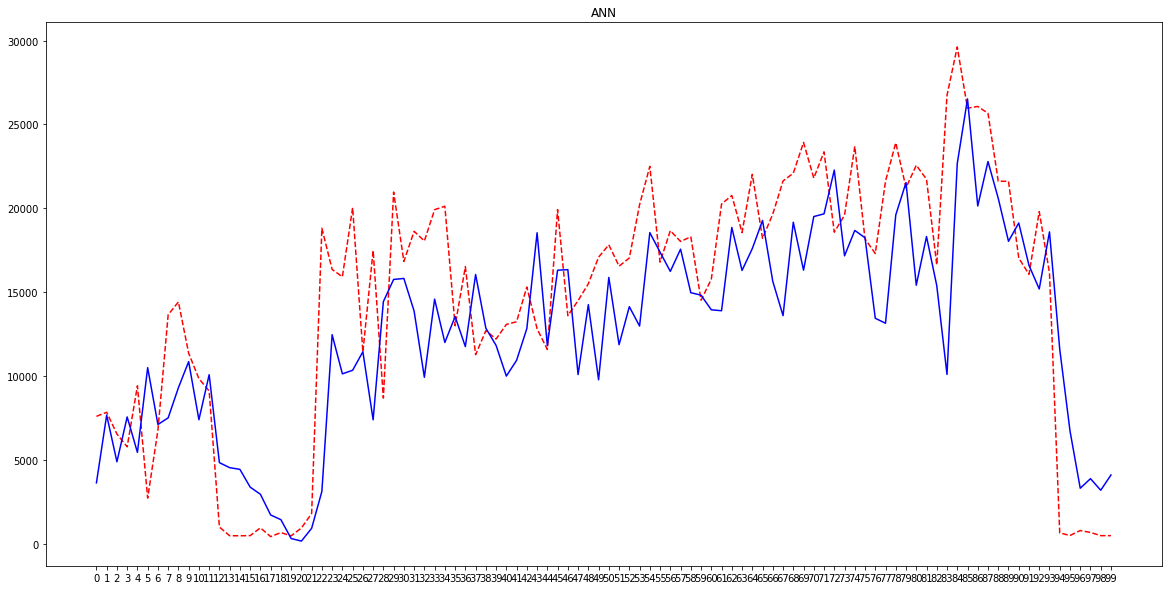

('\n\n House : ', 3268)
(1076, 168)
(1076, 1)
(1076, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
753/753 [==============================] - 0s - loss: 53340708.0000 - mean_squared_error: 53340708.0000
Epoch 2/750
753/753 [==============================] - 0s - loss: 53314824.0000 - mean_squared_error: 53314824.0000
Epoch 3/750
753/753 [==============================] - 0s - loss: 53285800.0000 - mean_squared_error: 53285800.0000
Epoch 4/750
753/753 [==============================] - 0s - loss: 53253788.0000 - mean_squared_error: 53253788.0000
Epoch 5/750
753/753 [==============================] - 0s - loss: 53218916.0000 - mean_squared_error: 53218916.0000
Epoch 6/750
753/753 [==============================] - 0s - loss: 53180600.0000 - mean_squared_error: 53180600.00

753/753 [==============================] - 0s - loss: 22391122.0000 - mean_squared_error: 22391122.0000
Epoch 69/750
753/753 [==============================] - 0s - loss: 21834428.0000 - mean_squared_error: 21834428.0000
Epoch 70/750
753/753 [==============================] - 0s - loss: 21347938.0000 - mean_squared_error: 21347938.0000
Epoch 71/750
753/753 [==============================] - 0s - loss: 20933942.0000 - mean_squared_error: 20933942.0000
Epoch 72/750
753/753 [==============================] - 0s - loss: 20593926.0000 - mean_squared_error: 20593926.0000
Epoch 73/750
753/753 [==============================] - 0s - loss: 20327132.0000 - mean_squared_error: 20327132.0000
Epoch 74/750
753/753 [==============================] - 0s - loss: 20129988.0000 - mean_squared_error: 20129988.0000
Epoch 75/750
753/753 [==============================] - 0s - loss: 19996692.0000 - mean_squared_error: 19996692.0000
Epoch 76/750
753/753 [==============================] - 0s - loss: 19919368.0

753/753 [==============================] - 0s - loss: 16809520.0000 - mean_squared_error: 16809520.0000
Epoch 138/750
753/753 [==============================] - 0s - loss: 16751067.0000 - mean_squared_error: 16751067.0000
Epoch 139/750
753/753 [==============================] - 0s - loss: 16692473.0000 - mean_squared_error: 16692473.0000
Epoch 140/750
753/753 [==============================] - 0s - loss: 16633913.0000 - mean_squared_error: 16633913.0000
Epoch 141/750
753/753 [==============================] - 0s - loss: 16575492.0000 - mean_squared_error: 16575492.0000
Epoch 142/750
753/753 [==============================] - 0s - loss: 16517264.0000 - mean_squared_error: 16517264.0000
Epoch 143/750
753/753 [==============================] - 0s - loss: 16459040.0000 - mean_squared_error: 16459040.0000
Epoch 144/750
753/753 [==============================] - 0s - loss: 16400921.0000 - mean_squared_error: 16400921.0000
Epoch 145/750
753/753 [==============================] - 0s - loss: 16

753/753 [==============================] - 0s - loss: 12804866.0000 - mean_squared_error: 12804866.0000
Epoch 207/750
753/753 [==============================] - 0s - loss: 12752404.0000 - mean_squared_error: 12752404.0000
Epoch 208/750
753/753 [==============================] - 0s - loss: 12700031.0000 - mean_squared_error: 12700031.0000
Epoch 209/750
753/753 [==============================] - 0s - loss: 12647850.0000 - mean_squared_error: 12647850.0000
Epoch 210/750
753/753 [==============================] - 0s - loss: 12596038.0000 - mean_squared_error: 12596038.0000
Epoch 211/750
753/753 [==============================] - 0s - loss: 12544382.0000 - mean_squared_error: 12544382.0000
Epoch 212/750
753/753 [==============================] - 0s - loss: 12493023.0000 - mean_squared_error: 12493023.0000
Epoch 213/750
753/753 [==============================] - 0s - loss: 12441954.0000 - mean_squared_error: 12441954.0000
Epoch 214/750
753/753 [==============================] - 0s - loss: 12

753/753 [==============================] - 0s - loss: 9820673.0000 - mean_squared_error: 9820673.0000
Epoch 276/750
753/753 [==============================] - 0s - loss: 9786501.0000 - mean_squared_error: 9786501.0000
Epoch 277/750
753/753 [==============================] - 0s - loss: 9752725.0000 - mean_squared_error: 9752725.0000
Epoch 278/750
753/753 [==============================] - 0s - loss: 9719134.0000 - mean_squared_error: 9719134.0000
Epoch 279/750
753/753 [==============================] - 0s - loss: 9685819.0000 - mean_squared_error: 9685819.0000
Epoch 280/750
753/753 [==============================] - 0s - loss: 9652847.0000 - mean_squared_error: 9652847.0000
Epoch 281/750
753/753 [==============================] - 0s - loss: 9620016.0000 - mean_squared_error: 9620016.0000
Epoch 282/750
753/753 [==============================] - 0s - loss: 9587422.0000 - mean_squared_error: 9587422.0000
Epoch 283/750
753/753 [==============================] - 0s - loss: 9555125.0000 - mea

753/753 [==============================] - 0s - loss: 7884692.0000 - mean_squared_error: 7884692.0000
Epoch 346/750
753/753 [==============================] - 0s - loss: 7861947.0000 - mean_squared_error: 7861947.0000
Epoch 347/750
753/753 [==============================] - 0s - loss: 7839258.0000 - mean_squared_error: 7839258.0000
Epoch 348/750
753/753 [==============================] - 0s - loss: 7816546.5000 - mean_squared_error: 7816546.5000
Epoch 349/750
753/753 [==============================] - 0s - loss: 7794030.5000 - mean_squared_error: 7794030.5000
Epoch 350/750
753/753 [==============================] - 0s - loss: 7771617.5000 - mean_squared_error: 7771617.5000
Epoch 351/750
753/753 [==============================] - 0s - loss: 7749306.5000 - mean_squared_error: 7749306.5000
Epoch 352/750
753/753 [==============================] - 0s - loss: 7727230.0000 - mean_squared_error: 7727230.0000
Epoch 353/750
753/753 [==============================] - 0s - loss: 7705088.0000 - mea

753/753 [==============================] - 0s - loss: 6507722.5000 - mean_squared_error: 6507722.5000
Epoch 416/750
753/753 [==============================] - 0s - loss: 6491194.5000 - mean_squared_error: 6491194.5000
Epoch 417/750
753/753 [==============================] - 0s - loss: 6474913.0000 - mean_squared_error: 6474913.0000
Epoch 418/750
753/753 [==============================] - 0s - loss: 6458466.5000 - mean_squared_error: 6458466.5000
Epoch 419/750
753/753 [==============================] - 0s - loss: 6442120.0000 - mean_squared_error: 6442120.0000
Epoch 420/750
753/753 [==============================] - 0s - loss: 6425775.5000 - mean_squared_error: 6425775.5000
Epoch 421/750
753/753 [==============================] - 0s - loss: 6409485.5000 - mean_squared_error: 6409485.5000
Epoch 422/750
753/753 [==============================] - 0s - loss: 6393447.5000 - mean_squared_error: 6393447.5000
Epoch 423/750
753/753 [==============================] - 0s - loss: 6377422.5000 - mea

753/753 [==============================] - 0s - loss: 5437379.5000 - mean_squared_error: 5437379.5000
Epoch 486/750
753/753 [==============================] - 0s - loss: 5419885.0000 - mean_squared_error: 5419885.0000
Epoch 487/750
753/753 [==============================] - 0s - loss: 5402467.0000 - mean_squared_error: 5402467.0000
Epoch 488/750
753/753 [==============================] - 0s - loss: 5384960.5000 - mean_squared_error: 5384960.5000
Epoch 489/750
753/753 [==============================] - 0s - loss: 5367454.5000 - mean_squared_error: 5367454.5000
Epoch 490/750
753/753 [==============================] - 0s - loss: 5349695.5000 - mean_squared_error: 5349695.5000
Epoch 491/750
753/753 [==============================] - 0s - loss: 5331885.0000 - mean_squared_error: 5331885.0000
Epoch 492/750
753/753 [==============================] - 0s - loss: 5314242.5000 - mean_squared_error: 5314242.5000
Epoch 493/750
753/753 [==============================] - 0s - loss: 5296405.5000 - mea

753/753 [==============================] - 0s - loss: 4256255.5000 - mean_squared_error: 4256255.5000
Epoch 556/750
753/753 [==============================] - 0s - loss: 4241392.5000 - mean_squared_error: 4241392.5000
Epoch 557/750
753/753 [==============================] - 0s - loss: 4226561.5000 - mean_squared_error: 4226561.5000
Epoch 558/750
753/753 [==============================] - 0s - loss: 4211834.0000 - mean_squared_error: 4211834.0000
Epoch 559/750
753/753 [==============================] - 0s - loss: 4197256.0000 - mean_squared_error: 4197256.0000
Epoch 560/750
753/753 [==============================] - 0s - loss: 4182715.2500 - mean_squared_error: 4182715.2500
Epoch 561/750
753/753 [==============================] - 0s - loss: 4168072.7500 - mean_squared_error: 4168072.7500
Epoch 562/750
753/753 [==============================] - 0s - loss: 4153755.2500 - mean_squared_error: 4153755.2500
Epoch 563/750
753/753 [==============================] - 0s - loss: 4139435.0000 - mea

753/753 [==============================] - 0s - loss: 3325248.0000 - mean_squared_error: 3325248.0000
Epoch 626/750
753/753 [==============================] - 0s - loss: 3313660.2500 - mean_squared_error: 3313660.2500
Epoch 627/750
753/753 [==============================] - 0s - loss: 3302343.2500 - mean_squared_error: 3302343.2500
Epoch 628/750
753/753 [==============================] - 0s - loss: 3291157.7500 - mean_squared_error: 3291157.7500
Epoch 629/750
753/753 [==============================] - 0s - loss: 3279913.7500 - mean_squared_error: 3279913.7500
Epoch 630/750
753/753 [==============================] - 0s - loss: 3268663.7500 - mean_squared_error: 3268663.7500
Epoch 631/750
753/753 [==============================] - 0s - loss: 3257358.0000 - mean_squared_error: 3257358.0000
Epoch 632/750
753/753 [==============================] - 0s - loss: 3246087.7500 - mean_squared_error: 3246087.7500
Epoch 633/750
753/753 [==============================] - 0s - loss: 3234803.5000 - mea

753/753 [==============================] - 0s - loss: 2613507.2500 - mean_squared_error: 2613507.2500
Epoch 696/750
753/753 [==============================] - 0s - loss: 2605273.0000 - mean_squared_error: 2605273.0000
Epoch 697/750
753/753 [==============================] - 0s - loss: 2596990.5000 - mean_squared_error: 2596990.5000
Epoch 698/750
753/753 [==============================] - 0s - loss: 2588831.0000 - mean_squared_error: 2588831.0000
Epoch 699/750
753/753 [==============================] - 0s - loss: 2580497.2500 - mean_squared_error: 2580497.2500
Epoch 700/750
753/753 [==============================] - 0s - loss: 2572474.7500 - mean_squared_error: 2572474.7500
Epoch 701/750
753/753 [==============================] - 0s - loss: 2564387.5000 - mean_squared_error: 2564387.5000
Epoch 702/750
753/753 [==============================] - 0s - loss: 2556467.7500 - mean_squared_error: 2556467.7500
Epoch 703/750
753/753 [==============================] - 0s - loss: 2548528.0000 - mea

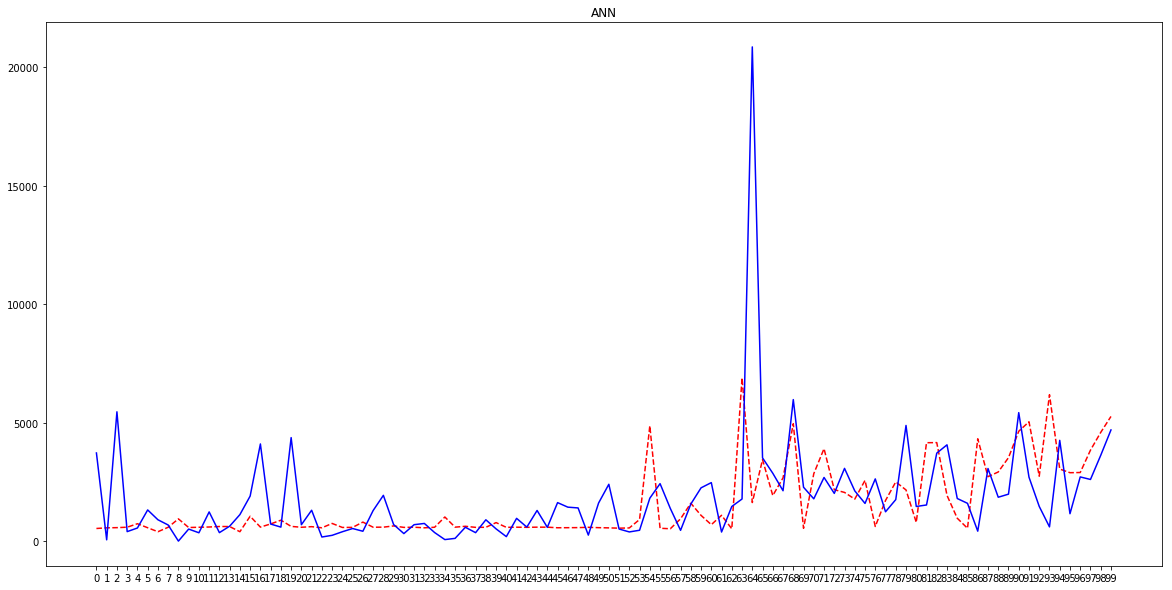

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
753/753 [==============================] - 1s - loss: 53401816.0000 - mean_squared_error: 53401816.0000
Epoch 2/750
753/753 [==============================] - 0s - loss: 53387400.0000 - mean_squared_error: 53387400.0000
Epoch 3/750
753/753 [==============================] - 0s - loss: 53368796.0000 - mean_squared_error: 53368796.0000
Epoch 4/750
753/753 [==============================] - 0s - loss: 53346692.0000 - mean_squared_error: 53346692.0000
Epoch 5/750
753/753 [==============================] - 0s - loss: 53322004.0000 - mean_squared_error: 53322004.0000
Epoch 6/750
753/753 [==============================] - 0s - loss: 53294716.0000 - mean_squared_error: 53294716.0000
Epoch 7/750
753/753 [==============================] - 

753/753 [==============================] - 0s - loss: 26358794.0000 - mean_squared_error: 26358794.0000
Epoch 69/750
753/753 [==============================] - 0s - loss: 25589610.0000 - mean_squared_error: 25589610.0000
Epoch 70/750
753/753 [==============================] - 0s - loss: 24853810.0000 - mean_squared_error: 24853810.0000
Epoch 71/750
753/753 [==============================] - 0s - loss: 24155564.0000 - mean_squared_error: 24155564.0000
Epoch 72/750
753/753 [==============================] - 0s - loss: 23499146.0000 - mean_squared_error: 23499146.0000
Epoch 73/750
753/753 [==============================] - 0s - loss: 22888780.0000 - mean_squared_error: 22888780.0000
Epoch 74/750
753/753 [==============================] - 0s - loss: 22328436.0000 - mean_squared_error: 22328436.0000
Epoch 75/750
753/753 [==============================] - 0s - loss: 21821490.0000 - mean_squared_error: 21821490.0000
Epoch 76/750
753/753 [==============================] - 0s - loss: 21370206.0

753/753 [==============================] - 0s - loss: 17549248.0000 - mean_squared_error: 17549248.0000
Epoch 138/750
753/753 [==============================] - 0s - loss: 17503268.0000 - mean_squared_error: 17503268.0000
Epoch 139/750
753/753 [==============================] - 0s - loss: 17456972.0000 - mean_squared_error: 17456972.0000
Epoch 140/750
753/753 [==============================] - 0s - loss: 17410726.0000 - mean_squared_error: 17410726.0000
Epoch 141/750
753/753 [==============================] - 0s - loss: 17364938.0000 - mean_squared_error: 17364938.0000
Epoch 142/750
753/753 [==============================] - 0s - loss: 17318276.0000 - mean_squared_error: 17318276.0000
Epoch 143/750
753/753 [==============================] - 0s - loss: 17271022.0000 - mean_squared_error: 17271022.0000
Epoch 144/750
753/753 [==============================] - 0s - loss: 17222952.0000 - mean_squared_error: 17222952.0000
Epoch 145/750
753/753 [==============================] - 0s - loss: 17

753/753 [==============================] - 0s - loss: 13567935.0000 - mean_squared_error: 13567935.0000
Epoch 207/750
753/753 [==============================] - 0s - loss: 13509000.0000 - mean_squared_error: 13509000.0000
Epoch 208/750
753/753 [==============================] - 0s - loss: 13450041.0000 - mean_squared_error: 13450041.0000
Epoch 209/750
753/753 [==============================] - 0s - loss: 13391422.0000 - mean_squared_error: 13391422.0000
Epoch 210/750
753/753 [==============================] - 0s - loss: 13332687.0000 - mean_squared_error: 13332687.0000
Epoch 211/750
753/753 [==============================] - 0s - loss: 13273935.0000 - mean_squared_error: 13273935.0000
Epoch 212/750
753/753 [==============================] - 0s - loss: 13215378.0000 - mean_squared_error: 13215378.0000
Epoch 213/750
753/753 [==============================] - 0s - loss: 13156801.0000 - mean_squared_error: 13156801.0000
Epoch 214/750
753/753 [==============================] - 0s - loss: 13

753/753 [==============================] - 0s - loss: 9842024.0000 - mean_squared_error: 9842024.0000
Epoch 276/750
753/753 [==============================] - 0s - loss: 9796320.0000 - mean_squared_error: 9796320.0000
Epoch 277/750
753/753 [==============================] - 0s - loss: 9751266.0000 - mean_squared_error: 9751266.0000
Epoch 278/750
753/753 [==============================] - 0s - loss: 9706190.0000 - mean_squared_error: 9706190.0000
Epoch 279/750
753/753 [==============================] - 0s - loss: 9661305.0000 - mean_squared_error: 9661305.0000
Epoch 280/750
753/753 [==============================] - 0s - loss: 9617135.0000 - mean_squared_error: 9617135.0000
Epoch 281/750
753/753 [==============================] - 0s - loss: 9572686.0000 - mean_squared_error: 9572686.0000
Epoch 282/750
753/753 [==============================] - 0s - loss: 9528556.0000 - mean_squared_error: 9528556.0000
Epoch 283/750
753/753 [==============================] - 0s - loss: 9484856.0000 - mea

753/753 [==============================] - 0s - loss: 6998423.5000 - mean_squared_error: 6998423.5000
Epoch 346/750
753/753 [==============================] - 0s - loss: 6959654.0000 - mean_squared_error: 6959654.0000
Epoch 347/750
753/753 [==============================] - 0s - loss: 6920957.0000 - mean_squared_error: 6920957.0000
Epoch 348/750
753/753 [==============================] - 0s - loss: 6882476.0000 - mean_squared_error: 6882476.0000
Epoch 349/750
753/753 [==============================] - 0s - loss: 6844122.5000 - mean_squared_error: 6844122.5000
Epoch 350/750
753/753 [==============================] - 0s - loss: 6805726.5000 - mean_squared_error: 6805726.5000
Epoch 351/750
753/753 [==============================] - 0s - loss: 6767521.0000 - mean_squared_error: 6767521.0000
Epoch 352/750
753/753 [==============================] - 0s - loss: 6729087.0000 - mean_squared_error: 6729087.0000
Epoch 353/750
753/753 [==============================] - 0s - loss: 6691194.5000 - mea

753/753 [==============================] - 0s - loss: 4526008.5000 - mean_squared_error: 4526008.5000
Epoch 416/750
753/753 [==============================] - 0s - loss: 4495972.0000 - mean_squared_error: 4495972.0000
Epoch 417/750
753/753 [==============================] - 0s - loss: 4465925.5000 - mean_squared_error: 4465925.5000
Epoch 418/750
753/753 [==============================] - 0s - loss: 4436029.5000 - mean_squared_error: 4436029.5000
Epoch 419/750
753/753 [==============================] - 0s - loss: 4406289.0000 - mean_squared_error: 4406289.0000
Epoch 420/750
753/753 [==============================] - 0s - loss: 4377030.5000 - mean_squared_error: 4377030.5000
Epoch 421/750
753/753 [==============================] - 0s - loss: 4347975.0000 - mean_squared_error: 4347975.0000
Epoch 422/750
753/753 [==============================] - 0s - loss: 4319045.5000 - mean_squared_error: 4319045.5000
Epoch 423/750
753/753 [==============================] - 0s - loss: 4290463.5000 - mea

753/753 [==============================] - 0s - loss: 2904700.5000 - mean_squared_error: 2904700.5000
Epoch 486/750
753/753 [==============================] - 0s - loss: 2888041.7500 - mean_squared_error: 2888041.7500
Epoch 487/750
753/753 [==============================] - 0s - loss: 2871424.2500 - mean_squared_error: 2871424.2500
Epoch 488/750
753/753 [==============================] - 0s - loss: 2855016.2500 - mean_squared_error: 2855016.2500
Epoch 489/750
753/753 [==============================] - 0s - loss: 2838862.7500 - mean_squared_error: 2838862.7500
Epoch 490/750
753/753 [==============================] - 0s - loss: 2822904.2500 - mean_squared_error: 2822904.2500
Epoch 491/750
753/753 [==============================] - 0s - loss: 2806932.7500 - mean_squared_error: 2806932.7500
Epoch 492/750
753/753 [==============================] - 0s - loss: 2791272.7500 - mean_squared_error: 2791272.7500
Epoch 493/750
753/753 [==============================] - 0s - loss: 2775521.5000 - mea

753/753 [==============================] - 0s - loss: 2004235.3750 - mean_squared_error: 2004235.3750
Epoch 556/750
753/753 [==============================] - 0s - loss: 1994339.2500 - mean_squared_error: 1994339.2500
Epoch 557/750
753/753 [==============================] - 0s - loss: 1984495.0000 - mean_squared_error: 1984495.0000
Epoch 558/750
753/753 [==============================] - 0s - loss: 1974648.8750 - mean_squared_error: 1974648.8750
Epoch 559/750
753/753 [==============================] - 0s - loss: 1964963.8750 - mean_squared_error: 1964963.8750
Epoch 560/750
753/753 [==============================] - 0s - loss: 1955320.7500 - mean_squared_error: 1955320.7500
Epoch 561/750
753/753 [==============================] - 0s - loss: 1945695.8750 - mean_squared_error: 1945695.8750
Epoch 562/750
753/753 [==============================] - 0s - loss: 1936079.0000 - mean_squared_error: 1936079.0000
Epoch 563/750
753/753 [==============================] - 0s - loss: 1926514.8750 - mea

753/753 [==============================] - 0s - loss: 1433195.7500 - mean_squared_error: 1433195.7500
Epoch 626/750
753/753 [==============================] - 0s - loss: 1426786.6250 - mean_squared_error: 1426786.6250
Epoch 627/750
753/753 [==============================] - 0s - loss: 1420453.1250 - mean_squared_error: 1420453.1250
Epoch 628/750
753/753 [==============================] - 0s - loss: 1414100.0000 - mean_squared_error: 1414100.0000
Epoch 629/750
753/753 [==============================] - 0s - loss: 1407762.7500 - mean_squared_error: 1407762.7500
Epoch 630/750
753/753 [==============================] - 0s - loss: 1401477.2500 - mean_squared_error: 1401477.2500
Epoch 631/750
753/753 [==============================] - 0s - loss: 1395253.5000 - mean_squared_error: 1395253.5000
Epoch 632/750
753/753 [==============================] - 0s - loss: 1389003.6250 - mean_squared_error: 1389003.6250
Epoch 633/750
753/753 [==============================] - 0s - loss: 1382820.3750 - mea

753/753 [==============================] - 0s - loss: 1057229.8750 - mean_squared_error: 1057229.8750
Epoch 696/750
753/753 [==============================] - 0s - loss: 1052673.3750 - mean_squared_error: 1052673.3750
Epoch 697/750
753/753 [==============================] - 0s - loss: 1048182.2500 - mean_squared_error: 1048182.2500
Epoch 698/750
753/753 [==============================] - 0s - loss: 1043653.1250 - mean_squared_error: 1043653.1250
Epoch 699/750
753/753 [==============================] - 0s - loss: 1039156.1250 - mean_squared_error: 1039156.1250
Epoch 700/750
753/753 [==============================] - 0s - loss: 1034702.1875 - mean_squared_error: 1034702.1875
Epoch 701/750
753/753 [==============================] - 0s - loss: 1030261.0625 - mean_squared_error: 1030261.0625
Epoch 702/750
753/753 [==============================] - 0s - loss: 1025795.1250 - mean_squared_error: 1025795.1250
Epoch 703/750
753/753 [==============================] - 0s - loss: 1021373.9375 - mea

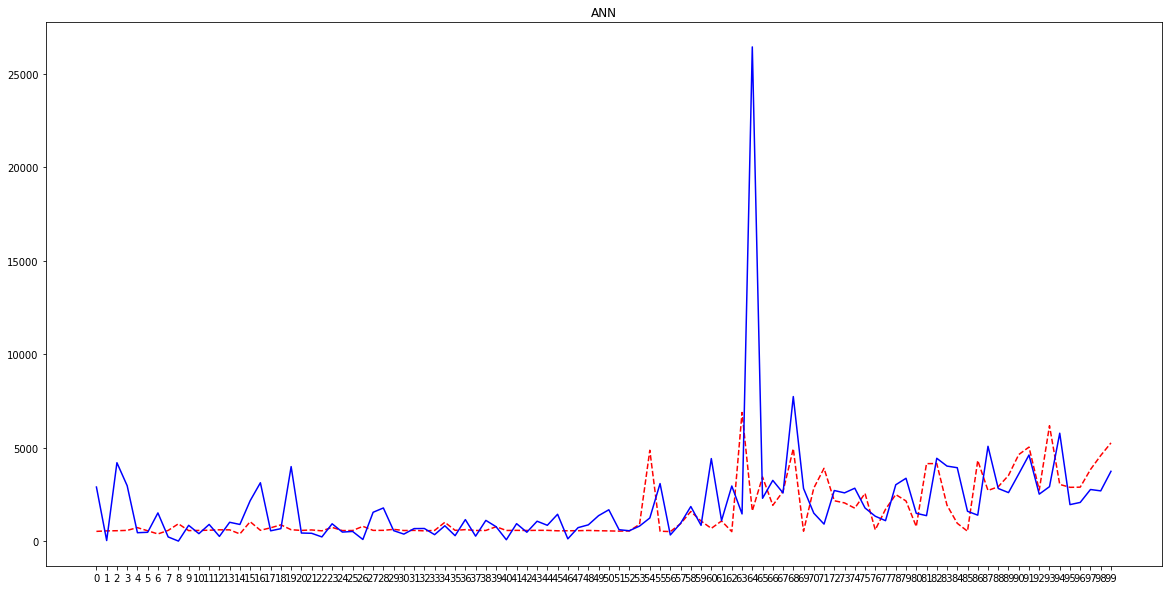

('\n\n House : ', 3273)
(1378, 168)
(1378, 1)
(1378, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
964/964 [==============================] - 0s - loss: 104260080.0000 - mean_squared_error: 104260080.0000
Epoch 2/750
964/964 [==============================] - 0s - loss: 104225296.0000 - mean_squared_error: 104225296.0000
Epoch 3/750
964/964 [==============================] - 0s - loss: 104210632.0000 - mean_squared_error: 104210632.0000
Epoch 4/750
964/964 [==============================] - 0s - loss: 104203112.0000 - mean_squared_error: 104203112.0000
Epoch 5/750
964/964 [==============================] - 0s - loss: 104197688.0000 - mean_squared_error: 104197688.0000
Epoch 6/750
964/964 [==============================] - 0s - loss: 104192648.0000 - mean_squared_error: 

964/964 [==============================] - 0s - loss: 81304128.0000 - mean_squared_error: 81304128.0000
Epoch 68/750
964/964 [==============================] - 0s - loss: 80027152.0000 - mean_squared_error: 80027152.0000
Epoch 69/750
964/964 [==============================] - 0s - loss: 78706936.0000 - mean_squared_error: 78706936.0000
Epoch 70/750
964/964 [==============================] - 0s - loss: 77344648.0000 - mean_squared_error: 77344648.0000
Epoch 71/750
964/964 [==============================] - 0s - loss: 75940552.0000 - mean_squared_error: 75940552.0000
Epoch 72/750
964/964 [==============================] - 0s - loss: 74496048.0000 - mean_squared_error: 74496048.0000
Epoch 73/750
964/964 [==============================] - 0s - loss: 73011712.0000 - mean_squared_error: 73011712.0000
Epoch 74/750
964/964 [==============================] - 0s - loss: 71490400.0000 - mean_squared_error: 71490400.0000
Epoch 75/750
964/964 [==============================] - 0s - loss: 69933408.0

964/964 [==============================] - 0s - loss: 15127512.0000 - mean_squared_error: 15127512.0000
Epoch 137/750
964/964 [==============================] - 0s - loss: 15087429.0000 - mean_squared_error: 15087429.0000
Epoch 138/750
964/964 [==============================] - 0s - loss: 15047187.0000 - mean_squared_error: 15047187.0000
Epoch 139/750
964/964 [==============================] - 0s - loss: 15007861.0000 - mean_squared_error: 15007861.0000
Epoch 140/750
964/964 [==============================] - 0s - loss: 14969998.0000 - mean_squared_error: 14969998.0000
Epoch 141/750
964/964 [==============================] - 0s - loss: 14934043.0000 - mean_squared_error: 14934043.0000
Epoch 142/750
964/964 [==============================] - 0s - loss: 14900381.0000 - mean_squared_error: 14900381.0000
Epoch 143/750
964/964 [==============================] - 0s - loss: 14869116.0000 - mean_squared_error: 14869116.0000
Epoch 144/750
964/964 [==============================] - 0s - loss: 14

964/964 [==============================] - 0s - loss: 13593771.0000 - mean_squared_error: 13593771.0000
Epoch 206/750
964/964 [==============================] - 0s - loss: 13568346.0000 - mean_squared_error: 13568346.0000
Epoch 207/750
964/964 [==============================] - 0s - loss: 13542866.0000 - mean_squared_error: 13542866.0000
Epoch 208/750
964/964 [==============================] - 0s - loss: 13517276.0000 - mean_squared_error: 13517276.0000
Epoch 209/750
964/964 [==============================] - 0s - loss: 13491556.0000 - mean_squared_error: 13491556.0000
Epoch 210/750
964/964 [==============================] - 0s - loss: 13465690.0000 - mean_squared_error: 13465690.0000
Epoch 211/750
964/964 [==============================] - 0s - loss: 13439741.0000 - mean_squared_error: 13439741.0000
Epoch 212/750
964/964 [==============================] - 0s - loss: 13413687.0000 - mean_squared_error: 13413687.0000
Epoch 213/750
964/964 [==============================] - 0s - loss: 13

964/964 [==============================] - 0s - loss: 11807661.0000 - mean_squared_error: 11807661.0000
Epoch 275/750
964/964 [==============================] - 0s - loss: 11783934.0000 - mean_squared_error: 11783934.0000
Epoch 276/750
964/964 [==============================] - 0s - loss: 11760271.0000 - mean_squared_error: 11760271.0000
Epoch 277/750
964/964 [==============================] - 0s - loss: 11736747.0000 - mean_squared_error: 11736747.0000
Epoch 278/750
964/964 [==============================] - 0s - loss: 11713345.0000 - mean_squared_error: 11713345.0000
Epoch 279/750
964/964 [==============================] - 0s - loss: 11690042.0000 - mean_squared_error: 11690042.0000
Epoch 280/750
964/964 [==============================] - 0s - loss: 11666893.0000 - mean_squared_error: 11666893.0000
Epoch 281/750
964/964 [==============================] - 0s - loss: 11643800.0000 - mean_squared_error: 11643800.0000
Epoch 282/750
964/964 [==============================] - 0s - loss: 11

964/964 [==============================] - 0s - loss: 10405326.0000 - mean_squared_error: 10405326.0000
Epoch 344/750
964/964 [==============================] - 0s - loss: 10388091.0000 - mean_squared_error: 10388091.0000
Epoch 345/750
964/964 [==============================] - 0s - loss: 10370947.0000 - mean_squared_error: 10370947.0000
Epoch 346/750
964/964 [==============================] - 0s - loss: 10353811.0000 - mean_squared_error: 10353811.0000
Epoch 347/750
964/964 [==============================] - 0s - loss: 10336768.0000 - mean_squared_error: 10336768.0000
Epoch 348/750
964/964 [==============================] - 0s - loss: 10319827.0000 - mean_squared_error: 10319827.0000
Epoch 349/750
964/964 [==============================] - 0s - loss: 10303021.0000 - mean_squared_error: 10303021.0000
Epoch 350/750
964/964 [==============================] - 0s - loss: 10286221.0000 - mean_squared_error: 10286221.0000
Epoch 351/750
964/964 [==============================] - 0s - loss: 10

964/964 [==============================] - 0s - loss: 9363645.0000 - mean_squared_error: 9363645.0000
Epoch 414/750
964/964 [==============================] - 0s - loss: 9351239.0000 - mean_squared_error: 9351239.0000
Epoch 415/750
964/964 [==============================] - 0s - loss: 9338689.0000 - mean_squared_error: 9338689.0000
Epoch 416/750
964/964 [==============================] - 0s - loss: 9326197.0000 - mean_squared_error: 9326197.0000
Epoch 417/750
964/964 [==============================] - 0s - loss: 9313934.0000 - mean_squared_error: 9313934.0000
Epoch 418/750
964/964 [==============================] - 0s - loss: 9301386.0000 - mean_squared_error: 9301386.0000
Epoch 419/750
964/964 [==============================] - 0s - loss: 9289233.0000 - mean_squared_error: 9289233.0000
Epoch 420/750
964/964 [==============================] - 0s - loss: 9276871.0000 - mean_squared_error: 9276871.0000
Epoch 421/750
964/964 [==============================] - 0s - loss: 9264761.0000 - mea

964/964 [==============================] - 0s - loss: 8581814.0000 - mean_squared_error: 8581814.0000
Epoch 484/750
964/964 [==============================] - 0s - loss: 8571483.0000 - mean_squared_error: 8571483.0000
Epoch 485/750
964/964 [==============================] - 0s - loss: 8561535.0000 - mean_squared_error: 8561535.0000
Epoch 486/750
964/964 [==============================] - 0s - loss: 8551374.0000 - mean_squared_error: 8551374.0000
Epoch 487/750
964/964 [==============================] - 0s - loss: 8541410.0000 - mean_squared_error: 8541410.0000
Epoch 488/750
964/964 [==============================] - 0s - loss: 8531554.0000 - mean_squared_error: 8531554.0000
Epoch 489/750
964/964 [==============================] - 0s - loss: 8521510.0000 - mean_squared_error: 8521510.0000
Epoch 490/750
964/964 [==============================] - 0s - loss: 8511734.0000 - mean_squared_error: 8511734.0000
Epoch 491/750
964/964 [==============================] - 0s - loss: 8501605.0000 - mea

964/964 [==============================] - 0s - loss: 7911207.5000 - mean_squared_error: 7911207.5000
Epoch 554/750
964/964 [==============================] - 0s - loss: 7901989.0000 - mean_squared_error: 7901989.0000
Epoch 555/750
964/964 [==============================] - 0s - loss: 7892820.5000 - mean_squared_error: 7892820.5000
Epoch 556/750
964/964 [==============================] - 0s - loss: 7883797.0000 - mean_squared_error: 7883797.0000
Epoch 557/750
964/964 [==============================] - 0s - loss: 7874577.0000 - mean_squared_error: 7874577.0000
Epoch 558/750
964/964 [==============================] - 0s - loss: 7865472.0000 - mean_squared_error: 7865472.0000
Epoch 559/750
964/964 [==============================] - 0s - loss: 7856332.0000 - mean_squared_error: 7856332.0000
Epoch 560/750
964/964 [==============================] - 0s - loss: 7847216.0000 - mean_squared_error: 7847216.0000
Epoch 561/750
964/964 [==============================] - 0s - loss: 7838150.5000 - mea

964/964 [==============================] - 0s - loss: 7265146.0000 - mean_squared_error: 7265146.0000
Epoch 624/750
964/964 [==============================] - 0s - loss: 7256039.0000 - mean_squared_error: 7256039.0000
Epoch 625/750
964/964 [==============================] - 0s - loss: 7246934.5000 - mean_squared_error: 7246934.5000
Epoch 626/750
964/964 [==============================] - 0s - loss: 7238002.5000 - mean_squared_error: 7238002.5000
Epoch 627/750
964/964 [==============================] - 0s - loss: 7229071.0000 - mean_squared_error: 7229071.0000
Epoch 628/750
964/964 [==============================] - 0s - loss: 7220107.5000 - mean_squared_error: 7220107.5000
Epoch 629/750
964/964 [==============================] - 0s - loss: 7211221.0000 - mean_squared_error: 7211221.0000
Epoch 630/750
964/964 [==============================] - 0s - loss: 7202128.0000 - mean_squared_error: 7202128.0000
Epoch 631/750
964/964 [==============================] - 0s - loss: 7193489.5000 - mea

964/964 [==============================] - 0s - loss: 6686607.0000 - mean_squared_error: 6686607.0000
Epoch 694/750
964/964 [==============================] - 0s - loss: 6678825.5000 - mean_squared_error: 6678825.5000
Epoch 695/750
964/964 [==============================] - 0s - loss: 6671229.0000 - mean_squared_error: 6671229.0000
Epoch 696/750
964/964 [==============================] - 0s - loss: 6663357.0000 - mean_squared_error: 6663357.0000
Epoch 697/750
964/964 [==============================] - 0s - loss: 6655930.5000 - mean_squared_error: 6655930.5000
Epoch 698/750
964/964 [==============================] - 0s - loss: 6647926.5000 - mean_squared_error: 6647926.5000
Epoch 699/750
964/964 [==============================] - 0s - loss: 6640515.5000 - mean_squared_error: 6640515.5000
Epoch 700/750
964/964 [==============================] - 0s - loss: 6632756.0000 - mean_squared_error: 6632756.0000
Epoch 701/750
964/964 [==============================] - 0s - loss: 6625052.0000 - mea

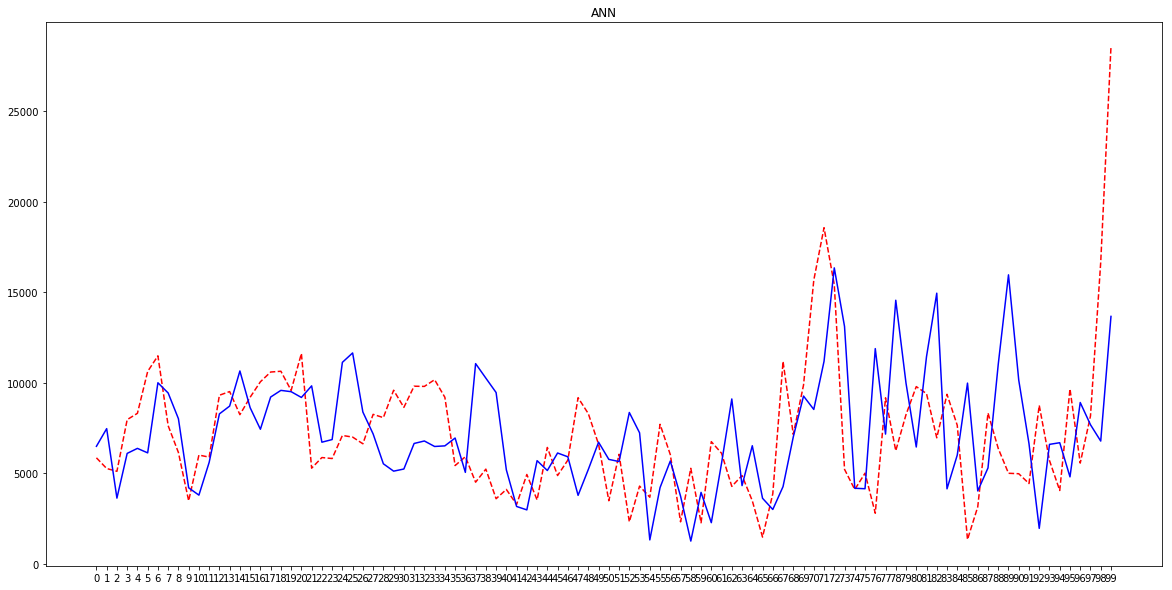

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
964/964 [==============================] - 0s - loss: 104215800.0000 - mean_squared_error: 104215800.0000
Epoch 2/750
964/964 [==============================] - 0s - loss: 104140712.0000 - mean_squared_error: 104140712.0000
Epoch 3/750
964/964 [==============================] - 0s - loss: 104067936.0000 - mean_squared_error: 104067936.0000
Epoch 4/750
964/964 [==============================] - 0s - loss: 103996440.0000 - mean_squared_error: 103996440.0000
Epoch 5/750
964/964 [==============================] - 0s - loss: 103922864.0000 - mean_squared_error: 103922864.0000
Epoch 6/750
964/964 [==============================] - 0s - loss: 103845088.0000 - mean_squared_error: 103845088.0000
Epoch 7/750
964/964 [======================

964/964 [==============================] - 0s - loss: 45685440.0000 - mean_squared_error: 45685440.0000
Epoch 69/750
964/964 [==============================] - 0s - loss: 43598368.0000 - mean_squared_error: 43598368.0000
Epoch 70/750
964/964 [==============================] - 0s - loss: 41525972.0000 - mean_squared_error: 41525972.0000
Epoch 71/750
964/964 [==============================] - 0s - loss: 39476280.0000 - mean_squared_error: 39476280.0000
Epoch 72/750
964/964 [==============================] - 0s - loss: 37457672.0000 - mean_squared_error: 37457672.0000
Epoch 73/750
964/964 [==============================] - 0s - loss: 35478832.0000 - mean_squared_error: 35478832.0000
Epoch 74/750
964/964 [==============================] - 0s - loss: 33548590.0000 - mean_squared_error: 33548590.0000
Epoch 75/750
964/964 [==============================] - 0s - loss: 31675978.0000 - mean_squared_error: 31675978.0000
Epoch 76/750
964/964 [==============================] - 0s - loss: 29870002.0

964/964 [==============================] - 0s - loss: 14623937.0000 - mean_squared_error: 14623937.0000
Epoch 138/750
964/964 [==============================] - 0s - loss: 14611932.0000 - mean_squared_error: 14611932.0000
Epoch 139/750
964/964 [==============================] - 0s - loss: 14599721.0000 - mean_squared_error: 14599721.0000
Epoch 140/750
964/964 [==============================] - 0s - loss: 14587540.0000 - mean_squared_error: 14587540.0000
Epoch 141/750
964/964 [==============================] - 0s - loss: 14575434.0000 - mean_squared_error: 14575434.0000
Epoch 142/750
964/964 [==============================] - 0s - loss: 14563464.0000 - mean_squared_error: 14563464.0000
Epoch 143/750
964/964 [==============================] - 0s - loss: 14551719.0000 - mean_squared_error: 14551719.0000
Epoch 144/750
964/964 [==============================] - 0s - loss: 14540329.0000 - mean_squared_error: 14540329.0000
Epoch 145/750
964/964 [==============================] - 0s - loss: 14

964/964 [==============================] - 0s - loss: 13537711.0000 - mean_squared_error: 13537711.0000
Epoch 207/750
964/964 [==============================] - 0s - loss: 13514911.0000 - mean_squared_error: 13514911.0000
Epoch 208/750
964/964 [==============================] - 0s - loss: 13492073.0000 - mean_squared_error: 13492073.0000
Epoch 209/750
964/964 [==============================] - 0s - loss: 13469187.0000 - mean_squared_error: 13469187.0000
Epoch 210/750
964/964 [==============================] - 0s - loss: 13446264.0000 - mean_squared_error: 13446264.0000
Epoch 211/750
964/964 [==============================] - 0s - loss: 13423296.0000 - mean_squared_error: 13423296.0000
Epoch 212/750
964/964 [==============================] - 0s - loss: 13400278.0000 - mean_squared_error: 13400278.0000
Epoch 213/750
964/964 [==============================] - 0s - loss: 13377226.0000 - mean_squared_error: 13377226.0000
Epoch 214/750
964/964 [==============================] - 0s - loss: 13

964/964 [==============================] - 0s - loss: 11992519.0000 - mean_squared_error: 11992519.0000
Epoch 276/750
964/964 [==============================] - 0s - loss: 11971563.0000 - mean_squared_error: 11971563.0000
Epoch 277/750
964/964 [==============================] - 0s - loss: 11950671.0000 - mean_squared_error: 11950671.0000
Epoch 278/750
964/964 [==============================] - 0s - loss: 11929844.0000 - mean_squared_error: 11929844.0000
Epoch 279/750
964/964 [==============================] - 0s - loss: 11909075.0000 - mean_squared_error: 11909075.0000
Epoch 280/750
964/964 [==============================] - 0s - loss: 11888387.0000 - mean_squared_error: 11888387.0000
Epoch 281/750
964/964 [==============================] - 0s - loss: 11867768.0000 - mean_squared_error: 11867768.0000
Epoch 282/750
964/964 [==============================] - 0s - loss: 11847213.0000 - mean_squared_error: 11847213.0000
Epoch 283/750
964/964 [==============================] - 0s - loss: 11

964/964 [==============================] - 0s - loss: 10740976.0000 - mean_squared_error: 10740976.0000
Epoch 345/750
964/964 [==============================] - 0s - loss: 10725678.0000 - mean_squared_error: 10725678.0000
Epoch 346/750
964/964 [==============================] - 0s - loss: 10710557.0000 - mean_squared_error: 10710557.0000
Epoch 347/750
964/964 [==============================] - 0s - loss: 10695502.0000 - mean_squared_error: 10695502.0000
Epoch 348/750
964/964 [==============================] - 0s - loss: 10680541.0000 - mean_squared_error: 10680541.0000
Epoch 349/750
964/964 [==============================] - 0s - loss: 10665733.0000 - mean_squared_error: 10665733.0000
Epoch 350/750
964/964 [==============================] - 0s - loss: 10651109.0000 - mean_squared_error: 10651109.0000
Epoch 351/750
964/964 [==============================] - 0s - loss: 10636552.0000 - mean_squared_error: 10636552.0000
Epoch 352/750
964/964 [==============================] - 0s - loss: 10

964/964 [==============================] - 0s - loss: 9858411.0000 - mean_squared_error: 9858411.0000
Epoch 414/750
964/964 [==============================] - 0s - loss: 9847597.0000 - mean_squared_error: 9847597.0000
Epoch 415/750
964/964 [==============================] - 0s - loss: 9836751.0000 - mean_squared_error: 9836751.0000
Epoch 416/750
964/964 [==============================] - 0s - loss: 9826149.0000 - mean_squared_error: 9826149.0000
Epoch 417/750
964/964 [==============================] - 0s - loss: 9815368.0000 - mean_squared_error: 9815368.0000
Epoch 418/750
964/964 [==============================] - 0s - loss: 9804763.0000 - mean_squared_error: 9804763.0000
Epoch 419/750
964/964 [==============================] - 0s - loss: 9793982.0000 - mean_squared_error: 9793982.0000
Epoch 420/750
964/964 [==============================] - 0s - loss: 9783470.0000 - mean_squared_error: 9783470.0000
Epoch 421/750
964/964 [==============================] - 0s - loss: 9772950.0000 - mea

964/964 [==============================] - 0s - loss: 9086917.0000 - mean_squared_error: 9086917.0000
Epoch 484/750
964/964 [==============================] - 0s - loss: 9075128.0000 - mean_squared_error: 9075128.0000
Epoch 485/750
964/964 [==============================] - 0s - loss: 9063580.0000 - mean_squared_error: 9063580.0000
Epoch 486/750
964/964 [==============================] - 0s - loss: 9051994.0000 - mean_squared_error: 9051994.0000
Epoch 487/750
964/964 [==============================] - 0s - loss: 9040658.0000 - mean_squared_error: 9040658.0000
Epoch 488/750
964/964 [==============================] - 0s - loss: 9029262.0000 - mean_squared_error: 9029262.0000
Epoch 489/750
964/964 [==============================] - 0s - loss: 9017780.0000 - mean_squared_error: 9017780.0000
Epoch 490/750
964/964 [==============================] - 0s - loss: 9006658.0000 - mean_squared_error: 9006658.0000
Epoch 491/750
964/964 [==============================] - 0s - loss: 8994894.0000 - mea

964/964 [==============================] - 0s - loss: 8294505.5000 - mean_squared_error: 8294505.5000
Epoch 554/750
964/964 [==============================] - 0s - loss: 8281366.0000 - mean_squared_error: 8281366.0000
Epoch 555/750
964/964 [==============================] - 0s - loss: 8268304.0000 - mean_squared_error: 8268304.0000
Epoch 556/750
964/964 [==============================] - 0s - loss: 8255172.5000 - mean_squared_error: 8255172.5000
Epoch 557/750
964/964 [==============================] - 0s - loss: 8241692.5000 - mean_squared_error: 8241692.5000
Epoch 558/750
964/964 [==============================] - 0s - loss: 8228705.5000 - mean_squared_error: 8228705.5000
Epoch 559/750
964/964 [==============================] - 0s - loss: 8215387.5000 - mean_squared_error: 8215387.5000
Epoch 560/750
964/964 [==============================] - 0s - loss: 8201439.0000 - mean_squared_error: 8201439.0000
Epoch 561/750
964/964 [==============================] - 0s - loss: 8188389.5000 - mea

964/964 [==============================] - 0s - loss: 7328198.0000 - mean_squared_error: 7328198.0000
Epoch 624/750
964/964 [==============================] - 0s - loss: 7316020.0000 - mean_squared_error: 7316020.0000
Epoch 625/750
964/964 [==============================] - 0s - loss: 7302564.5000 - mean_squared_error: 7302564.5000
Epoch 626/750
964/964 [==============================] - 0s - loss: 7290378.5000 - mean_squared_error: 7290378.5000
Epoch 627/750
964/964 [==============================] - 0s - loss: 7277445.0000 - mean_squared_error: 7277445.0000
Epoch 628/750
964/964 [==============================] - 0s - loss: 7264474.0000 - mean_squared_error: 7264474.0000
Epoch 629/750
964/964 [==============================] - 0s - loss: 7251967.0000 - mean_squared_error: 7251967.0000
Epoch 630/750
964/964 [==============================] - 0s - loss: 7239324.0000 - mean_squared_error: 7239324.0000
Epoch 631/750
964/964 [==============================] - 0s - loss: 7226469.0000 - mea

964/964 [==============================] - 0s - loss: 6381980.0000 - mean_squared_error: 6381980.0000
Epoch 694/750
964/964 [==============================] - 0s - loss: 6365614.5000 - mean_squared_error: 6365614.5000
Epoch 695/750
964/964 [==============================] - 0s - loss: 6350396.0000 - mean_squared_error: 6350396.0000
Epoch 696/750
964/964 [==============================] - 0s - loss: 6333787.0000 - mean_squared_error: 6333787.0000
Epoch 697/750
964/964 [==============================] - 0s - loss: 6318498.0000 - mean_squared_error: 6318498.0000
Epoch 698/750
964/964 [==============================] - 0s - loss: 6302038.0000 - mean_squared_error: 6302038.0000
Epoch 699/750
964/964 [==============================] - 0s - loss: 6286334.0000 - mean_squared_error: 6286334.0000
Epoch 700/750
964/964 [==============================] - 0s - loss: 6270050.5000 - mean_squared_error: 6270050.5000
Epoch 701/750
964/964 [==============================] - 0s - loss: 6254315.0000 - mea

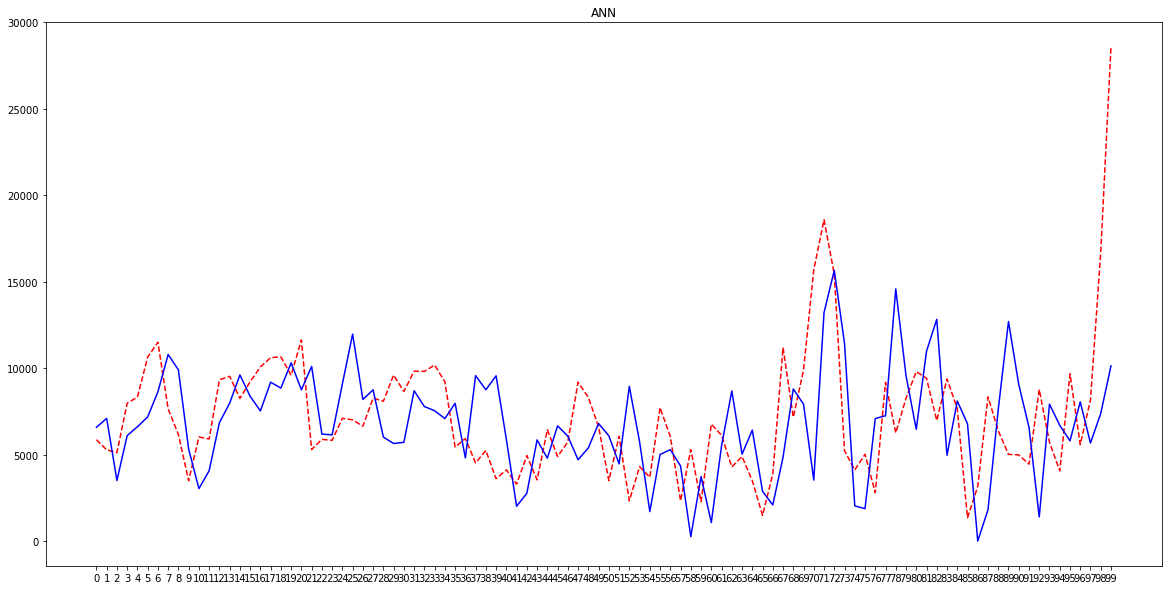

('\n\n House : ', 4000)
(298, 168)
(298, 1)
(298, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
208/208 [==============================] - 0s - loss: 61341688.0000 - mean_squared_error: 61341688.0000
Epoch 2/750
208/208 [==============================] - 0s - loss: 61286864.0000 - mean_squared_error: 61286864.0000
Epoch 3/750
208/208 [==============================] - 0s - loss: 61232648.0000 - mean_squared_error: 61232648.0000
Epoch 4/750
208/208 [==============================] - 0s - loss: 61180156.0000 - mean_squared_error: 61180156.0000
Epoch 5/750
208/208 [==============================] - 0s - loss: 61127192.0000 - mean_squared_error: 61127192.0000
Epoch 6/750
208/208 [==============================] - 0s - loss: 61070888.0000 - mean_squared_error: 61070888.0000


208/208 [==============================] - 0s - loss: 33251446.0000 - mean_squared_error: 33251446.0000
Epoch 69/750
208/208 [==============================] - 0s - loss: 32247016.0000 - mean_squared_error: 32247016.0000
Epoch 70/750
208/208 [==============================] - 0s - loss: 31236600.0000 - mean_squared_error: 31236600.0000
Epoch 71/750
208/208 [==============================] - 0s - loss: 30222254.0000 - mean_squared_error: 30222254.0000
Epoch 72/750
208/208 [==============================] - 0s - loss: 29205730.0000 - mean_squared_error: 29205730.0000
Epoch 73/750
208/208 [==============================] - 0s - loss: 28189788.0000 - mean_squared_error: 28189788.0000
Epoch 74/750
208/208 [==============================] - 0s - loss: 27176430.0000 - mean_squared_error: 27176430.0000
Epoch 75/750
208/208 [==============================] - 0s - loss: 26168226.0000 - mean_squared_error: 26168226.0000
Epoch 76/750
208/208 [==============================] - 0s - loss: 25167828.0

208/208 [==============================] - 0s - loss: 9334823.0000 - mean_squared_error: 9334823.0000
Epoch 139/750
208/208 [==============================] - 0s - loss: 9325249.0000 - mean_squared_error: 9325249.0000
Epoch 140/750
208/208 [==============================] - 0s - loss: 9316192.0000 - mean_squared_error: 9316192.0000
Epoch 141/750
208/208 [==============================] - 0s - loss: 9307516.0000 - mean_squared_error: 9307516.0000
Epoch 142/750
208/208 [==============================] - 0s - loss: 9299099.0000 - mean_squared_error: 9299099.0000
Epoch 143/750
208/208 [==============================] - 0s - loss: 9290837.0000 - mean_squared_error: 9290837.0000
Epoch 144/750
208/208 [==============================] - 0s - loss: 9282636.0000 - mean_squared_error: 9282636.0000
Epoch 145/750
208/208 [==============================] - 0s - loss: 9274430.0000 - mean_squared_error: 9274430.0000
Epoch 146/750
208/208 [==============================] - 0s - loss: 9266158.0000 - mea

208/208 [==============================] - 0s - loss: 8721191.0000 - mean_squared_error: 8721191.0000
Epoch 209/750
208/208 [==============================] - 0s - loss: 8712736.0000 - mean_squared_error: 8712736.0000
Epoch 210/750
208/208 [==============================] - 0s - loss: 8704287.0000 - mean_squared_error: 8704287.0000
Epoch 211/750
208/208 [==============================] - 0s - loss: 8695846.0000 - mean_squared_error: 8695846.0000
Epoch 212/750
208/208 [==============================] - 0s - loss: 8687408.0000 - mean_squared_error: 8687408.0000
Epoch 213/750
208/208 [==============================] - 0s - loss: 8678977.0000 - mean_squared_error: 8678977.0000
Epoch 214/750
208/208 [==============================] - 0s - loss: 8670554.0000 - mean_squared_error: 8670554.0000
Epoch 215/750
208/208 [==============================] - 0s - loss: 8662135.0000 - mean_squared_error: 8662135.0000
Epoch 216/750
208/208 [==============================] - 0s - loss: 8653722.0000 - mea

208/208 [==============================] - 0s - loss: 8140432.0000 - mean_squared_error: 8140432.0000
Epoch 279/750
208/208 [==============================] - 0s - loss: 8132226.0000 - mean_squared_error: 8132226.0000
Epoch 280/750
208/208 [==============================] - 0s - loss: 8124021.0000 - mean_squared_error: 8124021.0000
Epoch 281/750
208/208 [==============================] - 0s - loss: 8115815.5000 - mean_squared_error: 8115815.5000
Epoch 282/750
208/208 [==============================] - 0s - loss: 8107611.0000 - mean_squared_error: 8107611.0000
Epoch 283/750
208/208 [==============================] - 0s - loss: 8099404.5000 - mean_squared_error: 8099404.5000
Epoch 284/750
208/208 [==============================] - 0s - loss: 8091200.5000 - mean_squared_error: 8091200.5000
Epoch 285/750
208/208 [==============================] - 0s - loss: 8082994.5000 - mean_squared_error: 8082994.5000
Epoch 286/750
208/208 [==============================] - 0s - loss: 8074789.5000 - mea

208/208 [==============================] - 0s - loss: 7562866.5000 - mean_squared_error: 7562866.5000
Epoch 349/750
208/208 [==============================] - 0s - loss: 7554513.0000 - mean_squared_error: 7554513.0000
Epoch 350/750
208/208 [==============================] - 0s - loss: 7546156.5000 - mean_squared_error: 7546156.5000
Epoch 351/750
208/208 [==============================] - 0s - loss: 7537795.5000 - mean_squared_error: 7537795.5000
Epoch 352/750
208/208 [==============================] - 0s - loss: 7529430.0000 - mean_squared_error: 7529430.0000
Epoch 353/750
208/208 [==============================] - 0s - loss: 7521059.5000 - mean_squared_error: 7521059.5000
Epoch 354/750
208/208 [==============================] - 0s - loss: 7512685.0000 - mean_squared_error: 7512685.0000
Epoch 355/750
208/208 [==============================] - 0s - loss: 7504305.0000 - mean_squared_error: 7504305.0000
Epoch 356/750
208/208 [==============================] - 0s - loss: 7495921.0000 - mea

208/208 [==============================] - 0s - loss: 6965563.5000 - mean_squared_error: 6965563.5000
Epoch 419/750
208/208 [==============================] - 0s - loss: 6956819.5000 - mean_squared_error: 6956819.5000
Epoch 420/750
208/208 [==============================] - 0s - loss: 6948068.5000 - mean_squared_error: 6948068.5000
Epoch 421/750
208/208 [==============================] - 0s - loss: 6939311.5000 - mean_squared_error: 6939311.5000
Epoch 422/750
208/208 [==============================] - 0s - loss: 6930547.0000 - mean_squared_error: 6930547.0000
Epoch 423/750
208/208 [==============================] - 0s - loss: 6921774.0000 - mean_squared_error: 6921774.0000
Epoch 424/750
208/208 [==============================] - 0s - loss: 6912999.0000 - mean_squared_error: 6912999.0000
Epoch 425/750
208/208 [==============================] - 0s - loss: 6904215.0000 - mean_squared_error: 6904215.0000
Epoch 426/750
208/208 [==============================] - 0s - loss: 6895424.5000 - mea

208/208 [==============================] - 0s - loss: 6338315.0000 - mean_squared_error: 6338315.0000
Epoch 489/750
208/208 [==============================] - 0s - loss: 6329147.0000 - mean_squared_error: 6329147.0000
Epoch 490/750
208/208 [==============================] - 0s - loss: 6319976.5000 - mean_squared_error: 6319976.5000
Epoch 491/750
208/208 [==============================] - 0s - loss: 6310799.5000 - mean_squared_error: 6310799.5000
Epoch 492/750
208/208 [==============================] - 0s - loss: 6301618.0000 - mean_squared_error: 6301618.0000
Epoch 493/750
208/208 [==============================] - 0s - loss: 6292431.0000 - mean_squared_error: 6292431.0000
Epoch 494/750
208/208 [==============================] - 0s - loss: 6283241.0000 - mean_squared_error: 6283241.0000
Epoch 495/750
208/208 [==============================] - 0s - loss: 6274045.5000 - mean_squared_error: 6274045.5000
Epoch 496/750
208/208 [==============================] - 0s - loss: 6264843.0000 - mea

208/208 [==============================] - 0s - loss: 5687286.0000 - mean_squared_error: 5687286.0000
Epoch 559/750
208/208 [==============================] - 0s - loss: 5677884.5000 - mean_squared_error: 5677884.5000
Epoch 560/750
208/208 [==============================] - 0s - loss: 5668483.0000 - mean_squared_error: 5668483.0000
Epoch 561/750
208/208 [==============================] - 0s - loss: 5659082.0000 - mean_squared_error: 5659082.0000
Epoch 562/750
208/208 [==============================] - 0s - loss: 5649713.0000 - mean_squared_error: 5649713.0000
Epoch 563/750
208/208 [==============================] - 0s - loss: 5640368.5000 - mean_squared_error: 5640368.5000
Epoch 564/750
208/208 [==============================] - 0s - loss: 5631024.5000 - mean_squared_error: 5631024.5000
Epoch 565/750
208/208 [==============================] - 0s - loss: 5621683.5000 - mean_squared_error: 5621683.5000
Epoch 566/750
208/208 [==============================] - 0s - loss: 5612339.0000 - mea

208/208 [==============================] - 0s - loss: 5045066.5000 - mean_squared_error: 5045066.5000
Epoch 629/750
208/208 [==============================] - 0s - loss: 5036156.5000 - mean_squared_error: 5036156.5000
Epoch 630/750
208/208 [==============================] - 0s - loss: 5027253.5000 - mean_squared_error: 5027253.5000
Epoch 631/750
208/208 [==============================] - 0s - loss: 5018343.5000 - mean_squared_error: 5018343.5000
Epoch 632/750
208/208 [==============================] - 0s - loss: 5009437.5000 - mean_squared_error: 5009437.5000
Epoch 633/750
208/208 [==============================] - 0s - loss: 5000555.5000 - mean_squared_error: 5000555.5000
Epoch 634/750
208/208 [==============================] - 0s - loss: 4991681.0000 - mean_squared_error: 4991681.0000
Epoch 635/750
208/208 [==============================] - 0s - loss: 4982817.0000 - mean_squared_error: 4982817.0000
Epoch 636/750
208/208 [==============================] - 0s - loss: 4973961.0000 - mea

208/208 [==============================] - 0s - loss: 4442943.5000 - mean_squared_error: 4442943.5000
Epoch 699/750
208/208 [==============================] - 0s - loss: 4434751.0000 - mean_squared_error: 4434751.0000
Epoch 700/750
208/208 [==============================] - 0s - loss: 4426571.0000 - mean_squared_error: 4426571.0000
Epoch 701/750
208/208 [==============================] - 0s - loss: 4418401.0000 - mean_squared_error: 4418401.0000
Epoch 702/750
208/208 [==============================] - 0s - loss: 4410243.0000 - mean_squared_error: 4410243.0000
Epoch 703/750
208/208 [==============================] - 0s - loss: 4402096.0000 - mean_squared_error: 4402096.0000
Epoch 704/750
208/208 [==============================] - 0s - loss: 4393960.5000 - mean_squared_error: 4393960.5000
Epoch 705/750
208/208 [==============================] - 0s - loss: 4385836.5000 - mean_squared_error: 4385836.5000
Epoch 706/750
208/208 [==============================] - 0s - loss: 4377744.0000 - mea

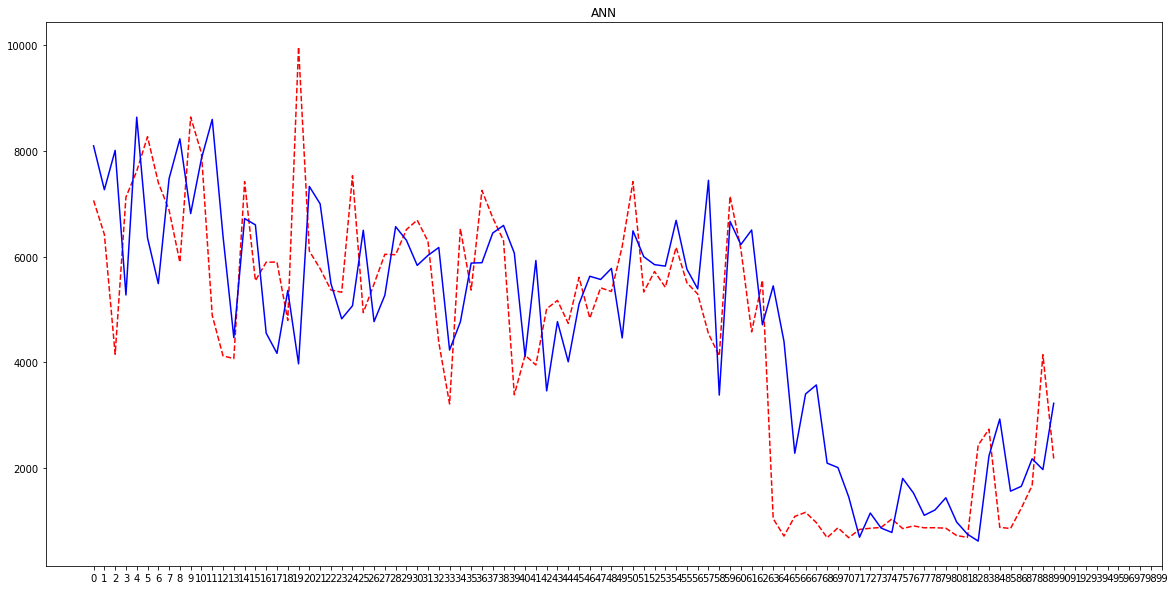

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
208/208 [==============================] - 0s - loss: 61358300.0000 - mean_squared_error: 61358300.0000
Epoch 2/750
208/208 [==============================] - 0s - loss: 61333272.0000 - mean_squared_error: 61333272.0000
Epoch 3/750
208/208 [==============================] - 0s - loss: 61299800.0000 - mean_squared_error: 61299800.0000
Epoch 4/750
208/208 [==============================] - 0s - loss: 61258388.0000 - mean_squared_error: 61258388.0000
Epoch 5/750
208/208 [==============================] - 0s - loss: 61210616.0000 - mean_squared_error: 61210616.0000
Epoch 6/750
208/208 [==============================] - 0s - loss: 61156992.0000 - mean_squared_error: 61156992.0000
Epoch 7/750
208/208 [==============================] - 

208/208 [==============================] - 0s - loss: 16299274.0000 - mean_squared_error: 16299274.0000
Epoch 69/750
208/208 [==============================] - 0s - loss: 15279973.0000 - mean_squared_error: 15279973.0000
Epoch 70/750
208/208 [==============================] - 0s - loss: 14334191.0000 - mean_squared_error: 14334191.0000
Epoch 71/750
208/208 [==============================] - 0s - loss: 13468370.0000 - mean_squared_error: 13468370.0000
Epoch 72/750
208/208 [==============================] - 0s - loss: 12687070.0000 - mean_squared_error: 12687070.0000
Epoch 73/750
208/208 [==============================] - 0s - loss: 11994097.0000 - mean_squared_error: 11994097.0000
Epoch 74/750
208/208 [==============================] - 0s - loss: 11392214.0000 - mean_squared_error: 11392214.0000
Epoch 75/750
208/208 [==============================] - 0s - loss: 10882699.0000 - mean_squared_error: 10882699.0000
Epoch 76/750
208/208 [==============================] - 0s - loss: 10464937.0

208/208 [==============================] - 0s - loss: 8910447.0000 - mean_squared_error: 8910447.0000
Epoch 139/750
208/208 [==============================] - 0s - loss: 8899399.0000 - mean_squared_error: 8899399.0000
Epoch 140/750
208/208 [==============================] - 0s - loss: 8888326.0000 - mean_squared_error: 8888326.0000
Epoch 141/750
208/208 [==============================] - 0s - loss: 8877198.0000 - mean_squared_error: 8877198.0000
Epoch 142/750
208/208 [==============================] - 0s - loss: 8865994.0000 - mean_squared_error: 8865994.0000
Epoch 143/750
208/208 [==============================] - 0s - loss: 8854711.0000 - mean_squared_error: 8854711.0000
Epoch 144/750
208/208 [==============================] - 0s - loss: 8843346.0000 - mean_squared_error: 8843346.0000
Epoch 145/750
208/208 [==============================] - 0s - loss: 8831906.0000 - mean_squared_error: 8831906.0000
Epoch 146/750
208/208 [==============================] - 0s - loss: 8820407.0000 - mea

208/208 [==============================] - 0s - loss: 8140160.5000 - mean_squared_error: 8140160.5000
Epoch 209/750
208/208 [==============================] - 0s - loss: 8129476.5000 - mean_squared_error: 8129476.5000
Epoch 210/750
208/208 [==============================] - 0s - loss: 8118794.0000 - mean_squared_error: 8118794.0000
Epoch 211/750
208/208 [==============================] - 0s - loss: 8108116.5000 - mean_squared_error: 8108116.5000
Epoch 212/750
208/208 [==============================] - 0s - loss: 8097440.0000 - mean_squared_error: 8097440.0000
Epoch 213/750
208/208 [==============================] - 0s - loss: 8086766.0000 - mean_squared_error: 8086766.0000
Epoch 214/750
208/208 [==============================] - 0s - loss: 8076095.5000 - mean_squared_error: 8076095.5000
Epoch 215/750
208/208 [==============================] - 0s - loss: 8065425.0000 - mean_squared_error: 8065425.0000
Epoch 216/750
208/208 [==============================] - 0s - loss: 8054757.0000 - mea

208/208 [==============================] - 0s - loss: 7390228.5000 - mean_squared_error: 7390228.5000
Epoch 279/750
208/208 [==============================] - 0s - loss: 7379358.0000 - mean_squared_error: 7379358.0000
Epoch 280/750
208/208 [==============================] - 0s - loss: 7368483.0000 - mean_squared_error: 7368483.0000
Epoch 281/750
208/208 [==============================] - 0s - loss: 7357599.0000 - mean_squared_error: 7357599.0000
Epoch 282/750
208/208 [==============================] - 0s - loss: 7346706.5000 - mean_squared_error: 7346706.5000
Epoch 283/750
208/208 [==============================] - 0s - loss: 7335808.0000 - mean_squared_error: 7335808.0000
Epoch 284/750
208/208 [==============================] - 0s - loss: 7324901.0000 - mean_squared_error: 7324901.0000
Epoch 285/750
208/208 [==============================] - 0s - loss: 7313988.5000 - mean_squared_error: 7313988.5000
Epoch 286/750
208/208 [==============================] - 0s - loss: 7303064.5000 - mea

208/208 [==============================] - 0s - loss: 6608336.0000 - mean_squared_error: 6608336.0000
Epoch 349/750
208/208 [==============================] - 0s - loss: 6596830.0000 - mean_squared_error: 6596830.0000
Epoch 350/750
208/208 [==============================] - 0s - loss: 6585315.0000 - mean_squared_error: 6585315.0000
Epoch 351/750
208/208 [==============================] - 0s - loss: 6573793.0000 - mean_squared_error: 6573793.0000
Epoch 352/750
208/208 [==============================] - 0s - loss: 6562259.5000 - mean_squared_error: 6562259.5000
Epoch 353/750
208/208 [==============================] - 0s - loss: 6550719.5000 - mean_squared_error: 6550719.5000
Epoch 354/750
208/208 [==============================] - 0s - loss: 6539169.0000 - mean_squared_error: 6539169.0000
Epoch 355/750
208/208 [==============================] - 0s - loss: 6527612.5000 - mean_squared_error: 6527612.5000
Epoch 356/750
208/208 [==============================] - 0s - loss: 6516044.5000 - mea

208/208 [==============================] - 0s - loss: 5785318.0000 - mean_squared_error: 5785318.0000
Epoch 419/750
208/208 [==============================] - 0s - loss: 5773402.5000 - mean_squared_error: 5773402.5000
Epoch 420/750
208/208 [==============================] - 0s - loss: 5761485.5000 - mean_squared_error: 5761485.5000
Epoch 421/750
208/208 [==============================] - 0s - loss: 5749568.5000 - mean_squared_error: 5749568.5000
Epoch 422/750
208/208 [==============================] - 0s - loss: 5737651.5000 - mean_squared_error: 5737651.5000
Epoch 423/750
208/208 [==============================] - 0s - loss: 5725736.5000 - mean_squared_error: 5725736.5000
Epoch 424/750
208/208 [==============================] - 0s - loss: 5713819.0000 - mean_squared_error: 5713819.0000
Epoch 425/750
208/208 [==============================] - 0s - loss: 5701903.0000 - mean_squared_error: 5701903.0000
Epoch 426/750
208/208 [==============================] - 0s - loss: 5689986.5000 - mea

208/208 [==============================] - 0s - loss: 4961215.5000 - mean_squared_error: 4961215.5000
Epoch 489/750
208/208 [==============================] - 0s - loss: 4949917.5000 - mean_squared_error: 4949917.5000
Epoch 490/750
208/208 [==============================] - 0s - loss: 4938655.5000 - mean_squared_error: 4938655.5000
Epoch 491/750
208/208 [==============================] - 0s - loss: 4927402.5000 - mean_squared_error: 4927402.5000
Epoch 492/750
208/208 [==============================] - 0s - loss: 4916159.5000 - mean_squared_error: 4916159.5000
Epoch 493/750
208/208 [==============================] - 0s - loss: 4904926.5000 - mean_squared_error: 4904926.5000
Epoch 494/750
208/208 [==============================] - 0s - loss: 4893802.0000 - mean_squared_error: 4893802.0000
Epoch 495/750
208/208 [==============================] - 0s - loss: 4882723.0000 - mean_squared_error: 4882723.0000
Epoch 496/750
208/208 [==============================] - 0s - loss: 4871649.5000 - mea

208/208 [==============================] - 0s - loss: 4218947.0000 - mean_squared_error: 4218947.0000
Epoch 559/750
208/208 [==============================] - 0s - loss: 4209154.0000 - mean_squared_error: 4209154.0000
Epoch 560/750
208/208 [==============================] - 0s - loss: 4199373.5000 - mean_squared_error: 4199373.5000
Epoch 561/750
208/208 [==============================] - 0s - loss: 4189636.5000 - mean_squared_error: 4189636.5000
Epoch 562/750
208/208 [==============================] - 0s - loss: 4179923.7500 - mean_squared_error: 4179923.7500
Epoch 563/750
208/208 [==============================] - 0s - loss: 4170234.5000 - mean_squared_error: 4170234.5000
Epoch 564/750
208/208 [==============================] - 0s - loss: 4160569.2500 - mean_squared_error: 4160569.2500
Epoch 565/750
208/208 [==============================] - 0s - loss: 4150930.5000 - mean_squared_error: 4150930.5000
Epoch 566/750
208/208 [==============================] - 0s - loss: 4141315.7500 - mea

208/208 [==============================] - 0s - loss: 3601060.0000 - mean_squared_error: 3601060.0000
Epoch 629/750
208/208 [==============================] - 0s - loss: 3593286.7500 - mean_squared_error: 3593286.7500
Epoch 630/750
208/208 [==============================] - 0s - loss: 3585538.5000 - mean_squared_error: 3585538.5000
Epoch 631/750
208/208 [==============================] - 0s - loss: 3577822.7500 - mean_squared_error: 3577822.7500
Epoch 632/750
208/208 [==============================] - 0s - loss: 3570142.2500 - mean_squared_error: 3570142.2500
Epoch 633/750
208/208 [==============================] - 0s - loss: 3562487.0000 - mean_squared_error: 3562487.0000
Epoch 634/750
208/208 [==============================] - 0s - loss: 3554863.0000 - mean_squared_error: 3554863.0000
Epoch 635/750
208/208 [==============================] - 0s - loss: 3547268.0000 - mean_squared_error: 3547268.0000
Epoch 636/750
208/208 [==============================] - 0s - loss: 3539701.0000 - mea

208/208 [==============================] - 0s - loss: 3123861.0000 - mean_squared_error: 3123861.0000
Epoch 699/750
208/208 [==============================] - 0s - loss: 3117895.5000 - mean_squared_error: 3117895.5000
Epoch 700/750
208/208 [==============================] - 0s - loss: 3111947.7500 - mean_squared_error: 3111947.7500
Epoch 701/750
208/208 [==============================] - 0s - loss: 3106019.0000 - mean_squared_error: 3106019.0000
Epoch 702/750
208/208 [==============================] - 0s - loss: 3100094.7500 - mean_squared_error: 3100094.7500
Epoch 703/750
208/208 [==============================] - 0s - loss: 3094192.5000 - mean_squared_error: 3094192.5000
Epoch 704/750
208/208 [==============================] - 0s - loss: 3088314.2500 - mean_squared_error: 3088314.2500
Epoch 705/750
208/208 [==============================] - 0s - loss: 3082437.0000 - mean_squared_error: 3082437.0000
Epoch 706/750
208/208 [==============================] - 0s - loss: 3076580.2500 - mea

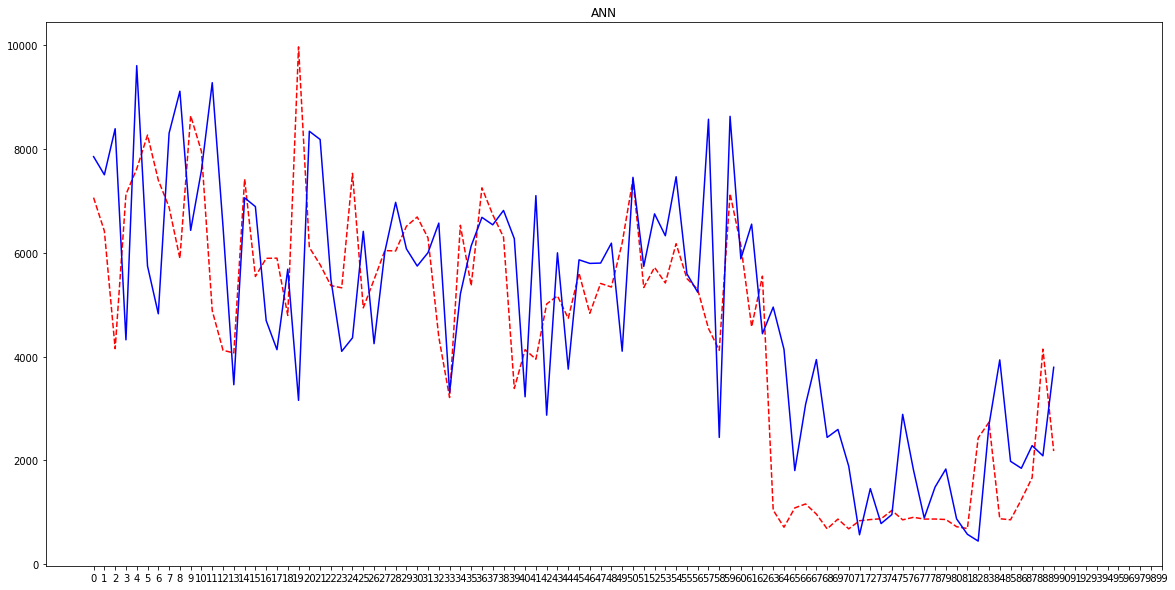

('\n\n House : ', 6324)
(195, 168)
(195, 1)
(195, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
136/136 [==============================] - 0s - loss: 46270464.0000 - mean_squared_error: 46270464.0000
Epoch 2/750
136/136 [==============================] - 0s - loss: 46236076.0000 - mean_squared_error: 46236076.0000
Epoch 3/750
136/136 [==============================] - 0s - loss: 46195932.0000 - mean_squared_error: 46195932.0000
Epoch 4/750
136/136 [==============================] - 0s - loss: 46149360.0000 - mean_squared_error: 46149360.0000
Epoch 5/750
136/136 [==============================] - 0s - loss: 46094624.0000 - mean_squared_error: 46094624.0000
Epoch 6/750
136/136 [==============================] - 0s - loss: 46031096.0000 - mean_squared_error: 46031096.0000


136/136 [==============================] - 0s - loss: 12987124.0000 - mean_squared_error: 12987124.0000
Epoch 69/750
136/136 [==============================] - 0s - loss: 12929026.0000 - mean_squared_error: 12929026.0000
Epoch 70/750
136/136 [==============================] - 0s - loss: 12907721.0000 - mean_squared_error: 12907721.0000
Epoch 71/750
136/136 [==============================] - 0s - loss: 12912939.0000 - mean_squared_error: 12912939.0000
Epoch 72/750
136/136 [==============================] - 0s - loss: 12934323.0000 - mean_squared_error: 12934323.0000
Epoch 73/750
136/136 [==============================] - 0s - loss: 12961905.0000 - mean_squared_error: 12961905.0000
Epoch 74/750
136/136 [==============================] - 0s - loss: 12987028.0000 - mean_squared_error: 12987028.0000
Epoch 75/750
136/136 [==============================] - 0s - loss: 13002673.0000 - mean_squared_error: 13002673.0000
Epoch 76/750
136/136 [==============================] - 0s - loss: 13003727.0

136/136 [==============================] - 0s - loss: 9565054.0000 - mean_squared_error: 9565054.0000
Epoch 138/750
136/136 [==============================] - 0s - loss: 9513528.0000 - mean_squared_error: 9513528.0000
Epoch 139/750
136/136 [==============================] - 0s - loss: 9461984.0000 - mean_squared_error: 9461984.0000
Epoch 140/750
136/136 [==============================] - 0s - loss: 9410419.0000 - mean_squared_error: 9410419.0000
Epoch 141/750
136/136 [==============================] - 0s - loss: 9358821.0000 - mean_squared_error: 9358821.0000
Epoch 142/750
136/136 [==============================] - 0s - loss: 9307186.0000 - mean_squared_error: 9307186.0000
Epoch 143/750
136/136 [==============================] - 0s - loss: 9255499.0000 - mean_squared_error: 9255499.0000
Epoch 144/750
136/136 [==============================] - 0s - loss: 9203750.0000 - mean_squared_error: 9203750.0000
Epoch 145/750
136/136 [==============================] - 0s - loss: 9151940.0000 - mea

136/136 [==============================] - 0s - loss: 6040756.0000 - mean_squared_error: 6040756.0000
Epoch 208/750
136/136 [==============================] - 0s - loss: 5996504.5000 - mean_squared_error: 5996504.5000
Epoch 209/750
136/136 [==============================] - 0s - loss: 5952594.0000 - mean_squared_error: 5952594.0000
Epoch 210/750
136/136 [==============================] - 0s - loss: 5908951.5000 - mean_squared_error: 5908951.5000
Epoch 211/750
136/136 [==============================] - 0s - loss: 5865577.0000 - mean_squared_error: 5865577.0000
Epoch 212/750
136/136 [==============================] - 0s - loss: 5822587.5000 - mean_squared_error: 5822587.5000
Epoch 213/750
136/136 [==============================] - 0s - loss: 5779907.5000 - mean_squared_error: 5779907.5000
Epoch 214/750
136/136 [==============================] - 0s - loss: 5737519.0000 - mean_squared_error: 5737519.0000
Epoch 215/750
136/136 [==============================] - 0s - loss: 5695451.5000 - mea

136/136 [==============================] - 0s - loss: 3721609.5000 - mean_squared_error: 3721609.5000
Epoch 278/750
136/136 [==============================] - 0s - loss: 3698768.0000 - mean_squared_error: 3698768.0000
Epoch 279/750
136/136 [==============================] - 0s - loss: 3676082.5000 - mean_squared_error: 3676082.5000
Epoch 280/750
136/136 [==============================] - 0s - loss: 3653567.5000 - mean_squared_error: 3653567.5000
Epoch 281/750
136/136 [==============================] - 0s - loss: 3631251.7500 - mean_squared_error: 3631251.7500
Epoch 282/750
136/136 [==============================] - 0s - loss: 3609190.0000 - mean_squared_error: 3609190.0000
Epoch 283/750
136/136 [==============================] - 0s - loss: 3587312.5000 - mean_squared_error: 3587312.5000
Epoch 284/750
136/136 [==============================] - 0s - loss: 3565631.2500 - mean_squared_error: 3565631.2500
Epoch 285/750
136/136 [==============================] - 0s - loss: 3544102.0000 - mea

136/136 [==============================] - 0s - loss: 2378262.0000 - mean_squared_error: 2378262.0000
Epoch 348/750
136/136 [==============================] - 0s - loss: 2362238.0000 - mean_squared_error: 2362238.0000
Epoch 349/750
136/136 [==============================] - 0s - loss: 2345831.5000 - mean_squared_error: 2345831.5000
Epoch 350/750
136/136 [==============================] - 0s - loss: 2329824.0000 - mean_squared_error: 2329824.0000
Epoch 351/750
136/136 [==============================] - 0s - loss: 2313732.0000 - mean_squared_error: 2313732.0000
Epoch 352/750
136/136 [==============================] - 0s - loss: 2297884.5000 - mean_squared_error: 2297884.5000
Epoch 353/750
136/136 [==============================] - 0s - loss: 2281971.2500 - mean_squared_error: 2281971.2500
Epoch 354/750
136/136 [==============================] - 0s - loss: 2266212.2500 - mean_squared_error: 2266212.2500
Epoch 355/750
136/136 [==============================] - 0s - loss: 2250514.2500 - mea

136/136 [==============================] - 0s - loss: 1426479.1250 - mean_squared_error: 1426479.1250
Epoch 418/750
136/136 [==============================] - 0s - loss: 1415434.7500 - mean_squared_error: 1415434.7500
Epoch 419/750
136/136 [==============================] - 0s - loss: 1404355.5000 - mean_squared_error: 1404355.5000
Epoch 420/750
136/136 [==============================] - 0s - loss: 1393338.1250 - mean_squared_error: 1393338.1250
Epoch 421/750
136/136 [==============================] - 0s - loss: 1382383.6250 - mean_squared_error: 1382383.6250
Epoch 422/750
136/136 [==============================] - 0s - loss: 1371574.3750 - mean_squared_error: 1371574.3750
Epoch 423/750
136/136 [==============================] - 0s - loss: 1360834.3750 - mean_squared_error: 1360834.3750
Epoch 424/750
136/136 [==============================] - 0s - loss: 1350180.0000 - mean_squared_error: 1350180.0000
Epoch 425/750
136/136 [==============================] - 0s - loss: 1339519.2500 - mea

136/136 [==============================] - 0s - loss: 769761.6250 - mean_squared_error: 769761.6250
Epoch 489/750
136/136 [==============================] - 0s - loss: 762212.5625 - mean_squared_error: 762212.5625
Epoch 490/750
136/136 [==============================] - 0s - loss: 754684.6875 - mean_squared_error: 754684.6875
Epoch 491/750
136/136 [==============================] - 0s - loss: 747198.8750 - mean_squared_error: 747198.8750
Epoch 492/750
136/136 [==============================] - 0s - loss: 739779.1250 - mean_squared_error: 739779.1250
Epoch 493/750
136/136 [==============================] - 0s - loss: 732456.5625 - mean_squared_error: 732456.5625
Epoch 494/750
136/136 [==============================] - 0s - loss: 725062.4375 - mean_squared_error: 725062.4375
Epoch 495/750
136/136 [==============================] - 0s - loss: 717835.5000 - mean_squared_error: 717835.5000
Epoch 496/750
136/136 [==============================] - 0s - loss: 710638.8125 - mean_squared_error: 

136/136 [==============================] - 0s - loss: 365504.9688 - mean_squared_error: 365504.9688
Epoch 560/750
136/136 [==============================] - 0s - loss: 361522.7500 - mean_squared_error: 361522.7500
Epoch 561/750
136/136 [==============================] - 0s - loss: 357597.0625 - mean_squared_error: 357597.0625
Epoch 562/750
136/136 [==============================] - 0s - loss: 353628.1562 - mean_squared_error: 353628.1562
Epoch 563/750
136/136 [==============================] - 0s - loss: 349713.2812 - mean_squared_error: 349713.2812
Epoch 564/750
136/136 [==============================] - 0s - loss: 345762.4688 - mean_squared_error: 345762.4688
Epoch 565/750
136/136 [==============================] - 0s - loss: 341856.7500 - mean_squared_error: 341856.7500
Epoch 566/750
136/136 [==============================] - 0s - loss: 338119.7188 - mean_squared_error: 338119.7188
Epoch 567/750
136/136 [==============================] - 0s - loss: 334216.9375 - mean_squared_error: 

136/136 [==============================] - 0s - loss: 164174.3750 - mean_squared_error: 164174.3750
Epoch 631/750
136/136 [==============================] - 0s - loss: 162455.1250 - mean_squared_error: 162455.1250
Epoch 632/750
136/136 [==============================] - 0s - loss: 160742.3438 - mean_squared_error: 160742.3438
Epoch 633/750
136/136 [==============================] - 0s - loss: 159085.3281 - mean_squared_error: 159085.3281
Epoch 634/750
136/136 [==============================] - 0s - loss: 157432.0781 - mean_squared_error: 157432.0781
Epoch 635/750
136/136 [==============================] - 0s - loss: 155787.3125 - mean_squared_error: 155787.3125
Epoch 636/750
136/136 [==============================] - 0s - loss: 154160.3750 - mean_squared_error: 154160.3750
Epoch 637/750
136/136 [==============================] - 0s - loss: 152569.2031 - mean_squared_error: 152569.2031
Epoch 638/750
136/136 [==============================] - 0s - loss: 150996.7031 - mean_squared_error: 

136/136 [==============================] - 0s - loss: 81722.0859 - mean_squared_error: 81722.0859
Epoch 703/750
136/136 [==============================] - 0s - loss: 81008.3203 - mean_squared_error: 81008.3203
Epoch 704/750
136/136 [==============================] - 0s - loss: 80292.7422 - mean_squared_error: 80292.7422
Epoch 705/750
136/136 [==============================] - 0s - loss: 79580.8125 - mean_squared_error: 79580.8125
Epoch 706/750
136/136 [==============================] - 0s - loss: 78881.9297 - mean_squared_error: 78881.9297
Epoch 707/750
136/136 [==============================] - 0s - loss: 78179.9609 - mean_squared_error: 78179.9609
Epoch 708/750
136/136 [==============================] - 0s - loss: 77498.4688 - mean_squared_error: 77498.4688
Epoch 709/750
136/136 [==============================] - 0s - loss: 76814.0312 - mean_squared_error: 76814.0312
Epoch 710/750
136/136 [==============================] - 0s - loss: 76146.7422 - mean_squared_error: 76146.7422
Epoch 

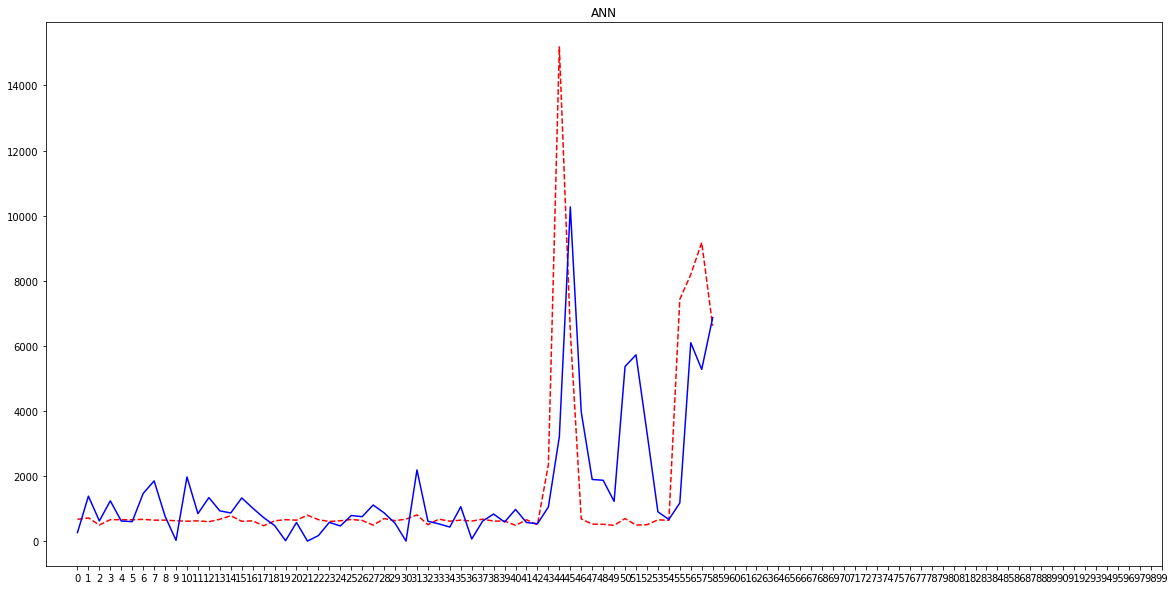

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
136/136 [==============================] - 0s - loss: 46361888.0000 - mean_squared_error: 46361888.0000
Epoch 2/750
136/136 [==============================] - 0s - loss: 46343320.0000 - mean_squared_error: 46343320.0000
Epoch 3/750
136/136 [==============================] - 0s - loss: 46328728.0000 - mean_squared_error: 46328728.0000
Epoch 4/750
136/136 [==============================] - 0s - loss: 46315316.0000 - mean_squared_error: 46315316.0000
Epoch 5/750
136/136 [==============================] - 0s - loss: 46301156.0000 - mean_squared_error: 46301156.0000
Epoch 6/750
136/136 [==============================] - 0s - loss: 46285080.0000 - mean_squared_error: 46285080.0000
Epoch 7/750
136/136 [==============================] - 

136/136 [==============================] - 0s - loss: 23104278.0000 - mean_squared_error: 23104278.0000
Epoch 69/750
136/136 [==============================] - 0s - loss: 22258178.0000 - mean_squared_error: 22258178.0000
Epoch 70/750
136/136 [==============================] - 0s - loss: 21424088.0000 - mean_squared_error: 21424088.0000
Epoch 71/750
136/136 [==============================] - 0s - loss: 20606704.0000 - mean_squared_error: 20606704.0000
Epoch 72/750
136/136 [==============================] - 0s - loss: 19810650.0000 - mean_squared_error: 19810650.0000
Epoch 73/750
136/136 [==============================] - 0s - loss: 19040402.0000 - mean_squared_error: 19040402.0000
Epoch 74/750
136/136 [==============================] - 0s - loss: 18300752.0000 - mean_squared_error: 18300752.0000
Epoch 75/750
136/136 [==============================] - 0s - loss: 17596478.0000 - mean_squared_error: 17596478.0000
Epoch 76/750
136/136 [==============================] - 0s - loss: 16932050.0

136/136 [==============================] - 0s - loss: 10805408.0000 - mean_squared_error: 10805408.0000
Epoch 138/750
136/136 [==============================] - 0s - loss: 10759349.0000 - mean_squared_error: 10759349.0000
Epoch 139/750
136/136 [==============================] - 0s - loss: 10713399.0000 - mean_squared_error: 10713399.0000
Epoch 140/750
136/136 [==============================] - 0s - loss: 10667540.0000 - mean_squared_error: 10667540.0000
Epoch 141/750
136/136 [==============================] - 0s - loss: 10621719.0000 - mean_squared_error: 10621719.0000
Epoch 142/750
136/136 [==============================] - 0s - loss: 10575895.0000 - mean_squared_error: 10575895.0000
Epoch 143/750
136/136 [==============================] - 0s - loss: 10529890.0000 - mean_squared_error: 10529890.0000
Epoch 144/750
136/136 [==============================] - 0s - loss: 10483959.0000 - mean_squared_error: 10483959.0000
Epoch 145/750
136/136 [==============================] - 0s - loss: 10

136/136 [==============================] - 0s - loss: 7383586.5000 - mean_squared_error: 7383586.5000
Epoch 208/750
136/136 [==============================] - 0s - loss: 7334732.5000 - mean_squared_error: 7334732.5000
Epoch 209/750
136/136 [==============================] - 0s - loss: 7285984.0000 - mean_squared_error: 7285984.0000
Epoch 210/750
136/136 [==============================] - 0s - loss: 7237423.5000 - mean_squared_error: 7237423.5000
Epoch 211/750
136/136 [==============================] - 0s - loss: 7189039.5000 - mean_squared_error: 7189039.5000
Epoch 212/750
136/136 [==============================] - 0s - loss: 7140713.5000 - mean_squared_error: 7140713.5000
Epoch 213/750
136/136 [==============================] - 0s - loss: 7092484.0000 - mean_squared_error: 7092484.0000
Epoch 214/750
136/136 [==============================] - 0s - loss: 7044358.0000 - mean_squared_error: 7044358.0000
Epoch 215/750
136/136 [==============================] - 0s - loss: 6996292.0000 - mea

136/136 [==============================] - 0s - loss: 4289384.5000 - mean_squared_error: 4289384.5000
Epoch 278/750
136/136 [==============================] - 0s - loss: 4253544.5000 - mean_squared_error: 4253544.5000
Epoch 279/750
136/136 [==============================] - 0s - loss: 4217982.0000 - mean_squared_error: 4217982.0000
Epoch 280/750
136/136 [==============================] - 0s - loss: 4182781.7500 - mean_squared_error: 4182781.7500
Epoch 281/750
136/136 [==============================] - 0s - loss: 4148017.0000 - mean_squared_error: 4148017.0000
Epoch 282/750
136/136 [==============================] - 0s - loss: 4113543.5000 - mean_squared_error: 4113543.5000
Epoch 283/750
136/136 [==============================] - 0s - loss: 4079333.7500 - mean_squared_error: 4079333.7500
Epoch 284/750
136/136 [==============================] - 0s - loss: 4045526.5000 - mean_squared_error: 4045526.5000
Epoch 285/750
136/136 [==============================] - 0s - loss: 4011976.5000 - mea

136/136 [==============================] - 0s - loss: 2390886.0000 - mean_squared_error: 2390886.0000
Epoch 348/750
136/136 [==============================] - 0s - loss: 2370148.5000 - mean_squared_error: 2370148.5000
Epoch 349/750
136/136 [==============================] - 0s - loss: 2349146.0000 - mean_squared_error: 2349146.0000
Epoch 350/750
136/136 [==============================] - 0s - loss: 2328734.0000 - mean_squared_error: 2328734.0000
Epoch 351/750
136/136 [==============================] - 0s - loss: 2308170.5000 - mean_squared_error: 2308170.5000
Epoch 352/750
136/136 [==============================] - 0s - loss: 2288082.7500 - mean_squared_error: 2288082.7500
Epoch 353/750
136/136 [==============================] - 0s - loss: 2267905.5000 - mean_squared_error: 2267905.5000
Epoch 354/750
136/136 [==============================] - 0s - loss: 2247852.2500 - mean_squared_error: 2247852.2500
Epoch 355/750
136/136 [==============================] - 0s - loss: 2227871.5000 - mea

136/136 [==============================] - 0s - loss: 1190264.2500 - mean_squared_error: 1190264.2500
Epoch 418/750
136/136 [==============================] - 0s - loss: 1175236.2500 - mean_squared_error: 1175236.2500
Epoch 419/750
136/136 [==============================] - 0s - loss: 1160053.5000 - mean_squared_error: 1160053.5000
Epoch 420/750
136/136 [==============================] - 0s - loss: 1145283.3750 - mean_squared_error: 1145283.3750
Epoch 421/750
136/136 [==============================] - 0s - loss: 1130307.7500 - mean_squared_error: 1130307.7500
Epoch 422/750
136/136 [==============================] - 0s - loss: 1115399.3750 - mean_squared_error: 1115399.3750
Epoch 423/750
136/136 [==============================] - 0s - loss: 1100737.1250 - mean_squared_error: 1100737.1250
Epoch 424/750
136/136 [==============================] - 0s - loss: 1086011.7500 - mean_squared_error: 1086011.7500
Epoch 425/750
136/136 [==============================] - 0s - loss: 1071264.8750 - mea

136/136 [==============================] - 0s - loss: 409430.1250 - mean_squared_error: 409430.1250
Epoch 489/750
136/136 [==============================] - 0s - loss: 401973.3438 - mean_squared_error: 401973.3438
Epoch 490/750
136/136 [==============================] - 0s - loss: 394549.6875 - mean_squared_error: 394549.6875
Epoch 491/750
136/136 [==============================] - 0s - loss: 387160.0000 - mean_squared_error: 387160.0000
Epoch 492/750
136/136 [==============================] - 0s - loss: 379893.1875 - mean_squared_error: 379893.1875
Epoch 493/750
136/136 [==============================] - 0s - loss: 372769.2500 - mean_squared_error: 372769.2500
Epoch 494/750
136/136 [==============================] - 0s - loss: 365655.5938 - mean_squared_error: 365655.5938
Epoch 495/750
136/136 [==============================] - 0s - loss: 358715.3438 - mean_squared_error: 358715.3438
Epoch 496/750
136/136 [==============================] - 0s - loss: 351947.5312 - mean_squared_error: 

136/136 [==============================] - 0s - loss: 106950.6953 - mean_squared_error: 106950.6953
Epoch 560/750
136/136 [==============================] - 0s - loss: 105310.0000 - mean_squared_error: 105310.0000
Epoch 561/750
136/136 [==============================] - 0s - loss: 103732.3750 - mean_squared_error: 103732.3750
Epoch 562/750
136/136 [==============================] - 0s - loss: 102191.7812 - mean_squared_error: 102191.7812
Epoch 563/750
136/136 [==============================] - 0s - loss: 100713.5000 - mean_squared_error: 100713.5000
Epoch 564/750
136/136 [==============================] - 0s - loss: 99284.8438 - mean_squared_error: 99284.8438
Epoch 565/750
136/136 [==============================] - 0s - loss: 97843.5625 - mean_squared_error: 97843.5625
Epoch 566/750
136/136 [==============================] - 0s - loss: 96428.6562 - mean_squared_error: 96428.6562
Epoch 567/750
136/136 [==============================] - 0s - loss: 95083.2500 - mean_squared_error: 95083.2

136/136 [==============================] - 0s - loss: 49155.7031 - mean_squared_error: 49155.7031
Epoch 633/750
136/136 [==============================] - 0s - loss: 48797.2070 - mean_squared_error: 48797.2070
Epoch 634/750
136/136 [==============================] - 0s - loss: 48456.9766 - mean_squared_error: 48456.9766
Epoch 635/750
136/136 [==============================] - 0s - loss: 48106.8594 - mean_squared_error: 48106.8594
Epoch 636/750
136/136 [==============================] - 0s - loss: 47770.6992 - mean_squared_error: 47770.6992
Epoch 637/750
136/136 [==============================] - 0s - loss: 47436.4727 - mean_squared_error: 47436.4727
Epoch 638/750
136/136 [==============================] - 0s - loss: 47115.4805 - mean_squared_error: 47115.4805
Epoch 639/750
136/136 [==============================] - 0s - loss: 46788.9492 - mean_squared_error: 46788.9492
Epoch 640/750
136/136 [==============================] - 0s - loss: 46479.6328 - mean_squared_error: 46479.6328
Epoch 

136/136 [==============================] - 0s - loss: 32176.2754 - mean_squared_error: 32176.2754
Epoch 706/750
136/136 [==============================] - 0s - loss: 32023.9082 - mean_squared_error: 32023.9082
Epoch 707/750
136/136 [==============================] - 0s - loss: 31870.3965 - mean_squared_error: 31870.3965
Epoch 708/750
136/136 [==============================] - 0s - loss: 31720.3242 - mean_squared_error: 31720.3242
Epoch 709/750
136/136 [==============================] - 0s - loss: 31570.4629 - mean_squared_error: 31570.4629
Epoch 710/750
136/136 [==============================] - 0s - loss: 31423.0625 - mean_squared_error: 31423.0625
Epoch 711/750
136/136 [==============================] - 0s - loss: 31276.5508 - mean_squared_error: 31276.5508
Epoch 712/750
136/136 [==============================] - 0s - loss: 31127.6719 - mean_squared_error: 31127.6719
Epoch 713/750
136/136 [==============================] - 0s - loss: 30984.7500 - mean_squared_error: 30984.7500
Epoch 

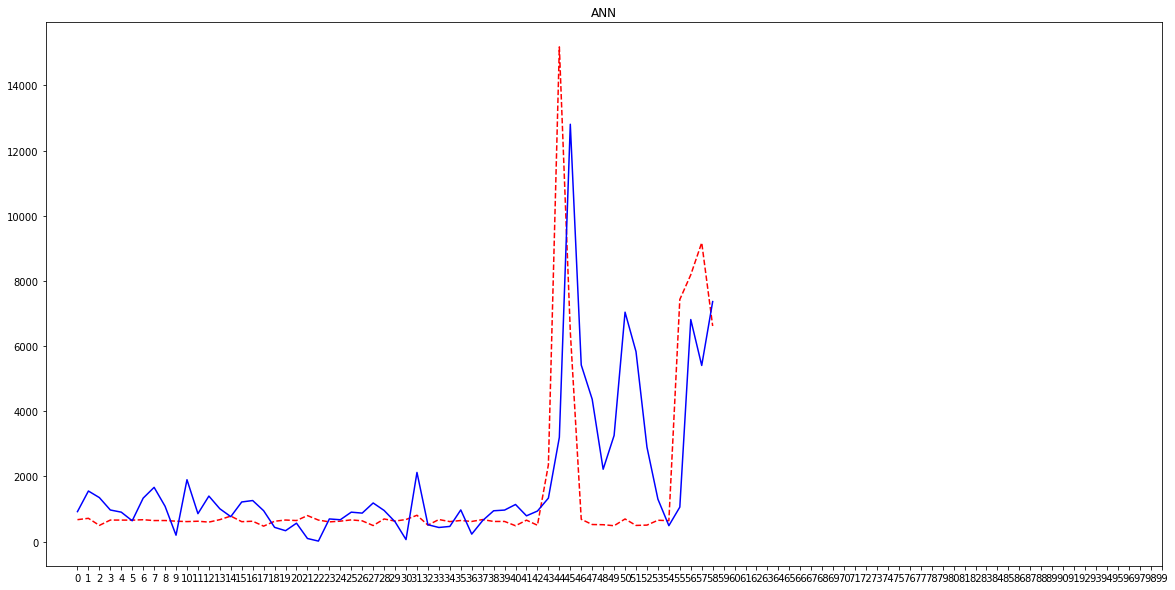

('\n\n House : ', 6614)
(445, 168)
(445, 1)
(445, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
311/311 [==============================] - 0s - loss: 65032652.0000 - mean_squared_error: 65032652.0000
Epoch 2/750
311/311 [==============================] - 0s - loss: 64997120.0000 - mean_squared_error: 64997120.0000
Epoch 3/750
311/311 [==============================] - 0s - loss: 64966392.0000 - mean_squared_error: 64966392.0000
Epoch 4/750
311/311 [==============================] - 0s - loss: 64940024.0000 - mean_squared_error: 64940024.0000
Epoch 5/750
311/311 [==============================] - 0s - loss: 64915336.0000 - mean_squared_error: 64915336.0000
Epoch 6/750
311/311 [==============================] - 0s - loss: 64888712.0000 - mean_squared_error: 64888712.0000


311/311 [==============================] - 0s - loss: 47766596.0000 - mean_squared_error: 47766596.0000
Epoch 69/750
311/311 [==============================] - 0s - loss: 47064116.0000 - mean_squared_error: 47064116.0000
Epoch 70/750
311/311 [==============================] - 0s - loss: 46350032.0000 - mean_squared_error: 46350032.0000
Epoch 71/750
311/311 [==============================] - 0s - loss: 45624888.0000 - mean_squared_error: 45624888.0000
Epoch 72/750
311/311 [==============================] - 0s - loss: 44889624.0000 - mean_squared_error: 44889624.0000
Epoch 73/750
311/311 [==============================] - 0s - loss: 44144980.0000 - mean_squared_error: 44144980.0000
Epoch 74/750
311/311 [==============================] - 0s - loss: 43392700.0000 - mean_squared_error: 43392700.0000
Epoch 75/750
311/311 [==============================] - 0s - loss: 42633768.0000 - mean_squared_error: 42633768.0000
Epoch 76/750
311/311 [==============================] - 0s - loss: 41870380.0

311/311 [==============================] - 0s - loss: 23836976.0000 - mean_squared_error: 23836976.0000
Epoch 138/750
311/311 [==============================] - 0s - loss: 23787812.0000 - mean_squared_error: 23787812.0000
Epoch 139/750
311/311 [==============================] - 0s - loss: 23739204.0000 - mean_squared_error: 23739204.0000
Epoch 140/750
311/311 [==============================] - 0s - loss: 23690988.0000 - mean_squared_error: 23690988.0000
Epoch 141/750
311/311 [==============================] - 0s - loss: 23643152.0000 - mean_squared_error: 23643152.0000
Epoch 142/750
311/311 [==============================] - 0s - loss: 23595698.0000 - mean_squared_error: 23595698.0000
Epoch 143/750
311/311 [==============================] - 0s - loss: 23548914.0000 - mean_squared_error: 23548914.0000
Epoch 144/750
311/311 [==============================] - 0s - loss: 23502348.0000 - mean_squared_error: 23502348.0000
Epoch 145/750
311/311 [==============================] - 0s - loss: 23

311/311 [==============================] - 0s - loss: 20275280.0000 - mean_squared_error: 20275280.0000
Epoch 207/750
311/311 [==============================] - 0s - loss: 20216794.0000 - mean_squared_error: 20216794.0000
Epoch 208/750
311/311 [==============================] - 0s - loss: 20158398.0000 - mean_squared_error: 20158398.0000
Epoch 209/750
311/311 [==============================] - 0s - loss: 20099356.0000 - mean_squared_error: 20099356.0000
Epoch 210/750
311/311 [==============================] - 0s - loss: 20039716.0000 - mean_squared_error: 20039716.0000
Epoch 211/750
311/311 [==============================] - 0s - loss: 19979956.0000 - mean_squared_error: 19979956.0000
Epoch 212/750
311/311 [==============================] - 0s - loss: 19920428.0000 - mean_squared_error: 19920428.0000
Epoch 213/750
311/311 [==============================] - 0s - loss: 19860782.0000 - mean_squared_error: 19860782.0000
Epoch 214/750
311/311 [==============================] - 0s - loss: 19

311/311 [==============================] - 0s - loss: 16130410.0000 - mean_squared_error: 16130410.0000
Epoch 276/750
311/311 [==============================] - 0s - loss: 16072429.0000 - mean_squared_error: 16072429.0000
Epoch 277/750
311/311 [==============================] - 0s - loss: 16014476.0000 - mean_squared_error: 16014476.0000
Epoch 278/750
311/311 [==============================] - 0s - loss: 15956765.0000 - mean_squared_error: 15956765.0000
Epoch 279/750
311/311 [==============================] - 0s - loss: 15899337.0000 - mean_squared_error: 15899337.0000
Epoch 280/750
311/311 [==============================] - 0s - loss: 15841991.0000 - mean_squared_error: 15841991.0000
Epoch 281/750
311/311 [==============================] - 0s - loss: 15784601.0000 - mean_squared_error: 15784601.0000
Epoch 282/750
311/311 [==============================] - 0s - loss: 15727305.0000 - mean_squared_error: 15727305.0000
Epoch 283/750
311/311 [==============================] - 0s - loss: 15

311/311 [==============================] - 0s - loss: 12280338.0000 - mean_squared_error: 12280338.0000
Epoch 345/750
311/311 [==============================] - 0s - loss: 12227231.0000 - mean_squared_error: 12227231.0000
Epoch 346/750
311/311 [==============================] - 0s - loss: 12174292.0000 - mean_squared_error: 12174292.0000
Epoch 347/750
311/311 [==============================] - 0s - loss: 12121272.0000 - mean_squared_error: 12121272.0000
Epoch 348/750
311/311 [==============================] - 0s - loss: 12068208.0000 - mean_squared_error: 12068208.0000
Epoch 349/750
311/311 [==============================] - 0s - loss: 12015293.0000 - mean_squared_error: 12015293.0000
Epoch 350/750
311/311 [==============================] - 0s - loss: 11962557.0000 - mean_squared_error: 11962557.0000
Epoch 351/750
311/311 [==============================] - 0s - loss: 11909822.0000 - mean_squared_error: 11909822.0000
Epoch 352/750
311/311 [==============================] - 0s - loss: 11

311/311 [==============================] - 0s - loss: 8985078.0000 - mean_squared_error: 8985078.0000
Epoch 414/750
311/311 [==============================] - 0s - loss: 8942306.0000 - mean_squared_error: 8942306.0000
Epoch 415/750
311/311 [==============================] - 0s - loss: 8899548.0000 - mean_squared_error: 8899548.0000
Epoch 416/750
311/311 [==============================] - 0s - loss: 8857416.0000 - mean_squared_error: 8857416.0000
Epoch 417/750
311/311 [==============================] - 0s - loss: 8815477.0000 - mean_squared_error: 8815477.0000
Epoch 418/750
311/311 [==============================] - 0s - loss: 8773616.0000 - mean_squared_error: 8773616.0000
Epoch 419/750
311/311 [==============================] - 0s - loss: 8731433.0000 - mean_squared_error: 8731433.0000
Epoch 420/750
311/311 [==============================] - 0s - loss: 8689303.0000 - mean_squared_error: 8689303.0000
Epoch 421/750
311/311 [==============================] - 0s - loss: 8647101.0000 - mea

311/311 [==============================] - 0s - loss: 6375686.0000 - mean_squared_error: 6375686.0000
Epoch 484/750
311/311 [==============================] - 0s - loss: 6344125.5000 - mean_squared_error: 6344125.5000
Epoch 485/750
311/311 [==============================] - 0s - loss: 6312161.0000 - mean_squared_error: 6312161.0000
Epoch 486/750
311/311 [==============================] - 0s - loss: 6280647.5000 - mean_squared_error: 6280647.5000
Epoch 487/750
311/311 [==============================] - 0s - loss: 6249352.0000 - mean_squared_error: 6249352.0000
Epoch 488/750
311/311 [==============================] - 0s - loss: 6218325.0000 - mean_squared_error: 6218325.0000
Epoch 489/750
311/311 [==============================] - 0s - loss: 6187413.0000 - mean_squared_error: 6187413.0000
Epoch 490/750
311/311 [==============================] - 0s - loss: 6156405.5000 - mean_squared_error: 6156405.5000
Epoch 491/750
311/311 [==============================] - 0s - loss: 6126014.0000 - mea

311/311 [==============================] - 0s - loss: 4524351.0000 - mean_squared_error: 4524351.0000
Epoch 554/750
311/311 [==============================] - 0s - loss: 4503198.0000 - mean_squared_error: 4503198.0000
Epoch 555/750
311/311 [==============================] - 0s - loss: 4481542.0000 - mean_squared_error: 4481542.0000
Epoch 556/750
311/311 [==============================] - 0s - loss: 4460203.0000 - mean_squared_error: 4460203.0000
Epoch 557/750
311/311 [==============================] - 0s - loss: 4438969.0000 - mean_squared_error: 4438969.0000
Epoch 558/750
311/311 [==============================] - 0s - loss: 4417825.0000 - mean_squared_error: 4417825.0000
Epoch 559/750
311/311 [==============================] - 0s - loss: 4396900.0000 - mean_squared_error: 4396900.0000
Epoch 560/750
311/311 [==============================] - 0s - loss: 4375795.0000 - mean_squared_error: 4375795.0000
Epoch 561/750
311/311 [==============================] - 0s - loss: 4355004.5000 - mea

311/311 [==============================] - 0s - loss: 3246866.0000 - mean_squared_error: 3246866.0000
Epoch 624/750
311/311 [==============================] - 0s - loss: 3231658.5000 - mean_squared_error: 3231658.5000
Epoch 625/750
311/311 [==============================] - 0s - loss: 3216483.0000 - mean_squared_error: 3216483.0000
Epoch 626/750
311/311 [==============================] - 0s - loss: 3201557.2500 - mean_squared_error: 3201557.2500
Epoch 627/750
311/311 [==============================] - 0s - loss: 3186673.5000 - mean_squared_error: 3186673.5000
Epoch 628/750
311/311 [==============================] - 0s - loss: 3171868.5000 - mean_squared_error: 3171868.5000
Epoch 629/750
311/311 [==============================] - 0s - loss: 3156979.7500 - mean_squared_error: 3156979.7500
Epoch 630/750
311/311 [==============================] - 0s - loss: 3142172.7500 - mean_squared_error: 3142172.7500
Epoch 631/750
311/311 [==============================] - 0s - loss: 3127222.2500 - mea

311/311 [==============================] - 0s - loss: 2287453.0000 - mean_squared_error: 2287453.0000
Epoch 694/750
311/311 [==============================] - 0s - loss: 2275311.2500 - mean_squared_error: 2275311.2500
Epoch 695/750
311/311 [==============================] - 0s - loss: 2263031.2500 - mean_squared_error: 2263031.2500
Epoch 696/750
311/311 [==============================] - 0s - loss: 2251006.5000 - mean_squared_error: 2251006.5000
Epoch 697/750
311/311 [==============================] - 0s - loss: 2238767.2500 - mean_squared_error: 2238767.2500
Epoch 698/750
311/311 [==============================] - 0s - loss: 2226943.2500 - mean_squared_error: 2226943.2500
Epoch 699/750
311/311 [==============================] - 0s - loss: 2214790.2500 - mean_squared_error: 2214790.2500
Epoch 700/750
311/311 [==============================] - 0s - loss: 2202826.5000 - mean_squared_error: 2202826.5000
Epoch 701/750
311/311 [==============================] - 0s - loss: 2190945.0000 - mea

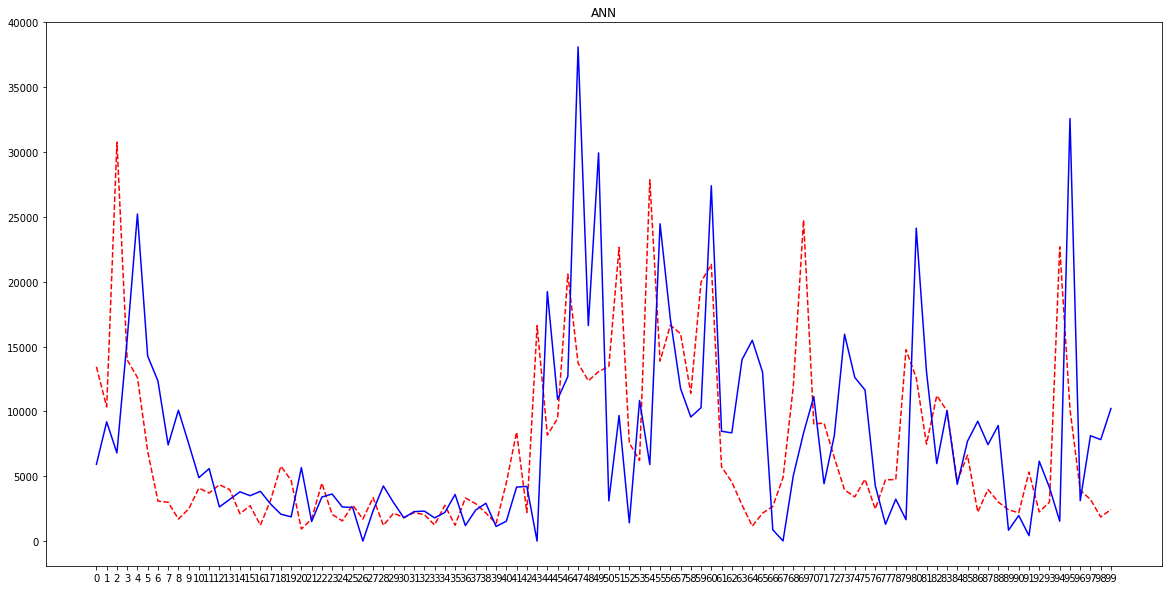

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
311/311 [==============================] - 0s - loss: 65015848.0000 - mean_squared_error: 65015848.0000
Epoch 2/750
311/311 [==============================] - 0s - loss: 64983712.0000 - mean_squared_error: 64983712.0000
Epoch 3/750
311/311 [==============================] - 0s - loss: 64956588.0000 - mean_squared_error: 64956588.0000
Epoch 4/750
311/311 [==============================] - 0s - loss: 64934216.0000 - mean_squared_error: 64934216.0000
Epoch 5/750
311/311 [==============================] - 0s - loss: 64913848.0000 - mean_squared_error: 64913848.0000
Epoch 6/750
311/311 [==============================] - 0s - loss: 64893848.0000 - mean_squared_error: 64893848.0000
Epoch 7/750
311/311 [==============================] - 

311/311 [==============================] - 0s - loss: 46725056.0000 - mean_squared_error: 46725056.0000
Epoch 69/750
311/311 [==============================] - 0s - loss: 45890324.0000 - mean_squared_error: 45890324.0000
Epoch 70/750
311/311 [==============================] - 0s - loss: 45041452.0000 - mean_squared_error: 45041452.0000
Epoch 71/750
311/311 [==============================] - 0s - loss: 44179428.0000 - mean_squared_error: 44179428.0000
Epoch 72/750
311/311 [==============================] - 0s - loss: 43305960.0000 - mean_squared_error: 43305960.0000
Epoch 73/750
311/311 [==============================] - 0s - loss: 42422888.0000 - mean_squared_error: 42422888.0000
Epoch 74/750
311/311 [==============================] - 0s - loss: 41531808.0000 - mean_squared_error: 41531808.0000
Epoch 75/750
311/311 [==============================] - 0s - loss: 40635252.0000 - mean_squared_error: 40635252.0000
Epoch 76/750
311/311 [==============================] - 0s - loss: 39735464.0

311/311 [==============================] - 0s - loss: 23447268.0000 - mean_squared_error: 23447268.0000
Epoch 138/750
311/311 [==============================] - 0s - loss: 23404892.0000 - mean_squared_error: 23404892.0000
Epoch 139/750
311/311 [==============================] - 0s - loss: 23362062.0000 - mean_squared_error: 23362062.0000
Epoch 140/750
311/311 [==============================] - 0s - loss: 23318732.0000 - mean_squared_error: 23318732.0000
Epoch 141/750
311/311 [==============================] - 0s - loss: 23274882.0000 - mean_squared_error: 23274882.0000
Epoch 142/750
311/311 [==============================] - 0s - loss: 23230512.0000 - mean_squared_error: 23230512.0000
Epoch 143/750
311/311 [==============================] - 0s - loss: 23185684.0000 - mean_squared_error: 23185684.0000
Epoch 144/750
311/311 [==============================] - 0s - loss: 23140408.0000 - mean_squared_error: 23140408.0000
Epoch 145/750
311/311 [==============================] - 0s - loss: 23

311/311 [==============================] - 0s - loss: 20161410.0000 - mean_squared_error: 20161410.0000
Epoch 207/750
311/311 [==============================] - 0s - loss: 20110916.0000 - mean_squared_error: 20110916.0000
Epoch 208/750
311/311 [==============================] - 0s - loss: 20060434.0000 - mean_squared_error: 20060434.0000
Epoch 209/750
311/311 [==============================] - 0s - loss: 20009974.0000 - mean_squared_error: 20009974.0000
Epoch 210/750
311/311 [==============================] - 0s - loss: 19959356.0000 - mean_squared_error: 19959356.0000
Epoch 211/750
311/311 [==============================] - 0s - loss: 19908614.0000 - mean_squared_error: 19908614.0000
Epoch 212/750
311/311 [==============================] - 0s - loss: 19857962.0000 - mean_squared_error: 19857962.0000
Epoch 213/750
311/311 [==============================] - 0s - loss: 19807478.0000 - mean_squared_error: 19807478.0000
Epoch 214/750
311/311 [==============================] - 0s - loss: 19

311/311 [==============================] - 0s - loss: 16622070.0000 - mean_squared_error: 16622070.0000
Epoch 276/750
311/311 [==============================] - 0s - loss: 16571832.0000 - mean_squared_error: 16571832.0000
Epoch 277/750
311/311 [==============================] - 0s - loss: 16521534.0000 - mean_squared_error: 16521534.0000
Epoch 278/750
311/311 [==============================] - 0s - loss: 16471300.0000 - mean_squared_error: 16471300.0000
Epoch 279/750
311/311 [==============================] - 0s - loss: 16421104.0000 - mean_squared_error: 16421104.0000
Epoch 280/750
311/311 [==============================] - 0s - loss: 16371055.0000 - mean_squared_error: 16371055.0000
Epoch 281/750
311/311 [==============================] - 0s - loss: 16321108.0000 - mean_squared_error: 16321108.0000
Epoch 282/750
311/311 [==============================] - 0s - loss: 16271355.0000 - mean_squared_error: 16271355.0000
Epoch 283/750
311/311 [==============================] - 0s - loss: 16

311/311 [==============================] - 0s - loss: 13278384.0000 - mean_squared_error: 13278384.0000
Epoch 345/750
311/311 [==============================] - 0s - loss: 13230738.0000 - mean_squared_error: 13230738.0000
Epoch 346/750
311/311 [==============================] - 0s - loss: 13182967.0000 - mean_squared_error: 13182967.0000
Epoch 347/750
311/311 [==============================] - 0s - loss: 13135025.0000 - mean_squared_error: 13135025.0000
Epoch 348/750
311/311 [==============================] - 0s - loss: 13086773.0000 - mean_squared_error: 13086773.0000
Epoch 349/750
311/311 [==============================] - 0s - loss: 13038550.0000 - mean_squared_error: 13038550.0000
Epoch 350/750
311/311 [==============================] - 0s - loss: 12990395.0000 - mean_squared_error: 12990395.0000
Epoch 351/750
311/311 [==============================] - 0s - loss: 12942366.0000 - mean_squared_error: 12942366.0000
Epoch 352/750
311/311 [==============================] - 0s - loss: 12

311/311 [==============================] - 0s - loss: 10011846.0000 - mean_squared_error: 10011846.0000
Epoch 414/750
311/311 [==============================] - 0s - loss: 9964016.0000 - mean_squared_error: 9964016.0000
Epoch 415/750
311/311 [==============================] - 0s - loss: 9916225.0000 - mean_squared_error: 9916225.0000
Epoch 416/750
311/311 [==============================] - 0s - loss: 9868605.0000 - mean_squared_error: 9868605.0000
Epoch 417/750
311/311 [==============================] - 0s - loss: 9820849.0000 - mean_squared_error: 9820849.0000
Epoch 418/750
311/311 [==============================] - 0s - loss: 9773470.0000 - mean_squared_error: 9773470.0000
Epoch 419/750
311/311 [==============================] - 0s - loss: 9727258.0000 - mean_squared_error: 9727258.0000
Epoch 420/750
311/311 [==============================] - 0s - loss: 9681849.0000 - mean_squared_error: 9681849.0000
Epoch 421/750
311/311 [==============================] - 0s - loss: 9636630.0000 - m

311/311 [==============================] - 0s - loss: 7218238.5000 - mean_squared_error: 7218238.5000
Epoch 484/750
311/311 [==============================] - 0s - loss: 7185099.5000 - mean_squared_error: 7185099.5000
Epoch 485/750
311/311 [==============================] - 0s - loss: 7151643.0000 - mean_squared_error: 7151643.0000
Epoch 486/750
311/311 [==============================] - 0s - loss: 7120083.5000 - mean_squared_error: 7120083.5000
Epoch 487/750
311/311 [==============================] - 0s - loss: 7086958.5000 - mean_squared_error: 7086958.5000
Epoch 488/750
311/311 [==============================] - 0s - loss: 7054768.0000 - mean_squared_error: 7054768.0000
Epoch 489/750
311/311 [==============================] - 0s - loss: 7022763.0000 - mean_squared_error: 7022763.0000
Epoch 490/750
311/311 [==============================] - 0s - loss: 6990463.5000 - mean_squared_error: 6990463.5000
Epoch 491/750
311/311 [==============================] - 0s - loss: 6958738.5000 - mea

311/311 [==============================] - 0s - loss: 5048750.5000 - mean_squared_error: 5048750.5000
Epoch 554/750
311/311 [==============================] - 0s - loss: 5019142.0000 - mean_squared_error: 5019142.0000
Epoch 555/750
311/311 [==============================] - 0s - loss: 4989563.0000 - mean_squared_error: 4989563.0000
Epoch 556/750
311/311 [==============================] - 0s - loss: 4960192.0000 - mean_squared_error: 4960192.0000
Epoch 557/750
311/311 [==============================] - 0s - loss: 4931120.5000 - mean_squared_error: 4931120.5000
Epoch 558/750
311/311 [==============================] - 0s - loss: 4902044.5000 - mean_squared_error: 4902044.5000
Epoch 559/750
311/311 [==============================] - 0s - loss: 4873146.0000 - mean_squared_error: 4873146.0000
Epoch 560/750
311/311 [==============================] - 0s - loss: 4843836.5000 - mean_squared_error: 4843836.5000
Epoch 561/750
311/311 [==============================] - 0s - loss: 4814676.5000 - mea

311/311 [==============================] - 0s - loss: 3284636.5000 - mean_squared_error: 3284636.5000
Epoch 624/750
311/311 [==============================] - 0s - loss: 3265020.5000 - mean_squared_error: 3265020.5000
Epoch 625/750
311/311 [==============================] - 0s - loss: 3245432.2500 - mean_squared_error: 3245432.2500
Epoch 626/750
311/311 [==============================] - 0s - loss: 3225893.7500 - mean_squared_error: 3225893.7500
Epoch 627/750
311/311 [==============================] - 0s - loss: 3206658.5000 - mean_squared_error: 3206658.5000
Epoch 628/750
311/311 [==============================] - 0s - loss: 3187514.0000 - mean_squared_error: 3187514.0000
Epoch 629/750
311/311 [==============================] - 0s - loss: 3168799.2500 - mean_squared_error: 3168799.2500
Epoch 630/750
311/311 [==============================] - 0s - loss: 3149990.5000 - mean_squared_error: 3149990.5000
Epoch 631/750
311/311 [==============================] - 0s - loss: 3131632.7500 - mea

311/311 [==============================] - 0s - loss: 2207416.7500 - mean_squared_error: 2207416.7500
Epoch 694/750
311/311 [==============================] - 0s - loss: 2196110.7500 - mean_squared_error: 2196110.7500
Epoch 695/750
311/311 [==============================] - 0s - loss: 2184551.5000 - mean_squared_error: 2184551.5000
Epoch 696/750
311/311 [==============================] - 0s - loss: 2173367.5000 - mean_squared_error: 2173367.5000
Epoch 697/750
311/311 [==============================] - 0s - loss: 2161989.0000 - mean_squared_error: 2161989.0000
Epoch 698/750
311/311 [==============================] - 0s - loss: 2151014.7500 - mean_squared_error: 2151014.7500
Epoch 699/750
311/311 [==============================] - 0s - loss: 2139782.0000 - mean_squared_error: 2139782.0000
Epoch 700/750
311/311 [==============================] - 0s - loss: 2128933.7500 - mean_squared_error: 2128933.7500
Epoch 701/750
311/311 [==============================] - 0s - loss: 2117873.5000 - mea

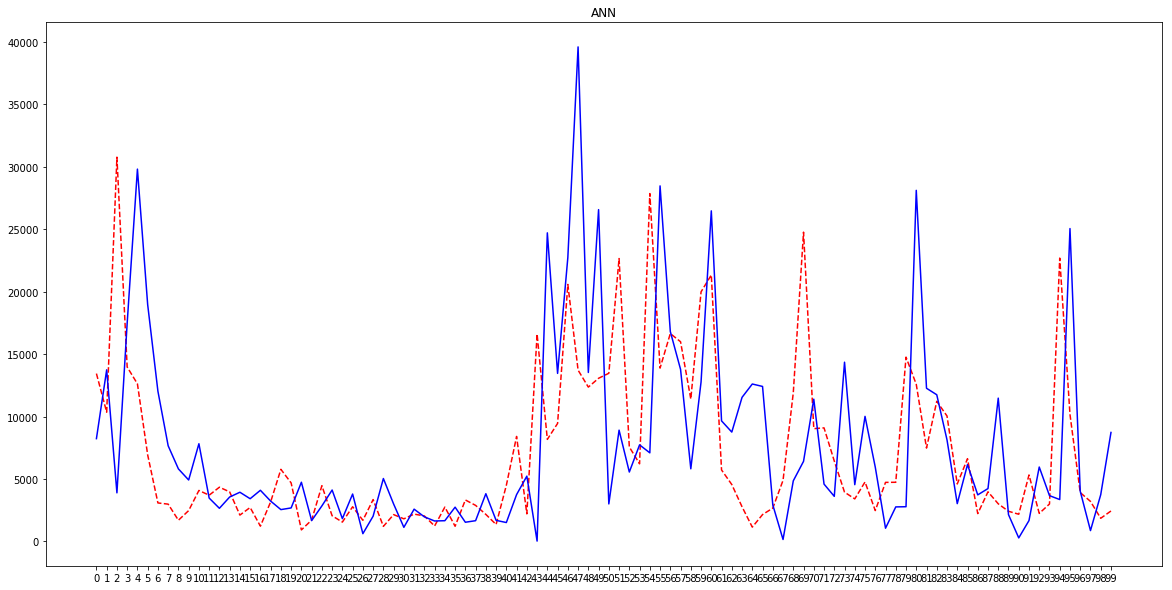

('\n\n House : ', 9912)
(1279, 168)
(1279, 1)
(1279, 169)
1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
895/895 [==============================] - 0s - loss: 70223576.0000 - mean_squared_error: 70223576.0000
Epoch 2/750
895/895 [==============================] - 0s - loss: 70182696.0000 - mean_squared_error: 70182696.0000
Epoch 3/750
895/895 [==============================] - 0s - loss: 70138720.0000 - mean_squared_error: 70138720.0000
Epoch 4/750
895/895 [==============================] - 0s - loss: 70093160.0000 - mean_squared_error: 70093160.0000
Epoch 5/750
895/895 [==============================] - 0s - loss: 70043752.0000 - mean_squared_error: 70043752.0000
Epoch 6/750
895/895 [==============================] - 0s - loss: 69989328.0000 - mean_squared_error: 69989328.00

895/895 [==============================] - 0s - loss: 23465560.0000 - mean_squared_error: 23465560.0000
Epoch 69/750
895/895 [==============================] - 0s - loss: 22800942.0000 - mean_squared_error: 22800942.0000
Epoch 70/750
895/895 [==============================] - 0s - loss: 22238392.0000 - mean_squared_error: 22238392.0000
Epoch 71/750
895/895 [==============================] - 0s - loss: 21778062.0000 - mean_squared_error: 21778062.0000
Epoch 72/750
895/895 [==============================] - 0s - loss: 21417594.0000 - mean_squared_error: 21417594.0000
Epoch 73/750
895/895 [==============================] - 0s - loss: 21151966.0000 - mean_squared_error: 21151966.0000
Epoch 74/750
895/895 [==============================] - 0s - loss: 20973482.0000 - mean_squared_error: 20973482.0000
Epoch 75/750
895/895 [==============================] - 0s - loss: 20871784.0000 - mean_squared_error: 20871784.0000
Epoch 76/750
895/895 [==============================] - 0s - loss: 20834384.0

895/895 [==============================] - 0s - loss: 18625270.0000 - mean_squared_error: 18625270.0000
Epoch 138/750
895/895 [==============================] - 0s - loss: 18590392.0000 - mean_squared_error: 18590392.0000
Epoch 139/750
895/895 [==============================] - 0s - loss: 18555502.0000 - mean_squared_error: 18555502.0000
Epoch 140/750
895/895 [==============================] - 0s - loss: 18520618.0000 - mean_squared_error: 18520618.0000
Epoch 141/750
895/895 [==============================] - 0s - loss: 18485782.0000 - mean_squared_error: 18485782.0000
Epoch 142/750
895/895 [==============================] - 0s - loss: 18451024.0000 - mean_squared_error: 18451024.0000
Epoch 143/750
895/895 [==============================] - 0s - loss: 18416360.0000 - mean_squared_error: 18416360.0000
Epoch 144/750
895/895 [==============================] - 0s - loss: 18381810.0000 - mean_squared_error: 18381810.0000
Epoch 145/750
895/895 [==============================] - 0s - loss: 18

895/895 [==============================] - 0s - loss: 16375919.0000 - mean_squared_error: 16375919.0000
Epoch 207/750
895/895 [==============================] - 0s - loss: 16345590.0000 - mean_squared_error: 16345590.0000
Epoch 208/750
895/895 [==============================] - 0s - loss: 16315343.0000 - mean_squared_error: 16315343.0000
Epoch 209/750
895/895 [==============================] - 0s - loss: 16285166.0000 - mean_squared_error: 16285166.0000
Epoch 210/750
895/895 [==============================] - 0s - loss: 16255068.0000 - mean_squared_error: 16255068.0000
Epoch 211/750
895/895 [==============================] - 0s - loss: 16225047.0000 - mean_squared_error: 16225047.0000
Epoch 212/750
895/895 [==============================] - 0s - loss: 16195102.0000 - mean_squared_error: 16195102.0000
Epoch 213/750
895/895 [==============================] - 0s - loss: 16165236.0000 - mean_squared_error: 16165236.0000
Epoch 214/750
895/895 [==============================] - 0s - loss: 16

895/895 [==============================] - 0s - loss: 14483392.0000 - mean_squared_error: 14483392.0000
Epoch 276/750
895/895 [==============================] - 0s - loss: 14459163.0000 - mean_squared_error: 14459163.0000
Epoch 277/750
895/895 [==============================] - 0s - loss: 14435032.0000 - mean_squared_error: 14435032.0000
Epoch 278/750
895/895 [==============================] - 0s - loss: 14411025.0000 - mean_squared_error: 14411025.0000
Epoch 279/750
895/895 [==============================] - 0s - loss: 14387128.0000 - mean_squared_error: 14387128.0000
Epoch 280/750
895/895 [==============================] - 0s - loss: 14363316.0000 - mean_squared_error: 14363316.0000
Epoch 281/750
895/895 [==============================] - 0s - loss: 14339628.0000 - mean_squared_error: 14339628.0000
Epoch 282/750
895/895 [==============================] - 0s - loss: 14316077.0000 - mean_squared_error: 14316077.0000
Epoch 283/750
895/895 [==============================] - 0s - loss: 14

895/895 [==============================] - 0s - loss: 13026548.0000 - mean_squared_error: 13026548.0000
Epoch 345/750
895/895 [==============================] - 0s - loss: 13008153.0000 - mean_squared_error: 13008153.0000
Epoch 346/750
895/895 [==============================] - 0s - loss: 12989818.0000 - mean_squared_error: 12989818.0000
Epoch 347/750
895/895 [==============================] - 0s - loss: 12971543.0000 - mean_squared_error: 12971543.0000
Epoch 348/750
895/895 [==============================] - 0s - loss: 12953339.0000 - mean_squared_error: 12953339.0000
Epoch 349/750
895/895 [==============================] - 0s - loss: 12935199.0000 - mean_squared_error: 12935199.0000
Epoch 350/750
895/895 [==============================] - 0s - loss: 12917114.0000 - mean_squared_error: 12917114.0000
Epoch 351/750
895/895 [==============================] - 0s - loss: 12899088.0000 - mean_squared_error: 12899088.0000
Epoch 352/750
895/895 [==============================] - 0s - loss: 12

895/895 [==============================] - 0s - loss: 11854194.0000 - mean_squared_error: 11854194.0000
Epoch 414/750
895/895 [==============================] - 0s - loss: 11835677.0000 - mean_squared_error: 11835677.0000
Epoch 415/750
895/895 [==============================] - 0s - loss: 11816799.0000 - mean_squared_error: 11816799.0000
Epoch 416/750
895/895 [==============================] - 0s - loss: 11798356.0000 - mean_squared_error: 11798356.0000
Epoch 417/750
895/895 [==============================] - 0s - loss: 11780443.0000 - mean_squared_error: 11780443.0000
Epoch 418/750
895/895 [==============================] - 0s - loss: 11761949.0000 - mean_squared_error: 11761949.0000
Epoch 419/750
895/895 [==============================] - 0s - loss: 11742699.0000 - mean_squared_error: 11742699.0000
Epoch 420/750
895/895 [==============================] - 0s - loss: 11723397.0000 - mean_squared_error: 11723397.0000
Epoch 421/750
895/895 [==============================] - 0s - loss: 11

895/895 [==============================] - 0s - loss: 10414617.0000 - mean_squared_error: 10414617.0000
Epoch 483/750
895/895 [==============================] - 0s - loss: 10390801.0000 - mean_squared_error: 10390801.0000
Epoch 484/750
895/895 [==============================] - 0s - loss: 10367211.0000 - mean_squared_error: 10367211.0000
Epoch 485/750
895/895 [==============================] - 0s - loss: 10343797.0000 - mean_squared_error: 10343797.0000
Epoch 486/750
895/895 [==============================] - 0s - loss: 10320088.0000 - mean_squared_error: 10320088.0000
Epoch 487/750
895/895 [==============================] - 0s - loss: 10295928.0000 - mean_squared_error: 10295928.0000
Epoch 488/750
895/895 [==============================] - 0s - loss: 10270971.0000 - mean_squared_error: 10270971.0000
Epoch 489/750
895/895 [==============================] - 0s - loss: 10246401.0000 - mean_squared_error: 10246401.0000
Epoch 490/750
895/895 [==============================] - 0s - loss: 10

895/895 [==============================] - 0s - loss: 8696789.0000 - mean_squared_error: 8696789.0000
Epoch 553/750
895/895 [==============================] - 0s - loss: 8674152.0000 - mean_squared_error: 8674152.0000
Epoch 554/750
895/895 [==============================] - 0s - loss: 8651945.0000 - mean_squared_error: 8651945.0000
Epoch 555/750
895/895 [==============================] - 0s - loss: 8629562.0000 - mean_squared_error: 8629562.0000
Epoch 556/750
895/895 [==============================] - 0s - loss: 8607512.0000 - mean_squared_error: 8607512.0000
Epoch 557/750
895/895 [==============================] - 0s - loss: 8585020.0000 - mean_squared_error: 8585020.0000
Epoch 558/750
895/895 [==============================] - 0s - loss: 8563340.0000 - mean_squared_error: 8563340.0000
Epoch 559/750
895/895 [==============================] - 0s - loss: 8541077.0000 - mean_squared_error: 8541077.0000
Epoch 560/750
895/895 [==============================] - 0s - loss: 8519316.0000 - mea

895/895 [==============================] - 0s - loss: 7310418.5000 - mean_squared_error: 7310418.5000
Epoch 623/750
895/895 [==============================] - 0s - loss: 7291734.0000 - mean_squared_error: 7291734.0000
Epoch 624/750
895/895 [==============================] - 0s - loss: 7273405.5000 - mean_squared_error: 7273405.5000
Epoch 625/750
895/895 [==============================] - 0s - loss: 7255263.0000 - mean_squared_error: 7255263.0000
Epoch 626/750
895/895 [==============================] - 0s - loss: 7236366.0000 - mean_squared_error: 7236366.0000
Epoch 627/750
895/895 [==============================] - 0s - loss: 7217923.0000 - mean_squared_error: 7217923.0000
Epoch 628/750
895/895 [==============================] - 0s - loss: 7199284.0000 - mean_squared_error: 7199284.0000
Epoch 629/750
895/895 [==============================] - 0s - loss: 7180966.0000 - mean_squared_error: 7180966.0000
Epoch 630/750
895/895 [==============================] - 0s - loss: 7162303.5000 - mea

895/895 [==============================] - 0s - loss: 6079957.0000 - mean_squared_error: 6079957.0000
Epoch 693/750
895/895 [==============================] - 0s - loss: 6064384.5000 - mean_squared_error: 6064384.5000
Epoch 694/750
895/895 [==============================] - 0s - loss: 6048866.5000 - mean_squared_error: 6048866.5000
Epoch 695/750
895/895 [==============================] - 0s - loss: 6034047.5000 - mean_squared_error: 6034047.5000
Epoch 696/750
895/895 [==============================] - 0s - loss: 6018474.0000 - mean_squared_error: 6018474.0000
Epoch 697/750
895/895 [==============================] - 0s - loss: 6002877.0000 - mean_squared_error: 6002877.0000
Epoch 698/750
895/895 [==============================] - 0s - loss: 5988087.5000 - mean_squared_error: 5988087.5000
Epoch 699/750
895/895 [==============================] - 0s - loss: 5972849.5000 - mean_squared_error: 5972849.5000
Epoch 700/750
895/895 [==============================] - 0s - loss: 5958077.5000 - mea

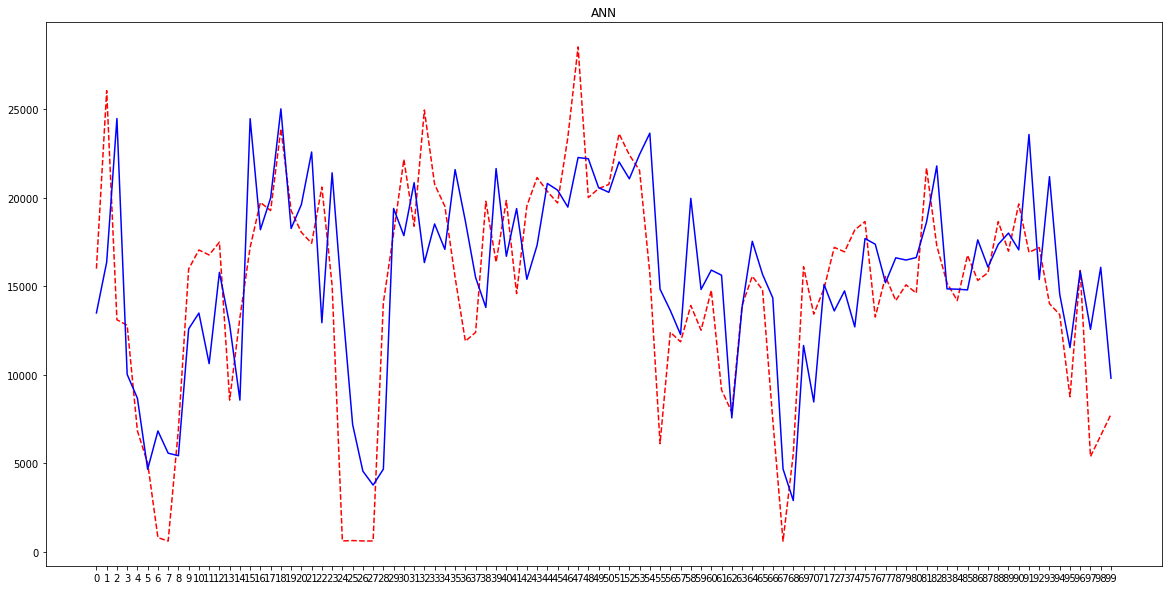

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
895/895 [==============================] - 0s - loss: 70161808.0000 - mean_squared_error: 70161808.0000
Epoch 2/750
895/895 [==============================] - 0s - loss: 70105560.0000 - mean_squared_error: 70105560.0000
Epoch 3/750
895/895 [==============================] - 0s - loss: 70043120.0000 - mean_squared_error: 70043120.0000
Epoch 4/750
895/895 [==============================] - 0s - loss: 69975272.0000 - mean_squared_error: 69975272.0000
Epoch 5/750
895/895 [==============================] - 0s - loss: 69902552.0000 - mean_squared_error: 69902552.0000
Epoch 6/750
895/895 [==============================] - 0s - loss: 69824616.0000 - mean_squared_error: 69824616.0000
Epoch 7/750
895/895 [==============================] - 

895/895 [==============================] - 0s - loss: 25841336.0000 - mean_squared_error: 25841336.0000
Epoch 69/750
895/895 [==============================] - 0s - loss: 24982622.0000 - mean_squared_error: 24982622.0000
Epoch 70/750
895/895 [==============================] - 0s - loss: 24203284.0000 - mean_squared_error: 24203284.0000
Epoch 71/750
895/895 [==============================] - 0s - loss: 23508266.0000 - mean_squared_error: 23508266.0000
Epoch 72/750
895/895 [==============================] - 0s - loss: 22900748.0000 - mean_squared_error: 22900748.0000
Epoch 73/750
895/895 [==============================] - 0s - loss: 22382224.0000 - mean_squared_error: 22382224.0000
Epoch 74/750
895/895 [==============================] - 0s - loss: 21952856.0000 - mean_squared_error: 21952856.0000
Epoch 75/750
895/895 [==============================] - 0s - loss: 21610594.0000 - mean_squared_error: 21610594.0000
Epoch 76/750
895/895 [==============================] - 0s - loss: 21351176.0

895/895 [==============================] - 0s - loss: 18796490.0000 - mean_squared_error: 18796490.0000
Epoch 138/750
895/895 [==============================] - 0s - loss: 18758550.0000 - mean_squared_error: 18758550.0000
Epoch 139/750
895/895 [==============================] - 0s - loss: 18720542.0000 - mean_squared_error: 18720542.0000
Epoch 140/750
895/895 [==============================] - 0s - loss: 18682596.0000 - mean_squared_error: 18682596.0000
Epoch 141/750
895/895 [==============================] - 0s - loss: 18644814.0000 - mean_squared_error: 18644814.0000
Epoch 142/750
895/895 [==============================] - 0s - loss: 18606994.0000 - mean_squared_error: 18606994.0000
Epoch 143/750
895/895 [==============================] - 0s - loss: 18569162.0000 - mean_squared_error: 18569162.0000
Epoch 144/750
895/895 [==============================] - 0s - loss: 18531398.0000 - mean_squared_error: 18531398.0000
Epoch 145/750
895/895 [==============================] - 0s - loss: 18

895/895 [==============================] - 0s - loss: 16316583.0000 - mean_squared_error: 16316583.0000
Epoch 207/750
895/895 [==============================] - 0s - loss: 16282804.0000 - mean_squared_error: 16282804.0000
Epoch 208/750
895/895 [==============================] - 0s - loss: 16249132.0000 - mean_squared_error: 16249132.0000
Epoch 209/750
895/895 [==============================] - 0s - loss: 16215547.0000 - mean_squared_error: 16215547.0000
Epoch 210/750
895/895 [==============================] - 0s - loss: 16182040.0000 - mean_squared_error: 16182040.0000
Epoch 211/750
895/895 [==============================] - 0s - loss: 16148650.0000 - mean_squared_error: 16148650.0000
Epoch 212/750
895/895 [==============================] - 0s - loss: 16115318.0000 - mean_squared_error: 16115318.0000
Epoch 213/750
895/895 [==============================] - 0s - loss: 16082069.0000 - mean_squared_error: 16082069.0000
Epoch 214/750
895/895 [==============================] - 0s - loss: 16

895/895 [==============================] - 0s - loss: 14220987.0000 - mean_squared_error: 14220987.0000
Epoch 276/750
895/895 [==============================] - 0s - loss: 14194602.0000 - mean_squared_error: 14194602.0000
Epoch 277/750
895/895 [==============================] - 0s - loss: 14168340.0000 - mean_squared_error: 14168340.0000
Epoch 278/750
895/895 [==============================] - 0s - loss: 14142186.0000 - mean_squared_error: 14142186.0000
Epoch 279/750
895/895 [==============================] - 0s - loss: 14116219.0000 - mean_squared_error: 14116219.0000
Epoch 280/750
895/895 [==============================] - 0s - loss: 14090376.0000 - mean_squared_error: 14090376.0000
Epoch 281/750
895/895 [==============================] - 0s - loss: 14064626.0000 - mean_squared_error: 14064626.0000
Epoch 282/750
895/895 [==============================] - 0s - loss: 14038964.0000 - mean_squared_error: 14038964.0000
Epoch 283/750
895/895 [==============================] - 0s - loss: 14

895/895 [==============================] - 0s - loss: 12499389.0000 - mean_squared_error: 12499389.0000
Epoch 345/750
895/895 [==============================] - 0s - loss: 12470076.0000 - mean_squared_error: 12470076.0000
Epoch 346/750
895/895 [==============================] - 0s - loss: 12440427.0000 - mean_squared_error: 12440427.0000
Epoch 347/750
895/895 [==============================] - 0s - loss: 12410738.0000 - mean_squared_error: 12410738.0000
Epoch 348/750
895/895 [==============================] - 0s - loss: 12380517.0000 - mean_squared_error: 12380517.0000
Epoch 349/750
895/895 [==============================] - 0s - loss: 12349803.0000 - mean_squared_error: 12349803.0000
Epoch 350/750
895/895 [==============================] - 0s - loss: 12318974.0000 - mean_squared_error: 12318974.0000
Epoch 351/750
895/895 [==============================] - 0s - loss: 12287882.0000 - mean_squared_error: 12287882.0000
Epoch 352/750
895/895 [==============================] - 0s - loss: 12

895/895 [==============================] - 0s - loss: 10043557.0000 - mean_squared_error: 10043557.0000
Epoch 414/750
895/895 [==============================] - 0s - loss: 10007672.0000 - mean_squared_error: 10007672.0000
Epoch 415/750
895/895 [==============================] - 0s - loss: 9971860.0000 - mean_squared_error: 9971860.0000
Epoch 416/750
895/895 [==============================] - 0s - loss: 9936171.0000 - mean_squared_error: 9936171.0000
Epoch 417/750
895/895 [==============================] - 0s - loss: 9900326.0000 - mean_squared_error: 9900326.0000
Epoch 418/750
895/895 [==============================] - 0s - loss: 9864645.0000 - mean_squared_error: 9864645.0000
Epoch 419/750
895/895 [==============================] - 0s - loss: 9828772.0000 - mean_squared_error: 9828772.0000
Epoch 420/750
895/895 [==============================] - 0s - loss: 9793186.0000 - mean_squared_error: 9793186.0000
Epoch 421/750
895/895 [==============================] - 0s - loss: 9757185.0000 -

895/895 [==============================] - 0s - loss: 7767540.5000 - mean_squared_error: 7767540.5000
Epoch 484/750
895/895 [==============================] - 0s - loss: 7739224.5000 - mean_squared_error: 7739224.5000
Epoch 485/750
895/895 [==============================] - 0s - loss: 7711443.5000 - mean_squared_error: 7711443.5000
Epoch 486/750
895/895 [==============================] - 0s - loss: 7682877.0000 - mean_squared_error: 7682877.0000
Epoch 487/750
895/895 [==============================] - 0s - loss: 7655572.0000 - mean_squared_error: 7655572.0000
Epoch 488/750
895/895 [==============================] - 0s - loss: 7627300.0000 - mean_squared_error: 7627300.0000
Epoch 489/750
895/895 [==============================] - 0s - loss: 7600127.0000 - mean_squared_error: 7600127.0000
Epoch 490/750
895/895 [==============================] - 0s - loss: 7572711.0000 - mean_squared_error: 7572711.0000
Epoch 491/750
895/895 [==============================] - 0s - loss: 7545110.5000 - mea

895/895 [==============================] - 0s - loss: 6100845.0000 - mean_squared_error: 6100845.0000
Epoch 554/750
895/895 [==============================] - 0s - loss: 6081239.0000 - mean_squared_error: 6081239.0000
Epoch 555/750
895/895 [==============================] - 0s - loss: 6061366.0000 - mean_squared_error: 6061366.0000
Epoch 556/750
895/895 [==============================] - 0s - loss: 6041268.0000 - mean_squared_error: 6041268.0000
Epoch 557/750
895/895 [==============================] - 0s - loss: 6022417.5000 - mean_squared_error: 6022417.5000
Epoch 558/750
895/895 [==============================] - 0s - loss: 6002199.0000 - mean_squared_error: 6002199.0000
Epoch 559/750
895/895 [==============================] - 0s - loss: 5983351.0000 - mean_squared_error: 5983351.0000
Epoch 560/750
895/895 [==============================] - 0s - loss: 5963684.0000 - mean_squared_error: 5963684.0000
Epoch 561/750
895/895 [==============================] - 0s - loss: 5943723.5000 - mea

895/895 [==============================] - 0s - loss: 4845147.0000 - mean_squared_error: 4845147.0000
Epoch 624/750
895/895 [==============================] - 0s - loss: 4828766.0000 - mean_squared_error: 4828766.0000
Epoch 625/750
895/895 [==============================] - 0s - loss: 4812567.5000 - mean_squared_error: 4812567.5000
Epoch 626/750
895/895 [==============================] - 0s - loss: 4796450.5000 - mean_squared_error: 4796450.5000
Epoch 627/750
895/895 [==============================] - 0s - loss: 4779701.5000 - mean_squared_error: 4779701.5000
Epoch 628/750
895/895 [==============================] - 0s - loss: 4764152.5000 - mean_squared_error: 4764152.5000
Epoch 629/750
895/895 [==============================] - 0s - loss: 4747842.5000 - mean_squared_error: 4747842.5000
Epoch 630/750
895/895 [==============================] - 0s - loss: 4731258.0000 - mean_squared_error: 4731258.0000
Epoch 631/750
895/895 [==============================] - 0s - loss: 4715371.5000 - mea

895/895 [==============================] - 0s - loss: 3830455.2500 - mean_squared_error: 3830455.2500
Epoch 694/750
895/895 [==============================] - 0s - loss: 3817585.7500 - mean_squared_error: 3817585.7500
Epoch 695/750
895/895 [==============================] - 0s - loss: 3805038.0000 - mean_squared_error: 3805038.0000
Epoch 696/750
895/895 [==============================] - 0s - loss: 3792302.0000 - mean_squared_error: 3792302.0000
Epoch 697/750
895/895 [==============================] - 0s - loss: 3779979.7500 - mean_squared_error: 3779979.7500
Epoch 698/750
895/895 [==============================] - 0s - loss: 3767584.0000 - mean_squared_error: 3767584.0000
Epoch 699/750
895/895 [==============================] - 0s - loss: 3754876.5000 - mean_squared_error: 3754876.5000
Epoch 700/750
895/895 [==============================] - 0s - loss: 3742335.2500 - mean_squared_error: 3742335.2500
Epoch 701/750
895/895 [==============================] - 0s - loss: 3730227.2500 - mea

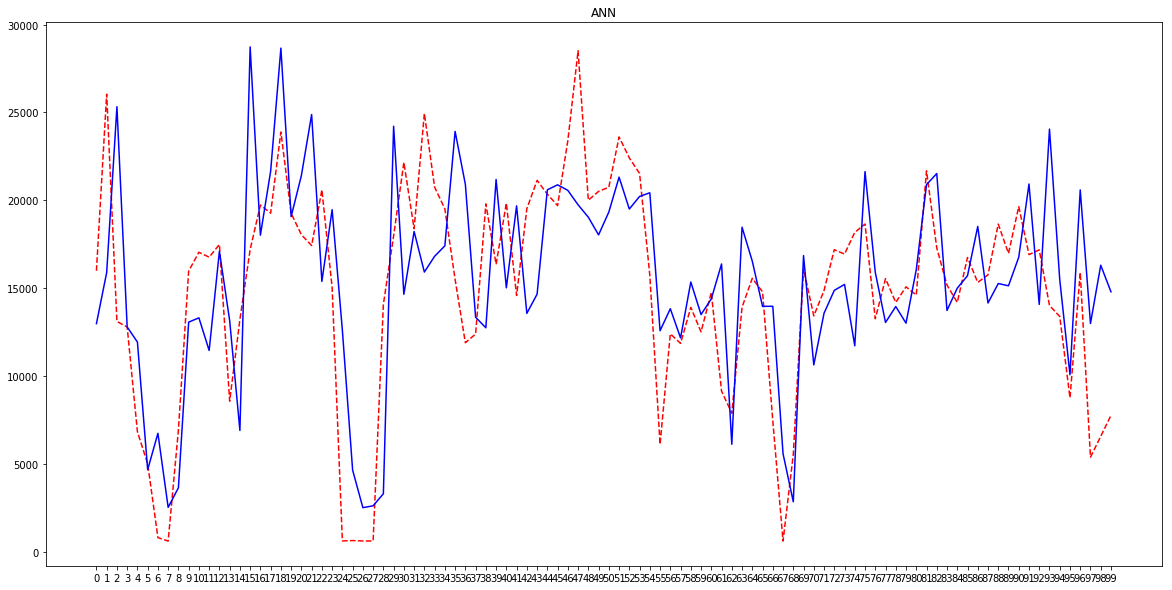

('Time Taken : ', 1512050731.485269)


In [63]:
'''
Running the model (NN) and comparing on other houses.
'''
d = {}

'''
A list containing the house-ids of the houses considered. Only one house has been dropped, due to the presence of 
NaNs in 'air1' , 'furnace1' and 'waterheater1'. 
'''
hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
ti = time.time()

for ti in (hid):
    print ("\n\n House : ",ti)
    df_115 = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(ti)+".pkl")

    df_115 = df_115[["localhour","air1","furnace1","waterheater1"]]
    df_115["total"] = df_115["air1"] + df_115["furnace1"] + df_115["waterheater1"]
    df_115.iloc[:,[1,2,3,4]] = df_115.iloc[:,[1,2,3,4]].mul(1000)
    df_115.head()

    # changing the shape of the given data from every row being an hour to every row being a day
    # that is, every row will now have all hours thermal load data as columns (0,1..23) in x and that day's total load in y
    # shapes being x = (1700,24), y = (1700,1)
    
    nhrs = int(df_115["total"].values.shape[0]/24)
    y_115 = np.ndarray(shape=(nhrs,))
    x_115 = np.ndarray(shape=(nhrs,24))
    val = []
    for i in range(nhrs):
        #val = df_tot_ther.values[i:i+24]
        #Take only the loads correspondin to one whole day, starting from the hour the datframe starts from.
        val = df_115["total"].values[24*i:24*(i+1)]
        y_115[i] = np.sum(val)
        x_115[i]=val.T
    y = pd.DataFrame(y_115)
    y.columns = ['day_load']
    x = pd.DataFrame(x_115)
    x.head()

    # creating the desired shape for the ANN model - 168 columns for hour-wise data of 7 days as input
    #  and next day total load as output
    temp = x.values.tolist()
    x = np.ndarray(shape=(nhrs,168))
    for i in range(7,len(temp),1):
        dlist = []
        for j in range(1,8):
            dlist = dlist + temp[i-j]
        x[i] = dlist
    x = pd.DataFrame(x)
    x.tail(10)

    x = x.iloc[7:,:]
    y = y.iloc[7:,:]
    print(x.shape)
    print(y.shape)

    d_115 = pd.concat([x,y],axis=1)
    print(d_115.shape)
    d_115.head(10)

    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(d_115,thermal_dict1,2,"mean_squared_error",1,0) 
    #print (thermal_dict1)
    d.setdefault(ti,[]).append(thermal_dict1)
tf=time.time()    
print ("Time Taken : ",tf-ti)

In [64]:
print ("Dict  in 'house-id' '-' ['R^2','RMSE','MAE']: \n")
for key,val in d.iteritems():
    print (key," - ",val,"\n\n")

Dict  in 'house-id' '-' ['R^2','RMSE','MAE']: 

(4000, ' - ', [{0: [[0.57749974996497921, 1575.9391498139871, 1154.7066456886573]], 1: [[0.4035409189619743, 1872.4761161109809, 1418.0129004132307]]}], '\n\n')
(2401, ' - ', [{0: [[0.36189626372072237, 6698.918694837178, 4919.4128308558811]], 1: [[0.51789165119770331, 5822.7935085314766, 4080.9881896198658]]}], '\n\n')
(3268, ' - ', [{0: [[-0.71369653451254034, 5892.0688521427892, 2976.0099267146657]], 1: [[-0.49957076017708735, 5511.6843226293304, 2864.5739946213789]]}], '\n\n')
(3273, ' - ', [{0: [[0.20420286669296794, 3430.6208565131906, 2652.2528263749318]], 1: [[0.21688602673774204, 3403.1729847220822, 2653.3552727541241]]}], '\n\n')
(1037, ' - ', [{0: [[0.14716901227787671, 8616.3824104453142, 6068.9751399868828]], 1: [[0.28396388254197458, 7895.160150526609, 5400.2299049014136]]}], '\n\n')
(115, ' - ', [{0: [[0.6256155071952807, 3853.7380787680941, 2782.935649484828]], 1: [[0.7115337556303345, 3382.7567443846219, 2478.210803168418

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
1185/1185 [==============================] - 0s - loss: 372275264.0000 - mean_squared_error: 372275264.0000
Epoch 2/750
1185/1185 [==============================] - 0s - loss: 372024864.0000 - mean_squared_error: 372024864.0000
Epoch 3/750
1185/1185 [==============================] - 0s - loss: 371746656.0000 - mean_squared_error: 371746656.0000
Epoch 4/750
1185/1185 [==============================] - 0s - loss: 371444928.0000 - mean_squared_error: 371444928.0000
Epoch 5/750
1185/1185 [==============================] - 0s - loss: 371114400.0000 - mean_squared_error: 371114400.0000
Epoch 6/750
1185/1185 [==============================] - 0s - loss: 370754016.0000 - mean_squared_error: 370754016.0000
Epoch 7/750
1185/1185 [========

1185/1185 [==============================] - 0s - loss: 79040344.0000 - mean_squared_error: 79040344.0000
Epoch 135/750
1185/1185 [==============================] - 0s - loss: 78879264.0000 - mean_squared_error: 78879264.0000
Epoch 136/750
1185/1185 [==============================] - 0s - loss: 78717864.0000 - mean_squared_error: 78717864.0000
Epoch 137/750
1185/1185 [==============================] - 0s - loss: 78554528.0000 - mean_squared_error: 78554528.0000
Epoch 138/750
1185/1185 [==============================] - 0s - loss: 78388640.0000 - mean_squared_error: 78388640.0000
Epoch 139/750
1185/1185 [==============================] - 0s - loss: 78223112.0000 - mean_squared_error: 78223112.0000
Epoch 140/750
1185/1185 [==============================] - 0s - loss: 78054616.0000 - mean_squared_error: 78054616.0000
Epoch 141/750
1185/1185 [==============================] - 0s - loss: 77883912.0000 - mean_squared_error: 77883912.0000
Epoch 142/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 57534364.0000 - mean_squared_error: 57534364.0000
Epoch 271/750
1185/1185 [==============================] - 0s - loss: 57417920.0000 - mean_squared_error: 57417920.0000
Epoch 272/750
1185/1185 [==============================] - 0s - loss: 57302228.0000 - mean_squared_error: 57302228.0000
Epoch 273/750
1185/1185 [==============================] - 0s - loss: 57187352.0000 - mean_squared_error: 57187352.0000
Epoch 274/750
1185/1185 [==============================] - 0s - loss: 57073200.0000 - mean_squared_error: 57073200.0000
Epoch 275/750
1185/1185 [==============================] - 0s - loss: 56960040.0000 - mean_squared_error: 56960040.0000
Epoch 276/750
1185/1185 [==============================] - 0s - loss: 56847800.0000 - mean_squared_error: 56847800.0000
Epoch 277/750
1185/1185 [==============================] - 0s - loss: 56736132.0000 - mean_squared_error: 56736132.0000
Epoch 278/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 46106116.0000 - mean_squared_error: 46106116.0000
Epoch 407/750
1185/1185 [==============================] - 0s - loss: 46047344.0000 - mean_squared_error: 46047344.0000
Epoch 408/750
1185/1185 [==============================] - 0s - loss: 45988832.0000 - mean_squared_error: 45988832.0000
Epoch 409/750
1185/1185 [==============================] - 0s - loss: 45929544.0000 - mean_squared_error: 45929544.0000
Epoch 410/750
1185/1185 [==============================] - 0s - loss: 45869852.0000 - mean_squared_error: 45869852.0000
Epoch 411/750
1185/1185 [==============================] - 0s - loss: 45810124.0000 - mean_squared_error: 45810124.0000
Epoch 412/750
1185/1185 [==============================] - 0s - loss: 45750448.0000 - mean_squared_error: 45750448.0000
Epoch 413/750
1185/1185 [==============================] - 0s - loss: 45690652.0000 - mean_squared_error: 45690652.0000
Epoch 414/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 39375856.0000 - mean_squared_error: 39375856.0000
Epoch 543/750
1185/1185 [==============================] - 0s - loss: 39340056.0000 - mean_squared_error: 39340056.0000
Epoch 544/750
1185/1185 [==============================] - 0s - loss: 39301532.0000 - mean_squared_error: 39301532.0000
Epoch 545/750
1185/1185 [==============================] - 0s - loss: 39265436.0000 - mean_squared_error: 39265436.0000
Epoch 546/750
1185/1185 [==============================] - 0s - loss: 39226120.0000 - mean_squared_error: 39226120.0000
Epoch 547/750
1185/1185 [==============================] - 0s - loss: 39190008.0000 - mean_squared_error: 39190008.0000
Epoch 548/750
1185/1185 [==============================] - 0s - loss: 39151004.0000 - mean_squared_error: 39151004.0000
Epoch 549/750
1185/1185 [==============================] - 0s - loss: 39113456.0000 - mean_squared_error: 39113456.0000
Epoch 550/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 34340984.0000 - mean_squared_error: 34340984.0000
Epoch 679/750
1185/1185 [==============================] - 0s - loss: 34310236.0000 - mean_squared_error: 34310236.0000
Epoch 680/750
1185/1185 [==============================] - 0s - loss: 34276548.0000 - mean_squared_error: 34276548.0000
Epoch 681/750
1185/1185 [==============================] - 0s - loss: 34242664.0000 - mean_squared_error: 34242664.0000
Epoch 682/750
1185/1185 [==============================] - 0s - loss: 34212072.0000 - mean_squared_error: 34212072.0000
Epoch 683/750
1185/1185 [==============================] - 0s - loss: 34178804.0000 - mean_squared_error: 34178804.0000
Epoch 684/750
1185/1185 [==============================] - 0s - loss: 34145180.0000 - mean_squared_error: 34145180.0000
Epoch 685/750
1185/1185 [==============================] - 0s - loss: 34114948.0000 - mean_squared_error: 34114948.0000
Epoch 686/750
1185/1185 [=============================

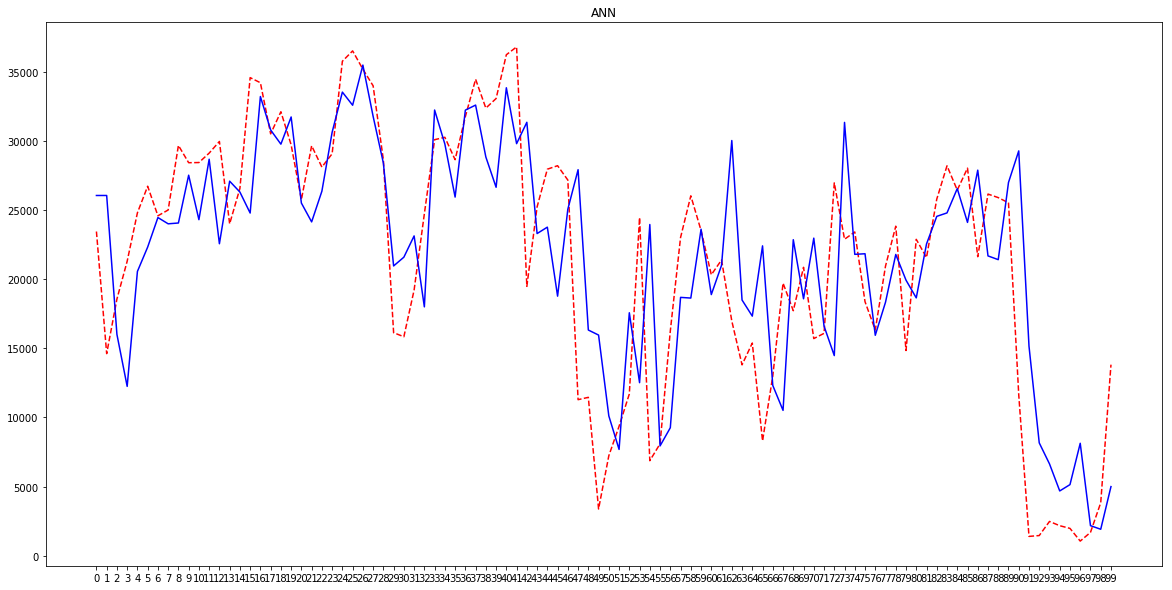

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
1185/1185 [==============================] - 0s - loss: 372997824.0000 - mean_squared_error: 372997824.0000
Epoch 2/750
1185/1185 [==============================] - 0s - loss: 372731296.0000 - mean_squared_error: 372731296.0000
Epoch 3/750
1185/1185 [==============================] - 0s - loss: 372612480.0000 - mean_squared_error: 372612480.0000
Epoch 4/750
1185/1185 [==============================] - 0s - loss: 372537088.0000 - mean_squared_error: 372537088.0000
Epoch 5/750
1185/1185 [==============================] - 0s - loss: 372462464.0000 - mean_squared_error: 372462464.0000
Epoch 6/750
1185/1185 [==============================] - 0s - loss: 372379168.0000 - mean_squared_error: 372379168.0000
Epoch 7/750
1185/1185 [========

1185/1185 [==============================] - 0s - loss: 82140464.0000 - mean_squared_error: 82140464.0000
Epoch 135/750
1185/1185 [==============================] - 0s - loss: 82016648.0000 - mean_squared_error: 82016648.0000
Epoch 136/750
1185/1185 [==============================] - 0s - loss: 81884592.0000 - mean_squared_error: 81884592.0000
Epoch 137/750
1185/1185 [==============================] - 0s - loss: 81747536.0000 - mean_squared_error: 81747536.0000
Epoch 138/750
1185/1185 [==============================] - 0s - loss: 81607512.0000 - mean_squared_error: 81607512.0000
Epoch 139/750
1185/1185 [==============================] - 0s - loss: 81464120.0000 - mean_squared_error: 81464120.0000
Epoch 140/750
1185/1185 [==============================] - 0s - loss: 81316048.0000 - mean_squared_error: 81316048.0000
Epoch 141/750
1185/1185 [==============================] - 0s - loss: 81163688.0000 - mean_squared_error: 81163688.0000
Epoch 142/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 53381936.0000 - mean_squared_error: 53381936.0000
Epoch 271/750
1185/1185 [==============================] - 0s - loss: 53233988.0000 - mean_squared_error: 53233988.0000
Epoch 272/750
1185/1185 [==============================] - 0s - loss: 53088432.0000 - mean_squared_error: 53088432.0000
Epoch 273/750
1185/1185 [==============================] - 0s - loss: 52945368.0000 - mean_squared_error: 52945368.0000
Epoch 274/750
1185/1185 [==============================] - 0s - loss: 52805160.0000 - mean_squared_error: 52805160.0000
Epoch 275/750
1185/1185 [==============================] - 0s - loss: 52667340.0000 - mean_squared_error: 52667340.0000
Epoch 276/750
1185/1185 [==============================] - 0s - loss: 52531868.0000 - mean_squared_error: 52531868.0000
Epoch 277/750
1185/1185 [==============================] - 0s - loss: 52398564.0000 - mean_squared_error: 52398564.0000
Epoch 278/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 44656920.0000 - mean_squared_error: 44656920.0000
Epoch 407/750
1185/1185 [==============================] - 0s - loss: 44625044.0000 - mean_squared_error: 44625044.0000
Epoch 408/750
1185/1185 [==============================] - 0s - loss: 44593232.0000 - mean_squared_error: 44593232.0000
Epoch 409/750
1185/1185 [==============================] - 0s - loss: 44561404.0000 - mean_squared_error: 44561404.0000
Epoch 410/750
1185/1185 [==============================] - 0s - loss: 44529528.0000 - mean_squared_error: 44529528.0000
Epoch 411/750
1185/1185 [==============================] - 0s - loss: 44497556.0000 - mean_squared_error: 44497556.0000
Epoch 412/750
1185/1185 [==============================] - 0s - loss: 44465736.0000 - mean_squared_error: 44465736.0000
Epoch 413/750
1185/1185 [==============================] - 0s - loss: 44434068.0000 - mean_squared_error: 44434068.0000
Epoch 414/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 39630832.0000 - mean_squared_error: 39630832.0000
Epoch 543/750
1185/1185 [==============================] - 0s - loss: 39583892.0000 - mean_squared_error: 39583892.0000
Epoch 544/750
1185/1185 [==============================] - 0s - loss: 39538020.0000 - mean_squared_error: 39538020.0000
Epoch 545/750
1185/1185 [==============================] - 0s - loss: 39495044.0000 - mean_squared_error: 39495044.0000
Epoch 546/750
1185/1185 [==============================] - 0s - loss: 39446252.0000 - mean_squared_error: 39446252.0000
Epoch 547/750
1185/1185 [==============================] - 0s - loss: 39402988.0000 - mean_squared_error: 39402988.0000
Epoch 548/750
1185/1185 [==============================] - 0s - loss: 39359476.0000 - mean_squared_error: 39359476.0000
Epoch 549/750
1185/1185 [==============================] - 0s - loss: 39312732.0000 - mean_squared_error: 39312732.0000
Epoch 550/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 32962426.0000 - mean_squared_error: 32962426.0000
Epoch 679/750
1185/1185 [==============================] - 0s - loss: 32914122.0000 - mean_squared_error: 32914122.0000
Epoch 680/750
1185/1185 [==============================] - 0s - loss: 32867006.0000 - mean_squared_error: 32867006.0000
Epoch 681/750
1185/1185 [==============================] - 0s - loss: 32819430.0000 - mean_squared_error: 32819430.0000
Epoch 682/750
1185/1185 [==============================] - 0s - loss: 32770308.0000 - mean_squared_error: 32770308.0000
Epoch 683/750
1185/1185 [==============================] - 0s - loss: 32724880.0000 - mean_squared_error: 32724880.0000
Epoch 684/750
1185/1185 [==============================] - 0s - loss: 32675070.0000 - mean_squared_error: 32675070.0000
Epoch 685/750
1185/1185 [==============================] - 0s - loss: 32627914.0000 - mean_squared_error: 32627914.0000
Epoch 686/750
1185/1185 [=============================

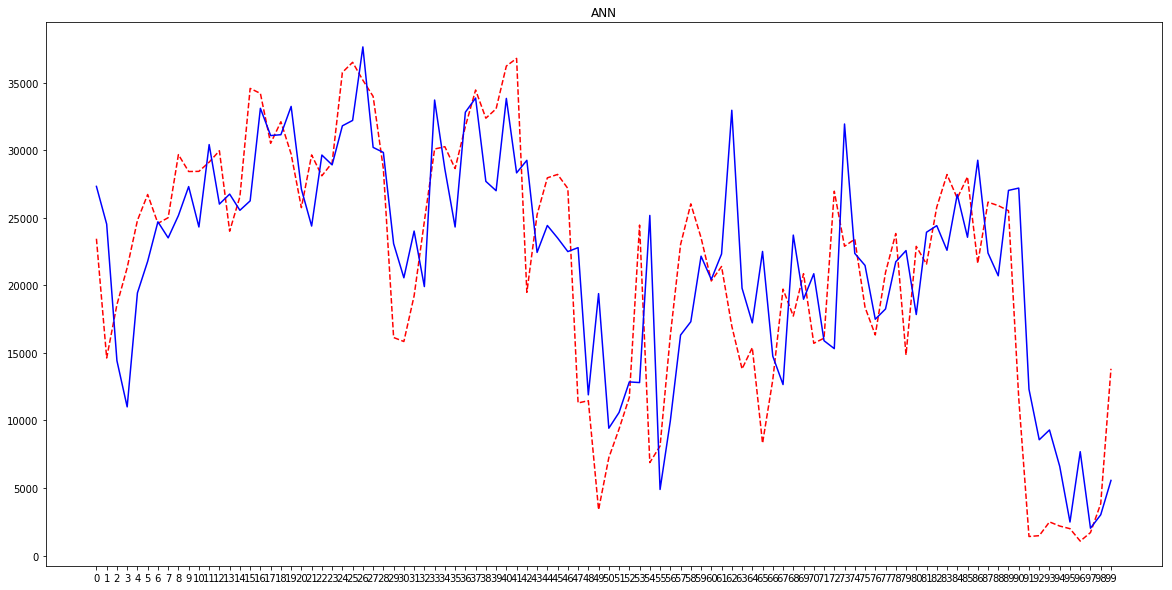

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
1185/1185 [==============================] - 0s - loss: 372620704.0000 - mean_squared_error: 372620704.0000
Epoch 2/750
1185/1185 [==============================] - 0s - loss: 372468928.0000 - mean_squared_error: 372468928.0000
Epoch 3/750
1185/1185 [==============================] - 0s - loss: 372260576.0000 - mean_squared_error: 372260576.0000
Epoch 4/750
1185/1185 [==============================] - 0s - loss: 372000960.0000 - mean_squared_error: 372000960.0000
Epoch 5/750
1185/1185 [==============================] - 0s - loss: 371692608.0000 - mean_squared_error: 371692608.0000
Epoch 6/750
1185/1185 [==============================] - 0s - loss: 371345088.0000 - mean_squared_error: 371345088.0000
Epoch 7/750
1185/1185 [========

1185/1185 [==============================] - 0s - loss: 82097408.0000 - mean_squared_error: 82097408.0000
Epoch 135/750
1185/1185 [==============================] - 0s - loss: 82000360.0000 - mean_squared_error: 82000360.0000
Epoch 136/750
1185/1185 [==============================] - 0s - loss: 81901320.0000 - mean_squared_error: 81901320.0000
Epoch 137/750
1185/1185 [==============================] - 0s - loss: 81799840.0000 - mean_squared_error: 81799840.0000
Epoch 138/750
1185/1185 [==============================] - 0s - loss: 81695736.0000 - mean_squared_error: 81695736.0000
Epoch 139/750
1185/1185 [==============================] - 0s - loss: 81589168.0000 - mean_squared_error: 81589168.0000
Epoch 140/750
1185/1185 [==============================] - 0s - loss: 81480416.0000 - mean_squared_error: 81480416.0000
Epoch 141/750
1185/1185 [==============================] - 0s - loss: 81369784.0000 - mean_squared_error: 81369784.0000
Epoch 142/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 62469220.0000 - mean_squared_error: 62469220.0000
Epoch 271/750
1185/1185 [==============================] - 0s - loss: 62300256.0000 - mean_squared_error: 62300256.0000
Epoch 272/750
1185/1185 [==============================] - 0s - loss: 62132164.0000 - mean_squared_error: 62132164.0000
Epoch 273/750
1185/1185 [==============================] - 0s - loss: 61964980.0000 - mean_squared_error: 61964980.0000
Epoch 274/750
1185/1185 [==============================] - 0s - loss: 61798684.0000 - mean_squared_error: 61798684.0000
Epoch 275/750
1185/1185 [==============================] - 0s - loss: 61633228.0000 - mean_squared_error: 61633228.0000
Epoch 276/750
1185/1185 [==============================] - 0s - loss: 61468660.0000 - mean_squared_error: 61468660.0000
Epoch 277/750
1185/1185 [==============================] - 0s - loss: 61305000.0000 - mean_squared_error: 61305000.0000
Epoch 278/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 46461916.0000 - mean_squared_error: 46461916.0000
Epoch 407/750
1185/1185 [==============================] - 0s - loss: 46403140.0000 - mean_squared_error: 46403140.0000
Epoch 408/750
1185/1185 [==============================] - 0s - loss: 46344588.0000 - mean_squared_error: 46344588.0000
Epoch 409/750
1185/1185 [==============================] - 0s - loss: 46286464.0000 - mean_squared_error: 46286464.0000
Epoch 410/750
1185/1185 [==============================] - 0s - loss: 46228708.0000 - mean_squared_error: 46228708.0000
Epoch 411/750
1185/1185 [==============================] - 0s - loss: 46171932.0000 - mean_squared_error: 46171932.0000
Epoch 412/750
1185/1185 [==============================] - 0s - loss: 46115908.0000 - mean_squared_error: 46115908.0000
Epoch 413/750
1185/1185 [==============================] - 0s - loss: 46060448.0000 - mean_squared_error: 46060448.0000
Epoch 414/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 41762276.0000 - mean_squared_error: 41762276.0000
Epoch 543/750
1185/1185 [==============================] - 0s - loss: 41738504.0000 - mean_squared_error: 41738504.0000
Epoch 544/750
1185/1185 [==============================] - 0s - loss: 41713804.0000 - mean_squared_error: 41713804.0000
Epoch 545/750
1185/1185 [==============================] - 0s - loss: 41690740.0000 - mean_squared_error: 41690740.0000
Epoch 546/750
1185/1185 [==============================] - 0s - loss: 41667636.0000 - mean_squared_error: 41667636.0000
Epoch 547/750
1185/1185 [==============================] - 0s - loss: 41644160.0000 - mean_squared_error: 41644160.0000
Epoch 548/750
1185/1185 [==============================] - 0s - loss: 41620956.0000 - mean_squared_error: 41620956.0000
Epoch 549/750
1185/1185 [==============================] - 0s - loss: 41599500.0000 - mean_squared_error: 41599500.0000
Epoch 550/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 39216220.0000 - mean_squared_error: 39216220.0000
Epoch 679/750
1185/1185 [==============================] - 0s - loss: 39199840.0000 - mean_squared_error: 39199840.0000
Epoch 680/750
1185/1185 [==============================] - 0s - loss: 39186484.0000 - mean_squared_error: 39186484.0000
Epoch 681/750
1185/1185 [==============================] - 0s - loss: 39168068.0000 - mean_squared_error: 39168068.0000
Epoch 682/750
1185/1185 [==============================] - 0s - loss: 39156032.0000 - mean_squared_error: 39156032.0000
Epoch 683/750
1185/1185 [==============================] - 0s - loss: 39136520.0000 - mean_squared_error: 39136520.0000
Epoch 684/750
1185/1185 [==============================] - 0s - loss: 39123324.0000 - mean_squared_error: 39123324.0000
Epoch 685/750
1185/1185 [==============================] - 0s - loss: 39106812.0000 - mean_squared_error: 39106812.0000
Epoch 686/750
1185/1185 [=============================

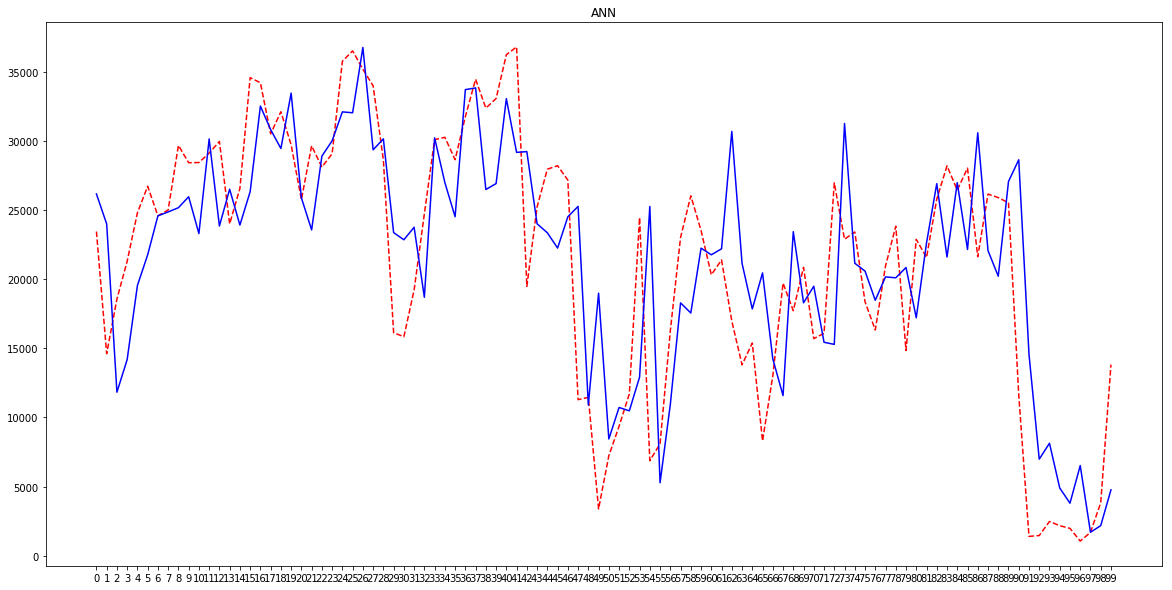

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
1185/1185 [==============================] - 0s - loss: 372627840.0000 - mean_squared_error: 372627840.0000
Epoch 2/750
1185/1185 [==============================] - 0s - loss: 372471744.0000 - mean_squared_error: 372471744.0000
Epoch 3/750
1185/1185 [==============================] - 0s - loss: 372322208.0000 - mean_squared_error: 372322208.0000
Epoch 4/750
1185/1185 [==============================] - 0s - loss: 372150752.0000 - mean_squared_error: 372150752.0000
Epoch 5/750
1185/1185 [==============================] - 0s - loss: 371955712.0000 - mean_squared_error: 371955712.0000
Epoch 6/750
1185/1185 [==============================] - 0s - loss: 371736384.0000 - mean_squared_error: 371736384.0000
Epoch 7/750
1185/1185 [========

1185/1185 [==============================] - 0s - loss: 80527112.0000 - mean_squared_error: 80527112.0000
Epoch 135/750
1185/1185 [==============================] - 0s - loss: 80407928.0000 - mean_squared_error: 80407928.0000
Epoch 136/750
1185/1185 [==============================] - 0s - loss: 80290264.0000 - mean_squared_error: 80290264.0000
Epoch 137/750
1185/1185 [==============================] - 0s - loss: 80174432.0000 - mean_squared_error: 80174432.0000
Epoch 138/750
1185/1185 [==============================] - 0s - loss: 80060496.0000 - mean_squared_error: 80060496.0000
Epoch 139/750
1185/1185 [==============================] - 0s - loss: 79948544.0000 - mean_squared_error: 79948544.0000
Epoch 140/750
1185/1185 [==============================] - 0s - loss: 79838488.0000 - mean_squared_error: 79838488.0000
Epoch 141/750
1185/1185 [==============================] - 0s - loss: 79730168.0000 - mean_squared_error: 79730168.0000
Epoch 142/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 64058704.0000 - mean_squared_error: 64058704.0000
Epoch 271/750
1185/1185 [==============================] - 0s - loss: 63916644.0000 - mean_squared_error: 63916644.0000
Epoch 272/750
1185/1185 [==============================] - 0s - loss: 63773848.0000 - mean_squared_error: 63773848.0000
Epoch 273/750
1185/1185 [==============================] - 0s - loss: 63630684.0000 - mean_squared_error: 63630684.0000
Epoch 274/750
1185/1185 [==============================] - 0s - loss: 63487176.0000 - mean_squared_error: 63487176.0000
Epoch 275/750
1185/1185 [==============================] - 0s - loss: 63343200.0000 - mean_squared_error: 63343200.0000
Epoch 276/750
1185/1185 [==============================] - 0s - loss: 63198620.0000 - mean_squared_error: 63198620.0000
Epoch 277/750
1185/1185 [==============================] - 0s - loss: 63053036.0000 - mean_squared_error: 63053036.0000
Epoch 278/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 49281620.0000 - mean_squared_error: 49281620.0000
Epoch 407/750
1185/1185 [==============================] - 0s - loss: 49226208.0000 - mean_squared_error: 49226208.0000
Epoch 408/750
1185/1185 [==============================] - 0s - loss: 49171420.0000 - mean_squared_error: 49171420.0000
Epoch 409/750
1185/1185 [==============================] - 0s - loss: 49117212.0000 - mean_squared_error: 49117212.0000
Epoch 410/750
1185/1185 [==============================] - 0s - loss: 49063580.0000 - mean_squared_error: 49063580.0000
Epoch 411/750
1185/1185 [==============================] - 0s - loss: 49010592.0000 - mean_squared_error: 49010592.0000
Epoch 412/750
1185/1185 [==============================] - 0s - loss: 48958100.0000 - mean_squared_error: 48958100.0000
Epoch 413/750
1185/1185 [==============================] - 0s - loss: 48906164.0000 - mean_squared_error: 48906164.0000
Epoch 414/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 44804608.0000 - mean_squared_error: 44804608.0000
Epoch 543/750
1185/1185 [==============================] - 0s - loss: 44782292.0000 - mean_squared_error: 44782292.0000
Epoch 544/750
1185/1185 [==============================] - 0s - loss: 44759980.0000 - mean_squared_error: 44759980.0000
Epoch 545/750
1185/1185 [==============================] - 0s - loss: 44738060.0000 - mean_squared_error: 44738060.0000
Epoch 546/750
1185/1185 [==============================] - 0s - loss: 44716040.0000 - mean_squared_error: 44716040.0000
Epoch 547/750
1185/1185 [==============================] - 0s - loss: 44694560.0000 - mean_squared_error: 44694560.0000
Epoch 548/750
1185/1185 [==============================] - 0s - loss: 44672704.0000 - mean_squared_error: 44672704.0000
Epoch 549/750
1185/1185 [==============================] - 0s - loss: 44650780.0000 - mean_squared_error: 44650780.0000
Epoch 550/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 41015028.0000 - mean_squared_error: 41015028.0000
Epoch 679/750
1185/1185 [==============================] - 0s - loss: 40985656.0000 - mean_squared_error: 40985656.0000
Epoch 680/750
1185/1185 [==============================] - 0s - loss: 40957488.0000 - mean_squared_error: 40957488.0000
Epoch 681/750
1185/1185 [==============================] - 0s - loss: 40928536.0000 - mean_squared_error: 40928536.0000
Epoch 682/750
1185/1185 [==============================] - 0s - loss: 40900600.0000 - mean_squared_error: 40900600.0000
Epoch 683/750
1185/1185 [==============================] - 0s - loss: 40870540.0000 - mean_squared_error: 40870540.0000
Epoch 684/750
1185/1185 [==============================] - 0s - loss: 40840860.0000 - mean_squared_error: 40840860.0000
Epoch 685/750
1185/1185 [==============================] - 0s - loss: 40809216.0000 - mean_squared_error: 40809216.0000
Epoch 686/750
1185/1185 [=============================

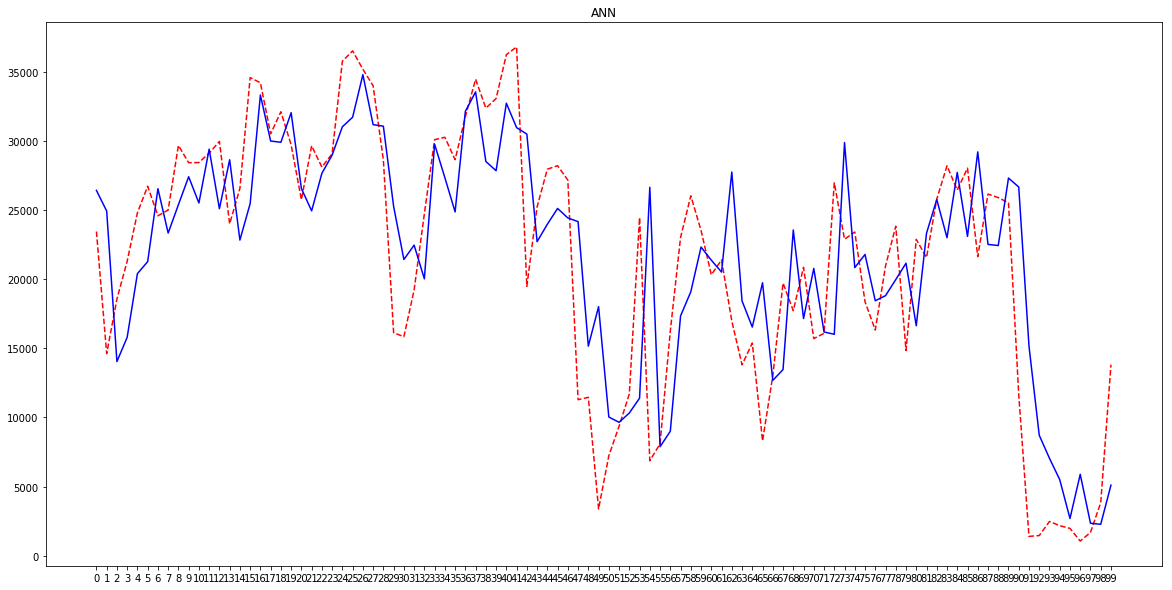

1
('\n Columns of  x : ', Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='object', length=168))
('\n Columns of  y : ', Index([u'day_load'], dtype='object'))
Epoch 1/750
1185/1185 [==============================] - 0s - loss: 372976736.0000 - mean_squared_error: 372976736.0000
Epoch 2/750
1185/1185 [==============================] - 0s - loss: 372496544.0000 - mean_squared_error: 372496544.0000
Epoch 3/750
1185/1185 [==============================] - 0s - loss: 372010656.0000 - mean_squared_error: 372010656.0000
Epoch 4/750
1185/1185 [==============================] - 0s - loss: 371507584.0000 - mean_squared_error: 371507584.0000
Epoch 5/750
1185/1185 [==============================] - 0s - loss: 370975392.0000 - mean_squared_error: 370975392.0000
Epoch 6/750
1185/1185 [==============================] - 0s - loss: 370401280.0000 - mean_squared_error: 370401280.0000
Epoch 7/750
1185/1185 [========

1185/1185 [==============================] - 0s - loss: 77203712.0000 - mean_squared_error: 77203712.0000
Epoch 135/750
1185/1185 [==============================] - 0s - loss: 77075424.0000 - mean_squared_error: 77075424.0000
Epoch 136/750
1185/1185 [==============================] - 0s - loss: 76948032.0000 - mean_squared_error: 76948032.0000
Epoch 137/750
1185/1185 [==============================] - 0s - loss: 76821376.0000 - mean_squared_error: 76821376.0000
Epoch 138/750
1185/1185 [==============================] - 0s - loss: 76695408.0000 - mean_squared_error: 76695408.0000
Epoch 139/750
1185/1185 [==============================] - 0s - loss: 76569992.0000 - mean_squared_error: 76569992.0000
Epoch 140/750
1185/1185 [==============================] - 0s - loss: 76445008.0000 - mean_squared_error: 76445008.0000
Epoch 141/750
1185/1185 [==============================] - 0s - loss: 76320312.0000 - mean_squared_error: 76320312.0000
Epoch 142/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 60999520.0000 - mean_squared_error: 60999520.0000
Epoch 271/750
1185/1185 [==============================] - 0s - loss: 60893156.0000 - mean_squared_error: 60893156.0000
Epoch 272/750
1185/1185 [==============================] - 0s - loss: 60787148.0000 - mean_squared_error: 60787148.0000
Epoch 273/750
1185/1185 [==============================] - 0s - loss: 60681552.0000 - mean_squared_error: 60681552.0000
Epoch 274/750
1185/1185 [==============================] - 0s - loss: 60576340.0000 - mean_squared_error: 60576340.0000
Epoch 275/750
1185/1185 [==============================] - 0s - loss: 60471532.0000 - mean_squared_error: 60471532.0000
Epoch 276/750
1185/1185 [==============================] - 0s - loss: 60367132.0000 - mean_squared_error: 60367132.0000
Epoch 277/750
1185/1185 [==============================] - 0s - loss: 60263144.0000 - mean_squared_error: 60263144.0000
Epoch 278/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 51213472.0000 - mean_squared_error: 51213472.0000
Epoch 407/750
1185/1185 [==============================] - 0s - loss: 51174772.0000 - mean_squared_error: 51174772.0000
Epoch 408/750
1185/1185 [==============================] - 0s - loss: 51136432.0000 - mean_squared_error: 51136432.0000
Epoch 409/750
1185/1185 [==============================] - 0s - loss: 51098448.0000 - mean_squared_error: 51098448.0000
Epoch 410/750
1185/1185 [==============================] - 0s - loss: 51060776.0000 - mean_squared_error: 51060776.0000
Epoch 411/750
1185/1185 [==============================] - 0s - loss: 51023444.0000 - mean_squared_error: 51023444.0000
Epoch 412/750
1185/1185 [==============================] - 0s - loss: 50986448.0000 - mean_squared_error: 50986448.0000
Epoch 413/750
1185/1185 [==============================] - 0s - loss: 50949788.0000 - mean_squared_error: 50949788.0000
Epoch 414/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 47961672.0000 - mean_squared_error: 47961672.0000
Epoch 543/750
1185/1185 [==============================] - 0s - loss: 47946688.0000 - mean_squared_error: 47946688.0000
Epoch 544/750
1185/1185 [==============================] - 0s - loss: 47931788.0000 - mean_squared_error: 47931788.0000
Epoch 545/750
1185/1185 [==============================] - 0s - loss: 47916932.0000 - mean_squared_error: 47916932.0000
Epoch 546/750
1185/1185 [==============================] - 0s - loss: 47902172.0000 - mean_squared_error: 47902172.0000
Epoch 547/750
1185/1185 [==============================] - 0s - loss: 47887464.0000 - mean_squared_error: 47887464.0000
Epoch 548/750
1185/1185 [==============================] - 0s - loss: 47872828.0000 - mean_squared_error: 47872828.0000
Epoch 549/750
1185/1185 [==============================] - 0s - loss: 47858288.0000 - mean_squared_error: 47858288.0000
Epoch 550/750
1185/1185 [=============================

1185/1185 [==============================] - 0s - loss: 46377172.0000 - mean_squared_error: 46377172.0000
Epoch 679/750
1185/1185 [==============================] - 0s - loss: 46367824.0000 - mean_squared_error: 46367824.0000
Epoch 680/750
1185/1185 [==============================] - 0s - loss: 46358488.0000 - mean_squared_error: 46358488.0000
Epoch 681/750
1185/1185 [==============================] - 0s - loss: 46349180.0000 - mean_squared_error: 46349180.0000
Epoch 682/750
1185/1185 [==============================] - 0s - loss: 46339880.0000 - mean_squared_error: 46339880.0000
Epoch 683/750
1185/1185 [==============================] - 0s - loss: 46330628.0000 - mean_squared_error: 46330628.0000
Epoch 684/750
1185/1185 [==============================] - 0s - loss: 46321384.0000 - mean_squared_error: 46321384.0000
Epoch 685/750
1185/1185 [==============================] - 0s - loss: 46312160.0000 - mean_squared_error: 46312160.0000
Epoch 686/750
1185/1185 [=============================

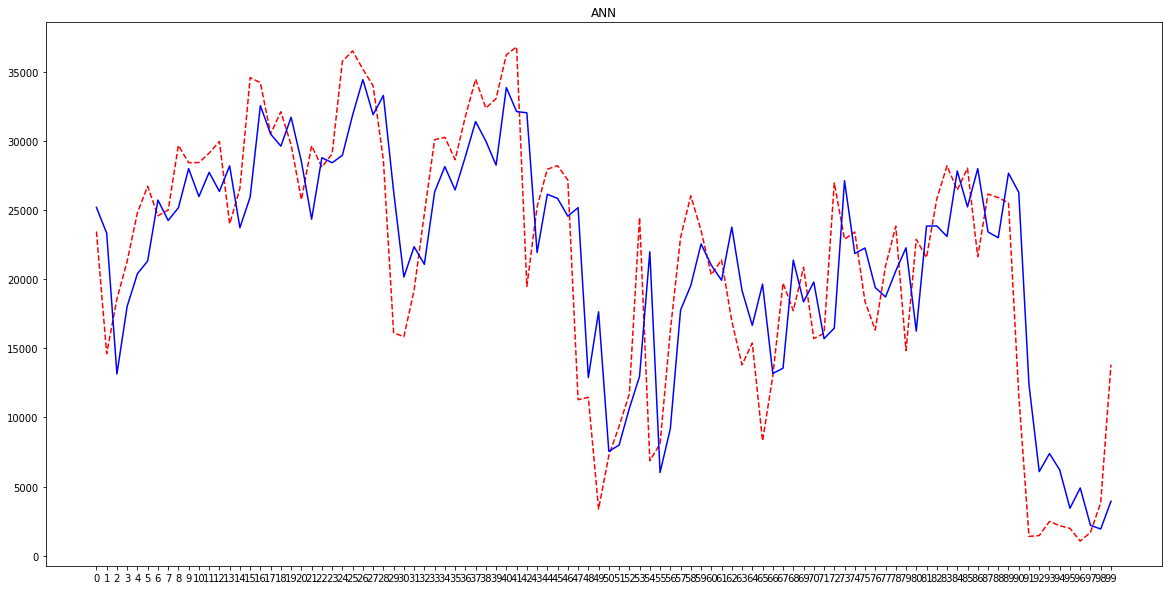

(' Total Time Taken : ', 59.80960512161255)


In [135]:
master_dict= {}
ti = time.time()
activations = ["relu","elu","selu","softplus","linear"]
for i in activations:
    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(d,thermal_dict1,1,"mean_squared_error",1,0,i)
    master_dict[i] = thermal_dict1
tf = time.time()
#print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
#print("\ny_pred",y_pred1,"\ny_test",y_test1)
print (" Total Time Taken : ",tf-ti)

In [136]:
print ("Master Dict : \n")
for key,val in master_dict.iteritems():
    print (key," - ",val,"\n\n")

Master Dict : 

('softplus', ' - ', {0: [[0.68606145671238317, 6567.7935027437197, 4435.7570343378029]]}, '\n\n')
('selu', ' - ', {0: [[0.66474240779092519, 6787.1348985584882, 4676.6047911268515]]}, '\n\n')
('linear', ' - ', {0: [[0.69868452303207507, 6434.3975474601639, 4326.7548077065176]]}, '\n\n')
('relu', ' - ', {0: [[0.65618789267584332, 6873.1805664245385, 4824.3220013332966]]}, '\n\n')
('elu', ' - ', {0: [[0.66010004636668573, 6833.9645715381803, 4701.797566096614]]}, '\n\n')


In [124]:
y

0            1            2            3            4   \
7       16.666667    15.350000   169.950000   198.150000    16.000000   
8       15.933333    16.000000   447.716667    16.000000    16.000000   
9       15.750000    16.000000    16.000000    16.000000    16.000000   
10    1201.133333    16.000000    16.000000    16.000000    16.000000   
11       0.000000  1221.566667   722.100000   701.366667   847.733333   
12    1656.416667  1251.216667  1522.183333    16.116667    67.516667   
13    1961.000000   927.766667    81.350000   132.916667    36.916667   
14    1524.100000  2760.450000    15.083333    16.850000    17.416667   
15      16.000000    16.066667    12.350000    16.000000    15.216667   
16      16.216667    16.050000  1610.283333   438.533333    16.000000   
17     199.550000    16.000000    16.050000    16.000000   335.083333   
18      16.000000    15.350000    15.333333   401.200000    13.200000   
19    1704.400000  1418.750000   757.733333    16.683333    16.000000   
20    1165.500000   530.766667    16.000000    16.000000    16.000000   
21     406.250000   172.700000    16.216667  1013.800000   689.483333   
22      16.450000    18.650000    16.000000    16.000000    16.000000   
23     929.900000   750.333333    16.000000     2.333333     0.000000   
24      16.516667    16.000000   650.316667   348.116667    17.616667   
25      15.866667    16.000000    14.800000   352.966667    16.000000   
26     520.116667    16.000000    16.533333   357.166667    16.000000   
27    1332.283333  1157.766667    16.116667    16.100000   466.783333   
28    1006.233333  1307.466667    16.000000    15.800000    16.000000   
29     637.550000   511.866667   378.566667    18.616667  1510.050000   
30     636.783333   679.466667   617.566667    16.000000    16.000000   
31     482.000000    16.000000    16.000000    15.983333   332.616667   
32    1225.100000  1165.883333   520.350000   728.733333  1360.366667   
33    1396.400000    16.000000   856.683333    16.466667   332.633333   
34      73.833333   928.550000   328.550000    16.000000    16.000000   
35      16.000000    16.000000    15.700000  1618.850000   495.266667   
36      16.550000    16.300000    16.000000    16.000000    16.000000   
...           ...          ...          ...          ...          ...   
1670    10.050000    10.000000    10.000000    10.000000    10.000000   
1671    10.000000    10.000000    10.000000    10.000000    10.000000   
1672    10.000000   421.300000    10.000000    10.000000    10.000000   
1673   339.033333   362.466667    10.350000   518.250000   338.783333   
1674   155.000000    10.166667    10.000000    10.000000    10.383333   
1675    10.050000   416.600000    10.000000    10.250000    10.000000   
1676    10.083333    10.000000    10.000000    10.000000    10.000000   
1677    11.066667    10.100000    10.000000    10.000000    10.000000   
1678   421.816667    10.000000    10.000000    10.400000    10.000000   
1679    10.333333    10.000000    10.000000   417.733333    10.000000   
1680    40.883333    71.100000     9.933333    10.483333     9.633333   
1681   484.683333    69.350000    40.466667    40.416667    40.416667   
1682   419.283333    10.000000    10.000000    10.000000    10.000000   
1683    10.000000    10.000000    10.000000   415.133333    10.000000   
1684    10.000000    10.000000    10.000000    10.000000    10.000000   
1685    10.000000    10.000000    10.000000    10.000000    10.000000   
1686    10.000000    10.000000    10.000000    10.000000    10.000000   
1687    10.000000    10.000000    10.000000    10.000000    10.066667   
1688    10.150000    10.000000    10.000000    10.000000   427.966667   
1689    10.000000  1073.983333  1082.900000    10.066667    10.233333   
1690    10.333333   431.200000    10.000000     9.983333    10.166667   
1691    12.283333   426.100000    10.000000    10.000000    10.000000   
1692   199.650000   497.266667    66.883333    10.550000    40.566667   


('\n Shape of  x : ', (1693, 168))
('\n Shape of  y : ', (1693, 24))
('Split done , the shapes : ', (1185, 168), (1185, 24), (508, 168), (508, 24))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=24, activation="relu", kernel_initializer="normal", input_dim=168)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7, activation="relu", kernel_initializer="normal", input_dim=24)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=24, activation="linear", kernel_initializer="normal", input_dim=7)`


Train on 1042 samples, validate on 143 samples
Epoch 1/750
1042/1042 [==============================] - 1s - loss: 1094847.5000 - mean_squared_error: 1094847.5000 - val_loss: 602988.9375 - val_mean_squared_error: 602988.9375
Epoch 2/750
1042/1042 [==============================] - 0s - loss: 1092445.8750 - mean_squared_error: 1092445.8750 - val_loss: 601592.0625 - val_mean_squared_error: 601592.0625
Epoch 3/750
1042/1042 [==============================] - 0s - loss: 1089738.1250 - mean_squared_error: 1089738.1250 - val_loss: 600045.1875 - val_mean_squared_error: 600045.1875
Epoch 4/750
1042/1042 [==============================] - 0s - loss: 1086824.2500 - mean_squared_error: 1086824.2500 - val_loss: 598329.6875 - val_mean_squared_error: 598329.6875
Epoch 5/750
1042/1042 [==============================] - 0s - loss: 1083582.2500 - mean_squared_error: 1083582.2500 - val_loss: 596377.7500 - val_mean_squared_error: 596377.7500
Epoch 6/750
1042/1042 [==============================] - 0s - l

1042/1042 [==============================] - 0s - loss: 520603.1562 - mean_squared_error: 520603.1562 - val_loss: 316441.4062 - val_mean_squared_error: 316441.4062
Epoch 47/750
1042/1042 [==============================] - 0s - loss: 512384.7500 - mean_squared_error: 512384.7500 - val_loss: 313599.4688 - val_mean_squared_error: 313599.4688
Epoch 48/750
1042/1042 [==============================] - 0s - loss: 505454.3125 - mean_squared_error: 505454.3125 - val_loss: 311361.0000 - val_mean_squared_error: 311361.0000
Epoch 49/750
1042/1042 [==============================] - 0s - loss: 499743.3750 - mean_squared_error: 499743.3750 - val_loss: 309646.5625 - val_mean_squared_error: 309646.5625
Epoch 50/750
1042/1042 [==============================] - 0s - loss: 495091.6875 - mean_squared_error: 495091.6875 - val_loss: 308344.2812 - val_mean_squared_error: 308344.2812
Epoch 51/750
1042/1042 [==============================] - 0s - loss: 491278.9062 - mean_squared_error: 491278.9062 - val_loss: 3

1042/1042 [==============================] - 0s - loss: 432923.0000 - mean_squared_error: 432923.0000 - val_loss: 281225.3438 - val_mean_squared_error: 281225.3438
Epoch 93/750
1042/1042 [==============================] - 0s - loss: 432030.5000 - mean_squared_error: 432030.5000 - val_loss: 280862.9062 - val_mean_squared_error: 280862.9062
Epoch 94/750
1042/1042 [==============================] - 0s - loss: 431126.0625 - mean_squared_error: 431126.0625 - val_loss: 280501.1562 - val_mean_squared_error: 280501.1562
Epoch 95/750
1042/1042 [==============================] - 0s - loss: 430207.1562 - mean_squared_error: 430207.1562 - val_loss: 280131.4688 - val_mean_squared_error: 280131.4688
Epoch 96/750
1042/1042 [==============================] - 0s - loss: 429275.1250 - mean_squared_error: 429275.1250 - val_loss: 279750.8750 - val_mean_squared_error: 279750.8750
Epoch 97/750
1042/1042 [==============================] - 0s - loss: 428329.6250 - mean_squared_error: 428329.6250 - val_loss: 2

1042/1042 [==============================] - 0s - loss: 342890.7500 - mean_squared_error: 342890.7500 - val_loss: 248483.0156 - val_mean_squared_error: 248483.0156
Epoch 139/750
1042/1042 [==============================] - 0s - loss: 339941.0625 - mean_squared_error: 339941.0625 - val_loss: 247779.5312 - val_mean_squared_error: 247779.5312
Epoch 140/750
1042/1042 [==============================] - 0s - loss: 337111.6250 - mean_squared_error: 337111.6250 - val_loss: 247128.0625 - val_mean_squared_error: 247128.0625
Epoch 141/750
1042/1042 [==============================] - 0s - loss: 334392.3438 - mean_squared_error: 334392.3438 - val_loss: 246535.6719 - val_mean_squared_error: 246535.6719
Epoch 142/750
1042/1042 [==============================] - 0s - loss: 331797.0312 - mean_squared_error: 331797.0312 - val_loss: 245998.9375 - val_mean_squared_error: 245998.9375
Epoch 143/750
1042/1042 [==============================] - 0s - loss: 329341.4375 - mean_squared_error: 329341.4375 - val_lo

1042/1042 [==============================] - 0s - loss: 289328.7188 - mean_squared_error: 289328.7188 - val_loss: 240128.2812 - val_mean_squared_error: 240128.2812
Epoch 185/750
1042/1042 [==============================] - 0s - loss: 288947.6250 - mean_squared_error: 288947.6250 - val_loss: 240215.2656 - val_mean_squared_error: 240215.2656
Epoch 186/750
1042/1042 [==============================] - 0s - loss: 288570.8750 - mean_squared_error: 288570.8750 - val_loss: 240304.8906 - val_mean_squared_error: 240304.8906
Epoch 187/750
1042/1042 [==============================] - 0s - loss: 288199.5625 - mean_squared_error: 288199.5625 - val_loss: 240401.6250 - val_mean_squared_error: 240401.6250
Epoch 188/750
1042/1042 [==============================] - 0s - loss: 287832.5000 - mean_squared_error: 287832.5000 - val_loss: 240486.1875 - val_mean_squared_error: 240486.1875
Epoch 189/750
1042/1042 [==============================] - 0s - loss: 287471.6875 - mean_squared_error: 287471.6875 - val_lo

1042/1042 [==============================] - 0s - loss: 275243.6875 - mean_squared_error: 275243.6875 - val_loss: 240611.3281 - val_mean_squared_error: 240611.3281
Epoch 231/750
1042/1042 [==============================] - 0s - loss: 274999.1562 - mean_squared_error: 274999.1562 - val_loss: 240632.5938 - val_mean_squared_error: 240632.5938
Epoch 232/750
1042/1042 [==============================] - 0s - loss: 274747.3750 - mean_squared_error: 274747.3750 - val_loss: 240697.6250 - val_mean_squared_error: 240697.6250
Epoch 233/750
1042/1042 [==============================] - 0s - loss: 274496.2188 - mean_squared_error: 274496.2188 - val_loss: 240663.3594 - val_mean_squared_error: 240663.3594
Epoch 234/750
1042/1042 [==============================] - 0s - loss: 274248.7812 - mean_squared_error: 274248.7812 - val_loss: 240604.1094 - val_mean_squared_error: 240604.1094
Epoch 235/750
1042/1042 [==============================] - 0s - loss: 274004.6250 - mean_squared_error: 274004.6250 - val_lo

1042/1042 [==============================] - 0s - loss: 264169.1250 - mean_squared_error: 264169.1250 - val_loss: 241431.0781 - val_mean_squared_error: 241431.0781
Epoch 277/750
1042/1042 [==============================] - 0s - loss: 263929.9688 - mean_squared_error: 263929.9688 - val_loss: 241450.7656 - val_mean_squared_error: 241450.7656
Epoch 278/750
1042/1042 [==============================] - 0s - loss: 263651.1562 - mean_squared_error: 263651.1562 - val_loss: 241441.2656 - val_mean_squared_error: 241441.2656
Epoch 279/750
1042/1042 [==============================] - 0s - loss: 263397.9688 - mean_squared_error: 263397.9688 - val_loss: 241522.3750 - val_mean_squared_error: 241522.3750
Epoch 280/750
1042/1042 [==============================] - 0s - loss: 263140.5312 - mean_squared_error: 263140.5312 - val_loss: 241657.9531 - val_mean_squared_error: 241657.9531
Epoch 281/750
1042/1042 [==============================] - 0s - loss: 262879.9688 - mean_squared_error: 262879.9688 - val_lo

1042/1042 [==============================] - 0s - loss: 253130.6562 - mean_squared_error: 253130.6562 - val_loss: 244076.8906 - val_mean_squared_error: 244076.8906
Epoch 323/750
1042/1042 [==============================] - 0s - loss: 252916.3906 - mean_squared_error: 252916.3906 - val_loss: 244167.2656 - val_mean_squared_error: 244167.2656
Epoch 324/750
1042/1042 [==============================] - 0s - loss: 252686.5938 - mean_squared_error: 252686.5938 - val_loss: 244354.7188 - val_mean_squared_error: 244354.7188
Epoch 325/750
1042/1042 [==============================] - 0s - loss: 252474.2188 - mean_squared_error: 252474.2188 - val_loss: 244415.5312 - val_mean_squared_error: 244415.5312
Epoch 326/750
1042/1042 [==============================] - 0s - loss: 252248.3750 - mean_squared_error: 252248.3750 - val_loss: 244503.3906 - val_mean_squared_error: 244503.3906
Epoch 327/750
1042/1042 [==============================] - 0s - loss: 252024.7969 - mean_squared_error: 252024.7969 - val_lo

1042/1042 [==============================] - 0s - loss: 243147.9844 - mean_squared_error: 243147.9844 - val_loss: 248859.5781 - val_mean_squared_error: 248859.5781
Epoch 369/750
1042/1042 [==============================] - 0s - loss: 242930.6406 - mean_squared_error: 242930.6406 - val_loss: 248965.8125 - val_mean_squared_error: 248965.8125
Epoch 370/750
1042/1042 [==============================] - 0s - loss: 242725.3750 - mean_squared_error: 242725.3750 - val_loss: 249069.4219 - val_mean_squared_error: 249069.4219
Epoch 371/750
1042/1042 [==============================] - 0s - loss: 242512.2656 - mean_squared_error: 242512.2656 - val_loss: 249201.4844 - val_mean_squared_error: 249201.4844
Epoch 372/750
1042/1042 [==============================] - 0s - loss: 242294.4688 - mean_squared_error: 242294.4688 - val_loss: 249340.7344 - val_mean_squared_error: 249340.7344
Epoch 373/750
1042/1042 [==============================] - 0s - loss: 242090.2656 - mean_squared_error: 242090.2656 - val_lo

1042/1042 [==============================] - 0s - loss: 233374.7656 - mean_squared_error: 233374.7656 - val_loss: 252886.5781 - val_mean_squared_error: 252886.5781
Epoch 415/750
1042/1042 [==============================] - 0s - loss: 233174.7031 - mean_squared_error: 233174.7031 - val_loss: 252986.3750 - val_mean_squared_error: 252986.3750
Epoch 416/750
1042/1042 [==============================] - 0s - loss: 232979.3750 - mean_squared_error: 232979.3750 - val_loss: 253102.2656 - val_mean_squared_error: 253102.2656
Epoch 417/750
1042/1042 [==============================] - 0s - loss: 232755.3438 - mean_squared_error: 232755.3438 - val_loss: 253251.2969 - val_mean_squared_error: 253251.2969
Epoch 418/750
1042/1042 [==============================] - 0s - loss: 232549.8125 - mean_squared_error: 232549.8125 - val_loss: 253301.5312 - val_mean_squared_error: 253301.5312
Epoch 419/750
1042/1042 [==============================] - 0s - loss: 232338.8438 - mean_squared_error: 232338.8438 - val_lo

1042/1042 [==============================] - 0s - loss: 224509.5625 - mean_squared_error: 224509.5625 - val_loss: 257101.8438 - val_mean_squared_error: 257101.8438
Epoch 461/750
1042/1042 [==============================] - 0s - loss: 224337.7656 - mean_squared_error: 224337.7656 - val_loss: 257325.5625 - val_mean_squared_error: 257325.5625
Epoch 462/750
1042/1042 [==============================] - 0s - loss: 224152.1250 - mean_squared_error: 224152.1250 - val_loss: 257357.8125 - val_mean_squared_error: 257357.8125
Epoch 463/750
1042/1042 [==============================] - 0s - loss: 223977.8125 - mean_squared_error: 223977.8125 - val_loss: 257237.0312 - val_mean_squared_error: 257237.0312
Epoch 464/750
1042/1042 [==============================] - 0s - loss: 223811.9531 - mean_squared_error: 223811.9531 - val_loss: 257229.9375 - val_mean_squared_error: 257229.9375
Epoch 465/750
1042/1042 [==============================] - 0s - loss: 223633.3906 - mean_squared_error: 223633.3906 - val_lo

1042/1042 [==============================] - 0s - loss: 216693.8906 - mean_squared_error: 216693.8906 - val_loss: 261940.2500 - val_mean_squared_error: 261940.2500
Epoch 507/750
1042/1042 [==============================] - 0s - loss: 216519.2500 - mean_squared_error: 216519.2500 - val_loss: 261879.5000 - val_mean_squared_error: 261879.5000
Epoch 508/750
1042/1042 [==============================] - 0s - loss: 216357.1406 - mean_squared_error: 216357.1406 - val_loss: 261854.3750 - val_mean_squared_error: 261854.3750
Epoch 509/750
1042/1042 [==============================] - 0s - loss: 216170.4219 - mean_squared_error: 216170.4219 - val_loss: 261877.5625 - val_mean_squared_error: 261877.5625
Epoch 510/750
1042/1042 [==============================] - 0s - loss: 216010.6719 - mean_squared_error: 216010.6719 - val_loss: 261984.4219 - val_mean_squared_error: 261984.4219
Epoch 511/750
1042/1042 [==============================] - 0s - loss: 215846.6406 - mean_squared_error: 215846.6406 - val_lo

1042/1042 [==============================] - 0s - loss: 209156.9219 - mean_squared_error: 209156.9219 - val_loss: 266704.7188 - val_mean_squared_error: 266704.7188
Epoch 553/750
1042/1042 [==============================] - 0s - loss: 209020.5625 - mean_squared_error: 209020.5625 - val_loss: 266593.1875 - val_mean_squared_error: 266593.1875
Epoch 554/750
1042/1042 [==============================] - 0s - loss: 208820.2031 - mean_squared_error: 208820.2031 - val_loss: 266695.2500 - val_mean_squared_error: 266695.2500
Epoch 555/750
1042/1042 [==============================] - 0s - loss: 208647.8906 - mean_squared_error: 208647.8906 - val_loss: 266999.0625 - val_mean_squared_error: 266999.0625
Epoch 556/750
1042/1042 [==============================] - 0s - loss: 208529.2812 - mean_squared_error: 208529.2812 - val_loss: 267114.4062 - val_mean_squared_error: 267114.4062
Epoch 557/750
1042/1042 [==============================] - 0s - loss: 208364.2969 - mean_squared_error: 208364.2969 - val_lo

1042/1042 [==============================] - 0s - loss: 202038.5469 - mean_squared_error: 202038.5469 - val_loss: 271928.8125 - val_mean_squared_error: 271928.8125
Epoch 599/750
1042/1042 [==============================] - 0s - loss: 201909.1406 - mean_squared_error: 201909.1406 - val_loss: 272173.3438 - val_mean_squared_error: 272173.3438
Epoch 600/750
1042/1042 [==============================] - 0s - loss: 201756.4844 - mean_squared_error: 201756.4844 - val_loss: 272460.0312 - val_mean_squared_error: 272460.0312
Epoch 601/750
1042/1042 [==============================] - 0s - loss: 201607.4062 - mean_squared_error: 201607.4062 - val_loss: 272705.1875 - val_mean_squared_error: 272705.1875
Epoch 602/750
1042/1042 [==============================] - 0s - loss: 201460.7344 - mean_squared_error: 201460.7344 - val_loss: 272798.1875 - val_mean_squared_error: 272798.1875
Epoch 603/750
1042/1042 [==============================] - 0s - loss: 201304.0469 - mean_squared_error: 201304.0469 - val_lo

1042/1042 [==============================] - 0s - loss: 195507.4219 - mean_squared_error: 195507.4219 - val_loss: 280099.4062 - val_mean_squared_error: 280099.4062
Epoch 645/750
1042/1042 [==============================] - 0s - loss: 195439.7500 - mean_squared_error: 195439.7500 - val_loss: 280130.4375 - val_mean_squared_error: 280130.4375
Epoch 646/750
1042/1042 [==============================] - 0s - loss: 195290.3906 - mean_squared_error: 195290.3906 - val_loss: 280431.6250 - val_mean_squared_error: 280431.6250
Epoch 647/750
1042/1042 [==============================] - 0s - loss: 195081.5156 - mean_squared_error: 195081.5156 - val_loss: 280826.8125 - val_mean_squared_error: 280826.8125
Epoch 648/750
1042/1042 [==============================] - 0s - loss: 195017.8438 - mean_squared_error: 195017.8438 - val_loss: 280856.0625 - val_mean_squared_error: 280856.0625
Epoch 649/750
1042/1042 [==============================] - 0s - loss: 194851.6719 - mean_squared_error: 194851.6719 - val_lo

1042/1042 [==============================] - 0s - loss: 189426.7969 - mean_squared_error: 189426.7969 - val_loss: 288933.5938 - val_mean_squared_error: 288933.5938
Epoch 691/750
1042/1042 [==============================] - 0s - loss: 189314.7812 - mean_squared_error: 189314.7812 - val_loss: 289242.5000 - val_mean_squared_error: 289242.5000
Epoch 692/750
1042/1042 [==============================] - 0s - loss: 189197.0781 - mean_squared_error: 189197.0781 - val_loss: 289294.0000 - val_mean_squared_error: 289294.0000
Epoch 693/750
1042/1042 [==============================] - 0s - loss: 189022.0312 - mean_squared_error: 189022.0312 - val_loss: 289345.8750 - val_mean_squared_error: 289345.8750
Epoch 694/750
1042/1042 [==============================] - 0s - loss: 188955.9688 - mean_squared_error: 188955.9688 - val_loss: 289478.8438 - val_mean_squared_error: 289478.8438
Epoch 695/750
1042/1042 [==============================] - 0s - loss: 188781.3125 - mean_squared_error: 188781.3125 - val_lo

1042/1042 [==============================] - 0s - loss: 183923.4219 - mean_squared_error: 183923.4219 - val_loss: 296231.0625 - val_mean_squared_error: 296231.0625
Epoch 737/750
1042/1042 [==============================] - 0s - loss: 183831.4062 - mean_squared_error: 183831.4062 - val_loss: 296649.2188 - val_mean_squared_error: 296649.2188
Epoch 738/750
1042/1042 [==============================] - 0s - loss: 183702.5938 - mean_squared_error: 183702.5938 - val_loss: 296639.6250 - val_mean_squared_error: 296639.6250
Epoch 739/750
1042/1042 [==============================] - 0s - loss: 183633.0312 - mean_squared_error: 183633.0312 - val_loss: 296625.8750 - val_mean_squared_error: 296625.8750
Epoch 740/750
1042/1042 [==============================] - 0s - loss: 183481.4844 - mean_squared_error: 183481.4844 - val_loss: 296466.9375 - val_mean_squared_error: 296466.9375
Epoch 741/750
1042/1042 [==============================] - 0s - loss: 183428.9062 - mean_squared_error: 183428.9062 - val_lo

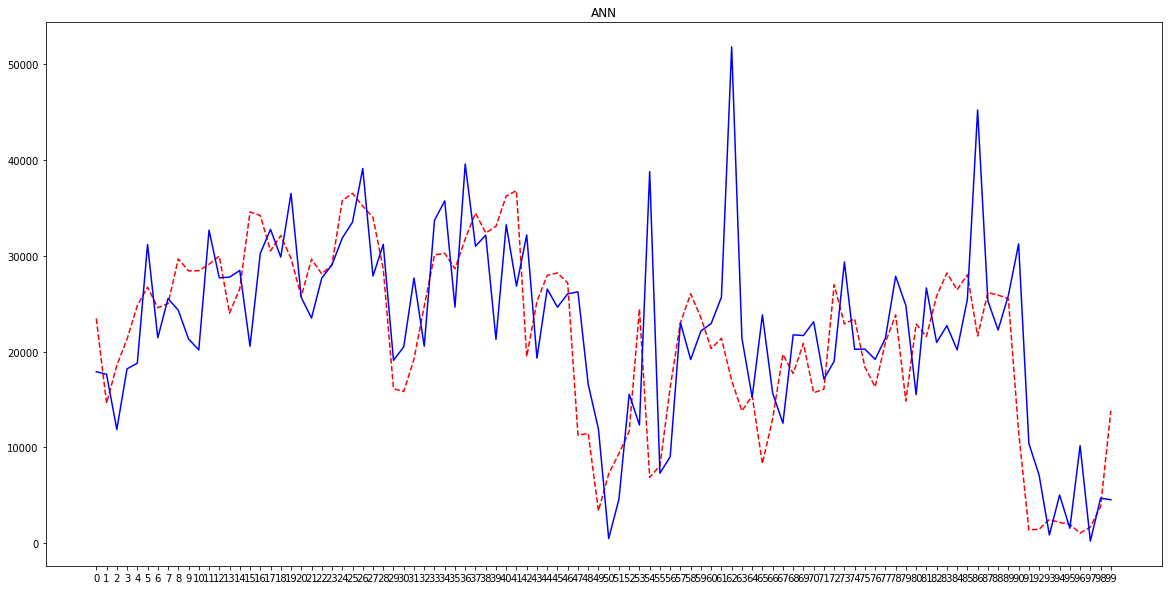

('\n Shape of  x : ', (1693, 168))
('\n Shape of  y : ', (1693, 24))
('Split done , the shapes : ', (1185, 168), (1185, 24), (508, 168), (508, 24))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=24, activation="elu", kernel_initializer="normal", input_dim=168)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7, activation="elu", kernel_initializer="normal", input_dim=24)`


Train on 1042 samples, validate on 143 samples
Epoch 1/750
1042/1042 [==============================] - 0s - loss: 1094275.3750 - mean_squared_error: 1094275.3750 - val_loss: 602873.9375 - val_mean_squared_error: 602873.9375
Epoch 2/750
1042/1042 [==============================] - 0s - loss: 1092578.1250 - mean_squared_error: 1092578.1250 - val_loss: 602097.8750 - val_mean_squared_error: 602097.8750
Epoch 3/750
1042/1042 [==============================] - 0s - loss: 1091097.6250 - mean_squared_error: 1091097.6250 - val_loss: 601206.1875 - val_mean_squared_error: 601206.1875
Epoch 4/750
1042/1042 [==============================] - 0s - loss: 1089476.8750 - mean_squared_error: 1089476.8750 - val_loss: 600154.9375 - val_mean_squared_error: 600154.9375
Epoch 5/750
1042/1042 [==============================] - 0s - loss: 1087547.3750 - mean_squared_error: 1087547.3750 - val_loss: 598929.3125 - val_mean_squared_error: 598929.3125
Epoch 6/750
1042/1042 [==============================] - 0s - l

1042/1042 [==============================] - 0s - loss: 556569.3750 - mean_squared_error: 556569.3750 - val_loss: 339122.7812 - val_mean_squared_error: 339122.7812
Epoch 47/750
1042/1042 [==============================] - 0s - loss: 547347.5625 - mean_squared_error: 547347.5625 - val_loss: 334955.1875 - val_mean_squared_error: 334955.1875
Epoch 48/750
1042/1042 [==============================] - 0s - loss: 538105.1875 - mean_squared_error: 538105.1875 - val_loss: 330852.2500 - val_mean_squared_error: 330852.2500
Epoch 49/750
1042/1042 [==============================] - 0s - loss: 529156.5625 - mean_squared_error: 529156.5625 - val_loss: 326960.2188 - val_mean_squared_error: 326960.2188
Epoch 50/750
1042/1042 [==============================] - 0s - loss: 520748.5312 - mean_squared_error: 520748.5312 - val_loss: 323400.1250 - val_mean_squared_error: 323400.1250
Epoch 51/750
1042/1042 [==============================] - 0s - loss: 513090.8125 - mean_squared_error: 513090.8125 - val_loss: 3

1042/1042 [==============================] - 0s - loss: 408663.5312 - mean_squared_error: 408663.5312 - val_loss: 271126.0000 - val_mean_squared_error: 271126.0000
Epoch 93/750
1042/1042 [==============================] - 0s - loss: 406287.0312 - mean_squared_error: 406287.0312 - val_loss: 270123.6250 - val_mean_squared_error: 270123.6250
Epoch 94/750
1042/1042 [==============================] - 0s - loss: 403895.1250 - mean_squared_error: 403895.1250 - val_loss: 269129.8438 - val_mean_squared_error: 269129.8438
Epoch 95/750
1042/1042 [==============================] - 0s - loss: 401490.9688 - mean_squared_error: 401490.9688 - val_loss: 268149.7500 - val_mean_squared_error: 268149.7500
Epoch 96/750
1042/1042 [==============================] - 0s - loss: 399079.2812 - mean_squared_error: 399079.2812 - val_loss: 267178.6562 - val_mean_squared_error: 267178.6562
Epoch 97/750
1042/1042 [==============================] - 0s - loss: 396649.0312 - mean_squared_error: 396649.0312 - val_loss: 2

1042/1042 [==============================] - 0s - loss: 319362.4375 - mean_squared_error: 319362.4375 - val_loss: 240543.9219 - val_mean_squared_error: 240543.9219
Epoch 139/750
1042/1042 [==============================] - 0s - loss: 318446.9062 - mean_squared_error: 318446.9062 - val_loss: 240363.7812 - val_mean_squared_error: 240363.7812
Epoch 140/750
1042/1042 [==============================] - 0s - loss: 317556.6875 - mean_squared_error: 317556.6875 - val_loss: 240196.8594 - val_mean_squared_error: 240196.8594
Epoch 141/750
1042/1042 [==============================] - 0s - loss: 316695.7812 - mean_squared_error: 316695.7812 - val_loss: 240046.6875 - val_mean_squared_error: 240046.6875
Epoch 142/750
1042/1042 [==============================] - 0s - loss: 315857.9062 - mean_squared_error: 315857.9062 - val_loss: 239912.0000 - val_mean_squared_error: 239912.0000
Epoch 143/750
1042/1042 [==============================] - 0s - loss: 315047.2812 - mean_squared_error: 315047.2812 - val_lo

1042/1042 [==============================] - 0s - loss: 295429.8125 - mean_squared_error: 295429.8125 - val_loss: 237870.8750 - val_mean_squared_error: 237870.8750
Epoch 185/750
1042/1042 [==============================] - 0s - loss: 295108.5312 - mean_squared_error: 295108.5312 - val_loss: 237851.1094 - val_mean_squared_error: 237851.1094
Epoch 186/750
1042/1042 [==============================] - 0s - loss: 294784.2188 - mean_squared_error: 294784.2188 - val_loss: 237811.9688 - val_mean_squared_error: 237811.9688
Epoch 187/750
1042/1042 [==============================] - 0s - loss: 294459.5625 - mean_squared_error: 294459.5625 - val_loss: 237761.7656 - val_mean_squared_error: 237761.7656
Epoch 188/750
1042/1042 [==============================] - 0s - loss: 294140.8125 - mean_squared_error: 294140.8125 - val_loss: 237734.9688 - val_mean_squared_error: 237734.9688
Epoch 189/750
1042/1042 [==============================] - 0s - loss: 293819.0938 - mean_squared_error: 293819.0938 - val_lo

1042/1042 [==============================] - 0s - loss: 281368.5312 - mean_squared_error: 281368.5312 - val_loss: 238433.1406 - val_mean_squared_error: 238433.1406
Epoch 231/750
1042/1042 [==============================] - 0s - loss: 281046.3750 - mean_squared_error: 281046.3750 - val_loss: 238468.7031 - val_mean_squared_error: 238468.7031
Epoch 232/750
1042/1042 [==============================] - 0s - loss: 280716.6562 - mean_squared_error: 280716.6562 - val_loss: 238545.8438 - val_mean_squared_error: 238545.8438
Epoch 233/750
1042/1042 [==============================] - 0s - loss: 280435.9062 - mean_squared_error: 280435.9062 - val_loss: 238559.2188 - val_mean_squared_error: 238559.2188
Epoch 234/750
1042/1042 [==============================] - 0s - loss: 280141.4062 - mean_squared_error: 280141.4062 - val_loss: 238486.0625 - val_mean_squared_error: 238486.0625
Epoch 235/750
1042/1042 [==============================] - 0s - loss: 279860.2188 - mean_squared_error: 279860.2188 - val_lo

1042/1042 [==============================] - 0s - loss: 268261.5000 - mean_squared_error: 268261.5000 - val_loss: 242542.2344 - val_mean_squared_error: 242542.2344
Epoch 277/750
1042/1042 [==============================] - 0s - loss: 267981.3438 - mean_squared_error: 267981.3438 - val_loss: 242729.0000 - val_mean_squared_error: 242729.0000
Epoch 278/750
1042/1042 [==============================] - 0s - loss: 267717.7500 - mean_squared_error: 267717.7500 - val_loss: 242843.7969 - val_mean_squared_error: 242843.7969
Epoch 279/750
1042/1042 [==============================] - 0s - loss: 267442.5938 - mean_squared_error: 267442.5938 - val_loss: 242954.9375 - val_mean_squared_error: 242954.9375
Epoch 280/750
1042/1042 [==============================] - 0s - loss: 267167.3438 - mean_squared_error: 267167.3438 - val_loss: 243136.3281 - val_mean_squared_error: 243136.3281
Epoch 281/750
1042/1042 [==============================] - 0s - loss: 266894.6250 - mean_squared_error: 266894.6250 - val_lo

1042/1042 [==============================] - 0s - loss: 253891.6406 - mean_squared_error: 253891.6406 - val_loss: 251964.2812 - val_mean_squared_error: 251964.2812
Epoch 323/750
1042/1042 [==============================] - 0s - loss: 253547.8906 - mean_squared_error: 253547.8906 - val_loss: 252041.1250 - val_mean_squared_error: 252041.1250
Epoch 324/750
1042/1042 [==============================] - 0s - loss: 253184.1250 - mean_squared_error: 253184.1250 - val_loss: 252223.7969 - val_mean_squared_error: 252223.7969
Epoch 325/750
1042/1042 [==============================] - 0s - loss: 252847.1875 - mean_squared_error: 252847.1875 - val_loss: 252499.4688 - val_mean_squared_error: 252499.4688
Epoch 326/750
1042/1042 [==============================] - 0s - loss: 252494.1250 - mean_squared_error: 252494.1250 - val_loss: 252761.0312 - val_mean_squared_error: 252761.0312
Epoch 327/750
1042/1042 [==============================] - 0s - loss: 252167.7188 - mean_squared_error: 252167.7188 - val_lo

1042/1042 [==============================] - 0s - loss: 236913.3438 - mean_squared_error: 236913.3438 - val_loss: 262960.8750 - val_mean_squared_error: 262960.8750
Epoch 369/750
1042/1042 [==============================] - 0s - loss: 236553.5156 - mean_squared_error: 236553.5156 - val_loss: 263172.5000 - val_mean_squared_error: 263172.5000
Epoch 370/750
1042/1042 [==============================] - 0s - loss: 236209.5312 - mean_squared_error: 236209.5312 - val_loss: 263506.0312 - val_mean_squared_error: 263506.0312
Epoch 371/750
1042/1042 [==============================] - 0s - loss: 235889.3125 - mean_squared_error: 235889.3125 - val_loss: 263473.4375 - val_mean_squared_error: 263473.4375
Epoch 372/750
1042/1042 [==============================] - 0s - loss: 235554.6406 - mean_squared_error: 235554.6406 - val_loss: 263943.5625 - val_mean_squared_error: 263943.5625
Epoch 373/750
1042/1042 [==============================] - 0s - loss: 235209.6719 - mean_squared_error: 235209.6719 - val_lo

1042/1042 [==============================] - 0s - loss: 222833.7812 - mean_squared_error: 222833.7812 - val_loss: 271328.7500 - val_mean_squared_error: 271328.7500
Epoch 415/750
1042/1042 [==============================] - 0s - loss: 222517.0312 - mean_squared_error: 222517.0312 - val_loss: 271468.2188 - val_mean_squared_error: 271468.2188
Epoch 416/750
1042/1042 [==============================] - 0s - loss: 222242.9062 - mean_squared_error: 222242.9062 - val_loss: 271867.8438 - val_mean_squared_error: 271867.8438
Epoch 417/750
1042/1042 [==============================] - 0s - loss: 222022.3438 - mean_squared_error: 222022.3438 - val_loss: 272001.0625 - val_mean_squared_error: 272001.0625
Epoch 418/750
1042/1042 [==============================] - 0s - loss: 221814.5312 - mean_squared_error: 221814.5312 - val_loss: 272387.6250 - val_mean_squared_error: 272387.6250
Epoch 419/750
1042/1042 [==============================] - 0s - loss: 221420.3906 - mean_squared_error: 221420.3906 - val_lo

1042/1042 [==============================] - 0s - loss: 211939.8125 - mean_squared_error: 211939.8125 - val_loss: 276875.8750 - val_mean_squared_error: 276875.8750
Epoch 461/750
1042/1042 [==============================] - 0s - loss: 211764.4688 - mean_squared_error: 211764.4688 - val_loss: 277165.2500 - val_mean_squared_error: 277165.2500
Epoch 462/750
1042/1042 [==============================] - 0s - loss: 211558.5625 - mean_squared_error: 211558.5625 - val_loss: 277289.3750 - val_mean_squared_error: 277289.3750
Epoch 463/750
1042/1042 [==============================] - 0s - loss: 211368.2500 - mean_squared_error: 211368.2500 - val_loss: 277186.9375 - val_mean_squared_error: 277186.9375
Epoch 464/750
1042/1042 [==============================] - 0s - loss: 211110.6406 - mean_squared_error: 211110.6406 - val_loss: 277190.9062 - val_mean_squared_error: 277190.9062
Epoch 465/750
1042/1042 [==============================] - 0s - loss: 210978.7500 - mean_squared_error: 210978.7500 - val_lo

1042/1042 [==============================] - 0s - loss: 203619.0781 - mean_squared_error: 203619.0781 - val_loss: 281929.0938 - val_mean_squared_error: 281929.0938
Epoch 507/750
1042/1042 [==============================] - 0s - loss: 203405.5000 - mean_squared_error: 203405.5000 - val_loss: 282160.3125 - val_mean_squared_error: 282160.3125
Epoch 508/750
1042/1042 [==============================] - 0s - loss: 203185.2500 - mean_squared_error: 203185.2500 - val_loss: 282363.2188 - val_mean_squared_error: 282363.2188
Epoch 509/750
1042/1042 [==============================] - 0s - loss: 203017.2969 - mean_squared_error: 203017.2969 - val_loss: 282468.4062 - val_mean_squared_error: 282468.4062
Epoch 510/750
1042/1042 [==============================] - 0s - loss: 202901.4531 - mean_squared_error: 202901.4531 - val_loss: 282765.5000 - val_mean_squared_error: 282765.5000
Epoch 511/750
1042/1042 [==============================] - 0s - loss: 202671.7344 - mean_squared_error: 202671.7344 - val_lo

1042/1042 [==============================] - 0s - loss: 196421.0000 - mean_squared_error: 196421.0000 - val_loss: 287315.7812 - val_mean_squared_error: 287315.7812
Epoch 553/750
1042/1042 [==============================] - 0s - loss: 196293.2812 - mean_squared_error: 196293.2812 - val_loss: 287212.4375 - val_mean_squared_error: 287212.4375
Epoch 554/750
1042/1042 [==============================] - 0s - loss: 196127.0000 - mean_squared_error: 196127.0000 - val_loss: 287185.9688 - val_mean_squared_error: 287185.9688
Epoch 555/750
1042/1042 [==============================] - 0s - loss: 196001.8438 - mean_squared_error: 196001.8438 - val_loss: 287468.6875 - val_mean_squared_error: 287468.6875
Epoch 556/750
1042/1042 [==============================] - 0s - loss: 195899.7500 - mean_squared_error: 195899.7500 - val_loss: 287348.7500 - val_mean_squared_error: 287348.7500
Epoch 557/750
1042/1042 [==============================] - 0s - loss: 195714.3125 - mean_squared_error: 195714.3125 - val_lo

1042/1042 [==============================] - 0s - loss: 190174.9688 - mean_squared_error: 190174.9688 - val_loss: 294128.3750 - val_mean_squared_error: 294128.3750
Epoch 599/750
1042/1042 [==============================] - 0s - loss: 189991.7188 - mean_squared_error: 189991.7188 - val_loss: 294595.9375 - val_mean_squared_error: 294595.9375
Epoch 600/750
1042/1042 [==============================] - 0s - loss: 189823.1875 - mean_squared_error: 189823.1875 - val_loss: 294671.3438 - val_mean_squared_error: 294671.3438
Epoch 601/750
1042/1042 [==============================] - 0s - loss: 189697.0938 - mean_squared_error: 189697.0938 - val_loss: 294654.3438 - val_mean_squared_error: 294654.3438
Epoch 602/750
1042/1042 [==============================] - 0s - loss: 189600.4375 - mean_squared_error: 189600.4375 - val_loss: 295532.0312 - val_mean_squared_error: 295532.0312
Epoch 603/750
1042/1042 [==============================] - 0s - loss: 189503.3438 - mean_squared_error: 189503.3438 - val_lo

1042/1042 [==============================] - 0s - loss: 184087.9375 - mean_squared_error: 184087.9375 - val_loss: 300995.5938 - val_mean_squared_error: 300995.5938
Epoch 645/750
1042/1042 [==============================] - 0s - loss: 183947.7188 - mean_squared_error: 183947.7188 - val_loss: 300711.1875 - val_mean_squared_error: 300711.1875
Epoch 646/750
1042/1042 [==============================] - 0s - loss: 183877.2812 - mean_squared_error: 183877.2812 - val_loss: 301228.1250 - val_mean_squared_error: 301228.1250
Epoch 647/750
1042/1042 [==============================] - 0s - loss: 183751.9219 - mean_squared_error: 183751.9219 - val_loss: 301110.3750 - val_mean_squared_error: 301110.3750
Epoch 648/750
1042/1042 [==============================] - 0s - loss: 183615.6406 - mean_squared_error: 183615.6406 - val_loss: 301922.1875 - val_mean_squared_error: 301922.1875
Epoch 649/750
1042/1042 [==============================] - 0s - loss: 183516.1562 - mean_squared_error: 183516.1562 - val_lo

1042/1042 [==============================] - 0s - loss: 178954.7656 - mean_squared_error: 178954.7656 - val_loss: 307182.9375 - val_mean_squared_error: 307182.9375
Epoch 691/750
1042/1042 [==============================] - 0s - loss: 178801.0312 - mean_squared_error: 178801.0312 - val_loss: 307230.8125 - val_mean_squared_error: 307230.8125
Epoch 692/750
1042/1042 [==============================] - 0s - loss: 178739.2500 - mean_squared_error: 178739.2500 - val_loss: 307335.5938 - val_mean_squared_error: 307335.5938
Epoch 693/750
1042/1042 [==============================] - 0s - loss: 178671.5625 - mean_squared_error: 178671.5625 - val_loss: 308010.5938 - val_mean_squared_error: 308010.5938
Epoch 694/750
1042/1042 [==============================] - 0s - loss: 178581.7500 - mean_squared_error: 178581.7500 - val_loss: 307424.0312 - val_mean_squared_error: 307424.0312
Epoch 695/750
1042/1042 [==============================] - 0s - loss: 178465.1719 - mean_squared_error: 178465.1719 - val_lo

1042/1042 [==============================] - 0s - loss: 174519.0312 - mean_squared_error: 174519.0312 - val_loss: 313963.0000 - val_mean_squared_error: 313963.0000
Epoch 737/750
1042/1042 [==============================] - 0s - loss: 174454.7500 - mean_squared_error: 174454.7500 - val_loss: 313797.6250 - val_mean_squared_error: 313797.6250
Epoch 738/750
1042/1042 [==============================] - 0s - loss: 174411.1094 - mean_squared_error: 174411.1094 - val_loss: 314531.5625 - val_mean_squared_error: 314531.5625
Epoch 739/750
1042/1042 [==============================] - 0s - loss: 174388.0156 - mean_squared_error: 174388.0156 - val_loss: 314156.9375 - val_mean_squared_error: 314156.9375
Epoch 740/750
1042/1042 [==============================] - 0s - loss: 174311.5625 - mean_squared_error: 174311.5625 - val_loss: 314511.6875 - val_mean_squared_error: 314511.6875
Epoch 741/750
1042/1042 [==============================] - 0s - loss: 174160.6094 - mean_squared_error: 174160.6094 - val_lo

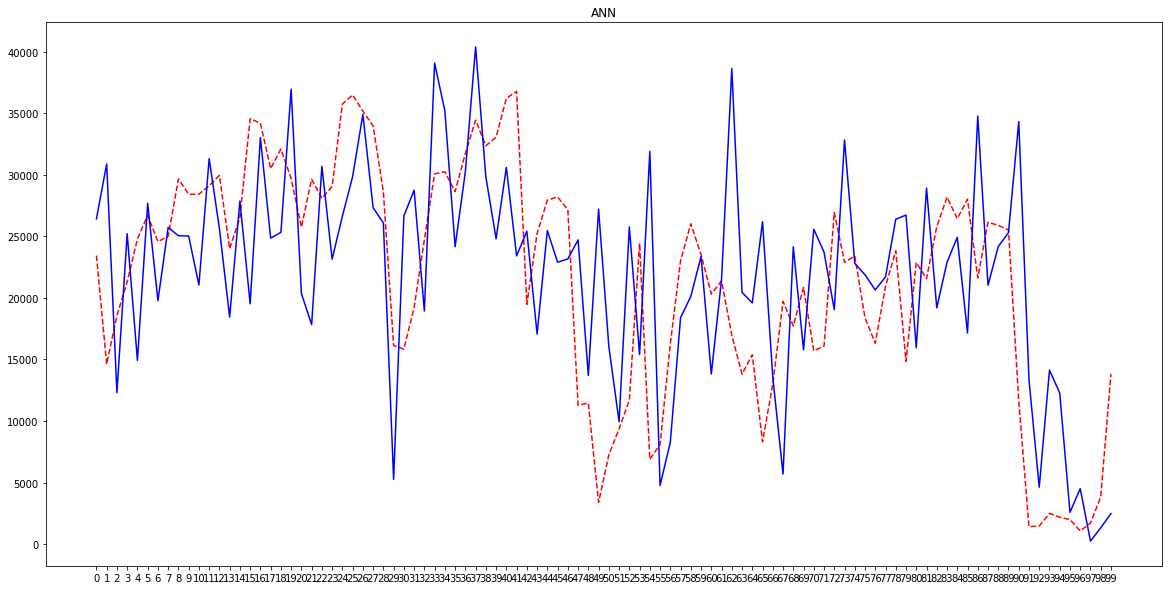

('\n Shape of  x : ', (1693, 168))
('\n Shape of  y : ', (1693, 24))
('Split done , the shapes : ', (1185, 168), (1185, 24), (508, 168), (508, 24))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=24, activation="selu", kernel_initializer="normal", input_dim=168)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7, activation="selu", kernel_initializer="normal", input_dim=24)`


Train on 1042 samples, validate on 143 samples
Epoch 1/750
1042/1042 [==============================] - 0s - loss: 1093296.8750 - mean_squared_error: 1093296.8750 - val_loss: 600727.1250 - val_mean_squared_error: 600727.1250
Epoch 2/750
1042/1042 [==============================] - 0s - loss: 1088920.8750 - mean_squared_error: 1088920.8750 - val_loss: 598416.1875 - val_mean_squared_error: 598416.1875
Epoch 3/750
1042/1042 [==============================] - 0s - loss: 1084206.3750 - mean_squared_error: 1084206.3750 - val_loss: 595964.7500 - val_mean_squared_error: 595964.7500
Epoch 4/750
1042/1042 [==============================] - 0s - loss: 1079284.5000 - mean_squared_error: 1079284.5000 - val_loss: 593168.0625 - val_mean_squared_error: 593168.0625
Epoch 5/750
1042/1042 [==============================] - 0s - loss: 1073732.3750 - mean_squared_error: 1073732.3750 - val_loss: 590064.2500 - val_mean_squared_error: 590064.2500
Epoch 6/750
1042/1042 [==============================] - 0s - l

1042/1042 [==============================] - 0s - loss: 517156.7812 - mean_squared_error: 517156.7812 - val_loss: 321300.0625 - val_mean_squared_error: 321300.0625
Epoch 47/750
1042/1042 [==============================] - 0s - loss: 512253.1875 - mean_squared_error: 512253.1875 - val_loss: 319161.7188 - val_mean_squared_error: 319161.7188
Epoch 48/750
1042/1042 [==============================] - 0s - loss: 507827.0312 - mean_squared_error: 507827.0312 - val_loss: 317191.7500 - val_mean_squared_error: 317191.7500
Epoch 49/750
1042/1042 [==============================] - 0s - loss: 503733.1250 - mean_squared_error: 503733.1250 - val_loss: 315336.6562 - val_mean_squared_error: 315336.6562
Epoch 50/750
1042/1042 [==============================] - 0s - loss: 499860.6250 - mean_squared_error: 499860.6250 - val_loss: 313563.8750 - val_mean_squared_error: 313563.8750
Epoch 51/750
1042/1042 [==============================] - 0s - loss: 496143.0938 - mean_squared_error: 496143.0938 - val_loss: 3

1042/1042 [==============================] - 0s - loss: 431293.0625 - mean_squared_error: 431293.0625 - val_loss: 281138.5312 - val_mean_squared_error: 281138.5312
Epoch 93/750
1042/1042 [==============================] - 0s - loss: 430533.3750 - mean_squared_error: 430533.3750 - val_loss: 280783.6875 - val_mean_squared_error: 280783.6875
Epoch 94/750
1042/1042 [==============================] - 0s - loss: 429778.0938 - mean_squared_error: 429778.0938 - val_loss: 280430.7500 - val_mean_squared_error: 280430.7500
Epoch 95/750
1042/1042 [==============================] - 0s - loss: 429030.1562 - mean_squared_error: 429030.1562 - val_loss: 280079.6562 - val_mean_squared_error: 280079.6562
Epoch 96/750
1042/1042 [==============================] - 0s - loss: 428287.3125 - mean_squared_error: 428287.3125 - val_loss: 279731.2188 - val_mean_squared_error: 279731.2188
Epoch 97/750
1042/1042 [==============================] - 0s - loss: 427548.0000 - mean_squared_error: 427548.0000 - val_loss: 2

1042/1042 [==============================] - 0s - loss: 391374.2188 - mean_squared_error: 391374.2188 - val_loss: 265146.2500 - val_mean_squared_error: 265146.2500
Epoch 139/750
1042/1042 [==============================] - 0s - loss: 390027.5000 - mean_squared_error: 390027.5000 - val_loss: 264672.4688 - val_mean_squared_error: 264672.4688
Epoch 140/750
1042/1042 [==============================] - 0s - loss: 388634.7812 - mean_squared_error: 388634.7812 - val_loss: 264186.3750 - val_mean_squared_error: 264186.3750
Epoch 141/750
1042/1042 [==============================] - 0s - loss: 387191.9062 - mean_squared_error: 387191.9062 - val_loss: 263686.0625 - val_mean_squared_error: 263686.0625
Epoch 142/750
1042/1042 [==============================] - 0s - loss: 385700.2188 - mean_squared_error: 385700.2188 - val_loss: 263168.7500 - val_mean_squared_error: 263168.7500
Epoch 143/750
1042/1042 [==============================] - 0s - loss: 384163.2812 - mean_squared_error: 384163.2812 - val_lo

1042/1042 [==============================] - 0s - loss: 306909.9688 - mean_squared_error: 306909.9688 - val_loss: 243339.1406 - val_mean_squared_error: 243339.1406
Epoch 185/750
1042/1042 [==============================] - 0s - loss: 305970.8750 - mean_squared_error: 305970.8750 - val_loss: 243157.6719 - val_mean_squared_error: 243157.6719
Epoch 186/750
1042/1042 [==============================] - 0s - loss: 305066.1562 - mean_squared_error: 305066.1562 - val_loss: 242960.4688 - val_mean_squared_error: 242960.4688
Epoch 187/750
1042/1042 [==============================] - 0s - loss: 304190.0625 - mean_squared_error: 304190.0625 - val_loss: 242763.0469 - val_mean_squared_error: 242763.0469
Epoch 188/750
1042/1042 [==============================] - 0s - loss: 303338.6875 - mean_squared_error: 303338.6875 - val_loss: 242558.6250 - val_mean_squared_error: 242558.6250
Epoch 189/750
1042/1042 [==============================] - 0s - loss: 302508.4062 - mean_squared_error: 302508.4062 - val_lo

1042/1042 [==============================] - 0s - loss: 285508.5312 - mean_squared_error: 285508.5312 - val_loss: 239419.1406 - val_mean_squared_error: 239419.1406
Epoch 231/750
1042/1042 [==============================] - 0s - loss: 285274.5312 - mean_squared_error: 285274.5312 - val_loss: 239418.6250 - val_mean_squared_error: 239418.6250
Epoch 232/750
1042/1042 [==============================] - 0s - loss: 285043.9375 - mean_squared_error: 285043.9375 - val_loss: 239414.2031 - val_mean_squared_error: 239414.2031
Epoch 233/750
1042/1042 [==============================] - 0s - loss: 284816.8125 - mean_squared_error: 284816.8125 - val_loss: 239402.0469 - val_mean_squared_error: 239402.0469
Epoch 234/750
1042/1042 [==============================] - 0s - loss: 284591.9062 - mean_squared_error: 284591.9062 - val_loss: 239390.6250 - val_mean_squared_error: 239390.6250
Epoch 235/750
1042/1042 [==============================] - 0s - loss: 284369.7812 - mean_squared_error: 284369.7812 - val_lo

1042/1042 [==============================] - 0s - loss: 275809.4062 - mean_squared_error: 275809.4062 - val_loss: 240614.0469 - val_mean_squared_error: 240614.0469
Epoch 277/750
1042/1042 [==============================] - 0s - loss: 275609.7812 - mean_squared_error: 275609.7812 - val_loss: 240701.3750 - val_mean_squared_error: 240701.3750
Epoch 278/750
1042/1042 [==============================] - 0s - loss: 275410.0000 - mean_squared_error: 275410.0000 - val_loss: 240778.8750 - val_mean_squared_error: 240778.8750
Epoch 279/750
1042/1042 [==============================] - 0s - loss: 275212.2812 - mean_squared_error: 275212.2812 - val_loss: 240853.4062 - val_mean_squared_error: 240853.4062
Epoch 280/750
1042/1042 [==============================] - 0s - loss: 275015.8750 - mean_squared_error: 275015.8750 - val_loss: 240925.8750 - val_mean_squared_error: 240925.8750
Epoch 281/750
1042/1042 [==============================] - 0s - loss: 274818.3438 - mean_squared_error: 274818.3438 - val_lo

1042/1042 [==============================] - 0s - loss: 266730.8750 - mean_squared_error: 266730.8750 - val_loss: 244108.6094 - val_mean_squared_error: 244108.6094
Epoch 323/750
1042/1042 [==============================] - 0s - loss: 266543.5625 - mean_squared_error: 266543.5625 - val_loss: 244184.5625 - val_mean_squared_error: 244184.5625
Epoch 324/750
1042/1042 [==============================] - 0s - loss: 266358.4688 - mean_squared_error: 266358.4688 - val_loss: 244276.5625 - val_mean_squared_error: 244276.5625
Epoch 325/750
1042/1042 [==============================] - 0s - loss: 266176.1562 - mean_squared_error: 266176.1562 - val_loss: 244401.4531 - val_mean_squared_error: 244401.4531
Epoch 326/750
1042/1042 [==============================] - 0s - loss: 265994.4688 - mean_squared_error: 265994.4688 - val_loss: 244495.2656 - val_mean_squared_error: 244495.2656
Epoch 327/750
1042/1042 [==============================] - 0s - loss: 265810.5938 - mean_squared_error: 265810.5938 - val_lo

1042/1042 [==============================] - 0s - loss: 259009.5312 - mean_squared_error: 259009.5312 - val_loss: 248982.2031 - val_mean_squared_error: 248982.2031
Epoch 369/750
1042/1042 [==============================] - 0s - loss: 258855.7344 - mean_squared_error: 258855.7344 - val_loss: 249011.0000 - val_mean_squared_error: 249011.0000
Epoch 370/750
1042/1042 [==============================] - 0s - loss: 258707.3125 - mean_squared_error: 258707.3125 - val_loss: 249124.8125 - val_mean_squared_error: 249124.8125
Epoch 371/750
1042/1042 [==============================] - 0s - loss: 258557.1719 - mean_squared_error: 258557.1719 - val_loss: 249322.1875 - val_mean_squared_error: 249322.1875
Epoch 372/750
1042/1042 [==============================] - 0s - loss: 258405.1562 - mean_squared_error: 258405.1562 - val_loss: 249486.6875 - val_mean_squared_error: 249486.6875
Epoch 373/750
1042/1042 [==============================] - 0s - loss: 258258.9531 - mean_squared_error: 258258.9531 - val_lo

1042/1042 [==============================] - 0s - loss: 252425.9844 - mean_squared_error: 252425.9844 - val_loss: 253598.2031 - val_mean_squared_error: 253598.2031
Epoch 415/750
1042/1042 [==============================] - 0s - loss: 252291.7656 - mean_squared_error: 252291.7656 - val_loss: 253649.6719 - val_mean_squared_error: 253649.6719
Epoch 416/750
1042/1042 [==============================] - 0s - loss: 252158.8438 - mean_squared_error: 252158.8438 - val_loss: 253806.8750 - val_mean_squared_error: 253806.8750
Epoch 417/750
1042/1042 [==============================] - 0s - loss: 252016.0312 - mean_squared_error: 252016.0312 - val_loss: 253789.5938 - val_mean_squared_error: 253789.5938
Epoch 418/750
1042/1042 [==============================] - 0s - loss: 251883.7656 - mean_squared_error: 251883.7656 - val_loss: 253937.9844 - val_mean_squared_error: 253937.9844
Epoch 419/750
1042/1042 [==============================] - 0s - loss: 251736.1719 - mean_squared_error: 251736.1719 - val_lo

1042/1042 [==============================] - 0s - loss: 246043.9062 - mean_squared_error: 246043.9062 - val_loss: 258537.6250 - val_mean_squared_error: 258537.6250
Epoch 461/750
1042/1042 [==============================] - 0s - loss: 245899.1094 - mean_squared_error: 245899.1094 - val_loss: 258699.7969 - val_mean_squared_error: 258699.7969
Epoch 462/750
1042/1042 [==============================] - 0s - loss: 245755.2188 - mean_squared_error: 245755.2188 - val_loss: 258901.3438 - val_mean_squared_error: 258901.3438
Epoch 463/750
1042/1042 [==============================] - 0s - loss: 245617.5469 - mean_squared_error: 245617.5469 - val_loss: 259035.2656 - val_mean_squared_error: 259035.2656
Epoch 464/750
1042/1042 [==============================] - 0s - loss: 245475.0469 - mean_squared_error: 245475.0469 - val_loss: 259044.1719 - val_mean_squared_error: 259044.1719
Epoch 465/750
1042/1042 [==============================] - 0s - loss: 245333.4531 - mean_squared_error: 245333.4531 - val_lo

1042/1042 [==============================] - 0s - loss: 239696.9844 - mean_squared_error: 239696.9844 - val_loss: 263799.3125 - val_mean_squared_error: 263799.3125
Epoch 507/750
1042/1042 [==============================] - 0s - loss: 239543.3281 - mean_squared_error: 239543.3281 - val_loss: 263893.2188 - val_mean_squared_error: 263893.2188
Epoch 508/750
1042/1042 [==============================] - 0s - loss: 239397.7344 - mean_squared_error: 239397.7344 - val_loss: 264074.1250 - val_mean_squared_error: 264074.1250
Epoch 509/750
1042/1042 [==============================] - 0s - loss: 239260.3125 - mean_squared_error: 239260.3125 - val_loss: 264129.2188 - val_mean_squared_error: 264129.2188
Epoch 510/750
1042/1042 [==============================] - 0s - loss: 239117.4844 - mean_squared_error: 239117.4844 - val_loss: 264273.1250 - val_mean_squared_error: 264273.1250
Epoch 511/750
1042/1042 [==============================] - 0s - loss: 238956.7969 - mean_squared_error: 238956.7969 - val_lo

1042/1042 [==============================] - 0s - loss: 232970.9375 - mean_squared_error: 232970.9375 - val_loss: 269905.5000 - val_mean_squared_error: 269905.5000
Epoch 553/750
1042/1042 [==============================] - 0s - loss: 232800.7969 - mean_squared_error: 232800.7969 - val_loss: 270153.0000 - val_mean_squared_error: 270153.0000
Epoch 554/750
1042/1042 [==============================] - 0s - loss: 232676.0625 - mean_squared_error: 232676.0625 - val_loss: 270204.1562 - val_mean_squared_error: 270204.1562
Epoch 555/750
1042/1042 [==============================] - 0s - loss: 232541.0312 - mean_squared_error: 232541.0312 - val_loss: 270401.1250 - val_mean_squared_error: 270401.1250
Epoch 556/750
1042/1042 [==============================] - 0s - loss: 232385.4062 - mean_squared_error: 232385.4062 - val_loss: 270424.6562 - val_mean_squared_error: 270424.6562
Epoch 557/750
1042/1042 [==============================] - 0s - loss: 232247.2031 - mean_squared_error: 232247.2031 - val_lo

1042/1042 [==============================] - 0s - loss: 226577.4844 - mean_squared_error: 226577.4844 - val_loss: 278162.4688 - val_mean_squared_error: 278162.4688
Epoch 599/750
1042/1042 [==============================] - 0s - loss: 226436.0312 - mean_squared_error: 226436.0312 - val_loss: 278399.0938 - val_mean_squared_error: 278399.0938
Epoch 600/750
1042/1042 [==============================] - 0s - loss: 226289.5625 - mean_squared_error: 226289.5625 - val_loss: 278141.3438 - val_mean_squared_error: 278141.3438
Epoch 601/750
1042/1042 [==============================] - 0s - loss: 226149.3125 - mean_squared_error: 226149.3125 - val_loss: 278608.7812 - val_mean_squared_error: 278608.7812
Epoch 602/750
1042/1042 [==============================] - 0s - loss: 225981.8281 - mean_squared_error: 225981.8281 - val_loss: 278888.0625 - val_mean_squared_error: 278888.0625
Epoch 603/750
1042/1042 [==============================] - 0s - loss: 225840.6406 - mean_squared_error: 225840.6406 - val_lo

1042/1042 [==============================] - 0s - loss: 219156.1875 - mean_squared_error: 219156.1875 - val_loss: 286958.7188 - val_mean_squared_error: 286958.7188
Epoch 645/750
1042/1042 [==============================] - 0s - loss: 219003.4219 - mean_squared_error: 219003.4219 - val_loss: 286961.8438 - val_mean_squared_error: 286961.8438
Epoch 646/750
1042/1042 [==============================] - 0s - loss: 218853.2812 - mean_squared_error: 218853.2812 - val_loss: 287519.4375 - val_mean_squared_error: 287519.4375
Epoch 647/750
1042/1042 [==============================] - 0s - loss: 218654.2031 - mean_squared_error: 218654.2031 - val_loss: 287566.0625 - val_mean_squared_error: 287566.0625
Epoch 648/750
1042/1042 [==============================] - 0s - loss: 218466.7188 - mean_squared_error: 218466.7188 - val_loss: 287556.3438 - val_mean_squared_error: 287556.3438
Epoch 649/750
1042/1042 [==============================] - 0s - loss: 218317.0156 - mean_squared_error: 218317.0156 - val_lo

1042/1042 [==============================] - 0s - loss: 211381.9219 - mean_squared_error: 211381.9219 - val_loss: 295672.2188 - val_mean_squared_error: 295672.2188
Epoch 691/750
1042/1042 [==============================] - 0s - loss: 211230.7969 - mean_squared_error: 211230.7969 - val_loss: 295843.5938 - val_mean_squared_error: 295843.5938
Epoch 692/750
1042/1042 [==============================] - 0s - loss: 211060.0938 - mean_squared_error: 211060.0938 - val_loss: 296177.3750 - val_mean_squared_error: 296177.3750
Epoch 693/750
1042/1042 [==============================] - 0s - loss: 210936.0781 - mean_squared_error: 210936.0781 - val_loss: 296012.3438 - val_mean_squared_error: 296012.3438
Epoch 694/750
1042/1042 [==============================] - 0s - loss: 210775.9062 - mean_squared_error: 210775.9062 - val_loss: 296465.7188 - val_mean_squared_error: 296465.7188
Epoch 695/750
1042/1042 [==============================] - 0s - loss: 210620.5156 - mean_squared_error: 210620.5156 - val_lo

1042/1042 [==============================] - 0s - loss: 203758.4844 - mean_squared_error: 203758.4844 - val_loss: 305395.6875 - val_mean_squared_error: 305395.6875
Epoch 737/750
1042/1042 [==============================] - 0s - loss: 203589.5781 - mean_squared_error: 203589.5781 - val_loss: 305375.4062 - val_mean_squared_error: 305375.4062
Epoch 738/750
1042/1042 [==============================] - 0s - loss: 203409.5938 - mean_squared_error: 203409.5938 - val_loss: 305646.3125 - val_mean_squared_error: 305646.3125
Epoch 739/750
1042/1042 [==============================] - 0s - loss: 203234.2500 - mean_squared_error: 203234.2500 - val_loss: 305806.0625 - val_mean_squared_error: 305806.0625
Epoch 740/750
1042/1042 [==============================] - 0s - loss: 203061.3281 - mean_squared_error: 203061.3281 - val_loss: 306136.3750 - val_mean_squared_error: 306136.3750
Epoch 741/750
1042/1042 [==============================] - 0s - loss: 202886.2031 - mean_squared_error: 202886.2031 - val_lo

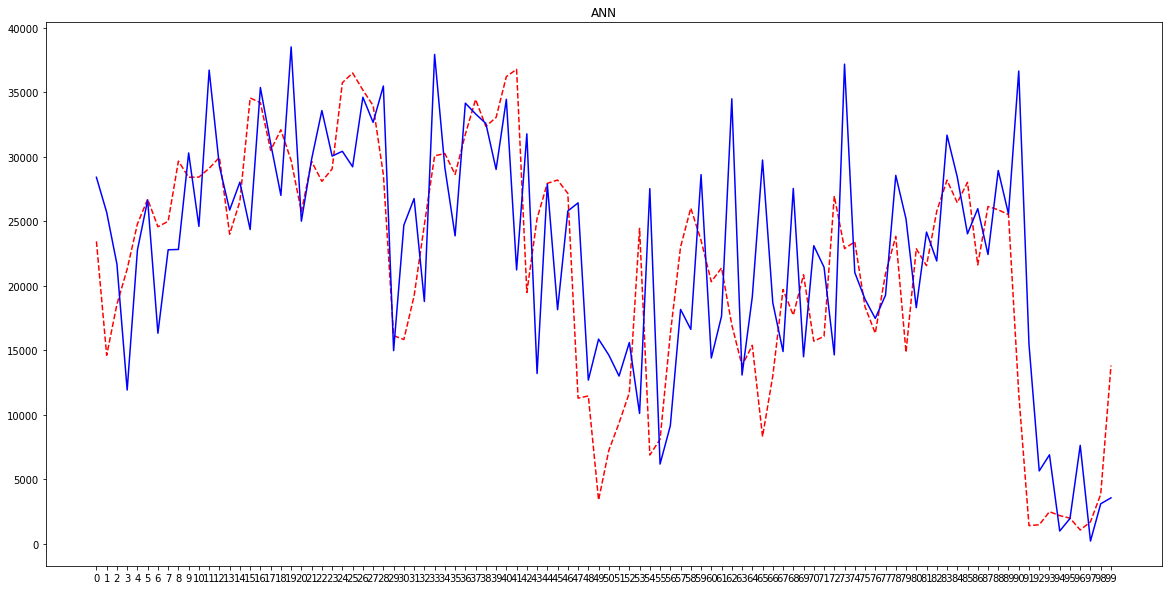

('\n Shape of  x : ', (1693, 168))
('\n Shape of  y : ', (1693, 24))
('Split done , the shapes : ', (1185, 168), (1185, 24), (508, 168), (508, 24))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=24, activation="softplus", kernel_initializer="normal", input_dim=168)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7, activation="softplus", kernel_initializer="normal", input_dim=24)`


Train on 1042 samples, validate on 143 samples
Epoch 1/750
1042/1042 [==============================] - 0s - loss: 1091727.6250 - mean_squared_error: 1091727.6250 - val_loss: 601101.8750 - val_mean_squared_error: 601101.8750
Epoch 2/750
1042/1042 [==============================] - 0s - loss: 1088222.1250 - mean_squared_error: 1088222.1250 - val_loss: 599459.3750 - val_mean_squared_error: 599459.3750
Epoch 3/750
1042/1042 [==============================] - 0s - loss: 1084541.0000 - mean_squared_error: 1084541.0000 - val_loss: 597628.3125 - val_mean_squared_error: 597628.3125
Epoch 4/750
1042/1042 [==============================] - 0s - loss: 1080548.2500 - mean_squared_error: 1080548.2500 - val_loss: 595546.1250 - val_mean_squared_error: 595546.1250
Epoch 5/750
1042/1042 [==============================] - 0s - loss: 1076132.7500 - mean_squared_error: 1076132.7500 - val_loss: 593190.3125 - val_mean_squared_error: 593190.3125
Epoch 6/750
1042/1042 [==============================] - 0s - l

1042/1042 [==============================] - 0s - loss: 502411.3438 - mean_squared_error: 502411.3438 - val_loss: 313546.5312 - val_mean_squared_error: 313546.5312
Epoch 47/750
1042/1042 [==============================] - 0s - loss: 496162.9062 - mean_squared_error: 496162.9062 - val_loss: 310440.6562 - val_mean_squared_error: 310440.6562
Epoch 48/750
1042/1042 [==============================] - 0s - loss: 490760.7812 - mean_squared_error: 490760.7812 - val_loss: 307832.7812 - val_mean_squared_error: 307832.7812
Epoch 49/750
1042/1042 [==============================] - 0s - loss: 486227.0000 - mean_squared_error: 486227.0000 - val_loss: 305690.6562 - val_mean_squared_error: 305690.6562
Epoch 50/750
1042/1042 [==============================] - 0s - loss: 482488.6250 - mean_squared_error: 482488.6250 - val_loss: 303945.7188 - val_mean_squared_error: 303945.7188
Epoch 51/750
1042/1042 [==============================] - 0s - loss: 479406.4062 - mean_squared_error: 479406.4062 - val_loss: 3

1042/1042 [==============================] - 0s - loss: 378422.2188 - mean_squared_error: 378422.2188 - val_loss: 259110.2656 - val_mean_squared_error: 259110.2656
Epoch 93/750
1042/1042 [==============================] - 0s - loss: 375822.7812 - mean_squared_error: 375822.7812 - val_loss: 258292.2188 - val_mean_squared_error: 258292.2188
Epoch 94/750
1042/1042 [==============================] - 0s - loss: 373267.3125 - mean_squared_error: 373267.3125 - val_loss: 257539.0469 - val_mean_squared_error: 257539.0469
Epoch 95/750
1042/1042 [==============================] - 0s - loss: 370759.7188 - mean_squared_error: 370759.7188 - val_loss: 256854.1875 - val_mean_squared_error: 256854.1875
Epoch 96/750
1042/1042 [==============================] - 0s - loss: 368292.5312 - mean_squared_error: 368292.5312 - val_loss: 256233.2031 - val_mean_squared_error: 256233.2031
Epoch 97/750
1042/1042 [==============================] - 0s - loss: 365879.1875 - mean_squared_error: 365879.1875 - val_loss: 2

1042/1042 [==============================] - 0s - loss: 310148.3125 - mean_squared_error: 310148.3125 - val_loss: 240781.3750 - val_mean_squared_error: 240781.3750
Epoch 139/750
1042/1042 [==============================] - 0s - loss: 309280.1250 - mean_squared_error: 309280.1250 - val_loss: 240582.0469 - val_mean_squared_error: 240582.0469
Epoch 140/750
1042/1042 [==============================] - 0s - loss: 308441.0312 - mean_squared_error: 308441.0312 - val_loss: 240394.6250 - val_mean_squared_error: 240394.6250
Epoch 141/750
1042/1042 [==============================] - 0s - loss: 307621.9375 - mean_squared_error: 307621.9375 - val_loss: 240223.6094 - val_mean_squared_error: 240223.6094
Epoch 142/750
1042/1042 [==============================] - 0s - loss: 306816.6250 - mean_squared_error: 306816.6250 - val_loss: 240061.0000 - val_mean_squared_error: 240061.0000
Epoch 143/750
1042/1042 [==============================] - 0s - loss: 306025.3125 - mean_squared_error: 306025.3125 - val_lo

1042/1042 [==============================] - 0s - loss: 286121.4062 - mean_squared_error: 286121.4062 - val_loss: 241733.2344 - val_mean_squared_error: 241733.2344
Epoch 185/750
1042/1042 [==============================] - 0s - loss: 285805.3750 - mean_squared_error: 285805.3750 - val_loss: 241770.4375 - val_mean_squared_error: 241770.4375
Epoch 186/750
1042/1042 [==============================] - 0s - loss: 285491.3750 - mean_squared_error: 285491.3750 - val_loss: 241804.3906 - val_mean_squared_error: 241804.3906
Epoch 187/750
1042/1042 [==============================] - 0s - loss: 285180.2812 - mean_squared_error: 285180.2812 - val_loss: 241836.7344 - val_mean_squared_error: 241836.7344
Epoch 188/750
1042/1042 [==============================] - 0s - loss: 284873.3750 - mean_squared_error: 284873.3750 - val_loss: 241873.0312 - val_mean_squared_error: 241873.0312
Epoch 189/750
1042/1042 [==============================] - 0s - loss: 284569.2500 - mean_squared_error: 284569.2500 - val_lo

1042/1042 [==============================] - 0s - loss: 273865.0312 - mean_squared_error: 273865.0312 - val_loss: 244233.0938 - val_mean_squared_error: 244233.0938
Epoch 231/750
1042/1042 [==============================] - 0s - loss: 273621.6250 - mean_squared_error: 273621.6250 - val_loss: 244268.5625 - val_mean_squared_error: 244268.5625
Epoch 232/750
1042/1042 [==============================] - 0s - loss: 273377.9375 - mean_squared_error: 273377.9375 - val_loss: 244302.7344 - val_mean_squared_error: 244302.7344
Epoch 233/750
1042/1042 [==============================] - 0s - loss: 273135.5312 - mean_squared_error: 273135.5312 - val_loss: 244335.3906 - val_mean_squared_error: 244335.3906
Epoch 234/750
1042/1042 [==============================] - 0s - loss: 272895.7812 - mean_squared_error: 272895.7812 - val_loss: 244368.4531 - val_mean_squared_error: 244368.4531
Epoch 235/750
1042/1042 [==============================] - 0s - loss: 272652.8750 - mean_squared_error: 272652.8750 - val_lo

1042/1042 [==============================] - 0s - loss: 262765.5625 - mean_squared_error: 262765.5625 - val_loss: 247313.3438 - val_mean_squared_error: 247313.3438
Epoch 277/750
1042/1042 [==============================] - 0s - loss: 262526.5625 - mean_squared_error: 262526.5625 - val_loss: 247412.2500 - val_mean_squared_error: 247412.2500
Epoch 278/750
1042/1042 [==============================] - 0s - loss: 262289.3125 - mean_squared_error: 262289.3125 - val_loss: 247491.3906 - val_mean_squared_error: 247491.3906
Epoch 279/750
1042/1042 [==============================] - 0s - loss: 262053.2812 - mean_squared_error: 262053.2812 - val_loss: 247584.4688 - val_mean_squared_error: 247584.4688
Epoch 280/750
1042/1042 [==============================] - 0s - loss: 261814.7500 - mean_squared_error: 261814.7500 - val_loss: 247686.4688 - val_mean_squared_error: 247686.4688
Epoch 281/750
1042/1042 [==============================] - 0s - loss: 261576.2344 - mean_squared_error: 261576.2344 - val_lo

1042/1042 [==============================] - 0s - loss: 252347.1875 - mean_squared_error: 252347.1875 - val_loss: 252156.2188 - val_mean_squared_error: 252156.2188
Epoch 323/750
1042/1042 [==============================] - 0s - loss: 252136.2656 - mean_squared_error: 252136.2656 - val_loss: 252329.2031 - val_mean_squared_error: 252329.2031
Epoch 324/750
1042/1042 [==============================] - 0s - loss: 251925.7812 - mean_squared_error: 251925.7812 - val_loss: 252397.9531 - val_mean_squared_error: 252397.9531
Epoch 325/750
1042/1042 [==============================] - 0s - loss: 251695.6719 - mean_squared_error: 251695.6719 - val_loss: 252557.1406 - val_mean_squared_error: 252557.1406
Epoch 326/750
1042/1042 [==============================] - 0s - loss: 251472.9531 - mean_squared_error: 251472.9531 - val_loss: 252622.3750 - val_mean_squared_error: 252622.3750
Epoch 327/750
1042/1042 [==============================] - 0s - loss: 251253.6094 - mean_squared_error: 251253.6094 - val_lo

1042/1042 [==============================] - 0s - loss: 242195.5000 - mean_squared_error: 242195.5000 - val_loss: 256713.5312 - val_mean_squared_error: 256713.5312
Epoch 369/750
1042/1042 [==============================] - 0s - loss: 242009.7500 - mean_squared_error: 242009.7500 - val_loss: 256510.2969 - val_mean_squared_error: 256510.2969
Epoch 370/750
1042/1042 [==============================] - 0s - loss: 241784.7969 - mean_squared_error: 241784.7969 - val_loss: 256846.1875 - val_mean_squared_error: 256846.1875
Epoch 371/750
1042/1042 [==============================] - 0s - loss: 241532.7969 - mean_squared_error: 241532.7969 - val_loss: 256700.4688 - val_mean_squared_error: 256700.4688
Epoch 372/750
1042/1042 [==============================] - 0s - loss: 241268.1406 - mean_squared_error: 241268.1406 - val_loss: 256790.7656 - val_mean_squared_error: 256790.7656
Epoch 373/750
1042/1042 [==============================] - 0s - loss: 241053.3281 - mean_squared_error: 241053.3281 - val_lo

1042/1042 [==============================] - 0s - loss: 231819.8125 - mean_squared_error: 231819.8125 - val_loss: 263502.3438 - val_mean_squared_error: 263502.3438
Epoch 415/750
1042/1042 [==============================] - 0s - loss: 231596.5938 - mean_squared_error: 231596.5938 - val_loss: 263557.8125 - val_mean_squared_error: 263557.8125
Epoch 416/750
1042/1042 [==============================] - 0s - loss: 231366.3594 - mean_squared_error: 231366.3594 - val_loss: 263903.3438 - val_mean_squared_error: 263903.3438
Epoch 417/750
1042/1042 [==============================] - 0s - loss: 231158.2031 - mean_squared_error: 231158.2031 - val_loss: 263907.6250 - val_mean_squared_error: 263907.6250
Epoch 418/750
1042/1042 [==============================] - 0s - loss: 230959.4531 - mean_squared_error: 230959.4531 - val_loss: 264690.6250 - val_mean_squared_error: 264690.6250
Epoch 419/750
1042/1042 [==============================] - 0s - loss: 230755.5781 - mean_squared_error: 230755.5781 - val_lo

1042/1042 [==============================] - 0s - loss: 221879.1875 - mean_squared_error: 221879.1875 - val_loss: 272471.0000 - val_mean_squared_error: 272471.0000
Epoch 461/750
1042/1042 [==============================] - 0s - loss: 221731.5156 - mean_squared_error: 221731.5156 - val_loss: 271416.1562 - val_mean_squared_error: 271416.1562
Epoch 462/750
1042/1042 [==============================] - 0s - loss: 221557.5156 - mean_squared_error: 221557.5156 - val_loss: 272129.1875 - val_mean_squared_error: 272129.1875
Epoch 463/750
1042/1042 [==============================] - 0s - loss: 221281.2812 - mean_squared_error: 221281.2812 - val_loss: 272064.5938 - val_mean_squared_error: 272064.5938
Epoch 464/750
1042/1042 [==============================] - 0s - loss: 221024.6719 - mean_squared_error: 221024.6719 - val_loss: 272289.0312 - val_mean_squared_error: 272289.0312
Epoch 465/750
1042/1042 [==============================] - 0s - loss: 220862.3750 - mean_squared_error: 220862.3750 - val_lo

1042/1042 [==============================] - 0s - loss: 213754.4375 - mean_squared_error: 213754.4375 - val_loss: 278992.0312 - val_mean_squared_error: 278992.0312
Epoch 507/750
1042/1042 [==============================] - 0s - loss: 213526.1406 - mean_squared_error: 213526.1406 - val_loss: 279536.0312 - val_mean_squared_error: 279536.0312
Epoch 508/750
1042/1042 [==============================] - 0s - loss: 213355.1094 - mean_squared_error: 213355.1094 - val_loss: 279896.6562 - val_mean_squared_error: 279896.6562
Epoch 509/750
1042/1042 [==============================] - 0s - loss: 213225.7500 - mean_squared_error: 213225.7500 - val_loss: 279192.0625 - val_mean_squared_error: 279192.0625
Epoch 510/750
1042/1042 [==============================] - 0s - loss: 213116.2031 - mean_squared_error: 213116.2031 - val_loss: 280203.7500 - val_mean_squared_error: 280203.7500
Epoch 511/750
1042/1042 [==============================] - 0s - loss: 212988.8750 - mean_squared_error: 212988.8750 - val_lo

1042/1042 [==============================] - 0s - loss: 207525.9688 - mean_squared_error: 207525.9688 - val_loss: 287301.2812 - val_mean_squared_error: 287301.2812
Epoch 553/750
1042/1042 [==============================] - 0s - loss: 207474.1094 - mean_squared_error: 207474.1094 - val_loss: 285340.6562 - val_mean_squared_error: 285340.6562
Epoch 554/750
1042/1042 [==============================] - 0s - loss: 207327.4531 - mean_squared_error: 207327.4531 - val_loss: 286570.6875 - val_mean_squared_error: 286570.6875
Epoch 555/750
1042/1042 [==============================] - 0s - loss: 206999.4531 - mean_squared_error: 206999.4531 - val_loss: 287014.5938 - val_mean_squared_error: 287014.5938
Epoch 556/750
1042/1042 [==============================] - 0s - loss: 206844.0000 - mean_squared_error: 206844.0000 - val_loss: 286428.4688 - val_mean_squared_error: 286428.4688
Epoch 557/750
1042/1042 [==============================] - 0s - loss: 206937.2656 - mean_squared_error: 206937.2656 - val_lo

1042/1042 [==============================] - 0s - loss: 202538.0938 - mean_squared_error: 202538.0938 - val_loss: 291648.7188 - val_mean_squared_error: 291648.7188
Epoch 599/750
1042/1042 [==============================] - 0s - loss: 202427.7812 - mean_squared_error: 202427.7812 - val_loss: 292305.2188 - val_mean_squared_error: 292305.2188
Epoch 600/750
1042/1042 [==============================] - 0s - loss: 202329.2031 - mean_squared_error: 202329.2031 - val_loss: 292031.3125 - val_mean_squared_error: 292031.3125
Epoch 601/750
1042/1042 [==============================] - 0s - loss: 202225.0000 - mean_squared_error: 202225.0000 - val_loss: 292290.3125 - val_mean_squared_error: 292290.3125
Epoch 602/750
1042/1042 [==============================] - 0s - loss: 202124.4219 - mean_squared_error: 202124.4219 - val_loss: 292317.3438 - val_mean_squared_error: 292317.3438
Epoch 603/750
1042/1042 [==============================] - 0s - loss: 202037.1562 - mean_squared_error: 202037.1562 - val_lo

1042/1042 [==============================] - 0s - loss: 198750.7812 - mean_squared_error: 198750.7812 - val_loss: 296805.2812 - val_mean_squared_error: 296805.2812
Epoch 645/750
1042/1042 [==============================] - 0s - loss: 198709.0469 - mean_squared_error: 198709.0469 - val_loss: 298188.9375 - val_mean_squared_error: 298188.9375
Epoch 646/750
1042/1042 [==============================] - 0s - loss: 198648.2031 - mean_squared_error: 198648.2031 - val_loss: 296689.4062 - val_mean_squared_error: 296689.4062
Epoch 647/750
1042/1042 [==============================] - 0s - loss: 198578.7500 - mean_squared_error: 198578.7500 - val_loss: 297947.4062 - val_mean_squared_error: 297947.4062
Epoch 648/750
1042/1042 [==============================] - 0s - loss: 198449.8906 - mean_squared_error: 198449.8906 - val_loss: 297601.0000 - val_mean_squared_error: 297601.0000
Epoch 649/750
1042/1042 [==============================] - 0s - loss: 198340.1094 - mean_squared_error: 198340.1094 - val_lo

1042/1042 [==============================] - 0s - loss: 195557.8906 - mean_squared_error: 195557.8906 - val_loss: 302489.1250 - val_mean_squared_error: 302489.1250
Epoch 691/750
1042/1042 [==============================] - 0s - loss: 195448.1406 - mean_squared_error: 195448.1406 - val_loss: 301290.5312 - val_mean_squared_error: 301290.5312
Epoch 692/750
1042/1042 [==============================] - 0s - loss: 195364.5469 - mean_squared_error: 195364.5469 - val_loss: 301998.0938 - val_mean_squared_error: 301998.0938
Epoch 693/750
1042/1042 [==============================] - 0s - loss: 195282.6562 - mean_squared_error: 195282.6562 - val_loss: 301642.5625 - val_mean_squared_error: 301642.5625
Epoch 694/750
1042/1042 [==============================] - 0s - loss: 195198.9531 - mean_squared_error: 195198.9531 - val_loss: 302423.8438 - val_mean_squared_error: 302423.8438
Epoch 695/750
1042/1042 [==============================] - 0s - loss: 195125.8750 - mean_squared_error: 195125.8750 - val_lo

1042/1042 [==============================] - 0s - loss: 192504.1875 - mean_squared_error: 192504.1875 - val_loss: 305428.3750 - val_mean_squared_error: 305428.3750
Epoch 737/750
1042/1042 [==============================] - 0s - loss: 192524.3594 - mean_squared_error: 192524.3594 - val_loss: 303226.4688 - val_mean_squared_error: 303226.4688
Epoch 738/750
1042/1042 [==============================] - 0s - loss: 192583.4688 - mean_squared_error: 192583.4688 - val_loss: 306062.0938 - val_mean_squared_error: 306062.0938
Epoch 739/750
1042/1042 [==============================] - 0s - loss: 192512.7500 - mean_squared_error: 192512.7500 - val_loss: 303638.0000 - val_mean_squared_error: 303638.0000
Epoch 740/750
1042/1042 [==============================] - 0s - loss: 192434.0469 - mean_squared_error: 192434.0469 - val_loss: 305854.7500 - val_mean_squared_error: 305854.7500
Epoch 741/750
1042/1042 [==============================] - 0s - loss: 192237.0469 - mean_squared_error: 192237.0469 - val_lo

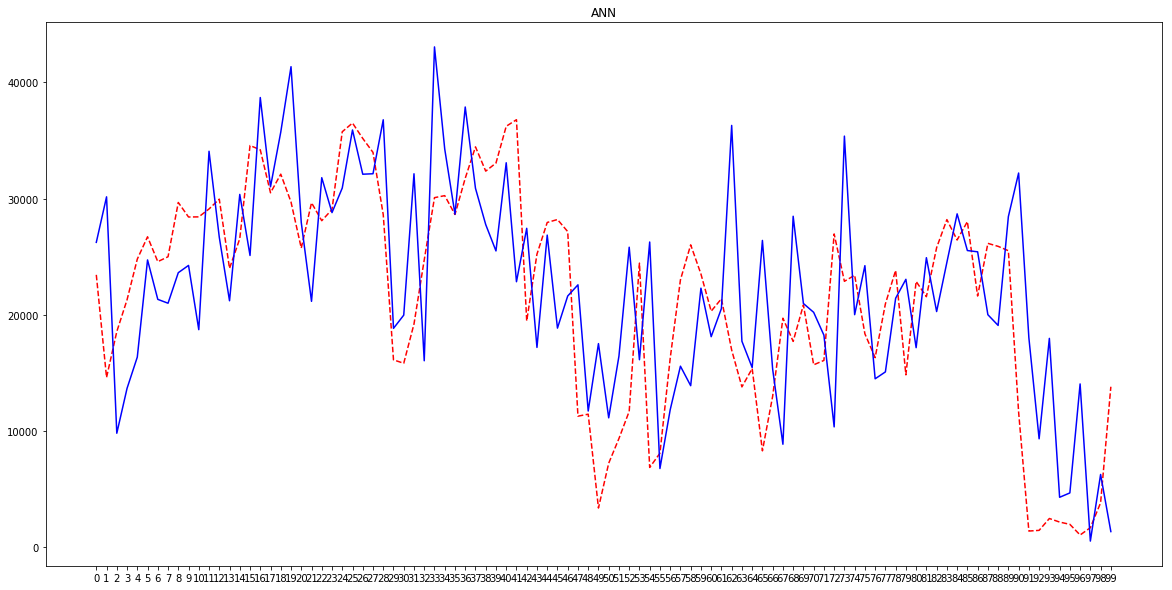

('\n Shape of  x : ', (1693, 168))
('\n Shape of  y : ', (1693, 24))
('Split done , the shapes : ', (1185, 168), (1185, 24), (508, 168), (508, 24))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=24, activation="linear", kernel_initializer="normal", input_dim=168)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7, activation="linear", kernel_initializer="normal", input_dim=24)`


Train on 1042 samples, validate on 143 samples
Epoch 1/750
1042/1042 [==============================] - 0s - loss: 1102771.3750 - mean_squared_error: 1102771.3750 - val_loss: 604729.6875 - val_mean_squared_error: 604729.6875
Epoch 2/750
1042/1042 [==============================] - 0s - loss: 1096554.3750 - mean_squared_error: 1096554.3750 - val_loss: 602062.3750 - val_mean_squared_error: 602062.3750
Epoch 3/750
1042/1042 [==============================] - 0s - loss: 1090941.0000 - mean_squared_error: 1090941.0000 - val_loss: 599451.3750 - val_mean_squared_error: 599451.3750
Epoch 4/750
1042/1042 [==============================] - 0s - loss: 1085418.0000 - mean_squared_error: 1085418.0000 - val_loss: 596687.4375 - val_mean_squared_error: 596687.4375
Epoch 5/750
1042/1042 [==============================] - 0s - loss: 1079565.2500 - mean_squared_error: 1079565.2500 - val_loss: 593610.5000 - val_mean_squared_error: 593610.5000
Epoch 6/750
1042/1042 [==============================] - 0s - l

1042/1042 [==============================] - 0s - loss: 480047.2500 - mean_squared_error: 480047.2500 - val_loss: 307592.8750 - val_mean_squared_error: 307592.8750
Epoch 47/750
1042/1042 [==============================] - 0s - loss: 475820.0000 - mean_squared_error: 475820.0000 - val_loss: 305509.9375 - val_mean_squared_error: 305509.9375
Epoch 48/750
1042/1042 [==============================] - 0s - loss: 471562.4375 - mean_squared_error: 471562.4375 - val_loss: 303390.6562 - val_mean_squared_error: 303390.6562
Epoch 49/750
1042/1042 [==============================] - 0s - loss: 467330.9375 - mean_squared_error: 467330.9375 - val_loss: 301279.6562 - val_mean_squared_error: 301279.6562
Epoch 50/750
1042/1042 [==============================] - 0s - loss: 463219.6875 - mean_squared_error: 463219.6875 - val_loss: 299230.3750 - val_mean_squared_error: 299230.3750
Epoch 51/750
1042/1042 [==============================] - 0s - loss: 459334.5000 - mean_squared_error: 459334.5000 - val_loss: 2

1042/1042 [==============================] - 0s - loss: 352914.5312 - mean_squared_error: 352914.5312 - val_loss: 251970.9062 - val_mean_squared_error: 251970.9062
Epoch 93/750
1042/1042 [==============================] - 0s - loss: 350910.0312 - mean_squared_error: 350910.0312 - val_loss: 251392.5000 - val_mean_squared_error: 251392.5000
Epoch 94/750
1042/1042 [==============================] - 0s - loss: 349045.0000 - mean_squared_error: 349045.0000 - val_loss: 250852.4219 - val_mean_squared_error: 250852.4219
Epoch 95/750
1042/1042 [==============================] - 0s - loss: 347313.2188 - mean_squared_error: 347313.2188 - val_loss: 250344.3281 - val_mean_squared_error: 250344.3281
Epoch 96/750
1042/1042 [==============================] - 0s - loss: 345705.8438 - mean_squared_error: 345705.8438 - val_loss: 249861.2656 - val_mean_squared_error: 249861.2656
Epoch 97/750
1042/1042 [==============================] - 0s - loss: 344211.4062 - mean_squared_error: 344211.4062 - val_loss: 2

1042/1042 [==============================] - 0s - loss: 310573.8125 - mean_squared_error: 310573.8125 - val_loss: 236690.2031 - val_mean_squared_error: 236690.2031
Epoch 139/750
1042/1042 [==============================] - 0s - loss: 310146.7812 - mean_squared_error: 310146.7812 - val_loss: 236682.4688 - val_mean_squared_error: 236682.4688
Epoch 140/750
1042/1042 [==============================] - 0s - loss: 309730.8750 - mean_squared_error: 309730.8750 - val_loss: 236677.3438 - val_mean_squared_error: 236677.3438
Epoch 141/750
1042/1042 [==============================] - 0s - loss: 309325.6562 - mean_squared_error: 309325.6562 - val_loss: 236674.3438 - val_mean_squared_error: 236674.3438
Epoch 142/750
1042/1042 [==============================] - 0s - loss: 308930.6562 - mean_squared_error: 308930.6562 - val_loss: 236673.2656 - val_mean_squared_error: 236673.2656
Epoch 143/750
1042/1042 [==============================] - 0s - loss: 308545.3438 - mean_squared_error: 308545.3438 - val_lo

1042/1042 [==============================] - 0s - loss: 297568.1562 - mean_squared_error: 297568.1562 - val_loss: 236503.0781 - val_mean_squared_error: 236503.0781
Epoch 185/750
1042/1042 [==============================] - 0s - loss: 297373.7812 - mean_squared_error: 297373.7812 - val_loss: 236495.6094 - val_mean_squared_error: 236495.6094
Epoch 186/750
1042/1042 [==============================] - 0s - loss: 297181.6250 - mean_squared_error: 297181.6250 - val_loss: 236488.2031 - val_mean_squared_error: 236488.2031
Epoch 187/750
1042/1042 [==============================] - 0s - loss: 296991.5000 - mean_squared_error: 296991.5000 - val_loss: 236480.8906 - val_mean_squared_error: 236480.8906
Epoch 188/750
1042/1042 [==============================] - 0s - loss: 296803.4688 - mean_squared_error: 296803.4688 - val_loss: 236473.8125 - val_mean_squared_error: 236473.8125
Epoch 189/750
1042/1042 [==============================] - 0s - loss: 296617.5625 - mean_squared_error: 296617.5625 - val_lo

1042/1042 [==============================] - 0s - loss: 290270.0625 - mean_squared_error: 290270.0625 - val_loss: 236862.7656 - val_mean_squared_error: 236862.7656
Epoch 231/750
1042/1042 [==============================] - 0s - loss: 290138.8750 - mean_squared_error: 290138.8750 - val_loss: 236885.5625 - val_mean_squared_error: 236885.5625
Epoch 232/750
1042/1042 [==============================] - 0s - loss: 290008.7188 - mean_squared_error: 290008.7188 - val_loss: 236908.7344 - val_mean_squared_error: 236908.7344
Epoch 233/750
1042/1042 [==============================] - 0s - loss: 289879.1875 - mean_squared_error: 289879.1875 - val_loss: 236932.2500 - val_mean_squared_error: 236932.2500
Epoch 234/750
1042/1042 [==============================] - 0s - loss: 289750.6875 - mean_squared_error: 289750.6875 - val_loss: 236956.0312 - val_mean_squared_error: 236956.0312
Epoch 235/750
1042/1042 [==============================] - 0s - loss: 289623.0938 - mean_squared_error: 289623.0938 - val_lo

1042/1042 [==============================] - 0s - loss: 285026.9688 - mean_squared_error: 285026.9688 - val_loss: 238234.2344 - val_mean_squared_error: 238234.2344
Epoch 277/750
1042/1042 [==============================] - 0s - loss: 284928.3750 - mean_squared_error: 284928.3750 - val_loss: 238271.1875 - val_mean_squared_error: 238271.1875
Epoch 278/750
1042/1042 [==============================] - 0s - loss: 284830.4062 - mean_squared_error: 284830.4062 - val_loss: 238308.4688 - val_mean_squared_error: 238308.4688
Epoch 279/750
1042/1042 [==============================] - 0s - loss: 284732.9688 - mean_squared_error: 284732.9688 - val_loss: 238346.0938 - val_mean_squared_error: 238346.0938
Epoch 280/750
1042/1042 [==============================] - 0s - loss: 284636.1250 - mean_squared_error: 284636.1250 - val_loss: 238384.1094 - val_mean_squared_error: 238384.1094
Epoch 281/750
1042/1042 [==============================] - 0s - loss: 284539.6875 - mean_squared_error: 284539.6875 - val_lo

1042/1042 [==============================] - 0s - loss: 281010.5625 - mean_squared_error: 281010.5625 - val_loss: 240252.3594 - val_mean_squared_error: 240252.3594
Epoch 323/750
1042/1042 [==============================] - 0s - loss: 280933.5312 - mean_squared_error: 280933.5312 - val_loss: 240302.7656 - val_mean_squared_error: 240302.7656
Epoch 324/750
1042/1042 [==============================] - 0s - loss: 280856.8438 - mean_squared_error: 280856.8438 - val_loss: 240353.3438 - val_mean_squared_error: 240353.3438
Epoch 325/750
1042/1042 [==============================] - 0s - loss: 280780.5312 - mean_squared_error: 280780.5312 - val_loss: 240404.1719 - val_mean_squared_error: 240404.1719
Epoch 326/750
1042/1042 [==============================] - 0s - loss: 280704.5938 - mean_squared_error: 280704.5938 - val_loss: 240455.2656 - val_mean_squared_error: 240455.2656
Epoch 327/750
1042/1042 [==============================] - 0s - loss: 280629.0000 - mean_squared_error: 280629.0000 - val_lo

1042/1042 [==============================] - 0s - loss: 277800.9688 - mean_squared_error: 277800.9688 - val_loss: 242783.1875 - val_mean_squared_error: 242783.1875
Epoch 369/750
1042/1042 [==============================] - 0s - loss: 277737.6250 - mean_squared_error: 277737.6250 - val_loss: 242842.3281 - val_mean_squared_error: 242842.3281
Epoch 370/750
1042/1042 [==============================] - 0s - loss: 277674.4688 - mean_squared_error: 277674.4688 - val_loss: 242901.5938 - val_mean_squared_error: 242901.5938
Epoch 371/750
1042/1042 [==============================] - 0s - loss: 277611.6250 - mean_squared_error: 277611.6250 - val_loss: 242961.0312 - val_mean_squared_error: 242961.0312
Epoch 372/750
1042/1042 [==============================] - 0s - loss: 277548.9688 - mean_squared_error: 277548.9688 - val_loss: 243020.5938 - val_mean_squared_error: 243020.5938
Epoch 373/750
1042/1042 [==============================] - 0s - loss: 277486.5625 - mean_squared_error: 277486.5625 - val_lo

1042/1042 [==============================] - 0s - loss: 275085.5000 - mean_squared_error: 275085.5000 - val_loss: 245624.8594 - val_mean_squared_error: 245624.8594
Epoch 415/750
1042/1042 [==============================] - 0s - loss: 275030.0625 - mean_squared_error: 275030.0625 - val_loss: 245688.9219 - val_mean_squared_error: 245688.9219
Epoch 416/750
1042/1042 [==============================] - 0s - loss: 274974.7500 - mean_squared_error: 274974.7500 - val_loss: 245753.0625 - val_mean_squared_error: 245753.0625
Epoch 417/750
1042/1042 [==============================] - 0s - loss: 274919.5000 - mean_squared_error: 274919.5000 - val_loss: 245817.3438 - val_mean_squared_error: 245817.3438
Epoch 418/750
1042/1042 [==============================] - 0s - loss: 274864.3438 - mean_squared_error: 274864.3438 - val_loss: 245881.6719 - val_mean_squared_error: 245881.6719
Epoch 419/750
1042/1042 [==============================] - 0s - loss: 274809.3750 - mean_squared_error: 274809.3750 - val_lo

1042/1042 [==============================] - 0s - loss: 272624.2500 - mean_squared_error: 272624.2500 - val_loss: 248641.9531 - val_mean_squared_error: 248641.9531
Epoch 461/750
1042/1042 [==============================] - 0s - loss: 272572.1250 - mean_squared_error: 272572.1250 - val_loss: 248708.8125 - val_mean_squared_error: 248708.8125
Epoch 462/750
1042/1042 [==============================] - 0s - loss: 272520.0625 - mean_squared_error: 272520.0625 - val_loss: 248775.7500 - val_mean_squared_error: 248775.7500
Epoch 463/750
1042/1042 [==============================] - 0s - loss: 272468.0312 - mean_squared_error: 272468.0312 - val_loss: 248842.7188 - val_mean_squared_error: 248842.7188
Epoch 464/750
1042/1042 [==============================] - 0s - loss: 272416.0938 - mean_squared_error: 272416.0938 - val_loss: 248909.7344 - val_mean_squared_error: 248909.7344
Epoch 465/750
1042/1042 [==============================] - 0s - loss: 272364.1250 - mean_squared_error: 272364.1250 - val_lo

1042/1042 [==============================] - 0s - loss: 270256.9375 - mean_squared_error: 270256.9375 - val_loss: 251750.9062 - val_mean_squared_error: 251750.9062
Epoch 507/750
1042/1042 [==============================] - 0s - loss: 270206.1250 - mean_squared_error: 270206.1250 - val_loss: 251818.9375 - val_mean_squared_error: 251818.9375
Epoch 508/750
1042/1042 [==============================] - 0s - loss: 270155.2188 - mean_squared_error: 270155.2188 - val_loss: 251886.9688 - val_mean_squared_error: 251886.9688
Epoch 509/750
1042/1042 [==============================] - 0s - loss: 270104.5625 - mean_squared_error: 270104.5625 - val_loss: 251954.9375 - val_mean_squared_error: 251954.9375
Epoch 510/750
1042/1042 [==============================] - 0s - loss: 270053.7500 - mean_squared_error: 270053.7500 - val_loss: 252022.8750 - val_mean_squared_error: 252022.8750
Epoch 511/750
1042/1042 [==============================] - 0s - loss: 270003.0938 - mean_squared_error: 270003.0938 - val_lo

1042/1042 [==============================] - 0s - loss: 267971.7812 - mean_squared_error: 267971.7812 - val_loss: 254869.8438 - val_mean_squared_error: 254869.8438
Epoch 553/750
1042/1042 [==============================] - 0s - loss: 267923.7812 - mean_squared_error: 267923.7812 - val_loss: 254937.1719 - val_mean_squared_error: 254937.1719
Epoch 554/750
1042/1042 [==============================] - 0s - loss: 267875.8750 - mean_squared_error: 267875.8750 - val_loss: 255004.4219 - val_mean_squared_error: 255004.4219
Epoch 555/750
1042/1042 [==============================] - 0s - loss: 267828.1250 - mean_squared_error: 267828.1250 - val_loss: 255071.7188 - val_mean_squared_error: 255071.7188
Epoch 556/750
1042/1042 [==============================] - 0s - loss: 267780.4375 - mean_squared_error: 267780.4375 - val_loss: 255138.8750 - val_mean_squared_error: 255138.8750
Epoch 557/750
1042/1042 [==============================] - 0s - loss: 267732.9375 - mean_squared_error: 267732.9375 - val_lo

1042/1042 [==============================] - 0s - loss: 265888.0312 - mean_squared_error: 265888.0312 - val_loss: 257914.1250 - val_mean_squared_error: 257914.1250
Epoch 599/750
1042/1042 [==============================] - 0s - loss: 265845.7812 - mean_squared_error: 265845.7812 - val_loss: 257978.8281 - val_mean_squared_error: 257978.8281
Epoch 600/750
1042/1042 [==============================] - 0s - loss: 265803.6875 - mean_squared_error: 265803.6875 - val_loss: 258043.3906 - val_mean_squared_error: 258043.3906
Epoch 601/750
1042/1042 [==============================] - 0s - loss: 265761.7500 - mean_squared_error: 265761.7500 - val_loss: 258107.9219 - val_mean_squared_error: 258107.9219
Epoch 602/750
1042/1042 [==============================] - 0s - loss: 265720.0000 - mean_squared_error: 265720.0000 - val_loss: 258172.3594 - val_mean_squared_error: 258172.3594
Epoch 603/750
1042/1042 [==============================] - 0s - loss: 265678.3125 - mean_squared_error: 265678.3125 - val_lo

1042/1042 [==============================] - 0s - loss: 264083.2188 - mean_squared_error: 264083.2188 - val_loss: 260808.5625 - val_mean_squared_error: 260808.5625
Epoch 645/750
1042/1042 [==============================] - 0s - loss: 264046.7500 - mean_squared_error: 264046.7500 - val_loss: 260869.5312 - val_mean_squared_error: 260869.5312
Epoch 646/750
1042/1042 [==============================] - 0s - loss: 264010.5000 - mean_squared_error: 264010.5000 - val_loss: 260930.4062 - val_mean_squared_error: 260930.4062
Epoch 647/750
1042/1042 [==============================] - 0s - loss: 263974.2188 - mean_squared_error: 263974.2188 - val_loss: 260991.2188 - val_mean_squared_error: 260991.2188
Epoch 648/750
1042/1042 [==============================] - 0s - loss: 263938.1562 - mean_squared_error: 263938.1562 - val_loss: 261051.9219 - val_mean_squared_error: 261051.9219
Epoch 649/750
1042/1042 [==============================] - 0s - loss: 263902.1250 - mean_squared_error: 263902.1250 - val_lo

1042/1042 [==============================] - 0s - loss: 262499.1562 - mean_squared_error: 262499.1562 - val_loss: 263525.8750 - val_mean_squared_error: 263525.8750
Epoch 691/750
1042/1042 [==============================] - 0s - loss: 262466.4688 - mean_squared_error: 262466.4688 - val_loss: 263583.0000 - val_mean_squared_error: 263583.0000
Epoch 692/750
1042/1042 [==============================] - 0s - loss: 262433.7500 - mean_squared_error: 262433.7500 - val_loss: 263640.0000 - val_mean_squared_error: 263640.0000
Epoch 693/750
1042/1042 [==============================] - 0s - loss: 262401.0000 - mean_squared_error: 262401.0000 - val_loss: 263696.9375 - val_mean_squared_error: 263696.9375
Epoch 694/750
1042/1042 [==============================] - 0s - loss: 262368.4375 - mean_squared_error: 262368.4375 - val_loss: 263753.7812 - val_mean_squared_error: 263753.7812
Epoch 695/750
1042/1042 [==============================] - 0s - loss: 262335.8750 - mean_squared_error: 262335.8750 - val_lo

1042/1042 [==============================] - 0s - loss: 261037.8125 - mean_squared_error: 261037.8125 - val_loss: 266073.3125 - val_mean_squared_error: 266073.3125
Epoch 737/750
1042/1042 [==============================] - 0s - loss: 261006.8906 - mean_squared_error: 261006.8906 - val_loss: 266127.0000 - val_mean_squared_error: 266127.0000
Epoch 738/750
1042/1042 [==============================] - 0s - loss: 260975.9375 - mean_squared_error: 260975.9375 - val_loss: 266180.5312 - val_mean_squared_error: 266180.5312
Epoch 739/750
1042/1042 [==============================] - 0s - loss: 260945.0469 - mean_squared_error: 260945.0469 - val_loss: 266234.0000 - val_mean_squared_error: 266234.0000
Epoch 740/750
1042/1042 [==============================] - 0s - loss: 260914.2188 - mean_squared_error: 260914.2188 - val_loss: 266287.5312 - val_mean_squared_error: 266287.5312
Epoch 741/750
1042/1042 [==============================] - 0s - loss: 260883.3125 - mean_squared_error: 260883.3125 - val_lo

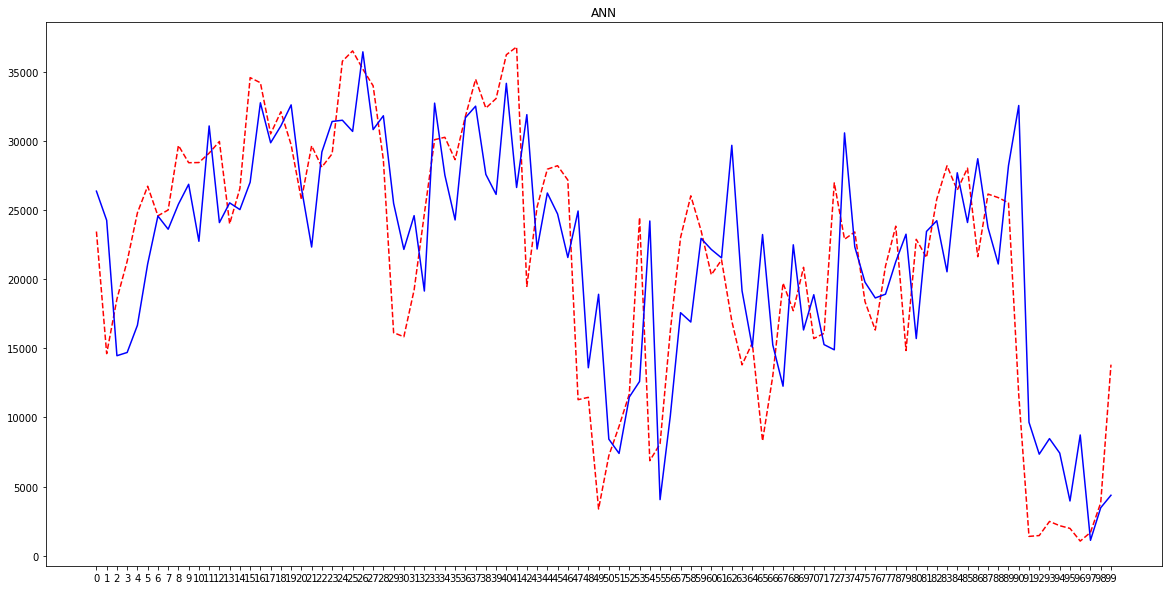

(' Total Time Taken : ', 65.02570581436157)


In [58]:
master_dict= {}
ti = time.time()
activations = ["relu","elu","selu","softplus","linear"]
for i in activations:
    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model_24(x,y,thermal_dict1,1,"mean_squared_error",1,0,i)
    master_dict[i] = thermal_dict1
tf = time.time()
#print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
#print("\ny_pred",y_pred1,"\ny_test",y_test1)
print (" Total Time Taken : ",tf-ti)

In [59]:
print ("Master Dict : \n")
for key,val in master_dict.iteritems():
    print (key," - ",val,"\n\n")

Master Dict : 

('softplus', ' - ', {'0 - before summation': [[2510.1732644383746]]}, '\n\n')
('selu', ' - ', {'0 - before summation': [[2440.1053553865504]]}, '\n\n')
('linear', ' - ', {'0 - before summation': [[2267.0273393026341]]}, '\n\n')
('relu', ' - ', {'0 - before summation': [[2464.5240122436558]]}, '\n\n')
('elu', ' - ', {'0 - before summation': [[2569.5459149959552]]}, '\n\n')


In [30]:
y_test1[0],y_pred1[0]

(0        10.100000
 1       666.433333
 2        10.000000
 3        10.000000
 4        10.033333
 5        10.550000
 6        10.000000
 7        77.333333
 8        10.000000
 9       106.233333
 10      109.633333
 11       10.000000
 12      449.333333
 13       10.000000
 14      105.916667
 15       10.000000
 16      105.416667
 17       43.583333
 18      100.033333
 19       10.000000
 20       10.150000
 21       10.000000
 22       10.000000
 23      270.400000
 24     1090.800000
 25       93.833333
 26       96.766667
 27       98.716667
 28      102.350000
 29       10.000000
           ...     
 478      10.050000
 479      10.000000
 480      10.000000
 481     339.033333
 482     155.000000
 483      10.050000
 484      10.083333
 485      11.066667
 486     421.816667
 487      10.333333
 488      40.883333
 489     484.683333
 490     419.283333
 491      10.000000
 492      10.000000
 493      10.000000
 494      10.000000
 495      10.000000
 496      10.150000


In [42]:
di={}
for i in range(y_test1.shape[0]):
  di[i] = abs(np.sum(y_pred1[i])-np.sum(y_test1[i]))
for key,val in di.iteritems():
    print (key," - ",val,"\n")

(0, ' - ', 2816.01953125, '\n')
(1, ' - ', 9803.2575520833343, '\n')
(2, ' - ', 4208.4744791666635, '\n')
(3, ' - ', 6643.1059895833314, '\n')
(4, ' - ', 8433.6493489583336, '\n')
(5, ' - ', 5587.7490885416628, '\n')
(6, ' - ', 30.571093750004366, '\n')
(7, ' - ', 1310.2522135416657, '\n')
(8, ' - ', 4367.9927083333314, '\n')
(9, ' - ', 1465.0041666666621, '\n')
(10, ' - ', 5897.4716145833299, '\n')
(11, ' - ', 1897.0359375000044, '\n')
(12, ' - ', 5840.5632812499971, '\n')
(13, ' - ', 1416.8505208333372, '\n')
(14, ' - ', 1493.3307291666642, '\n')
(15, ' - ', 7452.4598958333227, '\n')
(16, ' - ', 1732.2127604166599, '\n')
(17, ' - ', 634.34557291666351, '\n')
(18, ' - ', 913.89596354166497, '\n')
(19, ' - ', 2751.7459635416672, '\n')
(20, ' - ', 907.52968750000582, '\n')
(21, ' - ', 7364.0356770833314, '\n')
(22, ' - ', 1003.7019531249971, '\n')
(23, ' - ', 2279.1990885416672, '\n')
(24, ' - ', 4086.4966145833314, '\n')
(25, ' - ', 5958.2937499999971, '\n')
(26, ' - ', 1264.8062500000

In [44]:
np.mean(di.values())

4791.7739564213061

In [32]:
data = pd.read_pickle('../DataSets/New_Pecan_Street/load_data_1632.pkl')
for i in data.columns:
    if data[i].isnull().sum() >= data.values.shape[0]-10000 : del data[i]
data.columns        

Index([u'dataid', u'localhour', u'use', u'air1', u'air2', u'air3',
       u'bathroom1', u'clotheswasher1', u'dishwasher1', u'disposal1', u'dryg1',
       u'furnace1', u'furnace2', u'garage1', u'garage2', u'grid',
       u'kitchenapp1', u'kitchenapp2', u'lights_plugs1', u'lights_plugs2',
       u'microwave1', u'outsidelights_plugs1', u'outsidelights_plugs2',
       u'refrigerator1', u'waterheater1'],
      dtype='object')

In [33]:
data = pd.DataFrame(data.values[175:],columns=data.columns)
d_localhour = data[["localhour"]]
data = data.mul(1000)
data.head()

dataid                                          localhour      use air1  \
0  1632000  2013-03-23 08:00:00-052013-03-23 08:00:00-0520...  466.633    0   
1  1632000  2013-03-23 09:00:00-052013-03-23 09:00:00-0520...  503.983    0   
2  1632000  2013-03-23 10:00:00-052013-03-23 10:00:00-0520...  561.033    0   
3  1632000  2013-03-23 11:00:00-052013-03-23 11:00:00-0520...  1683.28    0   
4  1632000  2013-03-23 12:00:00-052013-03-23 12:00:00-0520...   366.05    0   

  air2 air3 bathroom1 clotheswasher1 dishwasher1 disposal1     ...       \
0    0    0         0              0         4.2         0     ...        
1    0    0         0              0     4.11667         0     ...        
2    0    0         0              0     4.06667         0     ...        
3    0    0         0              0         3.7         0     ...        
4    0    0         0              0     4.33333         0     ...        

      grid kitchenapp1 kitchenapp2 lights_plugs1 lights_plugs2 microwave1  \
0  466.633       17.35         1.5            11             0    20.7167   
1  503.983     5.31667        1.35         10.85             0          8   
2  561.033    0.316667        1.45       9.26667             0          8   
3  1683.28           0        1.95           7.6             0          8   
4   366.05           0         0.9             0             0          8   

  outsidelights_plugs1 outsidelights_plugs2 refrigerator1 waterheater1  
0                    0              95.8833           NaN            0  
1                    0              95.4167           NaN            0  
2                    0              94.7167           NaN      181.567  
3                    0                93.05           NaN      1324.77  
4                    0                   95           NaN            0  

[5 rows x 25 columns]

In [35]:
d_localhour.head()

localhour
0  2013-03-23 08:00:00-05
1  2013-03-23 09:00:00-05
2  2013-03-23 10:00:00-05
3  2013-03-23 11:00:00-05
4  2013-03-23 12:00:00-05

In [36]:
data['air1'][34492] = (data['air1'][34492-168] + data['air1'][34492+168])/2
data['air2'][34492] = (data['air2'][34492-168] + data['air2'][34492+168])/2
data['grid'][34492] = (data['grid'][34492-168] + data['grid'][34492+168])/2
data['outsidelights_plugs1'][34492] = (data['outsidelights_plugs1'][34492-168] + data['outsidelights_plugs1'][34492+168])/2
data['outsidelights_plugs2'][34492] = (data['outsidelights_plugs2'][34492-168] + data['outsidelights_plugs2'][34492+168])/2
data['refrigerator1'][34492] = 0.0
x = data.values[34492][2:]
data['use'][34492] = sum(x[1:])

In [37]:
data.isnull().sum()

dataid                     0
localhour                  0
use                        0
air1                       0
air2                       0
air3                       0
bathroom1                  0
clotheswasher1             0
dishwasher1                0
disposal1                  0
dryg1                      0
furnace1                   0
furnace2                   0
garage1                    0
garage2                    0
grid                       0
kitchenapp1                0
kitchenapp2                0
lights_plugs1              0
lights_plugs2              0
microwave1                 0
outsidelights_plugs1       0
outsidelights_plugs2       0
refrigerator1           7767
waterheater1               0
dtype: int64

In [38]:
df_thermal = data[['air1','air2','air3','furnace1','furnace2','waterheater1']].copy()
df_thermal['tot'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']
df_tot_ther = df_thermal[['tot']]

In [39]:
df_thermal = pd.concat([d_localhour,df_thermal],axis=1)

In [40]:
df_tot_ther.iloc[23]

tot    527.717
Name: 23, dtype: object

In [41]:
df_thermal.values.tolist()[0]

['2013-03-23 08:00:00-05',
 0.0,
 0.0,
 0.0,
 5.8999999999999995,
 10.0,
 0.0,
 15.899999999999999]

In [42]:
df_thermal.head()

localhour air1 air2 air3 furnace1 furnace2 waterheater1  \
0  2013-03-23 08:00:00-05    0    0    0      5.9       10            0   
1  2013-03-23 09:00:00-05    0    0    0  4.91667       10            0   
2  2013-03-23 10:00:00-05    0    0    0      5.9  76.2833      181.567   
3  2013-03-23 11:00:00-05    0    0    0      5.9  76.0333      1324.77   
4  2013-03-23 12:00:00-05    0    0    0        6       10            0   

       tot  
0     15.9  
1  14.9167  
2   263.75  
3   1406.7  
4       16

In [43]:
# changing the shape of the given data from every row being an hour to every row being a day
# that is, every row will now have all hours thermal load data as columns (0,1..23) in x and that day's total load in y
# shapes being x = (1700,24), y = (1700,1)
nhrs = int(df_tot_ther.values.shape[0]/24)
y = np.ndarray(shape=(nhrs,24))
x = np.ndarray(shape=(nhrs,24))
val = []
for i in range(nhrs):
    #val = df_tot_ther.values[i:i+24]
    #Take only the loads correspondin to one whole day, starting from the hour the datframe starts from.
    val = df_tot_ther.values[24*i:24*(i+1)]
    y[i] = val.T
    x[i]=val.T

In [44]:
x.shape

(1700, 24)

In [45]:
y = pd.DataFrame(y)
#y.columns = ['day_load']
x = pd.DataFrame(x)
x.head()

0            1           2            3            4           5   \
0    15.900000    14.916667  263.750000  1406.700000    16.000000   16.000000   
1   117.400000   156.633333  137.250000   140.283333   140.933333   82.050000   
2  2774.533333  1729.233333  255.883333   201.416667  1507.666667  628.933333   
3  1262.616667   813.333333  197.766667   197.933333   142.300000  121.116667   
4  1756.783333  1096.033333  725.583333   103.433333   132.400000  224.083333   

           6          7           8          9      ...               14  \
0   16.000000  16.000000   16.000000  16.000000     ...        16.000000   
1   82.250000  82.650000  456.900000  24.216667     ...       103.583333   
2  133.950000  80.433333   82.066667  16.000000     ...        76.866667   
3   42.283333  81.766667   16.000000  16.000000     ...        14.250000   
4  269.050000  16.000000   16.000000  16.000000     ...        16.000000   

           15          16          17          18           19           20  \
0   16.000000   16.000000  388.183333   16.000000    16.000000    16.000000   
1  122.033333  411.650000  299.483333  212.633333   217.950000   987.600000   
2  517.966667  139.616667  205.716667  948.483333  1410.433333  1688.850000   
3  388.066667   83.183333   82.483333  148.000000   533.000000  1444.283333   
4   16.000000  372.716667   16.000000   82.816667    82.383333    82.016667   

            21           22           23  
0    16.000000    15.916667   527.716667  
1  1450.366667  1942.883333  1048.266667  
2  2815.016667  2872.500000  1612.600000  
3   903.750000  1421.333333  1488.850000  
4   462.800000  1786.866667  1447.783333  

[5 rows x 24 columns]

In [46]:
y.head()

0            1           2            3            4           5   \
0    15.900000    14.916667  263.750000  1406.700000    16.000000   16.000000   
1   117.400000   156.633333  137.250000   140.283333   140.933333   82.050000   
2  2774.533333  1729.233333  255.883333   201.416667  1507.666667  628.933333   
3  1262.616667   813.333333  197.766667   197.933333   142.300000  121.116667   
4  1756.783333  1096.033333  725.583333   103.433333   132.400000  224.083333   

           6          7           8          9      ...               14  \
0   16.000000  16.000000   16.000000  16.000000     ...        16.000000   
1   82.250000  82.650000  456.900000  24.216667     ...       103.583333   
2  133.950000  80.433333   82.066667  16.000000     ...        76.866667   
3   42.283333  81.766667   16.000000  16.000000     ...        14.250000   
4  269.050000  16.000000   16.000000  16.000000     ...        16.000000   

           15          16          17          18           19           20  \
0   16.000000   16.000000  388.183333   16.000000    16.000000    16.000000   
1  122.033333  411.650000  299.483333  212.633333   217.950000   987.600000   
2  517.966667  139.616667  205.716667  948.483333  1410.433333  1688.850000   
3  388.066667   83.183333   82.483333  148.000000   533.000000  1444.283333   
4   16.000000  372.716667   16.000000   82.816667    82.383333    82.016667   

            21           22           23  
0    16.000000    15.916667   527.716667  
1  1450.366667  1942.883333  1048.266667  
2  2815.016667  2872.500000  1612.600000  
3   903.750000  1421.333333  1488.850000  
4   462.800000  1786.866667  1447.783333  

[5 rows x 24 columns]

In [47]:
# creating the desired shape for the ANN model - 168 columns for hour-wise data of 7 days as input
#  and next day total load as output
temp = x.values.tolist()
x = np.ndarray(shape=(nhrs,168))
for i in range(7,len(temp),1):
    dlist = []
    for j in range(1,8):
        dlist = dlist + temp[i-j]
    x[i] = dlist
x = pd.DataFrame(x)
x.tail(10)

0            1            2          3          4           5    \
1690   10.000000  1073.983333  1082.900000  10.066667  10.233333   10.000000   
1691   10.333333   431.200000    10.000000   9.983333  10.166667   10.000000   
1692   12.283333   426.100000    10.000000  10.000000  10.000000   10.000000   
1693  199.650000   497.266667    66.883333  10.550000  40.566667   10.633333   
1694  109.233333    13.400000    40.766667  40.883333  40.700000   10.000000   
1695   10.000000    10.000000    10.000000  10.000000  10.000000  380.116667   
1696   10.000000    10.000000    10.000000  10.000000  10.283333   10.000000   
1697   11.600000   408.766667    10.000000   9.866667  10.000000   10.000000   
1698   10.166667    10.083333     9.983333  10.000000  10.000000   10.100000   
1699   10.000000   423.533333    10.000000  10.000000  10.000000   10.000000   

            6            7            8           9       ...             158  \
1690  10.000000  1069.650000  1203.433333  774.616667     ...       10.000000   
1691  10.050000     9.866667     9.983333   10.000000     ...       10.000000   
1692  10.000000    26.800000   404.900000   10.000000     ...       10.000000   
1693  10.300000    40.500000    40.333333  443.933333     ...      486.916667   
1694  10.000000   405.816667    10.000000   10.050000     ...      422.483333   
1695   9.916667     9.950000    10.000000    9.983333     ...      683.150000   
1696  10.000000    10.000000    10.000000  419.283333     ...      362.733333   
1697  10.000000    10.000000    10.000000   10.000000     ...       10.000000   
1698  10.000000    10.000000    10.000000  421.683333     ...      194.050000   
1699  10.000000    10.000000    10.000000   10.000000     ...       40.966667   

             159    160         161         162         163         164   165  \
1690   10.000000   10.0  416.400000   10.000000   10.000000   10.000000  10.0   
1691   10.000000   10.0   10.000000   10.000000  424.450000   10.000000  10.0   
1692   10.000000   10.0   10.000000  428.833333   10.000000   10.000000  10.0   
1693  627.083333  205.5  168.083333   10.000000  385.600000  417.366667  10.0   
1694  357.133333  347.7   10.000000  432.583333   10.000000   10.000000  10.0   
1695  485.000000  655.0  364.033333   10.000000   10.000000  359.716667  10.0   
1696  438.416667   10.0   10.000000  357.866667   10.000000   10.000000  10.0   
1697   10.000000   10.0   10.000000  404.733333   35.866667   10.000000  10.0   
1698   10.000000   10.0   10.000000   10.000000  417.200000   10.000000  10.0   
1699  417.083333   10.0    9.900000    9.916667    9.866667    9.883333   9.9   

             166         167  
1690   10.000000  411.133333  
1691   10.000000   10.000000  
1692   10.000000   10.000000  
1693   10.233333  286.666667  
1694   10.250000   10.000000  
1695   10.183333   10.000000  
1696   10.133333   10.000000  
1697   10.000000   10.200000  
1698   10.000000  186.733333  
1699  493.100000  167.266667  

[10 rows x 168 columns]

In [48]:
x.head(10)

0              1              2              3              4    \
0  6.921431e-310  3.097476e-315  3.097476e-315  3.097476e-315  2.424161e-315   
1  6.719293e-321  3.952525e-322  6.719983e-315  1.889391e-315  1.780435e-315   
2  2.453771e-315  1.280083e-315  1.343859e-320  3.952525e-322  6.719990e-315   
3  2.424175e-315  1.039174e-315  2.453769e-315  1.280081e-315  2.015788e-320   
4  1.780439e-315  1.693317e-315  2.424173e-315  1.039176e-315  2.453776e-315   
5  6.720009e-315  1.889403e-315  1.780446e-315  1.693319e-315  2.424171e-315   
6  3.992050e-320  3.952525e-322  6.720016e-315  1.889401e-315  1.780444e-315   
7   1.463683e+03   3.933333e+01   1.591667e+01   1.600000e+01   1.600000e+01   
8   1.666667e+01   1.535000e+01   1.699500e+02   1.981500e+02   1.600000e+01   
9   1.593333e+01   1.600000e+01   4.477167e+02   1.600000e+01   1.600000e+01   

             5              6              7              8              9    \
0  1.039178e-315  2.453765e-315  1.280077e-315  3.952525e-322  3.952525e-322   
1  1.693330e-315  2.424169e-315  1.039180e-315  2.453772e-315  1.280085e-315   
2  1.889399e-315  1.780433e-315  1.693323e-315  2.424167e-315  1.039182e-315   
3  3.952525e-322  6.719996e-315  1.889397e-315  1.780440e-315  1.693325e-315   
4  1.280089e-315  2.687717e-320  3.952525e-322  6.720003e-315  1.889405e-315   
5  1.039168e-315  2.453774e-315  1.280087e-315  3.359646e-320  3.952525e-322   
6  1.693321e-315  2.424179e-315  1.039170e-315  2.453782e-315  1.280094e-315   
7   1.600000e+01   1.600000e+01   3.215333e+02   1.593333e+01   1.641667e+01   
8   1.600000e+01   1.600000e+01   1.600000e+01   1.390000e+01   6.694333e+02   
9   1.600000e+01   1.655000e+01   1.600000e+01   1.600000e+01   3.516000e+02   

       ...                  158            159            160            161  \
0      ...        6.324040e-321  3.952525e-322  6.719982e-315  1.889391e-315   
1      ...        2.453771e-315  1.280083e-315  1.304333e-320  3.952525e-322   
2      ...        2.424175e-315  1.039174e-315  2.453769e-315  1.280081e-315   
3      ...        1.780439e-315  1.693317e-315  2.424173e-315  1.039176e-315   
4      ...        6.720009e-315  1.889403e-315  1.780447e-315  1.693319e-315   
5      ...        3.952525e-320  3.952525e-322  6.720016e-315  1.889401e-315   
6      ...        2.453780e-315  1.280093e-315  4.624454e-320  3.952525e-322   
7      ...         1.600000e+01   1.600000e+01   1.600000e+01   3.881833e+02   
8      ...         1.035833e+02   1.220333e+02   4.116500e+02   2.994833e+02   
9      ...         7.686667e+01   5.179667e+02   1.396167e+02   2.057167e+02   

             162            163            164            165            166  \
0  1.780435e-315  1.693330e-315  2.424169e-315  1.039180e-315  2.453773e-315   
1  6.719989e-315  1.889399e-315  1.780433e-315  1.693322e-315  2.424167e-315   
2  1.976263e-320  3.952525e-322  6.719996e-315  1.889397e-315  1.780441e-315   
3  2.453776e-315  1.280089e-315  2.648192e-320  3.952525e-322  6.720003e-315   
4  2.424171e-315  1.039168e-315  2.453774e-315  1.280087e-315  3.320121e-320   
5  1.780445e-315  1.693321e-315  2.424179e-315  1.039170e-315  2.453782e-315   
6  6.720022e-315  1.889409e-315  1.780443e-315  1.693313e-315  2.424177e-315   
7   1.600000e+01   1.600000e+01   1.600000e+01   1.600000e+01   1.591667e+01   
8   2.126333e+02   2.179500e+02   9.876000e+02   1.450367e+03   1.942883e+03   
9   9.484833e+02   1.410433e+03   1.688850e+03   2.815017e+03   2.872500e+03   

             167  
0  1.280085e-315  
1  1.039182e-315  
2  1.693324e-315  
3  1.889405e-315  
4  3.952525e-322  
5  1.280095e-315  
6  1.039172e-315  
7   5.277167e+02  
8   1.048267e+03  
9   1.612600e+03  

[10 rows x 168 columns]

In [49]:
print (x.shape , y.shape)

((1700, 168), (1700, 24))


In [50]:
x = x.iloc[7:,:]
y = y.iloc[7:,:]
print(x.shape)
print(y.shape)

(1693, 168)
(1693, 24)


In [51]:
'''
Don't run this part, when the NN model has 24 output nodes.
'''
d = pd.concat([x,y],axis=1)
print(d.shape)
d.head(10)

(1693, 192)


0            1            2           3           4   \
7   1463.683333    39.333333    15.916667   16.000000   16.000000   
8     16.666667    15.350000   169.950000  198.150000   16.000000   
9     15.933333    16.000000   447.716667   16.000000   16.000000   
10    15.750000    16.000000    16.000000   16.000000   16.000000   
11  1201.133333    16.000000    16.000000   16.000000   16.000000   
12     0.000000  1221.566667   722.100000  701.366667  847.733333   
13  1656.416667  1251.216667  1522.183333   16.116667   67.516667   
14  1961.000000   927.766667    81.350000  132.916667   36.916667   
15  1524.100000  2760.450000    15.083333   16.850000   17.416667   
16    16.000000    16.066667    12.350000   16.000000   15.216667   

             5           6            7           8           9      ...       \
7     16.000000   16.000000   321.533333   15.933333   16.416667     ...        
8     16.000000   16.000000    16.000000   13.900000  669.433333     ...        
9     16.000000   16.550000    16.000000   16.000000  351.600000     ...        
10    16.000000  932.916667    16.000000   16.000000   16.033333     ...        
11   311.966667   27.233333    15.966667   15.950000   16.000000     ...        
12  1662.250000  624.100000   414.766667  742.783333  627.400000     ...        
13    16.000000   15.966667   311.516667   16.000000   16.000000     ...        
14    76.616667   16.000000    16.000000   16.000000   16.000000     ...        
15    15.133333   15.850000  1366.766667   16.000000   16.000000     ...        
16    16.000000   16.000000    16.000000   16.000000  366.316667     ...        

             14           15          16           17           18  \
7   1113.433333    16.000000   16.000000    16.000000    16.000000   
8     16.000000    16.000000  403.900000    16.000000    16.000000   
9     16.000000    16.000000  361.066667    16.000000    60.883333   
10    16.000000    14.750000   14.383333    13.200000   387.233333   
11   790.350000  1841.100000  743.816667  1368.633333  1012.350000   
12    16.000000    15.916667   16.000000  1415.250000  1503.683333   
13    16.000000   382.300000   16.000000    16.000000    16.000000   
14    16.000000    16.000000  172.266667   207.566667    16.000000   
15   372.816667    16.000000   16.000000    16.000000    16.000000   
16    16.000000    15.983333   16.000000    16.000000    16.000000   

             19           20           21           22           23  
7    356.716667    16.000000    16.000000    16.000000    15.850000  
8     16.000000    16.000000    16.000000    15.850000   393.600000  
9     16.000000    16.000000    16.000000    15.850000   385.633333  
10    16.000000    16.000000    16.000000    11.850000     0.000000  
11  1079.383333  1727.400000  1392.083333  1492.866667  1873.100000  
12  1134.616667   872.683333  1669.816667  2099.983333  1514.016667  
13    16.000000    16.000000   387.383333    16.000000    16.400000  
14    16.000000    16.000000    16.000000    16.100000   385.783333  
15    16.000000    16.000000   275.966667   126.066667    16.150000  
16    16.000000    16.000000   382.400000    16.166667  1039.483333  

[10 rows x 192 columns]

In [52]:
#To check if an error is present.
sum(d.values.tolist()[0][:24]) == d.values.tolist()[0][-1]

False

In [53]:
# sanity check to see if output has next day load only and inputs are all previous 7 days data
all_rows_sums = []
for i in range(d.shape[0]):
    sums = {}
    for k in range(7):
        f = d.iloc[i,24*k:24*(k+1)]
        sums['day'+str(k+1)] = sum(f)
    sums['next day tot'] = d.iloc[i,-1:]
    all_rows_sums.append(sums)
all_rows_sums

[{'day1': 2892.8000000000002,
  'day2': 1858.7166666666665,
  'day3': 9110.4166666666661,
  'day4': 9760.9333333333325,
  'day5': 20200.400000000001,
  'day6': 8623.5166666666664,
  'day7': 3212.8666666666668,
  'next day tot': 23    15.85
  Name: 7, dtype: float64},
 {'day1': 3884.083333333333,
  'day2': 2892.8000000000002,
  'day3': 1858.7166666666665,
  'day4': 9110.4166666666661,
  'day5': 9760.9333333333325,
  'day6': 20200.400000000001,
  'day7': 8623.5166666666664,
  'next day tot': 23    393.6
  Name: 8, dtype: float64},
 {'day1': 1917.0333333333331,
  'day2': 3884.083333333333,
  'day3': 2892.8000000000002,
  'day4': 1858.7166666666665,
  'day5': 9110.4166666666661,
  'day6': 9760.9333333333325,
  'day7': 20200.400000000001,
  'next day tot': 23    385.633333
  Name: 9, dtype: float64},
 {'day1': 3081.8333333333326,
  'day2': 1917.0333333333331,
  'day3': 3884.083333333333,
  'day4': 2892.8000000000002,
  'day5': 1858.7166666666665,
  'day6': 9110.4166666666661,
  'day7': 9760

In [54]:
x.head()

0          1           2       3     4           5           6    \
7   1463.683333  39.333333   15.916667   16.00  16.0   16.000000   16.000000   
8     16.666667  15.350000  169.950000  198.15  16.0   16.000000   16.000000   
9     15.933333  16.000000  447.716667   16.00  16.0   16.000000   16.550000   
10    15.750000  16.000000   16.000000   16.00  16.0   16.000000  932.916667   
11  1201.133333  16.000000   16.000000   16.00  16.0  311.966667   27.233333   

           7          8           9       ...              158         159  \
7   321.533333  15.933333   16.416667     ...        16.000000   16.000000   
8    16.000000  13.900000  669.433333     ...       103.583333  122.033333   
9    16.000000  16.000000  351.600000     ...        76.866667  517.966667   
10   16.000000  16.000000   16.033333     ...        14.250000  388.066667   
11   15.966667  15.950000   16.000000     ...        16.000000   16.000000   

           160         161         162          163          164          165  \
7    16.000000  388.183333   16.000000    16.000000    16.000000    16.000000   
8   411.650000  299.483333  212.633333   217.950000   987.600000  1450.366667   
9   139.616667  205.716667  948.483333  1410.433333  1688.850000  2815.016667   
10   83.183333   82.483333  148.000000   533.000000  1444.283333   903.750000   
11  372.716667   16.000000   82.816667    82.383333    82.016667   462.800000   

            166          167  
7     15.916667   527.716667  
8   1942.883333  1048.266667  
9   2872.500000  1612.600000  
10  1421.333333  1488.850000  
11  1786.866667  1447.783333  

[5 rows x 168 columns]

In [55]:
y.head()

0            1           2           3           4            5   \
7     16.666667    15.350000  169.950000  198.150000   16.000000    16.000000   
8     15.933333    16.000000  447.716667   16.000000   16.000000    16.000000   
9     15.750000    16.000000   16.000000   16.000000   16.000000    16.000000   
10  1201.133333    16.000000   16.000000   16.000000   16.000000   311.966667   
11     0.000000  1221.566667  722.100000  701.366667  847.733333  1662.250000   

            6           7           8           9      ...                14  \
7    16.000000   16.000000   13.900000  669.433333     ...       1113.433333   
8    16.550000   16.000000   16.000000  351.600000     ...         16.000000   
9   932.916667   16.000000   16.000000   16.033333     ...         16.000000   
10   27.233333   15.966667   15.950000   16.000000     ...         16.000000   
11  624.100000  414.766667  742.783333  627.400000     ...        790.350000   

         15          16           17           18           19      20  \
7     16.00   16.000000    16.000000    16.000000   356.716667    16.0   
8     16.00  403.900000    16.000000    16.000000    16.000000    16.0   
9     16.00  361.066667    16.000000    60.883333    16.000000    16.0   
10    14.75   14.383333    13.200000   387.233333    16.000000    16.0   
11  1841.10  743.816667  1368.633333  1012.350000  1079.383333  1727.4   

             21           22           23  
7     16.000000    16.000000    15.850000  
8     16.000000    15.850000   393.600000  
9     16.000000    15.850000   385.633333  
10    16.000000    11.850000     0.000000  
11  1392.083333  1492.866667  1873.100000  

[5 rows x 24 columns]

In [56]:
#Sanity Check.
sum(x.values.tolist()[1][:24]) == sum(y.values.tolist()[0])

True

In [ ]:
# all  below this point not necessary for consideration...
# check the 24*7 input and next day load prediction model only till this point

In [29]:
w_read = pd.read_csv("weather_data1.csv",dtype='object')
for i in w_read.columns:
    if w_read[i].isnull().sum() >= w_read.values.shape[0]-60000 : del w_read[i]
'''
t1 = weather['latitude'].str.contains('30.')
t2 = [c for c in range(len(t1)) if t1[c] == True]
t2[-1]
'''
w_read = pd.DataFrame(w_read.values[19495:58821], columns=w_read.columns)
w_read.isnull().sum()

timestamp                  0
latitude                   0
longitude                  0
tz_offset                  0
Label                      0
temperature                0
dew_point                  0
humidity                   0
visibility                 0
apparent_temperature       0
pressure                   0
wind_speed                46
cloud_cover             2234
wind_bearing             201
precip_intensity           0
precip_probability         0
dtype: int64

In [30]:
weather = pd.DataFrame(w_read.iloc[:,1:], columns=w_read.columns[1:])
for i in weather.columns:
    if(i!='timestamp'):
        print(i)
        weather[i] = pd.to_numeric(weather[i])
        if(weather[i].isnull().sum()!=0):
            for j in range(weather.values.shape[0]):
                if(np.isnan(weather[i][j])):
                    weather[i][j] = 0.0
weather.isnull().sum()

latitude
longitude
tz_offset
Label
temperature
dew_point
humidity
visibility
apparent_temperature
pressure
wind_speed


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


cloud_cover
wind_bearing
precip_intensity
precip_probability


latitude                0
longitude               0
tz_offset               0
Label                   0
temperature             0
dew_point               0
humidity                0
visibility              0
apparent_temperature    0
pressure                0
wind_speed              0
cloud_cover             0
wind_bearing            0
precip_intensity        0
precip_probability      0
dtype: int64

In [36]:
df_tot_ther = pd.DataFrame(df_tot_ther.values[:39326], columns=df_tot_ther.columns)
weather['total_load'] = df_tot_ther[['tot']]
del weather['mean_load']

In [37]:
weather.shape

(39326, 16)

In [38]:
weather.tail()

latitude  longitude  tz_offset  Label  temperature  dew_point  \
39321  30.292432 -97.699662         -5      6        90.73      67.94   
39322  30.292432 -97.699662         -5      6        89.25      68.17   
39323  30.292432 -97.699662         -5      6        85.07      68.58   
39324  30.292432 -97.699662         -5      6        82.92      68.57   
39325  30.292432 -97.699662         -5      6        80.95      67.94   

       humidity  visibility  apparent_temperature  pressure  wind_speed  \
39321      0.47        10.0                 94.78   1007.90        5.49   
39322      0.50        10.0                 93.25   1008.09        5.17   
39323      0.58        10.0                 88.75   1008.24        3.36   
39324      0.62        10.0                 86.26   1009.00        4.96   
39325      0.65        10.0                 83.69   1010.01        4.51   

       cloud_cover  wind_bearing  precip_intensity  precip_probability  \
39321          0.0         150.0               0.0                 0.0   
39322          0.0         149.0               0.0                 0.0   
39323          0.0         147.0               0.0                 0.0   
39324          0.0         149.0               0.0                 0.0   
39325          0.0         155.0               0.0                 0.0   

      total_load  
39321    3111.53  
39322    2725.52  
39323    2583.28  
39324    1782.68  
39325    1306.48

In [55]:
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(weather,thermal_dict1,1,"mean_squared_error",weather.shape[1]-1,0)
tf = time.time()
print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
print("\ny_pred",y_pred1,"\ny_test",y_test1)
print ("Time Taken : ",tf-ti)
print (thermal_dict1)

NameError: name 'weather' is not defined

total_load

 Index(['latitude', 'longitude', 'tz_offset', 'Label', 'temperature',
       'dew_point', 'humidity', 'visibility', 'apparent_temperature',
       'pressure', 'wind_speed', 'cloud_cover', 'wind_bearing',
       'precip_intensity', 'precip_probability'],
      dtype='object')

 Index(['total_load'], dtype='object')
Epoch 1/200
27528/27528 [==============================] - 1s 40us/step - loss: 886135.8739 - mean_squared_error: 886135.8739
Epoch 2/200
27528/27528 [==============================] - 1s 31us/step - loss: 682271.8449 - mean_squared_error: 682271.8449
Epoch 3/200
27528/27528 [==============================] - 1s 29us/step - loss: 679604.4959 - mean_squared_error: 679604.4959
Epoch 4/200
27528/27528 [==============================] - 1s 29us/step - loss: 677674.1048 - mean_squared_error: 677674.1048
Epoch 5/200
27528/27528 [==============================] - 1s 36us/step - loss: 675749.5298 - mean_squared_error: 675749.5298
Epoch 6/200
27528/27528 [=================

Epoch 63/200
27528/27528 [==============================] - 1s 30us/step - loss: 469116.1920 - mean_squared_error: 469116.1920
Epoch 64/200
27528/27528 [==============================] - 1s 30us/step - loss: 466883.6510 - mean_squared_error: 466883.6510
Epoch 65/200
27528/27528 [==============================] - 1s 26us/step - loss: 465224.9869 - mean_squared_error: 465224.9869
Epoch 66/200
27528/27528 [==============================] - 1s 28us/step - loss: 463664.2027 - mean_squared_error: 463664.2027
Epoch 67/200
27528/27528 [==============================] - 1s 32us/step - loss: 461588.0653 - mean_squared_error: 461588.0653
Epoch 68/200
27528/27528 [==============================] - 1s 28us/step - loss: 458468.8196 - mean_squared_error: 458468.8196
Epoch 69/200
27528/27528 [==============================] - 1s 31us/step - loss: 457155.8746 - mean_squared_error: 457155.8746
Epoch 70/200
27528/27528 [==============================] - 1s 43us/step - loss: 455248.2733 - mean_squared_err

27528/27528 [==============================] - 1s 26us/step - loss: 392468.3400 - mean_squared_error: 392468.3400
Epoch 191/200
27528/27528 [==============================] - 1s 26us/step - loss: 392630.7429 - mean_squared_error: 392630.7429
Epoch 192/200
27528/27528 [==============================] - 1s 30us/step - loss: 392112.8117 - mean_squared_error: 392112.8117
Epoch 193/200
27528/27528 [==============================] - 1s 31us/step - loss: 392297.1791 - mean_squared_error: 392297.1791
Epoch 194/200
27528/27528 [==============================] - 1s 29us/step - loss: 391834.7895 - mean_squared_error: 391834.7895
Epoch 195/200
27528/27528 [==============================] - 1s 29us/step - loss: 392274.1597 - mean_squared_error: 392274.1597
Epoch 196/200
27528/27528 [==============================] - 1s 29us/step - loss: 391637.6596 - mean_squared_error: 391637.6596
Epoch 197/200
27528/27528 [==============================] - 1s 27us/step - loss: 391861.2240 - mean_squared_error: 39

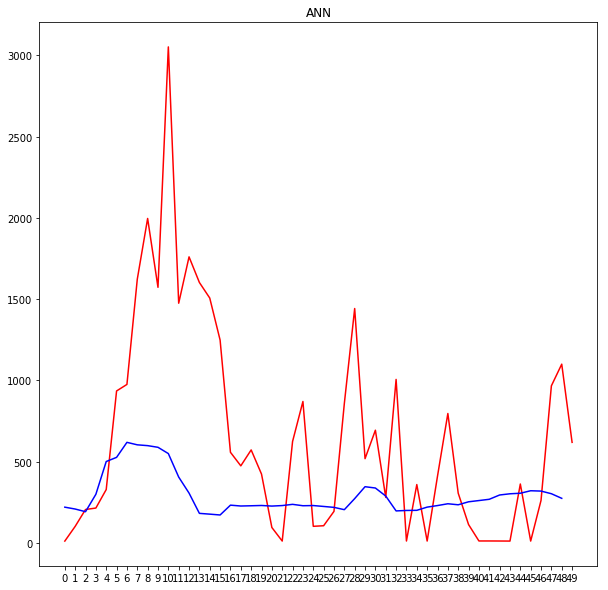


weights [[ -7.56574720e-02   2.05516174e-01  -3.36288079e-03  -9.33350176e-02
    7.95227513e-02   5.16761616e-02   3.18781227e-01  -1.38910919e-01
   -3.03472459e-01   9.04094577e-02   1.29845813e-01   1.72535814e-02
    1.63731158e-01   1.90365687e-02  -2.12472882e-02   2.71072745e-01
   -1.38362788e-03  -7.87225962e-02  -1.18125573e-01  -8.06239843e-02
   -3.60289067e-01  -4.87984084e-02  -3.43682259e-01   1.92458089e-02
    1.62975546e-02  -4.31650393e-02   6.18198812e-02   2.06989363e-01
    1.55950591e-01   2.47565731e-01]
 [  3.34848277e-02  -1.59913674e-01  -2.31079124e-02   2.29743347e-02
    1.31911486e-02  -1.98896960e-04  -3.41109604e-01  -2.78782398e-02
    3.12451363e-01   3.71936075e-02  -2.06221819e-01   2.16718931e-02
   -2.07599968e-01   3.66629958e-02   2.64658369e-02  -2.97719747e-01
    6.43979833e-02   1.43046714e-02  -1.92407183e-02  -2.68203323e-03
    3.32397401e-01   4.80713416e-03   3.37611198e-01   3.83046381e-02
   -3.11377794e-02  -3.09019033e-02   3.8491